<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/yolov5_gradCAM_corneAI_revision_20250716.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5_GradCAM_CorneAI**

論文revision用

https://github.com/pooya-mohammadi/yolov5-gradcam

###**⭐️⭐️Area of interestの計算**

結果をcsvに保存する

GPUのインスタンスにより結果にばらつきが出る（T4が一番マシ）。CPUによるものを統一の回答とする

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git --q
# !pip install torch --q
# !pip install torchvision --q
# !pip install -U opencv-python --q
print("[INFO] To use new installed version of opencv, the session should be restarted!!!!")

!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

import os
os.chdir('/content/yolov5-gradcam')

model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"


Mounted at /gdrive
/content
Found existing installation: deep_utils 1.5.5
Uninstalling deep_utils-1.5.5:
  Successfully uninstalled deep_utils-1.5.5
  Preparing metadata (setup.py) ... done
[INFO] To use new installed version of opencv, the session should be restarted!!!!
fatal: destination path 'yolov5-gradcam' already exists and is not an empty directory.


In [ ]:
### GPUの種類により結果が異なるため、CPUで計算したものを採用

import os
os.chdir("/content/yolov5-gradcam")

import pandas as pd
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # Colab環境でcv2_imshowを使用する場合にコメント解除
from deep_utils.utils.box_utils.boxes import Box
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import torchvision
import warnings
import sys

# FutureWarningを一時的に抑制（register_backward_hook使用時）
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5の必要な関数をインポート - attempt_loadの場所を修正
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # 修正: models.experimentalから

# YOLOv5のカスタムクラスをインポートします
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# これまでに登場したクラスをすべてリストに追加します
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# === 最適化: PYTORCH_CUDA_ALLOC_CONFの詳細設定 ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# === 最適化: PyTorch 2.0以上の場合、コンパイルキャッシュをリセット ===
if hasattr(torch._dynamo, 'reset'):
    torch._dynamo.reset()

# グローバル変数として定義（エラー回避のため）
global img_size
img_size = 640

# ========== 統合版：メモリ管理ユーティリティ ==========
class GPUMemoryMonitor:
    """GPU メモリの監視と管理を行うクラス"""

    def __init__(self, warning_threshold=0.8, critical_threshold=0.9):
        """
        Args:
            warning_threshold: 警告を出すメモリ使用率の閾値 (0-1)
            critical_threshold: クリティカル警告を出すメモリ使用率の閾値 (0-1)
        """
        self.warning_threshold = warning_threshold
        self.critical_threshold = critical_threshold
        self.device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
        self.total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0

    def get_memory_stats(self):
        """現在のメモリ使用状況を取得"""
        if not torch.cuda.is_available():
            return {
                'allocated': 0,
                'reserved': 0,
                'free': 0,
                'total': 0,
                'usage_ratio': 0
            }

        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        total = self.total_memory
        free = total - reserved
        usage_ratio = reserved / total if total > 0 else 0

        return {
            'allocated': allocated,
            'reserved': reserved,
            'free': free,
            'total': total,
            'usage_ratio': usage_ratio
        }

    def display_memory_status(self, prefix=""):
        """メモリ状況を視覚的に表示"""
        stats = self.get_memory_stats()

        # 使用率に応じた色付け（ANSIエスケープコード）
        if stats['usage_ratio'] > self.critical_threshold:
            color = "\033[91m"  # 赤
            status = "⚠️  CRITICAL"
        elif stats['usage_ratio'] > self.warning_threshold:
            color = "\033[93m"  # 黄
            status = "⚠️  WARNING"
        else:
            color = "\033[92m"  # 緑
            status = "✅ OK"
        reset_color = "\033[0m"

        # プログレスバーの作成
        bar_length = 30
        filled_length = int(bar_length * stats['usage_ratio'])
        bar = '█' * filled_length + '░' * (bar_length - filled_length)

        print(f"\n{prefix}GPU Memory Status ({self.device_name}) {status}")
        print(f"├─ Usage: {color}[{bar}] {stats['usage_ratio']*100:.1f}%{reset_color}")
        print(f"├─ Allocated: {stats['allocated']:.2f} GB")
        print(f"├─ Reserved:  {stats['reserved']:.2f} GB")
        print(f"├─ Free:      {stats['free']:.2f} GB")
        print(f"└─ Total:     {stats['total']:.2f} GB")

    def check_memory_health(self):
        """メモリ使用状況をチェックし、必要に応じてクリーンアップを推奨"""
        stats = self.get_memory_stats()

        if stats['usage_ratio'] > self.critical_threshold:
            return 'critical', stats
        elif stats['usage_ratio'] > self.warning_threshold:
            return 'warning', stats
        else:
            return 'ok', stats

    def cleanup_if_needed(self, force=False):
        """必要に応じてメモリクリーンアップを実行"""
        health, stats = self.check_memory_health()

        if health == 'critical' or force:
            print(f"\n🧹 メモリクリーンアップを実行中... (使用率: {stats['usage_ratio']*100:.1f}%)")
            aggressive_memory_cleanup()  # 統合：より積極的なクリーンアップ関数を使用

            # クリーンアップ後の状態を確認
            new_stats = self.get_memory_stats()
            freed = stats['reserved'] - new_stats['reserved']
            print(f"✨ クリーンアップ完了: {freed:.2f} GB 解放されました")

            return True
        return False

# === 統合：旧バージョンの有用な関数を追加 ===
def find_cuda_tensors():
    """メモリに残っているCUDAテンソルを検出"""
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size(), obj.element_size() * obj.nelement()))
        except:
            pass
    return cuda_tensors

def log_cuda_tensors(message=""):
    """CUDAテンソルの状態をログ出力"""
    cuda_tensors = find_cuda_tensors()
    if cuda_tensors:
        print(f"{message} 検出されたCUDAテンソル数: {len(cuda_tensors)}")
        # 大きいテンソルのみ表示
        large_tensors = [t for t in cuda_tensors if t[2] > 1024*1024]  # 1MB以上
        if large_tensors:
            print(f"  大きなテンソル (>1MB): {len(large_tensors)}個")
            for i, (tensor_type, size, bytes_size) in enumerate(large_tensors[:5]):
                print(f"    {i+1}. Size: {size}, Memory: {bytes_size/1024**2:.2f}MB")

def aggressive_memory_cleanup():
    """積極的なメモリクリーンアップを実行"""
    # Pythonのガベージコレクション
    gc.collect()

    # PyTorchのキャッシュクリア
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        # CUDAのメモリプールをリセット（PyTorch 1.10以降）
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()

    # PyTorch 2.0以上の場合、コンパイルキャッシュもクリア
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """特定のレイヤーのみ勾配計算を有効化"""
    # まず全体の勾配を無効化
    for param in model.model.parameters():
        param.requires_grad = False

    # 特定のレイヤーのみ有効化
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== 既存のクラスは変更なし ==========
# YOLOV5TorchObjectDetectorクラス（変更なし）
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        # === 最適化: デフォルトでは勾配計算を無効化 ===
        # Grad-CAM使用時のみ必要なレイヤーで有効化
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            print("[INFO] fetching names from coco file")
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light",
                          "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
                          "cow",
                          "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
                          "frisbee",
                          "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
                          "surfboard",
                          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
                          "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
                          "couch",
                          "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
                          "keyboard", "cell phone",
                          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                          "teddy bear",
                          "hair drier", "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"

        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]  # number of boxes
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        # === 変更点: 推論部分のwith torch.no_grad()を削除 ===
        # Grad-CAMのために勾配計算を有効にする
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)

        # === 改善点: NMS後の処理は勾配不要なのでno_grad()を使用 ===
        with torch.no_grad():
            # 以下の処理はCPUで行うことでGPUメモリを節約
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                            range(4)]
            for i, det in enumerate(prediction):  # detections per image
                if len(det):
                    # detをCPUに移動し、元のGPUテンソルは即座に削除
                    det_cpu = det.cpu()
                    del det  # GPUメモリを即座に解放

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            # predictionは不要になったので削除
            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img  # 元の画像データを削除

        # リサイズ処理を効率化
        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0  # 中間データを削除

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# YOLOV5GradCAMクラス（変更なし）
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug  # デバッグフラグ
        self.layer_name = layer_name  # デバッグ用に保存

        # === 改善点1: フックハンドルを保存 ===
        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            # === 変更点: detach()してからclone()でより安全に ===
            try:
                # detach()で計算グラフから切り離してからclone()
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            # === 変更点: outputもdetach().clone()してより安全に ===
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)

        # === 最適化: 必要なレイヤーのみ勾配計算を有効化 ===
        set_model_gradients(self.model, layer_name, enable=True)

        # === 改善点2: フックハンドルを保存 ===
        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """フックとメモリを明示的にクリーンアップする"""
        # === 改善点3: フックの削除 ===
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        # === 改善点4: 辞書のクリア ===
        self.gradients.clear()
        self.activations.clear()

        # === 最適化: レイヤーの勾配計算を無効化 ===
        set_model_gradients(self.model, self.layer_name, enable=False)

        # === 改善点5: ターゲットレイヤーへの参照を削除 ===
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        """コンテキストマネージャーのエントリーポイント"""
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """コンテキストマネージャーの終了ポイント（自動クリーンアップ）"""
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        # Falseを返すことで例外を再発生させる
        return False

    def __del__(self):
        """デストラクタでも念のためクリーンアップ"""
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        # === 改善点: 各クラスごとに順伝播を再実行 ===
        # まず、一度だけフォワードパスを実行してtop3_indicesを取得
        preds, logits = self.model(input_img)

        # topkの計算は勾配不要なのでno_grad()を適用
        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            # top3_indicesは不要になったので削除
            del top3_indices

        if self.method == "eigencam":
            # EigenCAMの場合は一度のフォワードパスで計算
            with torch.no_grad():  # EigenCAMは勾配不要
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            # GradCAMまたはGradCAM++の場合、各クラスごとに処理
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                # === 重要な変更: 各クラスごとに新しいフォワードパスを実行 ===
                # モデルの勾配をリセット
                self.model.zero_grad()

                # === 追加: インプレース操作を避けるためにinput_imgをclone ===
                input_img_clone = input_img.clone()

                # 新しいフォワードパス
                _, new_logits = self.model(input_img_clone)

                # 即座に不要な変数を削除
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                # === 変更点: retain_graph=Trueを削除 ===
                score.backward()  # retain_graph=Trueを削除

                # === 追加: gradientsとactivationsが存在することを確認 ===
                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits  # 存在しない場合はここで削除
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                # scoreとnew_logitsは不要になったので削除
                del score
                del new_logits

                # saliency_mapの計算は勾配不要なのでno_grad()を適用
                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights  # weightsを即座に削除

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    # ゼロ除算を避けるためにepsilonを追加
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    # min/maxは不要なので削除
                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                # === 追加: 各クラスの処理後にメモリクリーンアップ ===
                # 勾配とアクティベーションを即座に削除
                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                # 不要な中間変数を削除
                del gradients, activations

                # CUDAキャッシュのクリア（必要に応じて）
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        # view操作は新しいテンソルを作成しないので効率的
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha  # alphaを削除
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom  # 中間変数を削除

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha  # 中間変数を削除

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov  # 共分散行列を削除

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors  # 不要な固有値・固有ベクトルを削除

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector  # 中間変数を削除

        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max  # min/maxを削除

        # Resize to match the input image size
        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# find_yolo_layer関数
def find_yolo_layer(model, layer_name):
   hierarchy = layer_name.split("_")
   target_layer = model.model._modules[hierarchy[0]]

   for h in hierarchy[1:]:
       target_layer = target_layer._modules[h]
   return target_layer

# get_aoi関数（メモリ効率化版）
def get_aoi(bbox, masks, threshold):
    total_intersect_pixels = 0

    with torch.no_grad():  # 全体を勾配計算不要で囲む
        for mask in masks:
            # マスクをCPUで処理（GPUメモリ節約）
            mask_cpu = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
            del mask  # 元のマスクは即座に削除

            mask_cpu = np.nan_to_num(mask_cpu, nan=0.0).astype(np.uint8)

            # 閾値処理（より効率的な方法）
            binary_mask = mask_cpu >= (threshold * 255)
            del mask_cpu  # 処理済みのマスクは削除

            x1, y1, x2, y2 = bbox
            mask_bbox = binary_mask[y1:y2, x1:x2]

            intersect_pixels = np.sum(mask_bbox)
            total_intersect_pixels += intersect_pixels

            del mask_bbox, binary_mask  # 不要な変数を削除

        mask_bbox_area = (y2 - y1) * (x2 - x1)
        AOI = total_intersect_pixels / mask_bbox_area if mask_bbox_area > 0 else 0

    return AOI

# ========== 統合版：calculate_aoi関数（視覚的メモリモニタリング機能付き） ==========
def calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                  start_index=None, end_index=None, skip_processed=True, debug_mode=False):
    df = pd.read_csv(csv_path)
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # メモリモニターの初期化
    memory_monitor = GPUMemoryMonitor(warning_threshold=0.75, critical_threshold=0.85)

    # 開始時のメモリ状況を表示
    memory_monitor.display_memory_status("🚀 処理開始時")

    # === システム情報の表示 ===
    print("\n=== システム情報 ===")
    print(f"Python version: {sys.version}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
            props = torch.cuda.get_device_properties(i)
            print(f"    Total memory: {props.total_memory / 1024**3:.2f} GB")
    print("="*50 + "\n")

    # AOIカラムの定義
    all_layers_cols = [
        ("model_17_cv3_conv", f"AOI_{threshold}_layermodel_17_cv3_conv"),
        ("model_20_cv3_conv", f"AOI_{threshold}_layermodel_20_cv3_conv"),
        ("model_23_cv3_conv", f"AOI_{threshold}_layermodel_23_cv3_conv"),
        ("model_24_m_0", f"AOI_{threshold}_layer24_m_0"),
        ("model_24_m_1", f"AOI_{threshold}_layer24_m_1"),
        ("model_24_m_2", f"AOI_{threshold}_layer24_m_2")
    ]

    # カラムが存在しない場合は追加
    for layer_name, col_name in all_layers_cols:
        if col_name not in df.columns:
            df[col_name] = None

    # 処理済み画像の判定関数
    def is_processed(row):
        """すべてのAOIカラムに値が入っているかチェック"""
        for _, col_name in all_layers_cols:
            if pd.isna(row[col_name]) or row[col_name] is None:
                return False
        return True

    # 処理対象のインデックスを決定
    if skip_processed and start_index is None and end_index is None:
        # 未処理の画像のみを対象とする
        unprocessed_indices = []
        for idx, row in df.iterrows():
            if not is_processed(row):
                unprocessed_indices.append(idx)

        if not unprocessed_indices:
            print("すべての画像が処理済みです。")
            return

        print(f"未処理画像数: {len(unprocessed_indices)}/{len(df)}")
        print(f"最初の未処理画像インデックス: {unprocessed_indices[0]}")

        # 処理対象インデックスのリスト
        target_indices = unprocessed_indices

    else:
        # 手動でインデックス範囲を指定した場合
        if start_index is None:
            start_index = 0
        if end_index is None:
            end_index = len(df)

        target_indices = list(range(start_index, end_index))

        # skip_processedがTrueの場合、範囲内でも処理済みはスキップ
        if skip_processed:
            target_indices = [idx for idx in target_indices
                            if idx < len(df) and not is_processed(df.iloc[idx])]

    print(f"処理対象画像数: {len(target_indices)}")

    # 進捗状況の表示
    processed_count = 0
    skipped_count = len(df) - len(target_indices) if skip_processed else 0
    not_found_count = 0
    error_count = 0
    cuda_error_occurred = False
    memory_cleanup_count = 0

    # エラー詳細の記録用
    error_details = {}
    # 成功したレイヤー数のカウント
    successful_layers = 0

    # 定期的な保存のカウンター
    save_interval = 5  # 5画像ごとに保存（より頻繁に）
    memory_check_interval = 3  # 3画像ごとにメモリチェック

    # メインの処理ループ
    for i, index in enumerate(tqdm(target_indices, desc="Processing images")):
        # 定期的なメモリチェック
        if i % memory_check_interval == 0 and i > 0:
            health, stats = memory_monitor.check_memory_health()

            if health == 'critical':
                print(f"\n⚠️  メモリ使用率がクリティカル ({stats['usage_ratio']*100:.1f}%) です！")
                memory_monitor.display_memory_status("📊 現在")

                # 強制クリーンアップ
                if memory_monitor.cleanup_if_needed(force=True):
                    memory_cleanup_count += 1
                    time.sleep(2)  # GPUのクールダウン

                    # クリーンアップ後の状態を表示
                    memory_monitor.display_memory_status("🔄 クリーンアップ後")

                    # デバッグモードの場合、詳細なテンソル情報も表示
                    if debug_mode:
                        log_cuda_tensors("クリーンアップ後:")

            elif health == 'warning':
                if i % (memory_check_interval * 3) == 0:  # 警告時は頻度を下げて表示
                    memory_monitor.display_memory_status("⚠️  メモリ警告")

                # 自動クリーンアップの実行
                if memory_monitor.cleanup_if_needed():
                    memory_cleanup_count += 1

        row = df.iloc[index]
        img_basename = row["image_basename"]

        if pd.isna(img_basename):
            print(f"Skipping row {index} due to NaN image_basename")
            continue

        img_found = False
        img_path = None

        # 画像ファイルの検索
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ""]:
            test_path = os.path.join(folder_path, f"{img_basename}{ext}")
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True
                break

        if not img_found:
            test_path = os.path.join(folder_path, img_basename)
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True

        if img_found:
            img = cv2.imread(img_path)

            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            try:
                # === 改善点: 前処理後、元の画像は即座に削除 ===
                torch_img = model.preprocessing(img[..., ::-1])
                del img  # 元の画像データを削除してメモリ解放

                for layer_name, col_name in all_layers_cols:
                    try:
                        # デバッグモードの場合はdebug=Trueを渡す
                        debug_flag = debug_mode and processed_count < 5

                        # === 改善点: コンテキストマネージャーを使用 ===
                        with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                          img_size=input_size, method="gradcampp",
                                          debug=debug_flag) as saliency_method:

                            masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                            if len(masks) > 0 and len(boxes) > 0:
                                mask = masks[0][0]
                                bbox = boxes[0][0]

                                aoi = get_aoi(bbox, [mask], threshold)
                                df.at[index, col_name] = aoi
                                successful_layers += 1

                                # デバッグ用：AOI値が正しく計算されているか確認
                                if processed_count < 5:  # 最初の5画像のみログ出力
                                    print(f"  Layer {layer_name}: AOI = {aoi:.4f}")

                                # === 改善点: マスクとボックスを即座に削除 ===
                                del mask, bbox
                            else:
                                # デバッグ用：マスクまたはボックスが空の場合
                                if processed_count < 5:
                                    print(f"  Layer {layer_name}: No masks or boxes detected")

                            # === 改善点: 結果を即座に削除 ===
                            del masks, logits, boxes, cls_names

                        # with文を抜けた時点で自動的にcleanup()が呼ばれる
                        # 追加のメモリクリーンアップ（各レイヤー処理後）
                        aggressive_memory_cleanup()

                    except Exception as e:
                        # CUDA out of memoryエラーのチェック
                        if "CUDA out of memory" in str(e):
                            print(f"\n\nCUDA out of memory エラーが発生しました！")
                            print(f"エラー詳細: {str(e)}")
                            print(f"現在の画像: {img_basename} (インデックス: {index})")
                            print(f"エラー発生レイヤー: {layer_name}")
                            memory_monitor.display_memory_status("💥 エラー発生時")
                            if debug_mode:
                                log_cuda_tensors("エラー発生時:")
                            cuda_error_occurred = True
                            break
                        else:
                            error_count += 1
                            # エラー詳細を記録
                            error_key = f"{img_basename}_{layer_name}"
                            if error_key not in error_details:
                                error_details[error_key] = str(e)

                            if error_count <= 5:
                                print(f"Error processing image {img_basename} at layer {layer_name}: {str(e)}")

                # CUDA out of memoryエラーが発生したらループを抜ける
                if cuda_error_occurred:
                    break

                # === 改善点: 全レイヤー処理後にtorch_imgを削除 ===
                del torch_img

                # === 最適化: 各画像処理後に完全なメモリクリーンアップ ===
                aggressive_memory_cleanup()

                processed_count += 1

                # 進捗表示の改善（メモリ使用率も表示）
                if processed_count % 10 == 0:
                    stats = memory_monitor.get_memory_stats()
                    print(f"\n📈 進捗: {processed_count}/{len(target_indices)} 画像処理済み "
                          f"(GPU使用率: {stats['usage_ratio']*100:.1f}%)")

                # 定期的な中間保存
                if (i + 1) % save_interval == 0:
                    # デバッグ用：保存前のデータ確認
                    saved_count = sum(1 for idx in target_indices[:i+1]
                                    if idx < len(df) and is_processed(df.iloc[idx]))
                    print(f"\n💾 中間保存: {saved_count}個の画像が完全に処理済み")

                    # メモリ使用量のログ
                    memory_monitor.display_memory_status("💾 保存時")

                    df.to_csv(csv_path, index=False)
                    print(f"✅ 中間保存完了: {i + 1}/{len(target_indices)} 画像処理済み")

                    # === 最適化: より積極的なメモリクリーンアップ ===
                    aggressive_memory_cleanup()

                    # クリーンアップ後のメモリ使用量
                    memory_monitor.display_memory_status("クリーンアップ後:")
                    if debug_mode:
                        log_cuda_tensors("クリーンアップ後:")

            except Exception as e:
                # CUDA out of memoryエラーのチェック
                if "CUDA out of memory" in str(e):
                    print(f"\n\n💥 CUDA out of memory エラーが発生しました！")
                    print(f"エラー詳細: {str(e)}")
                    print(f"現在の画像: {img_basename} (インデックス: {index})")
                    memory_monitor.display_memory_status("💥 エラー発生時")
                    cuda_error_occurred = True
                    break
                else:
                    error_count += 1
                    if error_count <= 5:
                        print(f"Error preprocessing image {img_basename}: {str(e)}")
        else:
            not_found_count += 1
            if not_found_count <= 5:
                print(f"Image not found: {img_basename}")

        # CUDA out of memoryエラーが発生したらループを抜ける
        if cuda_error_occurred:
            break

    # 最終保存（エラーが発生した場合も含む）
    df.to_csv(csv_path, index=False)

    # 最終的なメモリ使用量
    memory_monitor.display_memory_status("🏁 処理終了時")
    if debug_mode:
        log_cuda_tensors("最終状態:")

    if cuda_error_occurred:
        print(f"\n\n========== CUDA OUT OF MEMORY エラーで処理を中止しました ==========")
        print(f"最後に処理しようとした画像: {img_basename} (インデックス: {index})")
        print(f"処理済み画像数: {processed_count}")
        print(f"成功したレイヤー処理: {successful_layers}個")
        print(f"メモリクリーンアップ実行回数: {memory_cleanup_count}回")
        print(f"残り未処理画像数: {len(target_indices) - i}")
        print(f"結果を保存しました: {csv_path}")
        print(f"\n次回実行時は自動的に続きから処理されます。")
    else:
        print(f"\n✨ 処理完了サマリー:")
        print(f"├─ 処理した画像: {processed_count}個")
        print(f"├─ 成功したレイヤー処理: {successful_layers}個")
        print(f"├─ スキップした画像: {skipped_count}個")
        print(f"├─ 見つからなかった画像: {not_found_count}個")
        print(f"├─ エラーが発生した画像: {error_count}個")
        print(f"└─ メモリクリーンアップ実行回数: {memory_cleanup_count}回")

        # エラーの詳細を表示
        if error_details:
            print(f"\n⚠️  エラーの詳細（最初の10件）:")
            for i, (key, error_msg) in enumerate(list(error_details.items())[:10]):
                print(f"  {i+1}. {key}: {error_msg[:100]}...")

        # 最終的な完全処理済み画像数を確認
        fully_processed = sum(1 for idx, row in df.iterrows() if is_processed(row))
        print(f"\n📊 完全に処理済みの画像数: {fully_processed}/{len(df)}")

        print(f"\n💾 結果を保存しました: {csv_path}")

# ========== 実行モード設定 ==========
# 以下の変数を変更することで実行モードを切り替えできます

# MODE = "auto"：未処理画像を自動検出して処理
# MODE = "manual"：start_indexとend_indexで範囲を指定（処理済みはスキップ）
# MODE = "force"：start_indexとend_indexで範囲を指定（処理済みも再処理）
# MODE = "debug"：最初の未処理画像1枚のみ処理（デバッグ用）
MODE = "auto"  # "auto", "manual", "force", "debug" のいずれかを指定

# manualモードまたはforceモードの場合の範囲指定
MANUAL_START_INDEX = 0
MANUAL_END_INDEX = 10

# ========== メイン実行部分 ==========
# デバッグ関数：CSVファイルの状態を確認
def check_csv_status(csv_path, threshold=0.5):
    """CSVファイルの処理状況を確認する関数"""
    df = pd.read_csv(csv_path)

    all_layers_cols = [
        f"AOI_{threshold}_layermodel_17_cv3_conv",
        f"AOI_{threshold}_layermodel_20_cv3_conv",
        f"AOI_{threshold}_layermodel_23_cv3_conv",
        f"AOI_{threshold}_layer24_m_0",
        f"AOI_{threshold}_layer24_m_1",
        f"AOI_{threshold}_layer24_m_2"
    ]

    print(f"CSVファイル: {csv_path}")
    print(f"総行数: {len(df)}")

    # 各カラムの状態を確認
    for col in all_layers_cols:
        if col in df.columns:
            non_null_count = df[col].notna().sum()
            print(f"  {col}: {non_null_count}/{len(df)} ({non_null_count/len(df)*100:.1f}%)")
        else:
            print(f"  {col}: カラムが存在しません")

    # 完全に処理済みの行数
    fully_processed = 0
    for idx, row in df.iterrows():
        if all(pd.notna(row[col]) and row[col] is not None for col in all_layers_cols if col in df.columns):
            fully_processed += 1

    print(f"\n完全に処理済みの画像: {fully_processed}/{len(df)} ({fully_processed/len(df)*100:.1f}%)")

    # 最初の5行のデータを表示
    print("\n最初の5行のAOI値:")
    for idx in range(min(5, len(df))):
        print(f"  行{idx}: ", end="")
        for col in all_layers_cols:
            if col in df.columns:
                val = df.iloc[idx][col]
                if pd.notna(val):
                    print(f"{val:.4f} ", end="")
                else:
                    print("NaN ", end="")
        print()

folder_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"

threshold = 0.5

model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用デバイス: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

input_size = (640, 640)
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

target_layers = [
    "model_17_cv3_conv",
    "model_20_cv3_conv",
    "model_23_cv3_conv",
    "model_24_m_0",
    "model_24_m_1",
    "model_24_m_2"
]

# バッチ処理モードの設定
USE_BATCH_MODE = False
BATCH_SIZE = 20

if USE_BATCH_MODE:
    print("=== バッチ処理モードで実行します ===")

    # 処理前のCSV状態を確認
    print("\n=== 処理前のCSV状態 ===")
    check_csv_status(csv_path, threshold)
    print("="*50 + "\n")

    # is_processed関数を定義（calculate_aoi関数外でも使えるように）
    def is_processed(row):
        """すべてのAOIカラムに値が入っているかチェック"""
        all_layers_cols = [
            ("model_17_cv3_conv", f"AOI_{threshold}_layermodel_17_cv3_conv"),
            ("model_20_cv3_conv", f"AOI_{threshold}_layermodel_20_cv3_conv"),
            ("model_23_cv3_conv", f"AOI_{threshold}_layermodel_23_cv3_conv"),
            ("model_24_m_0", f"AOI_{threshold}_layer24_m_0"),
            ("model_24_m_1", f"AOI_{threshold}_layer24_m_1"),
            ("model_24_m_2", f"AOI_{threshold}_layer24_m_2")
        ]
        for _, col_name in all_layers_cols:
            if pd.isna(row[col_name]) or row[col_name] is None:
                return False
        return True

    # 未処理画像のインデックスを取得
    df_check = pd.read_csv(csv_path)
    unprocessed_indices = []

    for idx, row in df_check.iterrows():
        if not is_processed(row):
            unprocessed_indices.append(idx)

    if not unprocessed_indices:
        print("すべての画像が処理済みです。")
    else:
        print(f"未処理画像数: {len(unprocessed_indices)}")

        # バッチごとに処理
        for i in range(0, len(unprocessed_indices), BATCH_SIZE):
            batch_indices = unprocessed_indices[i:i+BATCH_SIZE]
            batch_start = batch_indices[0] if batch_indices else 0
            batch_end = batch_indices[-1] + 1 if batch_indices else 0

            print(f"\nバッチ {i//BATCH_SIZE + 1}/{(len(unprocessed_indices)-1)//BATCH_SIZE + 1}: "
                  f"インデックス {batch_indices}")

            # バッチ内の画像をまとめて処理
            calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                         start_index=None, end_index=None, skip_processed=True, debug_mode=False)

            # 処理完了後のクリーンアップ
            aggressive_memory_cleanup()

            print(f"バッチ {i//BATCH_SIZE + 1} 完了")

            # バッチが完了したら、再度未処理画像を確認（中断された場合の対策）
            df_check = pd.read_csv(csv_path)
            remaining_unprocessed = sum(1 for idx, row in df_check.iterrows() if not is_processed(row))
            print(f"残り未処理画像数: {remaining_unprocessed}")

            if remaining_unprocessed == 0:
                break

    print("\n=== 全バッチ処理完了 ===")

    # 処理後のCSV状態を確認
    print("\n=== 処理後のCSV状態 ===")
    check_csv_status(csv_path, threshold)

else:
    print("=== 通常モードで実行します ===")
    print(f"実行モード: {MODE}")

    # 処理前のCSV状態を確認
    print("\n=== 処理前のCSV状態 ===")
    check_csv_status(csv_path, threshold)
    print("="*50 + "\n")

    if MODE == "auto":
        # 自動モード（未処理画像を検出）
        print("\n未処理画像を自動検出して処理します...")
        calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                     skip_processed=True, debug_mode=False)

    elif MODE == "manual":
        # 手動モード（範囲指定、処理済みはスキップ）
        print(f"\nインデックス {MANUAL_START_INDEX} から {MANUAL_END_INDEX-1} まで処理します（処理済みはスキップ）...")
        calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                     start_index=MANUAL_START_INDEX, end_index=MANUAL_END_INDEX,
                     skip_processed=True, debug_mode=False)

    elif MODE == "force":
        # 強制再処理モード（範囲指定、処理済みも再処理）
        print(f"\nインデックス {MANUAL_START_INDEX} から {MANUAL_END_INDEX-1} まで強制的に再処理します...")
        calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                     start_index=MANUAL_START_INDEX, end_index=MANUAL_END_INDEX,
                     skip_processed=False, debug_mode=False)

    elif MODE == "debug":
        # デバッグモード（最初の未処理画像1枚のみ処理）
        print("\nデバッグモード: 最初の未処理画像1枚のみ処理します...")
        # 未処理画像を探す
        df_debug = pd.read_csv(csv_path)
        debug_idx = None
        for idx, row in df_debug.iterrows():
            all_layers_cols = [
                f"AOI_{threshold}_layermodel_17_cv3_conv",
                f"AOI_{threshold}_layermodel_20_cv3_conv",
                f"AOI_{threshold}_layermodel_23_cv3_conv",
                f"AOI_{threshold}_layer24_m_0",
                f"AOI_{threshold}_layer24_m_1",
                f"AOI_{threshold}_layer24_m_2"
            ]
            if any(pd.isna(row[col]) or row[col] is None for col in all_layers_cols if col in df_debug.columns):
                debug_idx = idx
                break

        if debug_idx is not None:
            print(f"デバッグ対象: インデックス {debug_idx}, 画像: {df_debug.iloc[debug_idx]['image_basename']}")
            calculate_aoi(folder_path, csv_path, threshold, model, target_layers,
                         start_index=debug_idx, end_index=debug_idx+1,
                         skip_processed=False, debug_mode=True)
        else:
            print("未処理画像が見つかりませんでした。")

    else:
        print(f"無効なモード: {MODE}")
        print("MODE は 'auto', 'manual', 'force', 'debug' のいずれかを指定してください。")

    # 処理後のCSV状態を確認
    print("\n=== 処理後のCSV状態 ===")
    check_csv_status(csv_path, threshold)

# === 最適化: 最終的なメモリクリーンアップ ===
print("\n=== 最終クリーンアップ ===")
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

    # 最終メモリ状態の表示
    memory_monitor = GPUMemoryMonitor()
    memory_monitor.display_memory_status("最終クリーンアップ後:")

    if MODE == "debug":
        log_cuda_tensors("最終クリーンアップ後:")

# モデルの削除
del model
gc.collect()

print("\n処理が完了しました。")

###**上記スクリプトのための保存用csvファイル作成**

In [ ]:
import pandas as pd

###これを押すとcsvが更新されてしまうので注意！！！
import pandas as pd
import os
from pathlib import Path

# ディレクトリとファイルパス
image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
output_file_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"

# CSVファイルが既に存在するかチェック
if os.path.exists(output_file_path):
    print(f"警告: CSVファイルが既に存在します: {output_file_path}")
    response = input("上書きしますか？ (y/n): ").lower()

    if response != 'y':
        print("処理を中止しました。")
        exit()
    else:
        print("既存のファイルを上書きします。")

# 画像ディレクトリが存在するかチェック
if not os.path.exists(image_dir):
    print(f"エラー: 画像ディレクトリが見つかりません: {image_dir}")
    exit()

# 画像ディレクトリ内のファイルを取得（一般的な画像拡張子をフィルタリング）
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
image_files = []

# ディレクトリ内のすべてのファイルをチェック
try:
    for file in os.listdir(image_dir):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            # basenameを取得（拡張子なし）
            basename = os.path.splitext(file)[0]
            image_files.append(basename)
except Exception as e:
    print(f"エラー: 画像ディレクトリの読み込みに失敗しました: {e}")
    exit()

# 画像ファイルが見つからない場合の処理
if not image_files:
    print(f"警告: 画像ファイルが見つかりませんでした。")
    print(f"対象ディレクトリ: {image_dir}")
    print(f"対象拡張子: {', '.join(image_extensions)}")
    exit()

# ソート（必要に応じて）
image_files.sort()

# DataFrameを作成（basenameをインデックスとして）
df = pd.DataFrame(index=image_files)
df.index.name = 'image_basename'  # インデックス名を設定

# 例としてthresholdの値を設定
threshold = 0.5

# 指定されたレイヤー (originalはconvでなくact??)
layers = ['model_17_cv3_conv', 'model_20_cv3_conv', 'model_23_cv3_conv', '24_m_0', '24_m_1', '24_m_2']

# 各レイヤーに対して新しい列を作成
for layer in layers:
    df[f'AOI_{threshold}_layer{layer}'] = None  # 初期値をNoneに設定

# DataFrameの最初の数行を表示
print("\n作成されたDataFrame:")
print(df.head())
print(f"\n総画像数: {len(df)}")

# CSVファイルとして保存
try:
    df.to_csv(output_file_path, index=True)
    print(f"\nCSVファイルが正常に保存されました: {output_file_path}")
except Exception as e:
    print(f"エラー: CSVファイルの保存に失敗しました: {e}")

警告: CSVファイルが既に存在します: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv
上書きしますか？ (y/n): n
処理を中止しました。

作成されたDataFrame:
                     AOI_0.5_layermodel_17_cv3_conv  \
image_basename                                        
[apac]FKS_130_R_slit                           None   
[apac]FKS_238_L_slit                           None   
[apac]FKS_382_L_slit                           None   
[apac]TKB_001_R_slit                           None   
[apac]fko0074                                  None   

                     AOI_0.5_layermodel_20_cv3_conv  \
image_basename                                        
[apac]FKS_130_R_slit                           None   
[apac]FKS_238_L_slit                           None   
[apac]FKS_382_L_slit                           None   
[apac]TKB_001_R_slit                           None   
[apac]fko0074                                  None   

                     AOI_0.5_layermodel_23_cv3_conv AOI_0.5_layer24_m_0  \
im

###**csvファイルにGroundTruthとPredictを追加**

In [ ]:
import pandas as pd
import numpy as np
import cv2
import torch
import os
import re
from tqdm import tqdm
import warnings
import torchvision

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート（既存のコードから）
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# YOLOv5TorchObjectDetectorクラス（既存のコードから必要な部分を抽出）
class YOLOV5TorchObjectDetector(torch.nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        import time
        nc = prediction.shape[2] - 5
        xc = prediction[..., 4] > conf_thres

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

        min_wh, max_wh = 2, 4096
        max_nms = 30000
        time_limit = 10.0
        redundant = True
        multi_label &= nc > 1
        merge = False

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]

        for xi, (x, log_) in enumerate(zip(prediction, logits)):
            x = x[xc[xi]]
            log_ = log_[xc[xi]]

            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]
                v[:, 4] = 1.0
                v[range(len(l)), l[:, 0].long() + 5] = 1.0
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]

            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        with torch.no_grad():
            prediction, logits, _ = self.model(img, augment=False)
            prediction, logits = self.non_max_suppression(
                prediction, logits, self.confidence, self.iou_thresh,
                classes=None, agnostic=self.agnostic
            )

            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]

            for i, det in enumerate(prediction):
                if len(det):
                    det_cpu = det.cpu()
                    del det

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(self.img_size[0], xyxy[2])
                        xyxy[3] = min(self.img_size[1], xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


def extract_ground_truth(basename):
    """
    basenameから[]内の文字列を抽出し、対応するclass_nameを返す

    Args:
        basename: ファイル名（拡張子なし）

    Returns:
        対応するクラス名（見つからない場合はNone）
    """
    # []内の文字列を抽出する正規表現
    pattern = r'\[([^\]]+)\]'
    matches = re.findall(pattern, basename)

    if not matches:
        return None

    # 最初の[]内の文字列を取得
    label_text = matches[0].lower()

    # マッピング辞書
    label_mapping = {
        'infection': 'infection',
        'normal': 'normal',
        'immun': 'non-infection',  # immunはnon-infectionに対応
        'scar': 'scar',
        'tumor': 'tumor',
        'deposit': 'deposit',
        'apac': 'APAC',
        'cat': 'lens opacity',  # catはlens opacityに対応
        'bullous': 'bullous'
    }

    # 部分一致でチェック
    for key, value in label_mapping.items():
        if key in label_text:
            return value

    return None


def add_groundtruth_and_predict_columns(csv_path, image_dir, model_path, output_csv_path=None):
    """
    CSVファイルにGroundTruth, Predict, Likelihood列を追加

    Args:
        csv_path: 入力CSVファイルのパス
        image_dir: 画像ディレクトリのパス
        model_path: YOLOv5モデルの重みファイルパス
        output_csv_path: 出力CSVファイルのパス（Noneの場合は入力ファイルを上書き）
    """
    # CSVファイルを読み込み
    print(f"CSVファイルを読み込み中: {csv_path}")
    df = pd.read_csv(csv_path, index_col='image_basename')

    # 新しい列を追加
    df['GroundTruth'] = None
    df['Predict'] = None
    # Likelihood列をfloat型で初期化
    df['Likelihood'] = pd.Series(dtype='float64')


    # デバイスとモデルの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用デバイス: {device}")
    if device == "cuda":
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("\nモデルをロード中...")
    model = YOLOV5TorchObjectDetector(
        model_path,
        device,
        img_size=(640, 640),
        names=class_names
    )

    # 各画像に対して処理
    print("\n画像を処理中...")
    for idx, basename in enumerate(tqdm(df.index)):
        # 1. GroundTruthの抽出
        ground_truth = extract_ground_truth(basename)
        df.at[basename, 'GroundTruth'] = ground_truth

        # 2. 画像の推論
        img_found = False
        img_path = None

        # 画像ファイルを探す
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ""]:
            test_path = os.path.join(image_dir, f"{basename}{ext}")
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True
                break

        if not img_found:
            test_path = os.path.join(image_dir, basename)
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True

        if img_found:
            try:
                # 画像を読み込み
                img = cv2.imread(img_path)
                if img is not None:
                    # 前処理
                    torch_img = model.preprocessing(img[..., ::-1])

                    # 推論
                    with torch.no_grad():
                        [boxes, classes, class_names_pred, confidences], _ = model(torch_img)

                        # 最も信頼度の高い予測を選択
                        if len(class_names_pred[0]) > 0:
                            confidences_list = confidences[0]
                            # 信頼度が最も高いクラスと信頼度を選択
                            max_conf_idx = np.argmax(confidences_list)
                            predicted_class = class_names_pred[0][max_conf_idx]
                            likelihood = confidences_list[max_conf_idx]

                            df.at[basename, 'Predict'] = predicted_class
                            df.at[basename, 'Likelihood'] = float(likelihood)
                        else:
                            df.at[basename, 'Predict'] = None
                            df.at[basename, 'Likelihood'] = None

                    del torch_img, img

            except Exception as e:
                print(f"\nエラー: {basename}: {str(e)}")
                df.at[basename, 'Predict'] = None
                df.at[basename, 'Likelihood'] = None
        else:
            df.at[basename, 'Predict'] = None
            df.at[basename, 'Likelihood'] = None

        # メモリクリーンアップ（定期的に実行）
        if idx % 50 == 0:
            torch.cuda.empty_cache()

    # 出力ファイルパスの決定
    if output_csv_path is None:
        output_csv_path = csv_path

    # 結果を保存
    df.to_csv(output_csv_path)
    print(f"\n結果を保存しました: {output_csv_path}")

    # 統計情報を表示
    print("\n=== 統計情報 ===")
    print(f"総画像数: {len(df)}")
    print(f"GroundTruthが特定できた画像数: {df['GroundTruth'].notna().sum()}")
    print(f"Predictが成功した画像数: {df['Predict'].notna().sum()}")

    # 各クラスの分布を表示
    print("\nGroundTruthの分布:")
    print(df['GroundTruth'].value_counts())

    print("\nPredictの分布:")
    print(df['Predict'].value_counts())

    print("\nLikelihoodの統計:")
    print(df['Likelihood'].describe())


    # 混同行列を計算（両方の値が存在する場合）
    valid_mask = df['GroundTruth'].notna() & df['Predict'].notna()
    if valid_mask.sum() > 0:
        print(f"\n両方の値が存在する画像数: {valid_mask.sum()}")
        accuracy = (df.loc[valid_mask, 'GroundTruth'] == df.loc[valid_mask, 'Predict']).mean()
        print(f"精度: {accuracy:.2%}")

    # クリーンアップ
    del model
    torch.cuda.empty_cache()

    return df


# ========== メイン実行部分 ==========
if __name__ == "__main__":
    # 作業ディレクトリの設定
    # 注意: このパスはあなたの環境に合わせて変更する必要があります
    # 例: os.chdir("/path/to/your/yolov5-gradcam")
    # Google Colab環境を想定しています
    try:
        os.chdir("/content/yolov5-gradcam")
    except FileNotFoundError:
        print("警告: /content/yolov5-gradcam ディレクトリが見つかりません。")
        print("メイン処理をスキップします。関数定義は完了しています。")
        # mainの実行をスキップ
        __name__ = "__not_main__"


if __name__ == "__main__":
    # パスの設定
    # Google Driveをマウントしていることを前提としています
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
    image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # バックアップを作成（念のため）
    import shutil
    backup_path = csv_path.replace('.csv', '_backup.csv')
    try:
        shutil.copy2(csv_path, backup_path)
        print(f"バックアップを作成しました: {backup_path}")
    except FileNotFoundError:
        print(f"エラー: CSVファイルが見つかりません: {csv_path}")
        print("処理を中止します。")
    else:
        # GroundTruthとPredict列を追加
        df_result = add_groundtruth_and_predict_columns(
            csv_path=csv_path,
            image_dir=image_dir,
            model_path=model_path,
            output_csv_path=csv_path  # 同じファイルに上書き
        )

        print("\n処理が完了しました。")

バックアップを作成しました: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++_backup.csv
CSVファイルを読み込み中: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv
使用デバイス: cpu

モデルをロード中...


INFO:models.yolo:Fusing layers... 
Fusing layers... 
INFO:utils.torch_utils:Model Summary: 213 layers, 7034398 parameters, 0 gradients
Model Summary: 213 layers, 7034398 parameters, 0 gradients


[INFO] Model is loaded

画像を処理中...


100%|██████████| 1039/1039 [03:07<00:00,  5.54it/s]



結果を保存しました: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv

=== 統計情報 ===
総画像数: 1039
GroundTruthが特定できた画像数: 1039
Predictが成功した画像数: 1027

GroundTruthの分布:
GroundTruth
normal           258
tumor            176
scar             140
infection        129
deposit          123
non-infection     71
lens opacity      68
bullous           63
APAC              11
Name: count, dtype: int64

Predictの分布:
Predict
normal           280
tumor            175
infection        128
scar             127
deposit          120
bullous           72
non-infection     60
lens opacity      55
APAC              10
Name: count, dtype: int64

Likelihoodの統計:
count    1027.000000
mean        0.888510
std         0.110204
min         0.280000
25%         0.870000
50%         0.930000
75%         0.960000
max         0.980000
Name: Likelihood, dtype: float64

両方の値が存在する画像数: 1027
精度: 86.56%

処理が完了しました。


#**Cut-and-Paste**

##**Extract cornea by elliptic annotation**

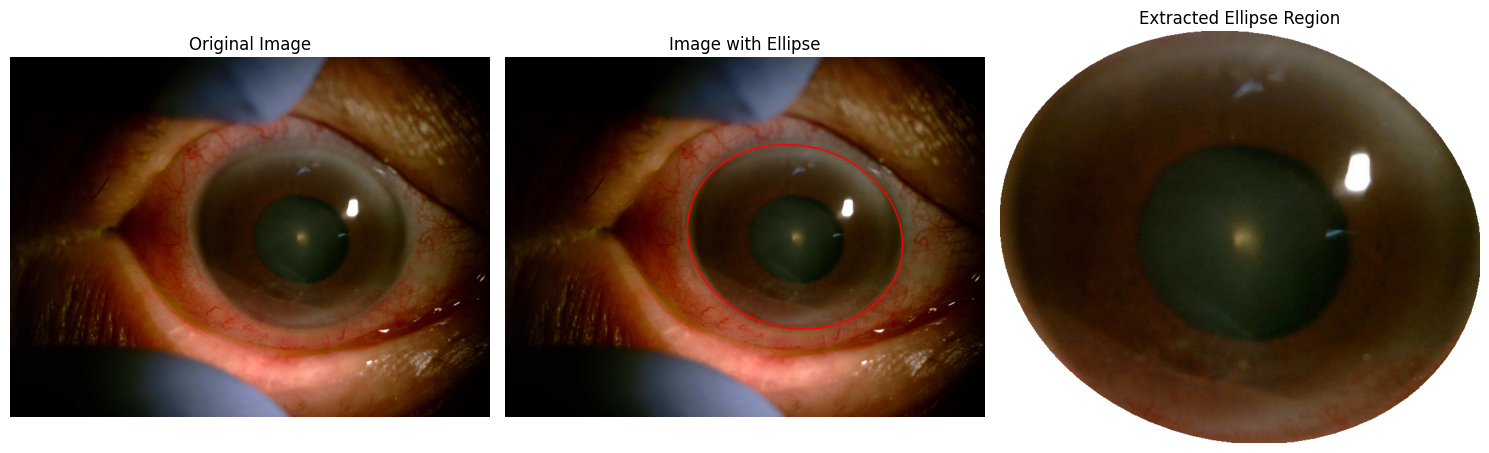

画像: [apac]TKB_001_R_slit.jpg
楕円の中心: (966.64, 599.75)
楕円の半径: (rx=362.22, ry=304.28)
回転角度: 14.40°


In [ ]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def get_ellipse_from_xml(xml_path, image_name):
    """
    XMLファイルから指定した画像の楕円情報を取得
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 画像名から楕円情報を検索
    for image in root.findall('.//image'):
        if image.get('name') == os.path.basename(image_name):
            ellipse = image.find('ellipse')
            if ellipse is not None:
                return {
                    'cx': float(ellipse.get('cx')),
                    'cy': float(ellipse.get('cy')),
                    'rx': float(ellipse.get('rx')),
                    'ry': float(ellipse.get('ry')),
                    'rotation': float(ellipse.get('rotation', '0'))
                }
    return None

def extract_ellipse_region(image, ellipse_params):
    """
    楕円パラメータに基づいて画像から楕円領域を抽出
    """
    height, width = image.shape[:2]

    # 楕円のパラメータ
    center = (int(ellipse_params['cx']), int(ellipse_params['cy']))
    axes = (int(ellipse_params['rx']), int(ellipse_params['ry']))
    angle = ellipse_params['rotation']

    # マスクを作成
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.ellipse(mask, center, axes, angle, 0, 360, 255, -1)

    # 楕円の境界ボックスを計算
    # 回転を考慮した楕円の境界点を計算
    cos_a = np.cos(np.radians(angle))
    sin_a = np.sin(np.radians(angle))

    # 楕円の境界ボックスの半幅を計算
    rx, ry = axes
    box_half_width = int(np.sqrt((rx * cos_a)**2 + (ry * sin_a)**2))
    box_half_height = int(np.sqrt((rx * sin_a)**2 + (ry * cos_a)**2))

    # 境界ボックスの座標
    x1 = max(0, center[0] - box_half_width)
    y1 = max(0, center[1] - box_half_height)
    x2 = min(width, center[0] + box_half_width)
    y2 = min(height, center[1] + box_half_height)

    # 楕円領域を抽出
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    cropped_region = masked_image[y1:y2, x1:x2]
    cropped_mask = mask[y1:y2, x1:x2]

    # 背景を白にする
    if len(image.shape) == 3:
        white_background = np.ones_like(cropped_region) * 255
        cropped_region = np.where(cropped_mask[..., np.newaxis] > 0,
                                 cropped_region,
                                 white_background)

    return cropped_region, center, axes, angle

def visualize_image_with_ellipse(image_path, xml_path):
    """
    画像と抽出した楕円領域を並べて表示
    """
    # 画像を読み込む
    image = cv2.imread(image_path)
    if image is None:
        print(f"画像が読み込めません: {image_path}")
        return

    # BGRからRGBに変換
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # XMLから楕円情報を取得
    ellipse_params = get_ellipse_from_xml(xml_path, image_path)
    if ellipse_params is None:
        print(f"楕円情報が見つかりません: {os.path.basename(image_path)}")
        return

    # 楕円領域を抽出
    ellipse_region, center, axes, angle = extract_ellipse_region(image_rgb, ellipse_params)

    # 元画像に楕円を描画
    image_with_ellipse = image_rgb.copy()
    cv2.ellipse(image_with_ellipse, center, axes, angle, 0, 360, (255, 0, 0), 3)

    # 表示
    fig, axes_plot = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes_plot[0].imshow(image_rgb)
    axes_plot[0].set_title('Original Image')
    axes_plot[0].axis('off')

    # 楕円を描画した画像
    axes_plot[1].imshow(image_with_ellipse)
    axes_plot[1].set_title('Image with Ellipse')
    axes_plot[1].axis('off')

    # 抽出した楕円領域
    axes_plot[2].imshow(ellipse_region)
    axes_plot[2].set_title('Extracted Ellipse Region')
    axes_plot[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 楕円情報を表示
    print(f"画像: {os.path.basename(image_path)}")
    print(f"楕円の中心: ({ellipse_params['cx']:.2f}, {ellipse_params['cy']:.2f})")
    print(f"楕円の半径: (rx={ellipse_params['rx']:.2f}, ry={ellipse_params['ry']:.2f})")
    print(f"回転角度: {ellipse_params['rotation']:.2f}°")

# 使用例
xml_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Cornea_segmentation/annotations.xml"
image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[apac]TKB_001_R_slit.jpg"

# Google Driveをマウント（必要な場合）
# from google.colab import drive
# drive.mount('/gdrive')

# 画像と楕円を表示
visualize_image_with_ellipse(image_path, xml_path)

##**Extract cornea and paste on other image**

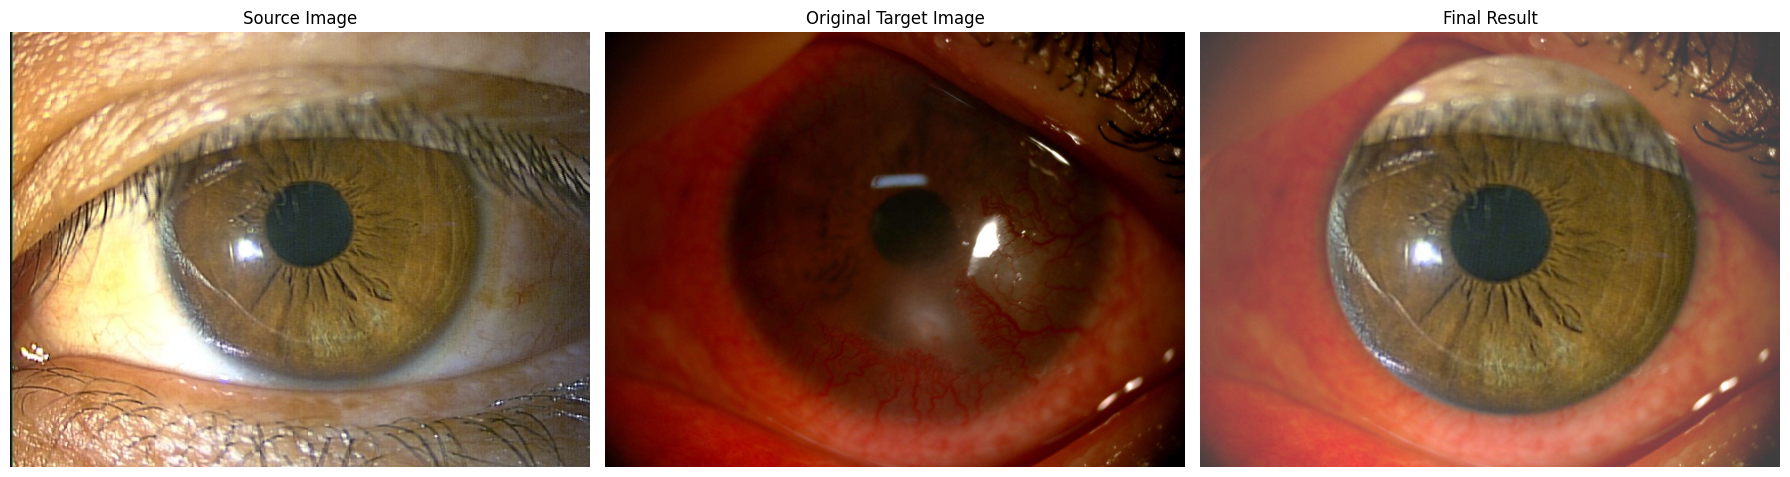

In [ ]:
"""
角膜画像の楕円領域移植プログラム

このプログラムは、ある眼の画像（ソース）から角膜（楕円領域）を抽出し、
別の眼の画像（ターゲット）に違和感なく移植することを目的とします。

■ 主な処理の流れ
1. 情報の取得:
   - `annotations.xml` ファイルから、ソース画像とターゲット画像の楕円（角膜）の
     位置、大きさ、回転角度に関する情報を読み込みます。

2. 輝度マッチング:
   - ソースとターゲットの楕円領域の平均的な明るさを計算します。
   - 両者の明るさが一致するように、ターゲット画像全体の輝度を調整します。
     これにより、移植後の色の差を最小限に抑えます。

3. アフィン変換による移植:
   - ソースの楕円をターゲットの楕円にぴったり重ね合わせるためのアフィン変換行列を計算します。
     この手法により、単純なリサイズで起こるような形の歪みを防ぎます。
   - 計算した行列を使ってソース画像全体を変形させ、角膜がターゲットの位置に
     正確に移動・回転・拡大/縮小されるようにします。

4. 合成とブレンディング:
   - ターゲット画像上に、変形させたソース画像を重ね合わせます。
   - 境界が自然に見えるようにマスク処理を行い、縁をぼかしてスムーズに合成します。

5. 結果の表示と保存:
   - 元の画像と、最終的に生成された合成画像を表示し、結果を確認できるようにします。
   - 完成した画像をファイルとして保存します。
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

def get_ellipse_from_xml(xml_path, image_name):
    """
    XMLファイルから指定した画像の楕円情報を取得します。
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # XML内で指定された画像名と一致する情報を探す
    for image in root.findall('.//image'):
        if image.get('name') == os.path.basename(image_name):
            ellipse = image.find('ellipse')
            if ellipse is not None:
                return {
                    'cx': float(ellipse.get('cx')),
                    'cy': float(ellipse.get('cy')),
                    'rx': float(ellipse.get('rx')),
                    'ry': float(ellipse.get('ry')),
                    'rotation': float(ellipse.get('rotation', '0'))
                }
    return None

def get_ellipse_mean_brightness(image, ellipse_params):
    """
    指定された楕円領域の平均輝度を計算します。
    """
    # 楕円領域のマスクを作成
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.ellipse(mask,
                (int(ellipse_params['cx']), int(ellipse_params['cy'])),
                (int(ellipse_params['rx']), int(ellipse_params['ry'])),
                ellipse_params['rotation'], 0, 360, 255, -1)

    # 画像をグレースケールに変換し、マスク領域の平均値を計算
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = cv2.mean(gray, mask=mask)[0]

    return mean_brightness

def affine_brightness_matched_transplant(source_path, target_path, xml_path):
    """
    アフィン変換を用いて楕円を歪みなく移植し、輝度マッチングも行います。
    """
    # 1. 画像の読み込みと色空間の変換 (BGR -> RGB)
    source_img = cv2.imread(source_path)
    target_img = cv2.imread(target_path)
    if source_img is None or target_img is None:
        print("画像の読み込みに失敗しました。")
        return None
    source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    h, w = target_img.shape[:2]

    # 2. XMLから楕円のパラメータを取得
    source_ellipse = get_ellipse_from_xml(xml_path, source_path)
    target_ellipse = get_ellipse_from_xml(xml_path, target_path)
    if source_ellipse is None or target_ellipse is None:
        print("楕円のパラメータが見つかりませんでした。")
        return None

    # 3. 輝度を計算し、ターゲット画像の輝度を調整
    source_brightness = get_ellipse_mean_brightness(source_img, source_ellipse)
    target_brightness = get_ellipse_mean_brightness(target_img, target_ellipse)
    brightness_diff = source_brightness - target_brightness
    target_img_adjusted = np.clip(target_img.astype(np.float32) + brightness_diff, 0, 255).astype(np.uint8)

    # 4. ソース楕円の位置・回転・大きさを定義する3点を設定
    src_angle_rad = np.deg2rad(source_ellipse['rotation'])
    src_cos = np.cos(src_angle_rad)
    src_sin = np.sin(src_angle_rad)
    src_pts = np.float32([
        [source_ellipse['cx'], source_ellipse['cy']],
        [source_ellipse['cx'] + source_ellipse['rx'] * src_cos, source_ellipse['cy'] + source_ellipse['rx'] * src_sin],
        [source_ellipse['cx'] - source_ellipse['ry'] * src_sin, source_ellipse['cy'] + source_ellipse['ry'] * src_cos]
    ])

    # 5. ターゲット楕円に対応する3点を設定
    tgt_angle_rad = np.deg2rad(target_ellipse['rotation'])
    tgt_cos = np.cos(tgt_angle_rad)
    tgt_sin = np.sin(tgt_angle_rad)
    tgt_pts = np.float32([
        [target_ellipse['cx'], target_ellipse['cy']],
        [target_ellipse['cx'] + target_ellipse['rx'] * tgt_cos, target_ellipse['cy'] + target_ellipse['rx'] * tgt_sin],
        [target_ellipse['cx'] - target_ellipse['ry'] * tgt_sin, target_ellipse['cy'] + target_ellipse['ry'] * tgt_cos]
    ])

    # 6. 3点の対応関係からアフィン変換行列を計算
    M = cv2.getAffineTransform(src_pts, tgt_pts)

    # 7. 変換行列を用いてソース画像をワープさせる
    source_warped = cv2.warpAffine(source_img, M, (w, h))

    # 8. ブレンディング用のマスクを作成
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.ellipse(mask,
                (int(target_ellipse['cx']), int(target_ellipse['cy'])),
                (int(target_ellipse['rx']), int(target_ellipse['ry'])),
                target_ellipse['rotation'], 0, 360, 255, -1)

    # マスクの境界をぼかして自然な合成を実現
    mask_blurred = cv2.GaussianBlur(mask, (21, 21), 10)
    mask_3ch = cv2.cvtColor(mask_blurred, cv2.COLOR_GRAY2BGR).astype('float32') / 255.0

    # 9. ワープしたソース画像と輝度調整済みのターゲット画像を合成
    result = (mask_3ch * source_warped) + ((1 - mask_3ch) * target_img_adjusted)
    result = result.astype(np.uint8)

    # 10. 結果の表示
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(source_img)
    axes[0].set_title('Source Image')
    axes[0].axis('off')

    axes[1].imshow(target_img)
    axes[1].set_title('Original Target Image')
    axes[1].axis('off')

    axes[2].imshow(result)
    axes[2].set_title('Final Result')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return result

# --- ここから実行 ---

# 注：ご自身の環境に合わせてパスを修正してください。
# Google Colabを使用している場合は、先頭に /content/gdrive/ のようなパスが必要です。
xml_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Cornea_segmentation/annotations.xml"
source_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[normal]FKS_301_L_slit.jpg"
target_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[infection]細菌_tkb0417_01.jpg"

# 関数を実行
final_image = affine_brightness_matched_transplant(source_path, target_path, xml_path)

# 結果を保存したい場合
# if final_image is not None:
#     output_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/transplanted_final.jpg"
#     # MatplotlibはRGBで処理するが、OpenCVはBGRで保存するため色空間を変換
#     cv2.imwrite(output_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
#     print(f"結果を {output_path} に保存しました。")

### Create cut-and-paste list

In [ ]:
# Google Colab script: create cutmix CSV from Ueno_Mix1039_over90.csv
# Drive は /gdrive にマウントする想定
from google.colab import drive
drive.mount('/gdrive')   # ← ここに合わせて全パスを変更

import pandas as pd
import re

# --- Paths -------------------------------------------------------------
src_path = ("/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/"
            "Ueno_Mix1039/Ueno_Mix1039_over90.csv")
dst_path = ("/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/"
            "Ueno_Mix1039/Ueno_Mix1039_cutmix.csv")

# --- Label mapping -----------------------------------------------------
label_mapping = {
    "infection": "infection",
    "normal": "normal",
    "immun": "non-infection",
    "scar": "scar",
    "tumor": "tumor",
    "deposit": "deposit",
    "apac": "APAC",
    "cat": "lens opacity",
    "bullous": "bullous",
}

# --- Load & preprocess -------------------------------------------------
df = pd.read_csv(src_path, encoding="utf-8")

# ① 画質 1 のみ抽出
df_q1 = df[df["Image_quality"] == 1].copy()

# ② basename 先頭の [xxx] を抽出
def extract_bracket_label(basename: str) -> str:
    m = re.match(r"\[([^\]]+)\]", basename)
    return m.group(1).lower() if m else ""

df_q1["raw_label"] = df_q1["image_basename"].apply(extract_bracket_label)

# ③ mapping で正式クラス名へ
df_q1["class"] = df_q1["raw_label"].map(label_mapping)

# --- Prepare background / cornea tables --------------------------------
bg = df_q1[["image_basename", "class"]].rename(
    columns={"image_basename": "background_basename", "class": "background_class"}
)
cor = df_q1[["image_basename", "class"]].rename(
    columns={"image_basename": "cornea_basename", "class": "cornea_class"}
)
bg["key"] = 1
cor["key"] = 1

# --- Cartesian product -------------------------------------------------
cutmix_df = bg.merge(cor, on="key").drop(columns="key")

# --- Add empty prediction columns --------------------------------------
cutmix_df["cornea_pred"] = pd.NA   # ← NaN (欠損) にしておくと後工程で isna 判定しやすい
cutmix_df["cutmix_pred"] = pd.NA

# --- Save --------------------------------------------------------------
cutmix_df.to_csv(dst_path, index=False, encoding="utf-8-sig")
print("Saved:", dst_path, "shape:", cutmix_df.shape)


Mounted at /gdrive
Saved: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_cutmix.csv shape: (116281, 6)


In [ ]:
"""
cutmix_cornea_inference_colab_fix.py
------------------------------------
cornea_pred / cutmix_pred を YOLO 推論で埋める（NaN 判定修正版）
"""

# --- Colab 用 import（変更なし） --------------------------
import cv2, torch, warnings, matplotlib
matplotlib.use('Agg')
from tqdm import tqdm
import pandas as pd, numpy as np, os, xml.etree.ElementTree as ET
from pathlib import Path

from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])
warnings.filterwarnings("ignore", category=FutureWarning)
# ----------------------------------------------------------

# ---------- パス設定 ----------
CSV_PATH = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_cutmix.csv"
IMG_DIR  = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
XML_PATH = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Cornea_segmentation/annotations.xml"
MODEL_WEIGHTS = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
CHECKPOINT_EVERY = 100      # 保存間隔
MAX_ROWS = None             # デバッグ用に 500 等にすると早く確認可
# -----------------------------

CLASS_NAMES = ["infection","normal","non-infection","scar","tumor",
               "deposit","APAC","lens opacity","bullous"]

# ----- 楕円ユーティリティ ----------------------------------
def get_ellipse(xml_p, img_p):
    name = os.path.basename(img_p)
    for node in ET.parse(xml_p).findall('.//image'):
        if node.get('name') == name:
            el = node.find('ellipse')
            if el is None: return None
            return dict(cx=float(el.get('cx')), cy=float(el.get('cy')),
                        rx=float(el.get('rx')), ry=float(el.get('ry')),
                        rotation=float(el.get('rotation', '0')))
    return None

def cut_ellipse(img, ep):
    h,w = img.shape[:2]
    mask = np.zeros((h,w), np.uint8)
    cv2.ellipse(mask,(int(ep['cx']),int(ep['cy'])),(int(ep['rx']),int(ep['ry'])),
                ep['rotation'],0,360,255,-1)
    white = np.ones_like(img)*255
    return np.where(mask[...,None]>0, img, white)

def affine_transplant(src, tgt, ep_s, ep_t):
    def three(ep):
        a=np.deg2rad(ep['rotation']); c,s=np.cos(a),np.sin(a)
        return np.float32([[ep['cx'],ep['cy']],
                           [ep['cx']+ep['rx']*c, ep['cy']+ep['rx']*s],
                           [ep['cx']-ep['ry']*s, ep['cy']+ep['ry']*c]])
    M=cv2.getAffineTransform(three(ep_s), three(ep_t))
    warp=cv2.warpAffine(src, M, (tgt.shape[1], tgt.shape[0]))
    mask=np.zeros(tgt.shape[:2],np.uint8)
    cv2.ellipse(mask,(int(ep_t['cx']),int(ep_t['cy'])),(int(ep_t['rx']),int(ep_t['ry'])),
                ep_t['rotation'],0,360,255,-1)
    mask3=cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)/255.0
    return (mask3*warp + (1-mask3)*tgt).astype(np.uint8)
# ----------------------------------------------------------

# -------------- YOLO 推論 ---------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = attempt_load(MODEL_WEIGHTS, device=device).eval()

def prep(img):
    img = letterbox(img, new_shape=(640,640))[0]
    img = img.transpose((2,0,1))[None].astype(np.float32)/255.0
    return torch.from_numpy(img).to(device)

@torch.no_grad()
def yolo_cls(rgb):
    det = yolo_nms(model(prep(rgb))[0], 0.25, 0.45, max_det=1)[0]
    if len(det):
        cls = int(det[0,5]); return CLASS_NAMES[cls]
    return "none"
# ----------------------------------------------------------

def img_path(basename):
    for e in (".jpg",".Jpg",".jpeg",".png"):
        p = Path(IMG_DIR)/f"{basename}{e}"
        if p.exists(): return str(p)
    return None

# ===================== メイン処理 ==========================
def main():
    df = pd.read_csv(CSV_PATH, dtype=str)   # dtype=str → 空欄は NaN のまま
    if MAX_ROWS: df = df.head(MAX_ROWS)

    todo_idx = df.index[ pd.isna(df.cornea_pred) | pd.isna(df.cutmix_pred) ]
    print(f"Rows to process: {len(todo_idx)} / {len(df)}")

    for count, idx in enumerate(tqdm(todo_idx, desc="processing")):
        row = df.loc[idx]

        cor_p = img_path(row.cornea_basename)
        bg_p  = img_path(row.background_basename)
        if not cor_p or not bg_p: continue

        # ---------- cornea_pred ----------
        if pd.isna(row.cornea_pred):
            img = cv2.cvtColor(cv2.imread(cor_p), cv2.COLOR_BGR2RGB)
            ep  = get_ellipse(XML_PATH, cor_p)
            df.at[idx,'cornea_pred'] = yolo_cls(cut_ellipse(img, ep)) if ep else "no_ellipse"

        # ---------- cutmix_pred ----------
        if pd.isna(row.cutmix_pred):
            src=cv2.cvtColor(cv2.imread(cor_p),cv2.COLOR_BGR2RGB)
            tgt=cv2.cvtColor(cv2.imread(bg_p ),cv2.COLOR_BGR2RGB)
            ep_s,ep_t = get_ellipse(XML_PATH, cor_p), get_ellipse(XML_PATH, bg_p)
            if ep_s and ep_t:
                comp = affine_transplant(src, tgt, ep_s, ep_t)
                df.at[idx,'cutmix_pred'] = yolo_cls(comp)
            else:
                df.at[idx,'cutmix_pred'] = "no_ellipse"

        # ------- チェックポイント -------
        if (count+1) % CHECKPOINT_EVERY == 0:
            df.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
            print(f"[checkpoint] {count+1} rows done")

    # ------ 最終保存 ------
    df.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
    print("All done & CSV saved.")

if __name__ == "__main__":
    main()


processing:   1%|▏         | 1720/116281 [13:21<28:40:13,  1.11it/s]

#**Existing Methods**

##**RISE**

画像全体が診断対象

通常の物体検出（車、犬など）：背景と物体が明確に分離
角膜画像：画像全体が診断対象で、「背景」が存在しない
どこをマスクしても、残った部分から同じ診断が可能


テクスチャ・パターンベースの診断

infectionやAPACなどは、局所的な病変というより全体的なテクスチャや色調の変化
特徴が画像全体に分散しているため、部分的にマスクしても診断可能

In [ ]:
import numpy as np
import cv2
import torch
import os
import warnings
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def non_max_suppression_multilabel(prediction, logits, conf_thres=0.25, iou_thres=0.45,
                                   classes=None, agnostic=False, multi_label=True,
                                   labels=(), max_det=300):
    """
    マルチラベル対応のNMS。各検出に対して複数クラスの確率を保持
    """
    import time
    nc = prediction.shape[2] - 5
    xc = prediction[..., 4] > conf_thres

    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

    min_wh, max_wh = 2, 4096
    max_nms = 30000
    time_limit = 10.0
    redundant = True
    merge = False

    t = time.time()
    output = [torch.zeros((0, 6 + nc), device=prediction.device)] * prediction.shape[0]  # ncクラス分の確率を保持
    logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]

    for xi, (x, log_) in enumerate(zip(prediction, logits)):
        x = x[xc[xi]]
        log_ = log_[xc[xi]]

        if not x.shape[0]:
            continue

        # クラスごとの確率を計算（ボックス確信度 × クラス確率）
        x[:, 5:] *= x[:, 4:5]
        box = xywh2xyxy(x[:, :4])

        # 全クラスの確率を保持
        if multi_label:
            # 各ボックスごとに最大確率のクラスでグループ化
            conf, j = x[:, 5:].max(1, keepdim=True)
            x_single = torch.cat((box, conf, j.float()), 1)

            # NMS処理（最大確率のクラスに基づいて）
            c = j * (0 if agnostic else max_wh)
            boxes, scores = box + c, conf.squeeze(-1)  # 最後の次元だけsqueeze
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            # 選択されたボックスの全情報を保持
            # [x1, y1, x2, y2, conf, class, prob_class0, prob_class1, ..., prob_classN]
            output[xi] = torch.cat((x_single[i, :4], x_single[i, 4:5], j[i].float(), x[i, 5:]), 1)
            logits_output[xi] = log_[i]
        else:
            # 既存の処理（シングルラベル）
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
            log_ = log_[conf.view(-1) > conf_thres]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            output[xi] = x[i]
            logits_output[xi] = log_[i]

        if (time.time() - t) > time_limit:
            print(f"WARNING: NMS time limit {time_limit}s exceeded")
            break

    return output, logits_output


# YOLOv5TorchObjectDetectorクラス（マルチラベル対応版）
class YOLOV5TorchObjectDetectorML(torch.nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetectorML, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        self.names = names

        # マルチラベルNMSを使用
        self.non_max_suppression = non_max_suppression_multilabel

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        with torch.no_grad():
            prediction, logits, _ = self.model(img, augment=False)
            prediction, logits = self.non_max_suppression(
                prediction, logits, self.confidence, self.iou_thresh,
                classes=None, agnostic=self.agnostic, multi_label=True
            )
            return prediction, logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            result = self.yolo_resize(im, new_shape=self.img_size)
            if isinstance(result, tuple):
                resized_img = result[0]
            else:
                resized_img = result
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


class RISEMultiLabel:
    """マルチラベル対応RISE - 正解クラスの尤度を直接追跡"""

    def __init__(self, model, input_size=(640, 640), n_masks=1000, p1=0.5, s=16):
        """
        Args:
            model: YOLOv5モデル（マルチラベル対応）
            input_size: 入力画像サイズ
            n_masks: マスク数
            p1: マスクの確率
            s: マスクの粗さ
        """
        self.model = model
        self.input_size = input_size
        self.n_masks = n_masks
        self.p1 = p1
        self.s = s

        # マスクサイズの計算
        self.mask_h = int(np.ceil(input_size[0] / s))
        self.mask_w = int(np.ceil(input_size[1] / s))

        print(f"マスク設定: {self.mask_h}x{self.mask_w} (scale={s})")

        # ランダムマスクの生成
        self.masks = self._generate_masks()

        # YOLOv5のグレー値
        self.mask_fill_value = torch.tensor([114/255.0, 114/255.0, 114/255.0]).view(1, 3, 1, 1)

    def _generate_masks(self):
        """ランダムマスクを生成"""
        masks = np.random.rand(self.n_masks, self.mask_h, self.mask_w) < self.p1
        masks_tensor = torch.from_numpy(masks).float()
        return masks_tensor

    def get_class_likelihood(self, prediction, target_class_idx):
        """
        マルチラベル予測から特定クラスの最大尤度を取得

        Args:
            prediction: マルチラベルNMSの出力
            target_class_idx: ターゲットクラスのインデックス

        Returns:
            float: ターゲットクラスの最大尤度
        """
        if len(prediction) == 0:
            return 0.0

        # 6列目以降が各クラスの確率
        all_class_probs = prediction[:, 6:]

        # ターゲットクラスの確率を取得
        target_probs = all_class_probs[:, target_class_idx]

        # 最大値を返す
        return float(target_probs.max()) if len(target_probs) > 0 else 0.0

    def explain(self, img_tensor, target_class=None, target_class_name=None):
        """
        正解クラスの尤度を直接追跡するRISE

        Args:
            img_tensor: 入力画像テンソル
            target_class: ターゲットクラスのインデックス
            target_class_name: ターゲットクラスの名前（オプション）
        """
        self.model.eval()

        # 実際の画像サイズを取得
        actual_h = img_tensor.shape[2]
        actual_w = img_tensor.shape[3]

        # バッチサイズで処理
        batch_size = 50
        saliency = torch.zeros(actual_h, actual_w).to(img_tensor.device)

        # サンプルマスクを保存（最初のマスクを使用）
        sample_mask_idx = 0

        # まず元の画像で推論
        with torch.no_grad():
            # 元の検出閾値を保存
            original_confidence = self.model.confidence

            prediction, _ = self.model(img_tensor)

            if len(prediction[0]) == 0:
                print("元画像で検出なし")
                return None, None, None, None

            # ターゲットクラスの決定
            if target_class is None:
                # 最も確信度が高いクラスを正解とする
                top_class_idx = int(prediction[0][0, 5])  # 最初の検出の最高確信度クラス
                target_class = top_class_idx
                if target_class_name is None:
                    target_class_name = self.model.names[target_class] if self.model.names else str(target_class)
            else:
                if target_class_name is None:
                    target_class_name = self.model.names[target_class] if self.model.names else str(target_class)

            # ベースラインの尤度を取得
            baseline_likelihood = self.get_class_likelihood(prediction[0], target_class)

            print(f"\n正解クラス: {target_class_name} (ID: {target_class})")
            print(f"ベースライン尤度: {baseline_likelihood:.4f}")

            # 全クラスの尤度も表示
            if len(prediction[0]) > 0:
                all_probs = prediction[0][0, 6:].cpu().numpy()
                top3_indices = np.argsort(all_probs)[-3:][::-1]
                print("Top-3クラス:")
                for idx in top3_indices:
                    print(f"  {self.model.names[idx]}: {all_probs[idx]:.4f}")

            # 検出閾値を下げる
            self.model.confidence = 0.01

        # マスクを実際の画像サイズにリサイズ
        resized_masks = F.interpolate(
            self.masks.unsqueeze(1),
            size=(actual_h, actual_w),
            mode='bilinear',
            align_corners=False
        ).squeeze(1)

        # サンプルマスクを保存
        sample_mask = resized_masks[sample_mask_idx].cpu().numpy()

        # 統計情報
        all_likelihoods = []
        detected_count = 0
        target_detected_count = 0

        # マスクを適用して推論
        for i in tqdm(range(0, self.n_masks, batch_size), desc="RISE処理中"):
            batch_masks = resized_masks[i:i+batch_size].to(img_tensor.device)
            n_batch = batch_masks.shape[0]

            # マスクを画像に適用
            masked_imgs = img_tensor.repeat(n_batch, 1, 1, 1)
            mask_fill = self.mask_fill_value.to(img_tensor.device)

            for j in range(n_batch):
                mask_3ch = batch_masks[j].unsqueeze(0).expand(3, -1, -1)
                masked_imgs[j] = masked_imgs[j] * mask_3ch + mask_fill * (1 - mask_3ch)

            # バッチ推論
            with torch.no_grad():
                predictions, _ = self.model(masked_imgs)

                for j in range(n_batch):
                    # 正解クラスの尤度を取得
                    if len(predictions[j]) > 0:
                        detected_count += 1
                        target_likelihood = self.get_class_likelihood(predictions[j], target_class)
                        if target_likelihood > 0:
                            target_detected_count += 1
                    else:
                        target_likelihood = 0.0

                    all_likelihoods.append(target_likelihood)

                    # 顕著性マップに加算（正解クラスの尤度で重み付け）
                    saliency += batch_masks[j] * target_likelihood

            # メモリクリーンアップ
            del masked_imgs, batch_masks
            if i % 200 == 0:
                torch.cuda.empty_cache()

        # 統計情報を出力
        all_likelihoods = np.array(all_likelihoods)
        print(f"\n統計情報:")
        print(f"  何か検出された: {detected_count}/{self.n_masks} ({detected_count/self.n_masks*100:.1f}%)")
        print(f"  正解クラスが0より大きい尤度: {target_detected_count}/{self.n_masks} ({target_detected_count/self.n_masks*100:.1f}%)")
        print(f"  正解クラス尤度 - 最小: {all_likelihoods.min():.4f}, 最大: {all_likelihoods.max():.4f}")
        print(f"  正解クラス尤度 - 平均: {all_likelihoods.mean():.4f}, 標準偏差: {all_likelihoods.std():.4f}")

        # 正規化
        saliency = saliency / self.n_masks
        saliency = saliency.cpu().numpy()

        # 0-1に正規化
        if saliency.max() > saliency.min():
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        else:
            print("警告: 顕著性マップの値がすべて同じです")

        # 元の検出閾値に戻す
        self.model.confidence = original_confidence

        return saliency, target_class_name, baseline_likelihood, sample_mask


def resize_image_aspect_ratio(img, max_size=640):
    """
    画像を長辺がmax_sizeになるように等倍リサイズ

    Args:
        img: 入力画像（numpy array）
        max_size: 最大サイズ（デフォルト640px）

    Returns:
        リサイズされた画像
    """
    h, w = img.shape[:2]

    # 長辺を特定
    if h > w:
        # 縦長の場合
        new_h = max_size
        new_w = int(w * (max_size / h))
    else:
        # 横長または正方形の場合
        new_w = max_size
        new_h = int(h * (max_size / w))

    # リサイズ実行
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized


def visualize_rise_results(img, saliency_map, class_name, likelihood, mask_config=None, sample_mask=None):
    """RISE結果を可視化（画像リサイズ対応版）"""

    # 画像を長辺640pxにリサイズ
    img_display = resize_image_aspect_ratio(img, max_size=640)
    h_display, w_display = img_display.shape[:2]

    # saliency_mapも同じサイズにリサイズ
    saliency_map_resized = cv2.resize(saliency_map, (w_display, h_display))

    # マスク設定情報を追加
    title_suffix = ""
    if mask_config:
        title_suffix = f"\n(masks={mask_config['n_masks']}, p={mask_config['p1']}, s={mask_config['s']})"

    try:
        from google.colab.patches import cv2_imshow
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        print("\n=== 1. Original Image ===")
        print(f"表示サイズ: {w_display}x{h_display}px")
        cv2_imshow(img_display)

        # マスクのサンプルを表示
        if sample_mask is not None:
            print("\n=== 2. Sample Mask ===")
            mask_resized = cv2.resize(sample_mask, (w_display, h_display))
            mask_display = (mask_resized * 255).astype(np.uint8)
            cv2_imshow(mask_display)

        # ヒートマップ
        saliency_colored = plt.cm.jet(saliency_map_resized)[:, :, :3]
        saliency_colored = (saliency_colored * 255).astype(np.uint8)

        print(f"\n=== 3. RISE Saliency Map ({class_name}){title_suffix} ===")
        cv2_imshow(saliency_colored)

        # オーバーレイ（元画像をより強く表示）
        overlay = cv2.addWeighted(img_display, 0.6, saliency_colored, 0.4, 0)
        print(f"\n=== 4. Overlay (Likelihood: {likelihood:.4f}) ===")
        cv2_imshow(overlay)
    else:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image\n({w_display}x{h_display}px)")
        plt.axis('off')

        # マスクのサンプルを表示
        if sample_mask is not None:
            plt.subplot(1, 4, 2)
            mask_resized = cv2.resize(sample_mask, (w_display, h_display))
            plt.imshow(mask_resized, cmap='gray')
            plt.title(f"Sample Mask{title_suffix}")
            plt.axis('off')
        else:
            plt.subplot(1, 4, 2)
            plt.text(0.5, 0.5, 'No mask sample', ha='center', va='center')
            plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(saliency_map_resized, cmap='jet')
        plt.title(f"RISE Saliency Map\n({class_name})")
        plt.colorbar()
        plt.axis('off')

        plt.subplot(1, 4, 4)
        saliency_colored = plt.cm.jet(saliency_map_resized)[:, :, :3]
        saliency_colored = (saliency_colored * 255).astype(np.uint8)
        overlay = cv2.addWeighted(img_display, 0.6, saliency_colored, 0.4, 0)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Overlay\n(Likelihood: {likelihood:.4f})")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


def run_rise_with_config(image_path, model, n_masks=1000, p1=0.5, s=16, show_image=True):
    """
    指定された設定でRISEを実行

    Args:
        image_path: 画像のパス
        model: YOLOv5モデル
        n_masks: マスク数
        p1: マスクの確率
        s: マスクの粗さ
        show_image: 画像を表示するかどうか
    """
    print("\n" + "="*60)
    print(f"RISE実行: masks={n_masks}, p={p1}, s={s}")
    print("="*60)

    # 画像を読み込み
    img = cv2.imread(image_path)
    if img is None:
        print(f"エラー: 画像を読み込めません: {image_path}")
        return None

    # RISEインスタンスを作成
    rise_ml = RISEMultiLabel(
        model,
        input_size=(640, 640),
        n_masks=n_masks,
        p1=p1,
        s=s
    )

    # 前処理
    torch_img = model.preprocessing(img[..., ::-1])

    # RISE実行（target_classはNoneで、YOLOのトップ1を使用）
    saliency_map, class_name, likelihood, sample_mask = rise_ml.explain(
        torch_img,
        target_class=None,  # Noneにすることで自動的にトップ1クラスを使用
        target_class_name=None
    )

    if saliency_map is not None and show_image:
        # 可視化
        mask_config = {'n_masks': n_masks, 'p1': p1, 's': s}
        visualize_rise_results(img, saliency_map, class_name, likelihood, mask_config, sample_mask)

        # 統計情報
        print(f"\n顕著性マップの統計:")
        print(f"  最大値: {saliency_map.max():.4f}")
        print(f"  最小値: {saliency_map.min():.4f}")
        print(f"  平均値: {saliency_map.mean():.4f}")

        high_saliency_ratio = (saliency_map > 0.7).sum() / saliency_map.size
        print(f"  高顕著性領域の割合: {high_saliency_ratio*100:.1f}%")

    # メモリクリーンアップ
    del rise_ml
    torch.cuda.empty_cache()

    return {
        'saliency_map': saliency_map,
        'class_name': class_name,
        'likelihood': likelihood,
        'sample_mask': sample_mask,
        'config': {'n_masks': n_masks, 'p1': p1, 's': s}
    }


def test_multiple_rise_configs(image_path, model):
    """
    異なるRISE設定でテスト

    Args:
        image_path: 画像のパス
        model: YOLOv5モデル
    """
    print("\n" + "="*70)
    print("異なるRISE設定でのテスト")
    print("="*70)

    # テストする設定のリスト
    test_configs = [
        # (n_masks, p1, s, 説明)
        (1000, 0.5, 16, "標準設定"),
        (500, 0.5, 16, "少ないマスク数"),
        (2000, 0.5, 16, "多いマスク数"),
        (1000, 0.3, 16, "低い確率（より多くの領域をマスク）"),
        (1000, 0.7, 16, "高い確率（より少ない領域をマスク）"),
        (1000, 0.5, 8, "細かいマスク"),
        (1000, 0.5, 32, "粗いマスク"),
        (500, 0.3, 8, "少数・低確率・細かい"),
        (2000, 0.7, 32, "多数・高確率・粗い"),
    ]

    results = []

    for idx, (n_masks, p1, s, desc) in enumerate(test_configs):
        print(f"\n\nテスト {idx+1}: {desc}")
        print("-" * 60)

        # すべてのテストで画像を表示
        result = run_rise_with_config(
            image_path, model,
            n_masks=n_masks, p1=p1, s=s,
            show_image=True  # 常にTrueに設定
        )

        if result:
            results.append({
                'config': (n_masks, p1, s, desc),
                'likelihood': result['likelihood'],
                'saliency_map': result['saliency_map']
            })

    # 結果のサマリー
    print("\n\n" + "="*70)
    print("結果サマリー")
    print("="*70)

    for result in results:
        n_masks, p1, s, desc = result['config']
        likelihood = result['likelihood']
        print(f"{desc} (masks={n_masks}, p={p1}, s={s}): 尤度={likelihood:.4f}")


# ========== メイン実行部分 ==========
if __name__ == "__main__":
    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用デバイス: {device}")

    # モデルパスと設定
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    image_path = "//gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[infection]TDC_259_R_slit.jpg"

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # マルチラベル対応モデルのロード
    print("マルチラベル対応モデルをロード中...")
    model = YOLOV5TorchObjectDetectorML(
        model_path,
        device,
        img_size=(640, 640),
        names=class_names,
        confidence=0.25,
        iou_thresh=0.45
    )

    # 単一設定でのRISE実行
    # print("\n単一設定でのRISE実行...")
    # result = run_rise_with_config(
    #     image_path, model,
    #     n_masks=1000, p1=0.5, s=16
    # )

    # 複数の設定でテスト
    print("\n複数の設定でRISEテスト...")
    test_multiple_rise_configs(image_path, model)

    # クリーンアップ
    del model
    torch.cuda.empty_cache()

    print("\n処理完了")

##**SHAP**

https://github.com/shap/shap

NMSで勾配を拾えない

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import torchvision
import shap
import matplotlib.pyplot as plt

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


class YOLOv5SHAPWrapper(torch.nn.Module):
    """YOLOv5をSHAPと互換性を持たせるためのラッパークラス"""
    def __init__(self, yolo_model, target_class=None):
        super().__init__()
        self.model = yolo_model
        self.target_class = target_class

    def forward(self, x):
        # YOLOv5の生の出力を取得（NMS前）
        try:
            # モデルの生の出力を取得
            out = self.model(x, augment=False)

            # YOLOv5の出力形式を処理
            if isinstance(out, tuple):
                predictions = out[0]
            else:
                predictions = out

            # マルチスケール予測の場合、最初のスケールを使用
            if isinstance(predictions, list):
                predictions = predictions[0]

            # オブジェクトネス * クラス信頼度を計算
            obj_conf = predictions[..., 4:5]  # オブジェクトネス信頼度
            cls_conf = predictions[..., 5:]   # クラス信頼度

            # 最終スコアを計算
            scores = obj_conf * cls_conf

            # 各クラスについて、全アンカーでの最大スコアを取得
            max_scores, _ = scores.max(dim=1)

            if self.target_class is not None:
                return max_scores[:, self.target_class:self.target_class+1]

            return max_scores

        except Exception as e:
            print(f"YOLOv5SHAPWrapper forward error: {e}")
            num_classes = 9  # クラス数
            return torch.zeros((x.shape[0], num_classes), device=x.device)


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def compute_shap_for_single_image(image_path, model_path):
    """
    単一画像のSHAP値を計算して可視化

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用デバイス: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("モデルをロード中...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("モデルのロード完了")

    # 画像の読み込み
    img = cv2.imread(image_path)
    if img is None:
        print(f"エラー: 画像を読み込めません: {image_path}")
        return None, None

    # 画像の前処理
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # まず通常の推論を実行して予測クラスを取得
    print("推論を実行中...")
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)

        # NMSを適用
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            # 最も信頼度の高い検出を選択
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])

            print(f"予測: {class_names[predicted_class]} (信頼度: {confidence:.2f})")
        else:
            print("検出なし")
            return None, None

    # SHAP値の計算
    print("\nSHAP値を計算中...")
    try:
        # SHAPラッパーを作成
        shap_wrapper = YOLOv5SHAPWrapper(model, target_class=predicted_class)
        shap_wrapper.eval()

        # 背景データ（ImageNetの平均値を使用）
        background = torch.ones_like(torch_img) * torch.tensor(
            [0.485, 0.456, 0.406], device=device
        ).view(1, 3, 1, 1)

        # SHAPエクスプレイナーを作成
        try:
            # DeepExplainerを試す
            explainer = shap.DeepExplainer(shap_wrapper, background)
            shap_values = explainer.shap_values(torch_img)
        except:
            # GradientExplainerにフォールバック
            print("DeepExplainerが失敗、GradientExplainerを使用...")
            explainer = shap.GradientExplainer(shap_wrapper, background)
            shap_values = explainer.shap_values(torch_img, nsamples=20)

        # SHAP値の処理
        if isinstance(shap_values, list):
            shap_values = shap_values[0]

        print("SHAP値の計算完了")

    except Exception as e:
        print(f"SHAP計算エラー: {e}")
        import traceback
        traceback.print_exc()
        return class_names[predicted_class], confidence

    # 可視化
    visualize_shap(img, shap_values, predicted_class, class_names)

    return class_names[predicted_class], confidence


def visualize_shap(img, shap_values, predicted_class, class_names):
    """SHAP値の可視化"""

    if shap_values is None:
        print("SHAP値がNoneのため、可視化できません")
        return

    # SHAP値をnumpyに変換
    if isinstance(shap_values, torch.Tensor):
        shap_values = shap_values.cpu().numpy()

    # 形状の処理
    if len(shap_values.shape) == 4:
        shap_values = shap_values[0]  # バッチ次元を削除

    # CHW -> HWCに変換（必要な場合）
    if shap_values.shape[0] == 3:
        shap_values = np.transpose(shap_values, (1, 2, 0))

    # カラーチャンネルの合計
    shap_values_sum = np.abs(shap_values).sum(axis=2)

    # 正規化
    if shap_values_sum.max() > shap_values_sum.min():
        shap_values_norm = (shap_values_sum - shap_values_sum.min()) / \
                          (shap_values_sum.max() - shap_values_sum.min())
    else:
        shap_values_norm = shap_values_sum

    # 元の画像サイズにリサイズ
    shap_values_resized = cv2.resize(shap_values_norm, (img.shape[1], img.shape[0]))

    # 可視化
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元の画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('元画像')
    axes[0].axis('off')

    # SHAPヒートマップ
    im = axes[1].imshow(shap_values_resized, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'SHAP値\n予測: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # オーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(shap_values_resized)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('SHAPオーバーレイ')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[bullous]FKS_128_L_slit.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # SHAP可視化を実行
    predicted_class, confidence = compute_shap_for_single_image(image_path, model_path)

    if predicted_class:
        print(f"\n最終結果: {predicted_class} (信頼度: {confidence:.2f})")

##**LIME**

角膜画像の説明可能性分析において：

1. **Occlusion Sensitivityが優位**
   - 連続的なマスキングが病変の空間的広がりを捉える
   - パラメータ調整により、臨床的に意味のある領域サイズに対応可能

2. **LIMEの限界**
   - 一般的な自然画像向けに設計されたアルゴリズム
   - 医学画像の微細で連続的な特徴に不適合

3. **推奨アプローチ**
   - 角膜画像にはOcclusion Sensitivity（特にgradient mask）を推奨
   - 将来的には医学画像専用の説明可能性手法の開発が必要


   LIMEの限界に関する考察
1. スーパーピクセル分割の問題
markdownLIMEのquickshift法によるセグメンテーションは、角膜画像の特性に適合していない：

- **均質な組織構造**: 角膜は比較的均一な透明組織であり、自然画像のような明確な境界が少ない
- **微細な病変**: 角膜感染の特徴は微細で、スーパーピクセルの境界と一致しない
- **グラデーション的変化**: 病変部位は段階的に変化し、離散的なセグメントでは表現困難
2. 医学画像特有の課題
markdown角膜画像は一般的な自然画像と異なる特性を持つ：

- **低コントラスト**: 正常組織と病変部の輝度差が小さい
- **テクスチャベース**: 病変の識別は色よりもテクスチャパターンに依存
- **連続的な特徴**: 感染領域は明確な境界を持たず、徐々に変化する


While LIME has shown success in natural image interpretation,
our results demonstrate its limitations when applied to corneal
slit-lamp images. The superpixel segmentation algorithm (quickshift)
fails to capture clinically meaningful regions, resulting in a
fragmented explanation map that does not align with the continuous
nature of corneal pathologies.

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab用の設定
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io

# Google Colab用のインポート
from google.colab.patches import cv2_imshow

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    画像を指定幅にアスペクト比を保ったままリサイズ

    Args:
        img: 入力画像（numpy array）
        target_width: 目標幅（デフォルト: 640px）

    Returns:
        resized_img: リサイズされた画像
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class OcclusionSensitivity:
    """Occlusion Sensitivity（遮蔽感度分析）による重要領域の可視化"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.5,
                min_patch_size=20, max_patch_size=100, focus_on_bbox=True):
        """
        遮蔽感度分析を実行

        Args:
            img: 入力画像（BGR numpy array）
            target_class: ターゲットクラスのインデックス
            bbox: バウンディングボックス [x1, y1, x2, y2]（Noneの場合は画像全体）
            patch_ratio: バウンディングボックスサイズに対するパッチサイズの比率
            stride_ratio: patch_sizeに対するstrideの比率
            min_patch_size: 最小パッチサイズ
            max_patch_size: 最大パッチサイズ
            focus_on_bbox: バウンディングボックス周辺に重点を置くか

        Returns:
            sensitivity_map: 感度マップ
        """
        h, w = img.shape[:2]

        # バウンディングボックスが指定されていない場合は、まず検出を実行
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # ターゲットクラスの検出を探す
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # 最も信頼度の高い検出を使用
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"Detected bounding box: {bbox.astype(int)}")

        # パッチサイズとstrideを動的に決定
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)  # 小さい方を基準にする

            # パッチサイズを計算（バウンディングボックスサイズの一定割合）
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # 分析領域を決定
            if focus_on_bbox:
                # バウンディングボックス周辺に重点を置く
                margin = patch_size * 2  # バウンディングボックスの周囲にマージンを追加
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            # バウンディングボックスがない場合は画像全体を分析
            print("No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)  # 画像サイズの10%
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # strideを計算
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"Analysis region: {analyze_region}")

        # 元画像での予測
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)

        # 分析領域のサイズ
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # 感度マップの初期化
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        # スライディングウィンドウで遮蔽
        print("Running occlusion sensitivity analysis...")
        for i, y in enumerate(tqdm(range(analyze_region[1], analyze_region[3] - patch_size, stride))):
            for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                # マップのインデックスを確認
                if i >= map_h or j >= map_w:
                    continue

                # 画像をコピーして部分的に遮蔽
                occluded_img = img.copy()
                occluded_img[y:y+patch_size, x:x+patch_size] = 128  # グレーで遮蔽

                # 遮蔽画像での予測
                torch_occluded = preprocess_image(occluded_img[..., ::-1], device=self.device)
                with torch.no_grad():
                    occluded_pred, _, _ = self.model(torch_occluded, augment=False)
                    occluded_score = self._get_class_score(occluded_pred, target_class)

                # スコアの差を記録（差が大きいほど重要）
                sensitivity_map_region[i, j] = base_score - occluded_score

        # 完全な感度マップを作成
        if focus_on_bbox and bbox is not None:
            # 分析領域を元の画像サイズにマッピング
            sensitivity_map = np.zeros((h, w))

            # 分析領域の感度マップをリサイズ
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))

            # 対応する位置に配置
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            # 元の画像サイズにリサイズ
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # 正規化
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        # NMSを適用
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            # ターゲットクラスの検出のみ抽出
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                # 最高信頼度を返す
                return float(class_detections[:, 4].max())

        return 0.0


class SimpleLIME:
    """LIME（Local Interpretable Model-agnostic Explanations）の簡易実装"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10):
        """
        LIME分析を実行

        Args:
            img: 入力画像（BGR numpy array）
            target_class: ターゲットクラスのインデックス
            num_samples: サンプル数
            num_features: 重要な特徴の数

        Returns:
            explanation_map: 説明マップ
        """
        h, w = img.shape[:2]

        # スーパーピクセルに分割
        segments = quickshift(img[..., ::-1], kernel_size=10, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1

        # サンプルを生成して予測
        data = []
        labels = []

        print("Generating samples for LIME analysis...")
        for _ in tqdm(range(num_samples)):
            # ランダムにセグメントをマスク
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # グレーでマスク

            # 予測
            torch_masked = preprocess_image(masked_img[..., ::-1], device=self.device)
            with torch.no_grad():
                pred, _, _ = self.model(torch_masked, augment=False)
                score = self._get_class_score(pred, target_class)

            data.append(mask)
            labels.append(score)

        data = np.array(data)
        labels = np.array(labels)

        # 線形モデルで重要度を学習
        model = Ridge(alpha=1.0)
        model.fit(data, labels)

        # セグメントの重要度
        importance = model.coef_

        # 説明マップを作成
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # 正規化
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        return explanation_map

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png'):
    """Google Colab用: プロットを保存して表示"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()

    # Google Colabで確実に表示
    display(IPImage(filename))
    plt.close()


def visualize_explanations(img, occlusion_map, lime_map, predicted_class, class_names):
    """説明マップの可視化（Google Colab対応版）"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 元画像
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Occlusion Sensitivityヒートマップ
    im1 = axes[0, 1].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
    axes[0, 1].set_title(f'Occlusion Sensitivity\nPrediction: {class_names[predicted_class]}')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # Occlusion Sensitivityオーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[0, 2].imshow(blended)
    axes[0, 2].set_title('Occlusion Overlay')
    axes[0, 2].axis('off')

    # LIMEヒートマップ
    im2 = axes[1, 1].imshow(lime_map, cmap='hot', interpolation='bilinear')
    axes[1, 1].set_title('LIME Explanation')
    axes[1, 1].axis('off')
    plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # LIMEオーバーレイ
    lime_heatmap = plt.cm.hot(lime_map)[:, :, :3]
    blended_lime = 0.7 * overlay + 0.3 * lime_heatmap
    axes[1, 2].imshow(blended_lime)
    axes[1, 2].set_title('LIME Overlay')
    axes[1, 2].axis('off')

    # 空のサブプロットを非表示
    axes[1, 0].axis('off')

    plt.tight_layout()

    # Google Colab用の表示
    save_and_show_plot('explanation_results.png')


def visualize_single_explanation(img, explanation_map, predicted_class, class_names, title):
    """単一の説明マップを可視化（Google Colab対応版）"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # ヒートマップ
    im = axes[1].imshow(explanation_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'{title}\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # オーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(explanation_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title(f'{title} Overlay')
    axes[2].axis('off')

    plt.tight_layout()

    # Google Colab用の表示
    save_and_show_plot(f'{title.lower().replace(" ", "_")}_results.png')


def analyze_single_image(image_path, model_path, method='both'):
    """
    単一画像の説明可能性分析

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス
        method: 'occlusion', 'lime', または 'both'

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # 画像の読み込み
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # 元画像を表示は後で検出結果と一緒に表示するのでここでは不要

    # 画像の前処理
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # まず通常の推論を実行
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()  # バウンディングボックスを保存

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # バウンディングボックスの座標を取得
            x1, y1, x2, y2 = bbox.astype(int)

            # 検出結果画像を作成
            img_with_bbox = img.copy()
            cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

            # 元画像とバウンディングボックス付き画像を横幅640pxにリサイズ
            img_resized = resize_image_with_aspect_ratio(img, target_width=640)
            img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

            # 横に並べて表示
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            # 元画像（リサイズ済み）
            axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # バウンディングボックス付き画像（リサイズ済み）
            axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
            axes[1].axis('off')

            plt.tight_layout()
            save_and_show_plot('detection_comparison_640px.png')

            # バウンディングボックスのサイズを表示
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")

            # リサイズ後の画像サイズを表示
            print(f"Resized image size: {img_resized.shape[1]}x{img_resized.shape[0]}")
        else:
            print("No detection found")
            return None, None

    occlusion_map = None
    lime_map = None

    # Occlusion Sensitivity分析（バウンディングボックス情報を渡す）
    if method in ['occlusion', 'both']:
        print("\n=== Occlusion Sensitivity Analysis ===")
        occlusion_analyzer = OcclusionSensitivity(model, device)
        occlusion_map = occlusion_analyzer.analyze(
            img,
            predicted_class,
            bbox=bbox,  # バウンディングボックスを渡す
            patch_ratio=0.15,  # バウンディングボックスサイズの15%
            stride_ratio=0.5,  # patch_sizeの50%をstrideに
            focus_on_bbox=True  # バウンディングボックス周辺に重点を置く
        )

    # LIME分析
    if method in ['lime', 'both']:
        print("\n=== LIME Analysis ===")
        lime_analyzer = SimpleLIME(model, device)
        lime_map = lime_analyzer.explain(img, predicted_class, num_samples=100)

    # 可視化
    if method == 'both':
        visualize_explanations(img, occlusion_map, lime_map, predicted_class, class_names)
    elif method == 'occlusion' and occlusion_map is not None:
        visualize_single_explanation(img, occlusion_map, predicted_class, class_names, "Occlusion Sensitivity")
    elif method == 'lime' and lime_map is not None:
        visualize_single_explanation(img, lime_map, predicted_class, class_names, "LIME")

    return class_names[predicted_class], confidence


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[cat]jun0735_02.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # 分析を実行（両方の手法を使用）
    predicted_class, confidence = analyze_single_image(
        image_path,
        model_path,
        method='lime'  # 'occlusion', 'lime', or 'both'
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

##**Occlusion sensitivity**

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab用の設定
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io
from typing import List, Tuple, Dict, Union

# Google Colab用のインポート
from google.colab.patches import cv2_imshow

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    画像を指定幅にアスペクト比を保ったままリサイズ
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def preprocess_batch_images(imgs: List[np.ndarray], img_size=(640, 640), device='cuda') -> torch.Tensor:
    """複数画像のバッチ前処理"""
    batch_imgs = []

    for img in imgs:
        # リサイズ
        resized_img = yolo_resize(img, new_shape=img_size)[0]
        batch_imgs.append(resized_img)

    # numpy配列に変換
    batch_imgs = np.array(batch_imgs)

    # チャンネル順を変更（BHWC -> BCHW）
    batch_imgs = batch_imgs.transpose((0, 3, 1, 2))
    batch_imgs = np.ascontiguousarray(batch_imgs)

    # Tensorに変換
    batch_imgs = torch.from_numpy(batch_imgs).to(device)
    batch_imgs = batch_imgs / 255.0

    return batch_imgs


class MultiPatchOcclusionSensitivity:
    """複数のパッチサイズで同時にOcclusion Sensitivity分析を実行"""

    def __init__(self, model, device='cuda', batch_size=32):
        self.model = model
        self.device = device
        self.batch_size = batch_size
        self.model.eval()

    def analyze_multiple_ratios(self, img, target_class, bbox=None,
                               patch_ratios=[0.05, 0.10, 0.15, 0.20],
                               stride_ratio=0.3, min_patch_size=10, max_patch_size=100,
                               focus_on_bbox=True) -> Dict[float, np.ndarray]:
        """
        複数のpatch_ratioで同時にOcclusion Sensitivity分析を実行

        Args:
            img: 入力画像（BGR numpy array）
            target_class: ターゲットクラスのインデックス
            bbox: バウンディングボックス [x1, y1, x2, y2]
            patch_ratios: パッチサイズ比率のリスト
            stride_ratio: patch_sizeに対するstrideの比率
            min_patch_size: 最小パッチサイズ
            max_patch_size: 最大パッチサイズ
            focus_on_bbox: バウンディングボックス周辺に重点を置くか

        Returns:
            Dict[float, np.ndarray]: patch_ratioをキーとした感度マップの辞書
        """
        results = {}

        for ratio in patch_ratios:
            print(f"\n--- Analyzing with patch_ratio={ratio} ---")
            sensitivity_map = self.analyze(
                img, target_class, bbox, ratio, stride_ratio,
                min_patch_size, max_patch_size, focus_on_bbox
            )
            results[ratio] = sensitivity_map

        return results

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.3,
                min_patch_size=10, max_patch_size=100, focus_on_bbox=True):
        """
        単一のpatch_ratioでOcclusion Sensitivity分析を実行
        """
        h, w = img.shape[:2]

        # バウンディングボックスが指定されていない場合は、まず検出を実行
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # ターゲットクラスの検出を探す
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # 最も信頼度の高い検出を使用
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"Detected bounding box: {bbox.astype(int)}")

        # パッチサイズとstrideを動的に決定
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)

            # パッチサイズを計算
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # 分析領域を決定
            if focus_on_bbox:
                margin = patch_size * 2
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            print("No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # strideを計算
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"Analysis region: {analyze_region}")

        # 元画像での予測（基準スコア）
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)

        # 分析領域のサイズ
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # 感度マップの初期化
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        # 全ての遮蔽位置を事前に計算
        positions = []
        for i, y in enumerate(range(analyze_region[1], analyze_region[3] - patch_size, stride)):
            for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                if i < map_h and j < map_w:
                    positions.append((i, j, x, y))

        total_positions = len(positions)
        print(f"Total positions to analyze: {total_positions}")

        # バッチ処理
        print("Running batch occlusion sensitivity analysis...")
        for batch_start in tqdm(range(0, total_positions, self.batch_size)):
            batch_end = min(batch_start + self.batch_size, total_positions)
            batch_positions = positions[batch_start:batch_end]

            # バッチ画像を作成
            batch_imgs = []
            for _, _, x, y in batch_positions:
                # 画像をコピーして部分的に遮蔽
                occluded_img = img.copy()
                occluded_img[y:y+patch_size, x:x+patch_size] = 128  # グレーで遮蔽
                batch_imgs.append(occluded_img[..., ::-1])  # BGRからRGBに変換

            # バッチ処理
            if batch_imgs:
                torch_batch = preprocess_batch_images(batch_imgs, device=self.device)

                with torch.no_grad():
                    # バッチ推論
                    batch_preds, _, _ = self.model(torch_batch, augment=False)

                    # 各画像のスコアを取得
                    for idx, (i, j, _, _) in enumerate(batch_positions):
                        # 個別の予測を抽出（テンソルのスライスを使用）
                        single_pred = batch_preds[idx:idx+1]
                        occluded_score = self._get_class_score(single_pred, target_class)

                        # スコアの差を記録
                        sensitivity_map_region[i, j] = base_score - occluded_score

        # 完全な感度マップを作成
        if focus_on_bbox and bbox is not None:
            sensitivity_map = np.zeros((h, w))
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # 正規化
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        # predictionがテンソルであることを確認
        if isinstance(prediction, list):
            prediction = prediction[0]

        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


class SimpleLIME:
    """LIME（Local Interpretable Model-agnostic Explanations）の簡易実装"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10):
        """LIME分析を実行"""
        h, w = img.shape[:2]

        # スーパーピクセルに分割
        segments = quickshift(img[..., ::-1], kernel_size=10, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1

        # サンプルを生成して予測
        data = []
        labels = []

        print("Generating samples for LIME analysis...")
        for _ in tqdm(range(num_samples)):
            # ランダムにセグメントをマスク
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # グレーでマスク

            # 予測
            torch_masked = preprocess_image(masked_img[..., ::-1], device=self.device)
            with torch.no_grad():
                pred, _, _ = self.model(torch_masked, augment=False)
                score = self._get_class_score(pred, target_class)

            data.append(mask)
            labels.append(score)

        data = np.array(data)
        labels = np.array(labels)

        # 線形モデルで重要度を学習
        model = Ridge(alpha=1.0)
        model.fit(data, labels)

        # セグメントの重要度
        importance = model.coef_

        # 説明マップを作成
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # 正規化
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        return explanation_map

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png'):
    """Google Colab用: プロットを保存して表示"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()

    # Google Colabで確実に表示
    display(IPImage(filename))
    plt.close()


def visualize_multiple_patch_ratios(img, occlusion_maps, predicted_class, class_names):
    """複数のpatch_ratioの結果を可視化"""

    num_ratios = len(occlusion_maps)
    fig, axes = plt.subplots(3, num_ratios, figsize=(5*num_ratios, 15))

    # patch_ratioをソートして順番に表示
    sorted_ratios = sorted(occlusion_maps.keys())

    for idx, ratio in enumerate(sorted_ratios):
        occlusion_map = occlusion_maps[ratio]

        # 元画像（最初の行にのみ表示）
        if idx == 0:
            axes[0, idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0, idx].set_title(f'Original Image\nPrediction: {class_names[predicted_class]}')
            axes[0, idx].axis('off')
        else:
            axes[0, idx].axis('off')

        # ヒートマップ
        im = axes[1, idx].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
        axes[1, idx].set_title(f'Patch Ratio: {ratio}')
        axes[1, idx].axis('off')
        plt.colorbar(im, ax=axes[1, idx], fraction=0.046, pad=0.04)

        # オーバーレイ
        overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
        overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
        blended = 0.7 * overlay + 0.3 * overlay_heatmap
        axes[2, idx].imshow(blended)
        axes[2, idx].set_title(f'Overlay (Ratio: {ratio})')
        axes[2, idx].axis('off')

    plt.tight_layout()
    save_and_show_plot('multi_patch_ratio_results.png')


def visualize_patch_ratio_comparison(img, occlusion_maps, predicted_class, class_names):
    """patch_ratioの比較を2x2グリッドで表示"""

    sorted_ratios = sorted(occlusion_maps.keys())[:4]  # 最大4つまで表示

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for idx, ratio in enumerate(sorted_ratios):
        if idx >= 4:
            break

        occlusion_map = occlusion_maps[ratio]

        # オーバーレイ画像を作成
        overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
        overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
        blended = 0.7 * overlay + 0.3 * overlay_heatmap

        axes[idx].imshow(blended)
        axes[idx].set_title(f'Patch Ratio: {ratio}\nPrediction: {class_names[predicted_class]}', fontsize=14)
        axes[idx].axis('off')

    # 使用していない軸を非表示に
    for idx in range(len(sorted_ratios), 4):
        axes[idx].axis('off')

    plt.tight_layout()
    save_and_show_plot('patch_ratio_comparison.png')


def analyze_single_image_multi_patch(image_path, model_path, patch_ratios=[0.05, 0.10, 0.15, 0.20],
                                   method='occlusion', batch_size=32):
    """
    単一画像の説明可能性分析（複数のpatch_ratio対応版）

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス
        patch_ratios: 試すpatch_ratioのリスト
        method: 'occlusion', 'lime', または 'both'
        batch_size: バッチサイズ（Occlusion分析用）

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # 画像の読み込み
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # 元の画像サイズを記録
    original_h, original_w = original_img.shape[:2]
    print(f"Original image size: {original_w}x{original_h}")

    # 画像を横640pxにリサイズ（アスペクト比保持）
    img = resize_image_with_aspect_ratio(original_img, target_width=640)
    h, w = img.shape[:2]
    print(f"Resized image size: {w}x{h}")

    # 画像の前処理
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # まず通常の推論を実行
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # バウンディングボックスの座標を取得
            x1, y1, x2, y2 = bbox.astype(int)

            # 検出結果画像を作成
            img_with_bbox = img.copy()
            cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

            # 横に並べて表示
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            # 元画像（リサイズ済み）
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # バウンディングボックス付き画像（リサイズ済み）
            axes[1].imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
            axes[1].axis('off')

            plt.tight_layout()
            save_and_show_plot('detection_comparison_640px.png')

            # バウンディングボックスのサイズを表示
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    occlusion_maps = None
    lime_map = None

    # 複数のpatch_ratioでOcclusion Sensitivity分析
    if method in ['occlusion', 'both']:
        print("\n=== Multi-Patch Occlusion Sensitivity Analysis ===")
        occlusion_analyzer = MultiPatchOcclusionSensitivity(model, device, batch_size=batch_size)
        occlusion_maps = occlusion_analyzer.analyze_multiple_ratios(
            img,
            predicted_class,
            bbox=bbox,
            patch_ratios=patch_ratios,
            stride_ratio=0.3,
            min_patch_size=10,
            focus_on_bbox=True
        )

        # 結果を可視化
        visualize_multiple_patch_ratios(img, occlusion_maps, predicted_class, class_names)
        visualize_patch_ratio_comparison(img, occlusion_maps, predicted_class, class_names)

    # LIME分析
    if method in ['lime', 'both']:
        print("\n=== LIME Analysis ===")
        lime_analyzer = SimpleLIME(model, device)
        lime_map = lime_analyzer.explain(img, predicted_class, num_samples=100)

        # LIME結果を可視化
        if method == 'lime':
            from matplotlib.pyplot import subplots
            fig, axes = subplots(1, 3, figsize=(15, 5))

            # 元画像
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)')
            axes[0].axis('off')

            # ヒートマップ
            im = axes[1].imshow(lime_map, cmap='hot', interpolation='bilinear')
            axes[1].set_title(f'LIME\nPrediction: {class_names[predicted_class]}')
            axes[1].axis('off')
            plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

            # オーバーレイ
            overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
            overlay_heatmap = plt.cm.hot(lime_map)[:, :, :3]
            blended = 0.7 * overlay + 0.3 * overlay_heatmap
            axes[2].imshow(blended)
            axes[2].set_title('LIME Overlay')
            axes[2].axis('off')

            plt.tight_layout()
            save_and_show_plot('lime_results.png')

    return class_names[predicted_class], confidence


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[infection]真菌_hrs0990.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # 複数のpatch_ratioで分析を実行
    predicted_class, confidence = analyze_single_image_multi_patch(
        image_path,
        model_path,
        patch_ratios=[0.10, 0.15, 0.20, 0.30],  # 試したいpatch_ratioのリスト
        method='occlusion',  # 'occlusion', 'lime', or 'both'
        batch_size=32  # GPUメモリに応じて調整
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import warnings
import sys
from tqdm import tqdm
import time
from pathlib import Path
import torchvision

# FutureWarningを一時的に抑制
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5の必要な関数をインポート
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load

# YOLOv5のカスタムクラスをインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from deep_utils.utils.box_utils.boxes import Box

# これまでに登場したクラスをすべてリストに追加
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# メモリ最適化設定
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# グローバル変数
global img_size
img_size = 640

# ========== メモリ管理関数 ==========
def aggressive_memory_cleanup():
    """積極的なメモリクリーンアップを実行"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """特定のレイヤーのみ勾配計算を有効化"""
    for param in model.model.parameters():
        param.requires_grad = False
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== YOLOV5TorchObjectDetector クラス ==========
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
                          "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
                          "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
                          "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
                          "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
                          "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop",
                          "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
                          "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
                          "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5
        xc = prediction[..., 4] > conf_thres

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

        min_wh, max_wh = 2, 4096
        max_nms = 30000
        time_limit = 10.0
        redundant = True
        multi_label &= nc > 1
        merge = False

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]

        for xi, (x, log_) in enumerate(zip(prediction, logits)):
            x = x[xc[xi]]
            log_ = log_[xc[xi]]

            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]
                v[:, 4] = 1.0
                v[range(len(l)), l[:, 0].long() + 5] = 1.0
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)

        with torch.no_grad():
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
            for i, det in enumerate(prediction):
                if len(det):
                    det_cpu = det.cpu()
                    del det

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# ========== YOLOV5GradCAM クラス ==========
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug
        self.layer_name = layer_name

        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            try:
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)
        set_model_gradients(self.model, layer_name, enable=True)

        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """フックとメモリを明示的にクリーンアップする"""
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        self.gradients.clear()
        self.activations.clear()
        set_model_gradients(self.model, self.layer_name, enable=False)
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        return False

    def __del__(self):
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        preds, logits = self.model(input_img)

        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [self.model.names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            del top3_indices

        if self.method == "eigencam":
            with torch.no_grad():
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                self.model.zero_grad()
                input_img_clone = input_img.clone()
                _, new_logits = self.model(input_img_clone)
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                score.backward()

                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                del score, new_logits

                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                del gradients, activations

                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov

        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors

        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector

        eigen_cam = F.relu(eigen_cam)

        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max

        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# ========== ヘルパー関数 ==========
def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split("_")
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

def scale_coords(img_shape, coords, img0_shape, debug=False):
    """
    座標を元の画像サイズにスケーリング
    YOLOv5のletterbox変換を考慮した座標変換

    Args:
        img_shape: 変換後の画像shape (height, width)  # (640, 640)
        coords: 変換後の座標 [x1, y1, x2, y2]
        img0_shape: 元の画像shape (height, width)
        debug: デバッグ情報を出力するか

    Returns:
        スケーリングされた座標
    """
    # gain = new / old (640x640への変換時のスケール)
    gain = min(img_shape[0] / img0_shape[0], img_shape[1] / img0_shape[1])

    # パディング計算
    pad = ((img_shape[1] - img0_shape[1] * gain) / 2,  # width padding
           (img_shape[0] - img0_shape[0] * gain) / 2)  # height padding

    if debug:
        print(f"    Scale coords debug:")
        print(f"      img_shape (640x640): {img_shape}")
        print(f"      img0_shape (original): {img0_shape}")
        print(f"      gain: {gain}")
        print(f"      pad: {pad}")
        print(f"      input coords: {coords}")

    coords = coords.clone() if isinstance(coords, torch.Tensor) else np.copy(coords)

    # パディングを差し引いてから、スケールを戻す
    coords[0] = (coords[0] - pad[0]) / gain  # x1
    coords[2] = (coords[2] - pad[0]) / gain  # x2
    coords[1] = (coords[1] - pad[1]) / gain  # y1
    coords[3] = (coords[3] - pad[1]) / gain  # y2

    # クリッピング
    coords[0] = np.clip(coords[0], 0, img0_shape[1])  # x1
    coords[2] = np.clip(coords[2], 0, img0_shape[1])  # x2
    coords[1] = np.clip(coords[1], 0, img0_shape[0])  # y1
    coords[3] = np.clip(coords[3], 0, img0_shape[0])  # y2

    if debug:
        print(f"      output coords: {coords}")

    return coords

def create_aoi_mask_image(original_img, bbox, mask, threshold=0.5, use_letterbox_scaling=True, debug=False):
    """
    AOIマスク画像を生成

    Args:
        original_img: 元画像（BGR）
        bbox: バウンディングボックス [x1, y1, x2, y2]（640x640座標系）
        mask: GradCAMマスク（Tensor）
        threshold: AOI閾値
        use_letterbox_scaling: letterbox変換を考慮した座標変換を使用するか
        debug: デバッグ情報を出力するか

    Returns:
        mask_image: マスク画像（黒背景、bbox内白、AOI赤）
    """
    h, w = original_img.shape[:2]

    if debug:
        print(f"    create_aoi_mask_image debug:")
        print(f"      Original image shape: {original_img.shape}")
        print(f"      Input bbox: {bbox}")

    # YOLOv5は640x640の正方形で処理するが、実際の検出はアスペクト比を保持した領域内で行われる
    # 画像のアスペクト比に基づいて実際の検出領域を計算
    img_ratio = w / h
    if img_ratio > 1:  # 横長の画像
        # 幅が640になるようにスケール
        actual_width = 640
        actual_height = int(640 / img_ratio)
        y_offset = (640 - actual_height) // 2
        x_offset = 0
    else:  # 縦長または正方形の画像
        # 高さが640になるようにスケール
        actual_height = 640
        actual_width = int(640 * img_ratio)
        x_offset = (640 - actual_width) // 2
        y_offset = 0

    if debug:
        print(f"      Actual detection area in 640x640: width={actual_width}, height={actual_height}")
        print(f"      Offset: x={x_offset}, y={y_offset}")

    # bboxをパディングを考慮して調整
    adjusted_bbox = [
        bbox[0] - x_offset,
        bbox[1] - y_offset,
        bbox[2] - x_offset,
        bbox[3] - y_offset
    ]

    # 元の画像サイズにスケーリング
    scale_x = w / actual_width
    scale_y = h / actual_height

    x1 = int(adjusted_bbox[0] * scale_x)
    y1 = int(adjusted_bbox[1] * scale_y)
    x2 = int(adjusted_bbox[2] * scale_x)
    y2 = int(adjusted_bbox[3] * scale_y)

    # クリッピング
    x1 = max(0, min(x1, w-1))
    y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w))
    y2 = max(0, min(y2, h))

    if debug:
        print(f"      Adjusted bbox: {adjusted_bbox}")
        print(f"      Scale: x={scale_x}, y={scale_y}")
        print(f"      Final bbox: [{x1}, {y1}, {x2}, {y2}]")

    # マスクをnumpy配列に変換し、画像サイズにリサイズ
    with torch.no_grad():
        mask_np = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        mask_np = cv2.resize(mask_np, (w, h), interpolation=cv2.INTER_LINEAR)

    # 3チャンネルのマスク画像を作成（全体は黒）
    mask_image = np.zeros((h, w, 3), dtype=np.uint8)

    # バウンディングボックス内を白で塗りつぶし
    mask_image[y1:y2, x1:x2] = [255, 255, 255]

    # AOI領域（閾値以上）を赤色で塗りつぶし
    aoi_mask = mask_np >= (threshold * 255)
    mask_image[aoi_mask] = [0, 0, 255]  # BGR形式なので赤は[0, 0, 255]

    return mask_image

def process_single_image(img_path, model, layer_name, threshold=0.5):
    """
    単一画像を処理してAOIマスクを生成

    Returns:
        mask_image: AOIマスク画像
        bbox: バウンディングボックス
        detected: 検出があったかどうか
    """
    # 画像読み込み
    img = cv2.imread(img_path)
    if img is None:
        return None, None, False

    # 前処理
    torch_img = model.preprocessing(img[..., ::-1])

    # GradCAM実行
    with YOLOV5GradCAM(model=model, layer_name=layer_name,
                       img_size=(640, 640), method="gradcampp") as saliency_method:

        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

        if len(masks) > 0 and len(boxes) > 0 and len(boxes[0]) > 0:
            mask = masks[0]
            bbox = boxes[0][0]

            # AOIマスク画像を生成
            mask_image = create_aoi_mask_image(img, bbox, mask, threshold, use_letterbox_scaling=True)

            # クリーンアップ
            del mask, masks, logits, boxes, cls_names

            return mask_image, bbox, True
        else:
            return None, None, False

def generate_aoi_masks(folder_path, output_base_path, threshold, model, target_layers,
                       debug_mode=False, debug_image=None):
    """
    AOIマスク画像を生成して保存

    Args:
        folder_path: 入力画像フォルダ
        output_base_path: 出力ベースパス
        threshold: AOI閾値
        model: YOLOモデル
        target_layers: 対象レイヤーリスト
        debug_mode: デバッグモード
        debug_image: デバッグ時に処理する特定の画像名
    """
    # 出力ディレクトリを作成
    output_base = Path(output_base_path)
    output_base.mkdir(exist_ok=True)

    # レイヤーごとのディレクトリを作成
    layer_dirs = {}
    for layer_name in target_layers:
        layer_dir = output_base / layer_name
        layer_dir.mkdir(exist_ok=True)
        layer_dirs[layer_name] = layer_dir

    # 画像ファイルのリストを取得
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    image_files = []

    for file in os.listdir(folder_path):
        if any(file.endswith(ext) for ext in image_extensions):
            image_files.append(file)

    # デバッグモードの場合
    if debug_mode:
        if debug_image:
            if debug_image in image_files:
                image_files = [debug_image]
                print(f"Debug mode: Processing only {debug_image}")
            else:
                print(f"Debug image {debug_image} not found. Processing first image.")
                image_files = image_files[:1] if image_files else []
        else:
            image_files = image_files[:1] if image_files else []
            print(f"Debug mode: Processing only {image_files[0] if image_files else 'No images found'}")

    print(f"Total images to process: {len(image_files)}")

    # 統計情報
    processed_count = 0
    detected_count = 0
    error_count = 0

    # 各画像を処理
    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(folder_path, img_file)
        basename = os.path.splitext(img_file)[0]

        # 画像読み込み
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            error_count += 1
            continue

        try:
            # 前処理
            torch_img = model.preprocessing(img[..., ::-1])

            image_detected = False

            # 各レイヤーで処理
            for layer_name in target_layers:
                try:
                    with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                      img_size=(640, 640), method="gradcampp",
                                      debug=debug_mode) as saliency_method:

                        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                        if len(masks) > 0 and len(boxes) > 0 and len(boxes[0]) > 0:
                            mask = masks[0]
                            bbox = boxes[0][0]

                            # AOIマスク画像を生成
                            # 新しい座標変換方法を使用
                            mask_image = create_aoi_mask_image(img, bbox, mask, threshold,
                                                             use_letterbox_scaling=True, debug=debug_mode)

                            # 保存
                            output_path = layer_dirs[layer_name] / f"{basename}.png"
                            cv2.imwrite(str(output_path), mask_image)

                            image_detected = True

                            if debug_mode:
                                print(f"  Layer {layer_name}: Saved mask to {output_path}")
                                print(f"    Image shape (original): {img.shape}")
                                print(f"    BBox (640x640 coords): {bbox}")
                                print(f"    BBox values: x1={bbox[0]}, y1={bbox[1]}, x2={bbox[2]}, y2={bbox[3]}")

                                # YOLOv5の座標変換を使用
                                h_orig, w_orig = img.shape[:2]
                                bbox_scaled = scale_coords((640, 640), np.array(bbox), (h_orig, w_orig), debug=True)
                                x1_orig, y1_orig, x2_orig, y2_orig = bbox_scaled.astype(int)

                                print(f"    BBox (original coords): [{x1_orig}, {y1_orig}, {x2_orig}, {y2_orig}]")
                                print(f"    BBox scaled values: x1={x1_orig}, y1={y1_orig}, x2={x2_orig}, y2={y2_orig}")

                                # デバッグ時は元画像も表示用に保存
                                debug_original_path = output_base / f"debug_original_{basename}.png"
                                cv2.imwrite(str(debug_original_path), img)

                                # 検出結果も保存
                                img_with_bbox = img.copy()
                                cv2.rectangle(img_with_bbox, (x1_orig, y1_orig), (x2_orig, y2_orig), (0, 255, 0), 3)
                                cv2.putText(img_with_bbox, f"Layer: {layer_name}", (10, 30),
                                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                                debug_bbox_path = output_base / f"debug_bbox_{layer_name}_{basename}.png"
                                cv2.imwrite(str(debug_bbox_path), img_with_bbox)

                            del mask, bbox
                        else:
                            if debug_mode:
                                print(f"  Layer {layer_name}: No detection")

                        del masks, logits, boxes, cls_names

                    # メモリクリーンアップ
                    aggressive_memory_cleanup()

                except Exception as e:
                    print(f"Error processing layer {layer_name} for {img_file}: {str(e)}")
                    if debug_mode:
                        import traceback
                        traceback.print_exc()

            if image_detected:
                detected_count += 1

            processed_count += 1

            # 画像処理後のクリーンアップ
            del torch_img
            aggressive_memory_cleanup()

        except Exception as e:
            print(f"Error processing image {img_file}: {str(e)}")
            error_count += 1
            if debug_mode:
                import traceback
                traceback.print_exc()

    # 結果サマリー
    print("\n=== 処理完了 ===")
    print(f"処理した画像数: {processed_count}")
    print(f"検出があった画像数: {detected_count}")
    print(f"エラーが発生した画像数: {error_count}")
    print(f"出力先: {output_base_path}")

# ========== メイン実行部分 ==========
if __name__ == "__main__":
    # Google Colabでの実行を想定
    import os
    os.chdir('/content/yolov5-gradcam')

    # パス設定
    folder_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
    output_base_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # 設定
    threshold = 0.5
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用デバイス: {device}")
    if device == "cuda":
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    input_size = (640, 640)
    names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

    # モデルロード
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

    # 対象レイヤー
    target_layers = [
        "model_17_cv3_conv",
        "model_20_cv3_conv",
        "model_23_cv3_conv",
        "model_24_m_0",
        "model_24_m_1",
        "model_24_m_2"
    ]

    # ========== 実行モード選択 ==========
    # デバッグモード（1枚だけテスト）
    DEBUG_MODE = True  # Trueでデバッグモード、Falseで全画像処理
    DEBUG_IMAGE = "[infection]真菌_hrs0990.jpg"  # 特定の画像名を指定、Noneで最初の画像

    # 注：単純なスケーリングを使用（use_letterbox_scaling=False）
    # YOLOv5のletterbox変換を考慮した座標変換は現在正しく動作しないため

    # マスク画像生成実行
    generate_aoi_masks(
        folder_path=folder_path,
        output_base_path=output_base_path,
        threshold=threshold,
        model=model,
        target_layers=target_layers,
        debug_mode=DEBUG_MODE,
        debug_image=DEBUG_IMAGE
    )

    # 最終クリーンアップ
    del model
    aggressive_memory_cleanup()
    print("\n処理が完了しました。")

#**Analyze expert's annotation**

##**Expert's maskを表示**

In [ ]:
import random
import matplotlib.pyplot as plt
import os
import cv2
from pathlib import Path

# パスの設定
mask_path = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Expert_annotation_masks"
image_path = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"

# mask_path ディレクトリ内のファイルリストを取得
mask_files = [f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))]

if not mask_files:
    print("マスクファイルが見つかりませんでした。")
else:
    # ファイルリストからランダムに1つ選択
    random_mask_file = random.choice(mask_files)
    random_mask_path = os.path.join(mask_path, random_mask_file)

    # マスクファイルのベースネームを取得
    mask_basename = Path(random_mask_file).stem

    # 対応する画像ファイルを探す
    image_file = None
    for f in os.listdir(image_path):
        if os.path.isfile(os.path.join(image_path, f)):
            if Path(f).stem == mask_basename:
                image_file = f
                break

    if image_file is None:
        print(f"対応する画像ファイルが見つかりませんでした: {mask_basename}")
    else:
        image_full_path = os.path.join(image_path, image_file)

        # 両方の画像を読み込み
        mask_image = cv2.imread(random_mask_path)
        original_image = cv2.imread(image_full_path)

        if mask_image is None or original_image is None:
            print("画像の読み込みに失敗しました。")
        else:
            # BGRからRGBに変換
            mask_image_rgb = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
            original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # 並べて表示
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            # 元画像を左に表示
            axes[0].imshow(original_image_rgb)
            axes[0].set_title(f"Original Image: {image_file}", fontsize=12)
            axes[0].axis('off')

            # マスク画像を右に表示
            axes[1].imshow(mask_image_rgb)
            axes[1].set_title(f"Mask Image: {random_mask_file}", fontsize=12)
            axes[1].axis('off')

            plt.suptitle(f"Image Pair: {mask_basename}", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            # 画像情報を表示
            print(f"表示したペア:")
            print(f"  ベースネーム: {mask_basename}")
            print(f"  元画像: {image_file} (サイズ: {original_image.shape})")
            print(f"  マスク: {random_mask_file} (サイズ: {mask_image.shape})")

##**YOLOv5 bbox to mask**

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab用の設定
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート（必要な場合）
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """画像を指定幅にアスペクト比を保ったままリサイズ"""
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def create_mask_from_bbox(img_shape, bboxes):
    """
    バウンディングボックスからマスク画像を作成

    Args:
        img_shape: 画像のshape (h, w) or (h, w, c)
        bboxes: バウンディングボックスのリスト [[x1, y1, x2, y2], ...]

    Returns:
        mask: マスク画像（白=255、黒=0）
    """
    h, w = img_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox.astype(int)
        # 座標をクリップ
        x1 = max(0, min(x1, w - 1))
        y1 = max(0, min(y1, h - 1))
        x2 = max(0, min(x2, w - 1))
        y2 = max(0, min(y2, h - 1))

        # バウンディングボックス領域を白で塗りつぶし
        mask[y1:y2+1, x1:x2+1] = 255

    return mask


def detect_and_display_with_mask(image_path, model_path):
    """
    画像を読み込んで、YOLOで検出を実行し、結果とマスク画像を表示する

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス
    """
    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # 画像の読み込み
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None

    # 元の画像サイズを記録
    original_h, original_w = original_img.shape[:2]
    print(f"Original image size: {original_w}x{original_h}")

    # 画像を横640pxにリサイズ（アスペクト比保持）
    img = resize_image_with_aspect_ratio(original_img, target_width=640)
    h, w = img.shape[:2]
    print(f"Resized image size: {w}x{h}")

    # 画像の前処理
    torch_img = preprocess_image(img[..., ::-1], device=device)  # BGRからRGBに変換

    # 推論を実行
    print("\nRunning inference...")
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            # すべての検出結果を取得
            all_bboxes = []
            detection_info = []

            for detection in pred:
                predicted_class = int(detection[5])
                confidence = float(detection[4])
                bbox = detection[:4].cpu().numpy()
                all_bboxes.append(bbox)
                detection_info.append((predicted_class, confidence))

            print(f"Total detections: {len(all_bboxes)}")

            # 最も信頼度の高い検出を取得（表示用）
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()
            main_class = detection_info[max_idx][0]
            main_conf = detection_info[max_idx][1]

            print(f"Main prediction: {class_names[main_class]} (confidence: {main_conf:.2f})")

            # 検出結果画像を作成（すべてのバウンディングボックスを描画）
            img_with_bbox = img.copy()
            for i, (bbox, (cls, conf)) in enumerate(zip(all_bboxes, detection_info)):
                x1, y1, x2, y2 = bbox.astype(int)
                # 最も信頼度の高い検出は緑、それ以外は青で描画
                color = (0, 255, 0) if i == max_idx else (255, 0, 0)
                cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), color, 3)
                cv2.putText(img_with_bbox, f'{class_names[cls]}: {conf:.2f}',
                           (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            # マスク画像を作成（リサイズされた画像用）
            mask_resized = create_mask_from_bbox(img.shape, all_bboxes)

            # 3つの画像を横に並べて表示
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))

            # 元画像（リサイズ済み）
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # バウンディングボックス付き画像（リサイズ済み）
            axes[1].imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Detection Result\nMain: {class_names[main_class]} ({main_conf:.2f})', fontsize=14)
            axes[1].axis('off')

            # マスク画像（リサイズ済み）
            axes[2].imshow(mask_resized, cmap='gray')
            axes[2].set_title(f'Mask Image\n{len(all_bboxes)} detection(s)', fontsize=14)
            axes[2].axis('off')

            plt.tight_layout()
            plt.savefig('detection_result_with_mask.png', bbox_inches='tight', dpi=150)
            plt.show()

            # Google Colabで確実に表示
            display(IPImage('detection_result_with_mask.png'))
            plt.close()

            # 検出情報を表示
            for i, (bbox, (cls, conf)) in enumerate(zip(all_bboxes, detection_info)):
                x1, y1, x2, y2 = bbox.astype(int)
                bbox_width = x2 - x1
                bbox_height = y2 - y1
                print(f"Detection {i+1}: {class_names[cls]} (conf: {conf:.2f}), bbox size: {bbox_width}x{bbox_height}")

            return class_names[main_class], main_conf
        else:
            print("No detection found")

            # 3つの画像を横に並べて表示（検出なしの場合）
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))

            # 元画像（リサイズ済み）
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image (640px width)', fontsize=14)
            axes[0].axis('off')

            # 検出なし画像
            axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[1].set_title('No Detection', fontsize=14)
            axes[1].axis('off')

            # 空のマスク画像
            mask_resized = np.zeros((h, w), dtype=np.uint8)
            axes[2].imshow(mask_resized, cmap='gray')
            axes[2].set_title('Empty Mask', fontsize=14)
            axes[2].axis('off')

            plt.tight_layout()
            plt.savefig('detection_result_with_mask.png', bbox_inches='tight', dpi=150)
            plt.show()

            # Google Colabで確実に表示
            display(IPImage('detection_result_with_mask.png'))
            plt.close()

            return None


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[infection]真菌_ttr_0136_01.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # 検出と表示を実行
    result = detect_and_display_with_mask(image_path, model_path)

    if result:
        predicted_class, confidence = result
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import os
from pathlib import Path
from tqdm import tqdm

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート（必要な場合）
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """画像を指定幅にアスペクト比を保ったままリサイズ"""
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


def create_bbox_mask(image_path, model, device='cuda', conf_thres=0.25, iou_thres=0.45):
    """
    画像に対してYOLO推論を実行し、バウンディングボックスのマスク画像を作成

    Args:
        image_path: 画像ファイルのパス
        model: YOLOモデル
        device: 使用デバイス
        conf_thres: 信頼度の閾値
        iou_thres: IoUの閾値

    Returns:
        mask: バウンディングボックスのマスク画像（白=255、黒=0）
        detections: 検出数
    """
    # 画像の読み込み
    original_img = cv2.imread(str(image_path))
    if original_img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, 0

    # 元の画像サイズを記録
    original_h, original_w = original_img.shape[:2]

    # 画像を横640pxにリサイズ（アスペクト比保持）
    img = resize_image_with_aspect_ratio(original_img, target_width=640)
    h, w = img.shape[:2]

    # 画像の前処理
    torch_img = preprocess_image(img[..., ::-1], device=device)  # BGRからRGBに変換

    # 推論を実行
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=conf_thres, iou_thres=iou_thres)[0]

    # マスク画像の初期化（リサイズされた画像サイズ）
    mask_resized = np.zeros((h, w), dtype=np.uint8)

    # 検出があった場合
    if len(pred) > 0:
        # 各検出に対してマスクを作成
        for detection in pred:
            bbox = detection[:4].cpu().numpy()

            # バウンディングボックスの座標を取得（リサイズ後の座標）
            x1, y1, x2, y2 = bbox.astype(int)

            # 座標をクリップ
            x1 = max(0, min(x1, w - 1))
            y1 = max(0, min(y1, h - 1))
            x2 = max(0, min(x2, w - 1))
            y2 = max(0, min(y2, h - 1))

            # バウンディングボックス領域を白で塗りつぶし
            mask_resized[y1:y2+1, x1:x2+1] = 255

    # マスクを元のサイズにリサイズ
    mask = cv2.resize(mask_resized, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    return mask, len(pred)


def process_all_images(input_dir, output_dir, model_path, conf_thres=0.25, iou_thres=0.45):
    """
    ディレクトリ内のすべての画像を処理してマスク画像を生成

    Args:
        input_dir: 入力画像のディレクトリ
        output_dir: 出力マスク画像のディレクトリ
        model_path: YOLOモデルのパス
        conf_thres: 信頼度の閾値
        iou_thres: IoUの閾値
    """
    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # モデルのロード
    print("Loading model...")
    try:
        model = attempt_load(model_path, device=device)
        model.eval()
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # パスの設定
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    # 入力ディレクトリの確認
    if not input_path.exists():
        print(f"Error: Input directory does not exist: {input_dir}")
        return

    # 出力ディレクトリの作成
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Output directory created: {output_path}")

    # 対応する画像拡張子
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

    # 画像ファイルのリストを取得
    image_files = [f for f in input_path.iterdir()
                   if f.is_file() and f.suffix.lower() in image_extensions]

    print(f"Found {len(image_files)} images in {input_dir}")

    if len(image_files) == 0:
        print("No image files found!")
        return

    # 統計情報
    total_detections = 0
    processed_count = 0
    error_count = 0
    no_detection_files = []

    # 各画像を処理
    print("\nProcessing images...")
    for image_file in tqdm(image_files, desc="Creating mask images"):
        try:
            # マスク画像を作成
            mask, detections = create_bbox_mask(image_file, model, device, conf_thres, iou_thres)

            if mask is not None:
                # 出力ファイル名（同じベースネーム）
                output_file = output_path / image_file.name

                # マスク画像を保存
                cv2.imwrite(str(output_file), mask)

                processed_count += 1
                total_detections += detections

                if detections == 0:
                    no_detection_files.append(image_file.name)
            else:
                error_count += 1

        except Exception as e:
            tqdm.write(f"Error processing {image_file.name}: {str(e)}")
            error_count += 1

    # 処理結果のサマリー
    print("\n=== Processing Summary ===")
    print(f"Total images: {len(image_files)}")
    print(f"Successfully processed: {processed_count}")
    print(f"Errors: {error_count}")
    print(f"Total detections: {total_detections}")
    print(f"Average detections per image: {total_detections/processed_count:.2f}" if processed_count > 0 else "N/A")
    print(f"Images with no detections: {len(no_detection_files)}")
    print(f"Output directory: {output_dir}")

    # 検出がなかった画像を表示（最初の10個まで）
    if no_detection_files:
        print("\nImages with no detections (first 10):")
        for fname in no_detection_files[:10]:
            print(f"  - {fname}")
        if len(no_detection_files) > 10:
            print(f"  ... and {len(no_detection_files) - 10} more")


# =========================
# メイン実行部分
# =========================

# パスの設定
input_directory = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
output_directory = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/YOLO_bbox_mask"
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

# すべての画像を処理
process_all_images(
    input_directory,
    output_directory,
    model_path,
    conf_thres=0.25,  # 必要に応じて調整
    iou_thres=0.45    # 必要に応じて調整
)

##**Create AOI mask**

### GradCAM++

※座標は横幅640pxに等倍リサイズ→640px letterbox後のもの

In [ ]:
### GPUの種類により結果が異なるため、CPUで計算したものを採用

import os
os.chdir("/content/yolov5-gradcam")

import pandas as pd
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # Colab環境でcv2_imshowを使用する場合にコメント解除
from deep_utils.utils.box_utils.boxes import Box
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import torchvision
import warnings
import sys

# FutureWarningを一時的に抑制（register_backward_hook使用時）
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5の必要な関数をインポート - attempt_loadの場所を修正
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # 修正: models.experimentalから

# YOLOv5のカスタムクラスをインポートします
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# これまでに登場したクラスをすべてリストに追加します
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# === 最適化: PYTORCH_CUDA_ALLOC_CONFの詳細設定 ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# === 最適化: PyTorch 2.0以上の場合、コンパイルキャッシュをリセット ===
if hasattr(torch._dynamo, 'reset'):
    torch._dynamo.reset()

# グローバル変数として定義（エラー回避のため）
global img_size
img_size = 640

# ========== 統合版：メモリ管理ユーティリティ ==========
class GPUMemoryMonitor:
    """GPU メモリの監視と管理を行うクラス"""

    def __init__(self, warning_threshold=0.8, critical_threshold=0.9):
        """
        Args:
            warning_threshold: 警告を出すメモリ使用率の閾値 (0-1)
            critical_threshold: クリティカル警告を出すメモリ使用率の閾値 (0-1)
        """
        self.warning_threshold = warning_threshold
        self.critical_threshold = critical_threshold
        self.device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
        self.total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0

    def get_memory_stats(self):
        """現在のメモリ使用状況を取得"""
        if not torch.cuda.is_available():
            return {
                'allocated': 0,
                'reserved': 0,
                'free': 0,
                'total': 0,
                'usage_ratio': 0
            }

        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        total = self.total_memory
        free = total - reserved
        usage_ratio = reserved / total if total > 0 else 0

        return {
            'allocated': allocated,
            'reserved': reserved,
            'free': free,
            'total': total,
            'usage_ratio': usage_ratio
        }

    def display_memory_status(self, prefix=""):
        """メモリ状況を視覚的に表示"""
        stats = self.get_memory_stats()

        # 使用率に応じた色付け（ANSIエスケープコード）
        if stats['usage_ratio'] > self.critical_threshold:
            color = "\033[91m"  # 赤
            status = "⚠️  CRITICAL"
        elif stats['usage_ratio'] > self.warning_threshold:
            color = "\033[93m"  # 黄
            status = "⚠️  WARNING"
        else:
            color = "\033[92m"  # 緑
            status = "✅ OK"
        reset_color = "\033[0m"

        # プログレスバーの作成
        bar_length = 30
        filled_length = int(bar_length * stats['usage_ratio'])
        bar = '█' * filled_length + '░' * (bar_length - filled_length)

        print(f"\n{prefix}GPU Memory Status ({self.device_name}) {status}")
        print(f"├─ Usage: {color}[{bar}] {stats['usage_ratio']*100:.1f}%{reset_color}")
        print(f"├─ Allocated: {stats['allocated']:.2f} GB")
        print(f"├─ Reserved:  {stats['reserved']:.2f} GB")
        print(f"├─ Free:      {stats['free']:.2f} GB")
        print(f"└─ Total:     {stats['total']:.2f} GB")

    def check_memory_health(self):
        """メモリ使用状況をチェックし、必要に応じてクリーンアップを推奨"""
        stats = self.get_memory_stats()

        if stats['usage_ratio'] > self.critical_threshold:
            return 'critical', stats
        elif stats['usage_ratio'] > self.warning_threshold:
            return 'warning', stats
        else:
            return 'ok', stats

    def cleanup_if_needed(self, force=False):
        """必要に応じてメモリクリーンアップを実行"""
        health, stats = self.check_memory_health()

        if health == 'critical' or force:
            print(f"\n🧹 メモリクリーンアップを実行中... (使用率: {stats['usage_ratio']*100:.1f}%)")
            aggressive_memory_cleanup()  # 統合：より積極的なクリーンアップ関数を使用

            # クリーンアップ後の状態を確認
            new_stats = self.get_memory_stats()
            freed = stats['reserved'] - new_stats['reserved']
            print(f"✨ クリーンアップ完了: {freed:.2f} GB 解放されました")

            return True
        return False

# === 統合：旧バージョンの有用な関数を追加 ===
def find_cuda_tensors():
    """メモリに残っているCUDAテンソルを検出"""
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size(), obj.element_size() * obj.nelement()))
        except:
            pass
    return cuda_tensors

def log_cuda_tensors(message=""):
    """CUDAテンソルの状態をログ出力"""
    cuda_tensors = find_cuda_tensors()
    if cuda_tensors:
        print(f"{message} 検出されたCUDAテンソル数: {len(cuda_tensors)}")
        # 大きいテンソルのみ表示
        large_tensors = [t for t in cuda_tensors if t[2] > 1024*1024]  # 1MB以上
        if large_tensors:
            print(f"  大きなテンソル (>1MB): {len(large_tensors)}個")
            for i, (tensor_type, size, bytes_size) in enumerate(large_tensors[:5]):
                print(f"    {i+1}. Size: {size}, Memory: {bytes_size/1024**2:.2f}MB")

def aggressive_memory_cleanup():
    """積極的なメモリクリーンアップを実行"""
    # Pythonのガベージコレクション
    gc.collect()

    # PyTorchのキャッシュクリア
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        # CUDAのメモリプールをリセット（PyTorch 1.10以降）
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()

    # PyTorch 2.0以上の場合、コンパイルキャッシュもクリア
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """特定のレイヤーのみ勾配計算を有効化"""
    # まず全体の勾配を無効化
    for param in model.model.parameters():
        param.requires_grad = False

    # 特定のレイヤーのみ有効化
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== 既存のクラスは変更なし ==========
# YOLOV5TorchObjectDetectorクラス（変更なし）
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        # === 最適化: デフォルトでは勾配計算を無効化 ===
        # Grad-CAM使用時のみ必要なレイヤーで有効化
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            print("[INFO] fetching names from coco file")
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light",
                          "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
                          "cow",
                          "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
                          "frisbee",
                          "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
                          "surfboard",
                          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
                          "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
                          "couch",
                          "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
                          "keyboard", "cell phone",
                          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                          "teddy bear",
                          "hair drier", "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"

        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]  # number of boxes
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        # === 変更点: 推論部分のwith torch.no_grad()を削除 ===
        # Grad-CAMのために勾配計算を有効にする
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)

        # === 改善点: NMS後の処理は勾配不要なのでno_grad()を使用 ===
        with torch.no_grad():
            # 以下の処理はCPUで行うことでGPUメモリを節約
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                            range(4)]
            for i, det in enumerate(prediction):  # detections per image
                if len(det):
                    # detをCPUに移動し、元のGPUテンソルは即座に削除
                    det_cpu = det.cpu()
                    del det  # GPUメモリを即座に解放

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            # predictionは不要になったので削除
            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img  # 元の画像データを削除

        # リサイズ処理を効率化
        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0  # 中間データを削除

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# YOLOV5GradCAMクラス（変更なし）
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug  # デバッグフラグ
        self.layer_name = layer_name  # デバッグ用に保存

        # === 改善点1: フックハンドルを保存 ===
        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            # === 変更点: detach()してからclone()でより安全に ===
            try:
                # detach()で計算グラフから切り離してからclone()
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            # === 変更点: outputもdetach().clone()してより安全に ===
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)

        # === 最適化: 必要なレイヤーのみ勾配計算を有効化 ===
        set_model_gradients(self.model, layer_name, enable=True)

        # === 改善点2: フックハンドルを保存 ===
        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """フックとメモリを明示的にクリーンアップする"""
        # === 改善点3: フックの削除 ===
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        # === 改善点4: 辞書のクリア ===
        self.gradients.clear()
        self.activations.clear()

        # === 最適化: レイヤーの勾配計算を無効化 ===
        set_model_gradients(self.model, self.layer_name, enable=False)

        # === 改善点5: ターゲットレイヤーへの参照を削除 ===
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        """コンテキストマネージャーのエントリーポイント"""
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """コンテキストマネージャーの終了ポイント（自動クリーンアップ）"""
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        # Falseを返すことで例外を再発生させる
        return False

    def __del__(self):
        """デストラクタでも念のためクリーンアップ"""
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        # === 改善点: 各クラスごとに順伝播を再実行 ===
        # まず、一度だけフォワードパスを実行してtop3_indicesを取得
        preds, logits = self.model(input_img)

        # topkの計算は勾配不要なのでno_grad()を適用
        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            # top3_indicesは不要になったので削除
            del top3_indices

        if self.method == "eigencam":
            # EigenCAMの場合は一度のフォワードパスで計算
            with torch.no_grad():  # EigenCAMは勾配不要
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            # GradCAMまたはGradCAM++の場合、各クラスごとに処理
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                # === 重要な変更: 各クラスごとに新しいフォワードパスを実行 ===
                # モデルの勾配をリセット
                self.model.zero_grad()

                # === 追加: インプレース操作を避けるためにinput_imgをclone ===
                input_img_clone = input_img.clone()

                # 新しいフォワードパス
                _, new_logits = self.model(input_img_clone)

                # 即座に不要な変数を削除
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                # === 変更点: retain_graph=Trueを削除 ===
                score.backward()  # retain_graph=Trueを削除

                # === 追加: gradientsとactivationsが存在することを確認 ===
                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits  # 存在しない場合はここで削除
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                # scoreとnew_logitsは不要になったので削除
                del score
                del new_logits

                # saliency_mapの計算は勾配不要なのでno_grad()を適用
                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights  # weightsを即座に削除

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    # ゼロ除算を避けるためにepsilonを追加
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    # min/maxは不要なので削除
                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                # === 追加: 各クラスの処理後にメモリクリーンアップ ===
                # 勾配とアクティベーションを即座に削除
                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                # 不要な中間変数を削除
                del gradients, activations

                # CUDAキャッシュのクリア（必要に応じて）
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        # view操作は新しいテンソルを作成しないので効率的
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha  # alphaを削除
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom  # 中間変数を削除

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha  # 中間変数を削除

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov  # 共分散行列を削除

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors  # 不要な固有値・固有ベクトルを削除

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector  # 中間変数を削除

        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max  # min/maxを削除

        # Resize to match the input image size
        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# find_yolo_layer関数
def find_yolo_layer(model, layer_name):
   hierarchy = layer_name.split("_")
   target_layer = model.model._modules[hierarchy[0]]

   for h in hierarchy[1:]:
       target_layer = target_layer._modules[h]
   return target_layer

# ========== 2つのCSVファイル処理用の関数 ==========
def load_csv_files(read_csv_path, write_csv_path):
    """参照用と書き込み用の2つのCSVファイルを読み込む"""
    df_read = None
    df_write = None

    # 参照用CSV（image_basename列を持つ）
    if os.path.exists(read_csv_path):
        print(f"✅ 参照用CSVファイルを検出: {read_csv_path}")
        try:
            df_read = pd.read_csv(read_csv_path)
            print(f"   参照用CSV読み込み完了。行数: {len(df_read)}")
        except Exception as e:
            print(f"⚠️  参照用CSVの読み込みに失敗: {e}")
            return None, None
    else:
        print(f"❌ 参照用CSVファイルが見つかりません: {read_csv_path}")
        return None, None

    # 書き込み用CSV（GradCAM++_X, GradCAM++_Y列を追加）
    if os.path.exists(write_csv_path):
        print(f"✅ 書き込み用CSVファイルを検出: {write_csv_path}")
        try:
            df_write = pd.read_csv(write_csv_path)
            print(f"   書き込み用CSV読み込み完了。行数: {len(df_write)}")

            # GradCAM++_X, GradCAM++_Y列が存在しない場合は追加
            if 'GradCAM++_X' not in df_write.columns:
                df_write['GradCAM++_X'] = pd.NA
            if 'GradCAM_Y++' not in df_write.columns:
                df_write['GradCAM++_Y'] = pd.NA

        except Exception as e:
            print(f"⚠️  書き込み用CSVの読み込みに失敗: {e}")
            return df_read, None
    else:
        print(f"❌ 書き込み用CSVファイルが見つかりません: {write_csv_path}")
        return df_read, None

    return df_read, df_write

def find_max_point_in_saliency_map(saliency_map):
    """saliency mapの最大値の座標を返す"""
    # saliency_mapをCPUに移動してnumpy配列に変換
    with torch.no_grad():
        if torch.is_tensor(saliency_map):
            saliency_np = saliency_map.squeeze().cpu().numpy()
        else:
            saliency_np = saliency_map.squeeze()

    # 最大値の座標を取得
    max_idx = np.argmax(saliency_np)
    max_y, max_x = np.unravel_index(max_idx, saliency_np.shape)

    return int(max_x), int(max_y)

def update_csv_with_coordinates(df_read, df_write, basename, x_coord, y_coord):
    """参照CSVでbasenameを確認し、書き込みCSVに座標を更新"""
    # まず参照CSVでbasenameが存在するか確認
    if 'image_basename' in df_read.columns:
        mask_read = df_read['image_basename'] == basename
        if not mask_read.any():
            return False
    else:
        return False

    # 書き込みCSVで対応する行を探す
    if 'image_basename' in df_write.columns:
        mask_write = df_write['image_basename'] == basename
        if mask_write.any():
            df_write.loc[mask_write, 'GradCAM++_X'] = x_coord
            df_write.loc[mask_write, 'GradCAM++_Y'] = y_coord
            return True

    return False

def save_csv_safely(df, filepath):
    """CSVファイルを安全に保存する"""
    try:
        # 一時ファイルに保存
        temp_path = filepath + '.tmp'
        df.to_csv(temp_path, index=False)

        # 一時ファイルを本番ファイルに移動
        if os.path.exists(temp_path):
            if os.path.exists(filepath):
                os.remove(filepath)
            os.rename(temp_path, filepath)
            return True
    except Exception as e:
        print(f"CSV保存エラー: {e}")
        return False

# ========== マスク保存用関数（修正版：確実なCSV保存） ==========
def save_aoi_masks(image_dir, output_dir, threshold, model, target_layers, skip_existing=True,
                   read_csv_path=None, write_csv_path=None):
    """
    AOI_50のマスクを生成して保存する関数（修正版：確実なCSV保存）
    """

    # CSVファイルの読み込み
    df_read = None
    df_write = None
    csv_updated = False

    if read_csv_path and write_csv_path:
        df_read, df_write = load_csv_files(read_csv_path, write_csv_path)
        if df_read is not None and df_write is not None:
            csv_updated = True

    # メモリモニターの初期化
    memory_monitor = GPUMemoryMonitor(warning_threshold=0.75, critical_threshold=0.85)

    # 開始時のメモリ状況を表示
    memory_monitor.display_memory_status("🚀 処理開始時")

    # 出力ディレクトリが存在しない場合は作成
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 各レイヤー用のサブディレクトリを作成
    layer_dirs = {}
    for layer_name in target_layers:
        layer_dir = os.path.join(output_dir, layer_name)
        if not os.path.exists(layer_dir):
            os.makedirs(layer_dir)
        layer_dirs[layer_name] = layer_dir

    # 画像ファイルのリストを取得（.Jpgも追加）
    image_files = []
    for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ".Jpg"]:
        image_files.extend([f for f in os.listdir(image_dir) if f.endswith(ext)])

    print(f"見つかった画像ファイル数: {len(image_files)}")

    processed_count = 0
    skipped_count = 0
    error_count = 0
    memory_cleanup_count = 0
    csv_update_count = 0
    last_save_count = 0

    # エラーが発生してもCSVを保存するためのtry-except
    try:
        # メインの処理ループ
        for i, img_filename in enumerate(tqdm(image_files, desc="Processing images")):
            # 定期的なメモリチェック
            if i % 3 == 0 and i > 0:
                health, stats = memory_monitor.check_memory_health()
                if health == 'critical':
                    print(f"\n⚠️  メモリ使用率がクリティカル ({stats['usage_ratio']*100:.1f}%) です！")
                    if memory_monitor.cleanup_if_needed(force=True):
                        memory_cleanup_count += 1
                        time.sleep(2)

            img_basename = os.path.splitext(img_filename)[0]
            img_path = os.path.join(image_dir, img_filename)

            # 既存ファイルのチェック（skip_existingがTrueの場合）
            if skip_existing:
                all_exist = True
                for layer_name in target_layers:
                    mask_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                    if not os.path.exists(mask_path):
                        all_exist = False
                        break

                if all_exist:
                    skipped_count += 1
                    continue

            # 画像の読み込み
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
                error_count += 1
                continue

            try:
                # 前処理
                torch_img = model.preprocessing(img[..., ::-1])
                del img  # メモリ解放

                # 各レイヤーでGrad-CAMを実行してマスクを保存
                for layer_idx, layer_name in enumerate(target_layers):
                    try:
                        with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                         img_size=input_size, method="gradcampp") as saliency_method:

                            masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                            if len(masks) > 0:
                                # 最初のマスクを取得（最も信頼度の高い検出）
                                mask = masks[0][0]

                                # CSV更新用：最初のレイヤーでのみ最大値座標を取得
                                if df_read is not None and df_write is not None and layer_idx == 0:
                                    max_x, max_y = find_max_point_in_saliency_map(mask)
                                    if update_csv_with_coordinates(df_read, df_write, img_basename, max_x, max_y):
                                        csv_update_count += 1

                                # マスクをCPUに移動してnumpy配列に変換
                                with torch.no_grad():
                                    mask_cpu = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
                                    del mask

                                mask_cpu = np.nan_to_num(mask_cpu, nan=0.0).astype(np.uint8)

                                # 閾値処理（バイナリマスクの作成）
                                binary_mask = (mask_cpu >= (threshold * 255)).astype(np.uint8) * 255

                                # マスクを保存（バウンディングボックスで切り取らない）
                                mask_save_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                                cv2.imwrite(mask_save_path, binary_mask)

                                # メモリ解放
                                del mask_cpu, binary_mask

                            del masks, logits, cls_names

                        # メモリクリーンアップ
                        aggressive_memory_cleanup()

                    except Exception as e:
                        print(f"Error processing {img_basename} at layer {layer_name}: {str(e)}")
                        error_count += 1

                del torch_img

                # 画像処理後のメモリクリーンアップ
                aggressive_memory_cleanup()

                processed_count += 1

                # 定期的なCSV保存（10個処理ごと、または10個更新ごと）
                if df_write is not None and ((processed_count % 1 == 0) or (csv_update_count - last_save_count >= 10)):
                    if csv_update_count > last_save_count:
                        if save_csv_safely(df_write, write_csv_path):
                            print(f"\n💾 CSV中間保存完了: {csv_update_count}行更新")
                            last_save_count = csv_update_count

                # 進捗表示
                if processed_count % 10 == 0:
                    stats = memory_monitor.get_memory_stats()
                    print(f"\n📈 進捗: {processed_count}/{len(image_files)} 画像処理済み "
                          f"(GPU使用率: {stats['usage_ratio']*100:.1f}%)")

                    # CSV更新状況も表示
                    if df_write is not None:
                        print(f"   CSV更新: {csv_update_count}行")

            except Exception as e:
                print(f"Error preprocessing image {img_basename}: {str(e)}")
                error_count += 1

    except KeyboardInterrupt:
        print("\n\n⚠️  処理が中断されました。CSVを保存します...")
    except Exception as e:
        print(f"\n\n❌ 予期しないエラー: {e}")
    finally:
        # 最終的なCSV保存（必ず実行）
        if df_write is not None and csv_update_count > 0:
            try:
                # バックアップを作成
                backup_path = write_csv_path.replace('.csv', '_before_gradcam.csv')
                if not os.path.exists(backup_path):
                    df_original = pd.read_csv(write_csv_path)
                    df_original.to_csv(backup_path, index=False)
                    print(f"\n💾 書き込み用CSVのバックアップを作成: {backup_path}")

                # 最終保存
                if save_csv_safely(df_write, write_csv_path):
                    print(f"✅ 最終CSV保存完了: {write_csv_path}")
                    print(f"   更新した行数: {csv_update_count}")

                    # 確認のため再読み込み
                    df_check = pd.read_csv(write_csv_path)
                    final_count = df_check['GradCAM++_X'].notna().sum()
                    print(f"   確認: GradCAM++_X非NULL値 = {final_count}")
                else:
                    print(f"❌ 最終CSV保存に失敗しました")

            except Exception as e:
                print(f"⚠️  最終CSV保存エラー: {e}")

        # 処理終了時のメモリ状況を表示
        memory_monitor.display_memory_status("🏁 処理終了時")

        # 処理結果のサマリー
        print(f"\n✨ 処理完了サマリー:")
        print(f"├─ 処理した画像: {processed_count}個")
        print(f"├─ スキップした画像: {skipped_count}個")
        print(f"├─ エラーが発生した画像: {error_count}個")
        print(f"├─ メモリクリーンアップ実行回数: {memory_cleanup_count}回")
        print(f"└─ CSV更新行数: {csv_update_count}行")

# ========== メイン実行部分 ==========
# パスの設定
image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
output_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_GradCAM++"

# 2つのCSVファイルのパス
read_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
write_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# パラメータ設定
threshold = 0.5  # 50%の閾値
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用デバイス: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

input_size = (640, 640)
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

# 処理前のCSV状態確認
print("\n処理前のCSV状態確認:")
df_check = pd.read_csv(write_csv_path)
print(f"- 総行数: {len(df_check)}")
print(f"- GradCAM++_X列の非NULL値: {df_check['GradCAM++_X'].notna().sum()}")
print(f"- GradCAM++_Y列の非NULL値: {df_check['GradCAM++_Y'].notna().sum()}")

# モデルの読み込み
model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

# 対象レイヤー
target_layers = [
    "model_17_cv3_conv",
    "model_20_cv3_conv",
    "model_23_cv3_conv",
    "model_24_m_0",
    "model_24_m_1",
    "model_24_m_2"
]

# マスクの生成と保存を実行（2つのCSVファイル指定）
save_aoi_masks(image_dir, output_dir, threshold, model, target_layers,
               skip_existing=True, read_csv_path=read_csv_path, write_csv_path=write_csv_path)

# 最終的なメモリクリーンアップ
print("\n=== 最終クリーンアップ ===")
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# モデルの削除
del model
gc.collect()

print("\n処理が完了しました。")

### GradCAM

※座標は横幅640pxに等倍リサイズ→640px letterbox後のもの

In [ ]:
#記録用CSVファイル作成
import pandas as pd

orig_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
dest_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam.csv"

# CSVを読み込み、列を削除
df = pd.read_csv(orig_path)
df = df.drop(columns=[
    "AOI_0.5_layermodel_17_cv3_conv",
    "AOI_0.5_layermodel_20_cv3_conv",
    "AOI_0.5_layermodel_23_cv3_conv",
    "AOI_0.5_layer24_m_0",
    "AOI_0.5_layer24_m_1",
    "AOI_0.5_layer24_m_2"
], errors='ignore')

# 新規列を作成して保存
df["AOI_0.5_layermodel_23_cv3_conv"] = pd.NA
df.to_csv(dest_path, index=False)

In [ ]:
### GPUの種類により結果が異なるため、CPUで計算したものを採用

import os
os.chdir("/content/yolov5-gradcam")

import pandas as pd
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # Colab環境でcv2_imshowを使用する場合にコメント解除
from deep_utils.utils.box_utils.boxes import Box
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import torchvision
import warnings
import sys

# FutureWarningを一時的に抑制（register_backward_hook使用時）
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5の必要な関数をインポート - attempt_loadの場所を修正
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # 修正: models.experimentalから

# YOLOv5のカスタムクラスをインポートします
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# これまでに登場したクラスをすべてリストに追加します
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# === 最適化: PYTORCH_CUDA_ALLOC_CONFの詳細設定 ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# === 最適化: PyTorch 2.0以上の場合、コンパイルキャッシュをリセット ===
if hasattr(torch._dynamo, 'reset'):
    torch._dynamo.reset()

# グローバル変数として定義（エラー回避のため）
global img_size
img_size = 640

# ========== 統合版：メモリ管理ユーティリティ ==========
class GPUMemoryMonitor:
    """GPU メモリの監視と管理を行うクラス"""

    def __init__(self, warning_threshold=0.8, critical_threshold=0.9):
        """
        Args:
            warning_threshold: 警告を出すメモリ使用率の閾値 (0-1)
            critical_threshold: クリティカル警告を出すメモリ使用率の閾値 (0-1)
        """
        self.warning_threshold = warning_threshold
        self.critical_threshold = critical_threshold
        self.device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
        self.total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0

    def get_memory_stats(self):
        """現在のメモリ使用状況を取得"""
        if not torch.cuda.is_available():
            return {
                'allocated': 0,
                'reserved': 0,
                'free': 0,
                'total': 0,
                'usage_ratio': 0
            }

        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        total = self.total_memory
        free = total - reserved
        usage_ratio = reserved / total if total > 0 else 0

        return {
            'allocated': allocated,
            'reserved': reserved,
            'free': free,
            'total': total,
            'usage_ratio': usage_ratio
        }

    def display_memory_status(self, prefix=""):
        """メモリ状況を視覚的に表示"""
        stats = self.get_memory_stats()

        # 使用率に応じた色付け（ANSIエスケープコード）
        if stats['usage_ratio'] > self.critical_threshold:
            color = "\033[91m"  # 赤
            status = "⚠️  CRITICAL"
        elif stats['usage_ratio'] > self.warning_threshold:
            color = "\033[93m"  # 黄
            status = "⚠️  WARNING"
        else:
            color = "\033[92m"  # 緑
            status = "✅ OK"
        reset_color = "\033[0m"

        # プログレスバーの作成
        bar_length = 30
        filled_length = int(bar_length * stats['usage_ratio'])
        bar = '█' * filled_length + '░' * (bar_length - filled_length)

        print(f"\n{prefix}GPU Memory Status ({self.device_name}) {status}")
        print(f"├─ Usage: {color}[{bar}] {stats['usage_ratio']*100:.1f}%{reset_color}")
        print(f"├─ Allocated: {stats['allocated']:.2f} GB")
        print(f"├─ Reserved:  {stats['reserved']:.2f} GB")
        print(f"├─ Free:      {stats['free']:.2f} GB")
        print(f"└─ Total:     {stats['total']:.2f} GB")

    def check_memory_health(self):
        """メモリ使用状況をチェックし、必要に応じてクリーンアップを推奨"""
        stats = self.get_memory_stats()

        if stats['usage_ratio'] > self.critical_threshold:
            return 'critical', stats
        elif stats['usage_ratio'] > self.warning_threshold:
            return 'warning', stats
        else:
            return 'ok', stats

    def cleanup_if_needed(self, force=False):
        """必要に応じてメモリクリーンアップを実行"""
        health, stats = self.check_memory_health()

        if health == 'critical' or force:
            print(f"\n🧹 メモリクリーンアップを実行中... (使用率: {stats['usage_ratio']*100:.1f}%)")
            aggressive_memory_cleanup()  # 統合：より積極的なクリーンアップ関数を使用

            # クリーンアップ後の状態を確認
            new_stats = self.get_memory_stats()
            freed = stats['reserved'] - new_stats['reserved']
            print(f"✨ クリーンアップ完了: {freed:.2f} GB 解放されました")

            return True
        return False

# === 統合：旧バージョンの有用な関数を追加 ===
def find_cuda_tensors():
    """メモリに残っているCUDAテンソルを検出"""
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size(), obj.element_size() * obj.nelement()))
        except:
            pass
    return cuda_tensors

def log_cuda_tensors(message=""):
    """CUDAテンソルの状態をログ出力"""
    cuda_tensors = find_cuda_tensors()
    if cuda_tensors:
        print(f"{message} 検出されたCUDAテンソル数: {len(cuda_tensors)}")
        # 大きいテンソルのみ表示
        large_tensors = [t for t in cuda_tensors if t[2] > 1024*1024]  # 1MB以上
        if large_tensors:
            print(f"  大きなテンソル (>1MB): {len(large_tensors)}個")
            for i, (tensor_type, size, bytes_size) in enumerate(large_tensors[:5]):
                print(f"    {i+1}. Size: {size}, Memory: {bytes_size/1024**2:.2f}MB")

def aggressive_memory_cleanup():
    """積極的なメモリクリーンアップを実行"""
    # Pythonのガベージコレクション
    gc.collect()

    # PyTorchのキャッシュクリア
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        # CUDAのメモリプールをリセット（PyTorch 1.10以降）
        if hasattr(torch.cuda, 'reset_peak_memory_stats'):
            torch.cuda.reset_peak_memory_stats()
        if hasattr(torch.cuda, 'reset_accumulated_memory_stats'):
            torch.cuda.reset_accumulated_memory_stats()

    # PyTorch 2.0以上の場合、コンパイルキャッシュもクリア
    if hasattr(torch._dynamo, 'reset'):
        torch._dynamo.reset()

def set_model_gradients(model, layer_name, enable=True):
    """特定のレイヤーのみ勾配計算を有効化"""
    # まず全体の勾配を無効化
    for param in model.model.parameters():
        param.requires_grad = False

    # 特定のレイヤーのみ有効化
    if enable:
        target_layer = find_yolo_layer(model, layer_name)
        for param in target_layer.parameters():
            param.requires_grad = True

# ========== 既存のクラスは変更なし ==========
# YOLOV5TorchObjectDetectorクラス（変更なし）
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        # === 最適化: デフォルトでは勾配計算を無効化 ===
        # Grad-CAM使用時のみ必要なレイヤーで有効化
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        if names is None:
            print("[INFO] fetching names from coco file")
            self.names = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                          "traffic light",
                          "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
                          "cow",
                          "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
                          "frisbee",
                          "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
                          "surfboard",
                          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
                          "apple",
                          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
                          "couch",
                          "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
                          "keyboard", "cell phone",
                          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                          "teddy bear",
                          "hair drier", "toothbrush"]
        else:
            self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"

        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]  # number of boxes
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:
                i = i[:max_det]
            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        # === 変更点: 推論部分のwith torch.no_grad()を削除 ===
        # Grad-CAMのために勾配計算を有効にする
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)

        # === 改善点: NMS後の処理は勾配不要なのでno_grad()を使用 ===
        with torch.no_grad():
            # 以下の処理はCPUで行うことでGPUメモリを節約
            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                            range(4)]
            for i, det in enumerate(prediction):  # detections per image
                if len(det):
                    # detをCPUに移動し、元のGPUテンソルは即座に削除
                    det_cpu = det.cpu()
                    del det  # GPUメモリを即座に解放

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(img_size, xyxy[2])
                        xyxy[3] = min(img_size, xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            # predictionは不要になったので削除
            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img  # 元の画像データを削除

        # リサイズ処理を効率化
        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0  # 中間データを削除

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# YOLOV5GradCAMクラス（変更なし）
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method="gradcam", debug=False):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []
        self.debug = debug  # デバッグフラグ
        self.layer_name = layer_name  # デバッグ用に保存

        # === 改善点1: フックハンドルを保存 ===
        self.forward_handle = None
        self.backward_handle = None
        self.target_layer = None

        def backward_hook(module, grad_input, grad_output):
            # === 変更点: detach()してからclone()でより安全に ===
            try:
                # detach()で計算グラフから切り離してからclone()
                self.gradients["value"] = grad_output[0].detach().clone()
                if self.debug:
                    print(f"[DEBUG] Successfully detached and cloned grad_output for {layer_name}")
            except Exception as e:
                if self.debug:
                    print(f"[DEBUG] Error in backward_hook: {e}")
                raise
            return None

        def forward_hook(module, input, output):
            # === 変更点: outputもdetach().clone()してより安全に ===
            self.activations["value"] = output.detach().clone()
            return None

        self.target_layer = find_yolo_layer(self.model, layer_name)

        # === 最適化: 必要なレイヤーのみ勾配計算を有効化 ===
        set_model_gradients(self.model, layer_name, enable=True)

        # === 改善点2: フックハンドルを保存 ===
        self.forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(backward_hook)

    def cleanup(self):
        """フックとメモリを明示的にクリーンアップする"""
        # === 改善点3: フックの削除 ===
        if self.forward_handle is not None:
            self.forward_handle.remove()
            self.forward_handle = None
            if self.debug:
                print(f"[DEBUG] Forward hook removed for {self.layer_name}")

        if self.backward_handle is not None:
            self.backward_handle.remove()
            self.backward_handle = None
            if self.debug:
                print(f"[DEBUG] Backward hook removed for {self.layer_name}")

        # === 改善点4: 辞書のクリア ===
        self.gradients.clear()
        self.activations.clear()

        # === 最適化: レイヤーの勾配計算を無効化 ===
        set_model_gradients(self.model, self.layer_name, enable=False)

        # === 改善点5: ターゲットレイヤーへの参照を削除 ===
        self.target_layer = None

        if self.debug:
            print(f"[DEBUG] GradCAM cleanup completed for {self.layer_name}")

    def __enter__(self):
        """コンテキストマネージャーのエントリーポイント"""
        if self.debug:
            print(f"[DEBUG] Entering GradCAM context for {self.layer_name}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """コンテキストマネージャーの終了ポイント（自動クリーンアップ）"""
        if self.debug:
            print(f"[DEBUG] Exiting GradCAM context for {self.layer_name}")
            if exc_type is not None:
                print(f"[DEBUG] Exception occurred: {exc_type.__name__}: {exc_val}")
        self.cleanup()
        # Falseを返すことで例外を再発生させる
        return False

    def __del__(self):
        """デストラクタでも念のためクリーンアップ"""
        try:
            self.cleanup()
        except:
            pass

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()

        # === 改善点: 各クラスごとに順伝播を再実行 ===
        # まず、一度だけフォワードパスを実行してtop3_indicesを取得
        preds, logits = self.model(input_img)

        # topkの計算は勾配不要なのでno_grad()を適用
        with torch.no_grad():
            _, top3_indices = torch.topk(logits[0], k=3)

            if top3_indices.numel() > 0:
                preds[1][0] = top3_indices.tolist()[0]
                preds[2][0] = [names[i] for i in preds[1][0]]
                self.cls_names = preds[2][0]
            else:
                self.cls_names = []

            # top3_indicesは不要になったので削除
            del top3_indices

        if self.method == "eigencam":
            # EigenCAMの場合は一度のフォワードパスで計算
            with torch.no_grad():  # EigenCAMは勾配不要
                saliency_map = self._eigencam()
                saliency_maps.append(saliency_map)
        else:
            # GradCAMまたはGradCAM++の場合、各クラスごとに処理
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                # === 重要な変更: 各クラスごとに新しいフォワードパスを実行 ===
                # モデルの勾配をリセット
                self.model.zero_grad()

                # === 追加: インプレース操作を避けるためにinput_imgをclone ===
                input_img_clone = input_img.clone()

                # 新しいフォワードパス
                _, new_logits = self.model(input_img_clone)

                # 即座に不要な変数を削除
                del input_img_clone

                if class_idx:
                    score = new_logits[0][0][cls]
                else:
                    score = new_logits[0][0].max()

                # === 変更点: retain_graph=Trueを削除 ===
                score.backward()  # retain_graph=Trueを削除

                # === 追加: gradientsとactivationsが存在することを確認 ===
                if "value" not in self.gradients or "value" not in self.activations:
                    print(f"[WARNING] No gradients or activations for class {cls_name}")
                    del score, new_logits  # 存在しない場合はここで削除
                    continue

                gradients = self.gradients["value"]
                activations = self.activations["value"]
                b, k, u, v = gradients.size()

                if self.method == "gradcam":
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == "gradcampp":
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                # scoreとnew_logitsは不要になったので削除
                del score
                del new_logits

                # saliency_mapの計算は勾配不要なのでno_grad()を適用
                with torch.no_grad():
                    saliency_map = (weights * activations).sum(1, keepdim=True)
                    del weights  # weightsを即座に削除

                    saliency_map = F.relu(saliency_map)
                    saliency_map = F.interpolate(saliency_map, size=(h, w), mode="bilinear", align_corners=False)
                    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                    # ゼロ除算を避けるためにepsilonを追加
                    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8).data

                    # min/maxは不要なので削除
                    del saliency_map_min, saliency_map_max

                saliency_maps.append(saliency_map)

                # === 追加: 各クラスの処理後にメモリクリーンアップ ===
                # 勾配とアクティベーションを即座に削除
                if "value" in self.gradients:
                    del self.gradients["value"]
                if "value" in self.activations:
                    del self.activations["value"]

                # 不要な中間変数を削除
                del gradients, activations

                # CUDAキャッシュのクリア（必要に応じて）
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        # view操作は新しいテンソルを作成しないので効率的
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        del alpha  # alphaを削除
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        del alpha_num, alpha_denom  # 中間変数を削除

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        del relu_grad, alpha  # 中間変数を削除

        return weights

    def _eigencam(self):
        activations = self.activations["value"]
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        del cov  # 共分散行列を削除

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        del eigenvalues, eigenvectors  # 不要な固有値・固有ベクトルを削除

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        del activations_reshaped, leading_eigenvector  # 中間変数を削除

        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        del eigen_cam_min, eigen_cam_max  # min/maxを削除

        # Resize to match the input image size
        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode="bilinear", align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

# find_yolo_layer関数
def find_yolo_layer(model, layer_name):
   hierarchy = layer_name.split("_")
   target_layer = model.model._modules[hierarchy[0]]

   for h in hierarchy[1:]:
       target_layer = target_layer._modules[h]
   return target_layer

# ========== 2つのCSVファイル処理用の関数 ==========
def load_csv_files(read_csv_path, write_csv_path):
    """参照用と書き込み用の2つのCSVファイルを読み込む"""
    df_read = None
    df_write = None

    # 参照用CSV（image_basename列を持つ）
    if os.path.exists(read_csv_path):
        print(f"✅ 参照用CSVファイルを検出: {read_csv_path}")
        try:
            df_read = pd.read_csv(read_csv_path)
            print(f"   参照用CSV読み込み完了。行数: {len(df_read)}")
        except Exception as e:
            print(f"⚠️  参照用CSVの読み込みに失敗: {e}")
            return None, None
    else:
        print(f"❌ 参照用CSVファイルが見つかりません: {read_csv_path}")
        return None, None

    # 書き込み用CSV（GradCAM++_X, GradCAM++_Y列を追加）
    if os.path.exists(write_csv_path):
        print(f"✅ 書き込み用CSVファイルを検出: {write_csv_path}")
        try:
            df_write = pd.read_csv(write_csv_path)
            print(f"   書き込み用CSV読み込み完了。行数: {len(df_write)}")

            # GradCAM_X, GradCAM_Y列が存在しない場合は追加
            if 'GradCAM_X' not in df_write.columns:
                df_write['GradCAM_X'] = pd.NA
            if 'GradCAM_Y' not in df_write.columns:
                df_write['GradCAM_Y'] = pd.NA

        except Exception as e:
            print(f"⚠️  書き込み用CSVの読み込みに失敗: {e}")
            return df_read, None
    else:
        print(f"❌ 書き込み用CSVファイルが見つかりません: {write_csv_path}")
        return df_read, None

    return df_read, df_write

def find_max_point_in_saliency_map(saliency_map):
    """saliency mapの最大値の座標を返す"""
    # saliency_mapをCPUに移動してnumpy配列に変換
    with torch.no_grad():
        if torch.is_tensor(saliency_map):
            saliency_np = saliency_map.squeeze().cpu().numpy()
        else:
            saliency_np = saliency_map.squeeze()

    # 最大値の座標を取得
    max_idx = np.argmax(saliency_np)
    max_y, max_x = np.unravel_index(max_idx, saliency_np.shape)

    return int(max_x), int(max_y)

def update_csv_with_coordinates(df_read, df_write, basename, x_coord, y_coord):
    """参照CSVでbasenameを確認し、書き込みCSVに座標を更新"""
    # まず参照CSVでbasenameが存在するか確認
    if 'image_basename' in df_read.columns:
        mask_read = df_read['image_basename'] == basename
        if not mask_read.any():
            return False
    else:
        return False

    # 書き込みCSVで対応する行を探す
    if 'image_basename' in df_write.columns:
        mask_write = df_write['image_basename'] == basename
        if mask_write.any():
            df_write.loc[mask_write, 'GradCAM_X'] = x_coord
            df_write.loc[mask_write, 'GradCAM_Y'] = y_coord
            return True

    return False

def save_csv_safely(df, filepath):
    """CSVファイルを安全に保存する"""
    try:
        # 一時ファイルに保存
        temp_path = filepath + '.tmp'
        df.to_csv(temp_path, index=False)

        # 一時ファイルを本番ファイルに移動
        if os.path.exists(temp_path):
            if os.path.exists(filepath):
                os.remove(filepath)
            os.rename(temp_path, filepath)
            return True
    except Exception as e:
        print(f"CSV保存エラー: {e}")
        return False

# ========== マスク保存用関数（修正版：確実なCSV保存） ==========
def save_aoi_masks(image_dir, output_dir, threshold, model, target_layers, skip_existing=True,
                   read_csv_path=None, write_csv_path=None):
    """
    AOI_50のマスクを生成して保存する関数（修正版：確実なCSV保存）
    """

    # CSVファイルの読み込み
    df_read = None
    df_write = None
    csv_updated = False

    if read_csv_path and write_csv_path:
        df_read, df_write = load_csv_files(read_csv_path, write_csv_path)
        if df_read is not None and df_write is not None:
            csv_updated = True

    # メモリモニターの初期化
    memory_monitor = GPUMemoryMonitor(warning_threshold=0.75, critical_threshold=0.85)

    # 開始時のメモリ状況を表示
    memory_monitor.display_memory_status("🚀 処理開始時")

    # 出力ディレクトリが存在しない場合は作成
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 各レイヤー用のサブディレクトリを作成
    layer_dirs = {}
    for layer_name in target_layers:
        layer_dir = os.path.join(output_dir, layer_name)
        if not os.path.exists(layer_dir):
            os.makedirs(layer_dir)
        layer_dirs[layer_name] = layer_dir

    # 画像ファイルのリストを取得（.Jpgも追加）
    image_files = []
    for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ".Jpg"]:
        image_files.extend([f for f in os.listdir(image_dir) if f.endswith(ext)])

    print(f"見つかった画像ファイル数: {len(image_files)}")

    processed_count = 0
    skipped_count = 0
    error_count = 0
    memory_cleanup_count = 0
    csv_update_count = 0
    last_save_count = 0

    # エラーが発生してもCSVを保存するためのtry-except
    try:
        # メインの処理ループ
        for i, img_filename in enumerate(tqdm(image_files, desc="Processing images")):
            # 定期的なメモリチェック
            if i % 3 == 0 and i > 0:
                health, stats = memory_monitor.check_memory_health()
                if health == 'critical':
                    print(f"\n⚠️  メモリ使用率がクリティカル ({stats['usage_ratio']*100:.1f}%) です！")
                    if memory_monitor.cleanup_if_needed(force=True):
                        memory_cleanup_count += 1
                        time.sleep(2)

            img_basename = os.path.splitext(img_filename)[0]
            img_path = os.path.join(image_dir, img_filename)

            # 既存ファイルのチェック（skip_existingがTrueの場合）
            if skip_existing:
                all_exist = True
                for layer_name in target_layers:
                    mask_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                    if not os.path.exists(mask_path):
                        all_exist = False
                        break

                if all_exist:
                    skipped_count += 1
                    continue

            # 画像の読み込み
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
                error_count += 1
                continue

            try:
                # 前処理
                torch_img = model.preprocessing(img[..., ::-1])
                del img  # メモリ解放

                # 各レイヤーでGrad-CAMを実行してマスクを保存
                for layer_idx, layer_name in enumerate(target_layers):
                    try:
                        with YOLOV5GradCAM(model=model, layer_name=layer_name,
                                         img_size=input_size, method="gradcam") as saliency_method:

                            masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)

                            if len(masks) > 0:
                                # 最初のマスクを取得（最も信頼度の高い検出）
                                mask = masks[0][0]

                                # CSV更新用：最初のレイヤーでのみ最大値座標を取得
                                if df_read is not None and df_write is not None and layer_idx == 0:
                                    max_x, max_y = find_max_point_in_saliency_map(mask)
                                    if update_csv_with_coordinates(df_read, df_write, img_basename, max_x, max_y):
                                        csv_update_count += 1

                                # マスクをCPUに移動してnumpy配列に変換
                                with torch.no_grad():
                                    mask_cpu = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
                                    del mask

                                mask_cpu = np.nan_to_num(mask_cpu, nan=0.0).astype(np.uint8)

                                # 閾値処理（バイナリマスクの作成）
                                binary_mask = (mask_cpu >= (threshold * 255)).astype(np.uint8) * 255

                                # マスクを保存（バウンディングボックスで切り取らない）
                                mask_save_path = os.path.join(layer_dirs[layer_name], f"{img_basename}.png")
                                cv2.imwrite(mask_save_path, binary_mask)

                                # メモリ解放
                                del mask_cpu, binary_mask

                            del masks, logits, cls_names

                        # メモリクリーンアップ
                        aggressive_memory_cleanup()

                    except Exception as e:
                        print(f"Error processing {img_basename} at layer {layer_name}: {str(e)}")
                        error_count += 1

                del torch_img

                # 画像処理後のメモリクリーンアップ
                aggressive_memory_cleanup()

                processed_count += 1

                # 定期的なCSV保存（10個処理ごと、または10個更新ごと）
                if df_write is not None and ((processed_count % 1 == 0) or (csv_update_count - last_save_count >= 10)):
                    if csv_update_count > last_save_count:
                        if save_csv_safely(df_write, write_csv_path):
                            print(f"\n💾 CSV中間保存完了: {csv_update_count}行更新")
                            last_save_count = csv_update_count

                # 進捗表示
                if processed_count % 10 == 0:
                    stats = memory_monitor.get_memory_stats()
                    print(f"\n📈 進捗: {processed_count}/{len(image_files)} 画像処理済み "
                          f"(GPU使用率: {stats['usage_ratio']*100:.1f}%)")

                    # CSV更新状況も表示
                    if df_write is not None:
                        print(f"   CSV更新: {csv_update_count}行")

            except Exception as e:
                print(f"Error preprocessing image {img_basename}: {str(e)}")
                error_count += 1

    except KeyboardInterrupt:
        print("\n\n⚠️  処理が中断されました。CSVを保存します...")
    except Exception as e:
        print(f"\n\n❌ 予期しないエラー: {e}")
    finally:
        # 最終的なCSV保存（必ず実行）
        if df_write is not None and csv_update_count > 0:
            try:
                # バックアップを作成
                backup_path = write_csv_path.replace('.csv', '_before_gradcam.csv')
                if not os.path.exists(backup_path):
                    df_original = pd.read_csv(write_csv_path)
                    df_original.to_csv(backup_path, index=False)
                    print(f"\n💾 書き込み用CSVのバックアップを作成: {backup_path}")

                # 最終保存
                if save_csv_safely(df_write, write_csv_path):
                    print(f"✅ 最終CSV保存完了: {write_csv_path}")
                    print(f"   更新した行数: {csv_update_count}")

                    # 確認のため再読み込み
                    df_check = pd.read_csv(write_csv_path)
                    final_count = df_check['GradCAM_X'].notna().sum()
                    print(f"   確認: GradCAM_X非NULL値 = {final_count}")
                else:
                    print(f"❌ 最終CSV保存に失敗しました")

            except Exception as e:
                print(f"⚠️  最終CSV保存エラー: {e}")

        # 処理終了時のメモリ状況を表示
        memory_monitor.display_memory_status("🏁 処理終了時")

        # 処理結果のサマリー
        print(f"\n✨ 処理完了サマリー:")
        print(f"├─ 処理した画像: {processed_count}個")
        print(f"├─ スキップした画像: {skipped_count}個")
        print(f"├─ エラーが発生した画像: {error_count}個")
        print(f"├─ メモリクリーンアップ実行回数: {memory_cleanup_count}回")
        print(f"└─ CSV更新行数: {csv_update_count}行")

# ========== メイン実行部分 ==========
# パスの設定
image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
output_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_GradCAM"

# 2つのCSVファイルのパス
read_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam.csv"
write_csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# パラメータ設定
threshold = 0.5  # 50%の閾値
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用デバイス: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

input_size = (640, 640)
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

# 処理前のCSV状態確認
print("\n処理前のCSV状態確認:")
df_check = pd.read_csv(write_csv_path)
print(f"- 総行数: {len(df_check)}")
print(f"- GradCAM_X列の非NULL値: {df_check['GradCAM_X'].notna().sum()}")
print(f"- GradCAM_Y列の非NULL値: {df_check['GradCAM_Y'].notna().sum()}")

# モデルの読み込み
model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

# 対象レイヤー
target_layers = [
    "model_23_cv3_conv",
]

# マスクの生成と保存を実行（2つのCSVファイル指定）
save_aoi_masks(image_dir, output_dir, threshold, model, target_layers,
               skip_existing=False, read_csv_path=read_csv_path, write_csv_path=write_csv_path)

# 最終的なメモリクリーンアップ
print("\n=== 最終クリーンアップ ===")
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# モデルの削除
del model
gc.collect()

print("\n処理が完了しました。")

使用デバイス: cuda
GPU: Tesla T4

処理前のCSV状態確認:
- 総行数: 1039
- GradCAM_X列の非NULL値: 0
- GradCAM_Y列の非NULL値: 0


INFO:models.yolo:Fusing layers... 
Fusing layers... 
INFO:utils.torch_utils:Model Summary: 213 layers, 7034398 parameters, 0 gradients
Model Summary: 213 layers, 7034398 parameters, 0 gradients


[INFO] Model is loaded
✅ 参照用CSVファイルを検出: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam.csv
   参照用CSV読み込み完了。行数: 1039
✅ 書き込み用CSVファイルを検出: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv
   書き込み用CSV読み込み完了。行数: 1039

🚀 処理開始時GPU Memory Status (Tesla T4) ✅ OK
├─ Usage: [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.4%
├─ Allocated: 0.03 GB
├─ Reserved:  0.06 GB
├─ Free:      14.68 GB
└─ Total:     14.74 GB
見つかった画像ファイル数: 1039


Processing images:   0%|          | 0/1039 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Processing images:   0%|          | 1/1039 [00:02<46:26,  2.68s/it]


💾 CSV中間保存完了: 1行更新


Processing images:   0%|          | 2/1039 [00:03<29:35,  1.71s/it]


💾 CSV中間保存完了: 2行更新


Processing images:   0%|          | 3/1039 [00:04<24:23,  1.41s/it]


💾 CSV中間保存完了: 3行更新


Processing images:   0%|          | 4/1039 [00:05<20:49,  1.21s/it]


💾 CSV中間保存完了: 4行更新


Processing images:   0%|          | 5/1039 [00:06<18:58,  1.10s/it]


💾 CSV中間保存完了: 5行更新


Processing images:   1%|          | 6/1039 [00:07<18:13,  1.06s/it]


💾 CSV中間保存完了: 6行更新


Processing images:   1%|          | 7/1039 [00:08<17:18,  1.01s/it]


💾 CSV中間保存完了: 7行更新


Processing images:   1%|          | 8/1039 [00:09<16:57,  1.01it/s]


💾 CSV中間保存完了: 8行更新


Processing images:   1%|          | 9/1039 [00:10<17:18,  1.01s/it]


💾 CSV中間保存完了: 9行更新


Processing images:   1%|          | 10/1039 [00:11<16:28,  1.04it/s]


💾 CSV中間保存完了: 10行更新

📈 進捗: 10/1039 画像処理済み (GPU使用率: 0.5%)
   CSV更新: 10行


Processing images:   1%|          | 11/1039 [00:52<3:48:15, 13.32s/it]


💾 CSV中間保存完了: 11行更新


Processing images:   1%|          | 12/1039 [00:53<2:40:58,  9.40s/it]


💾 CSV中間保存完了: 12行更新


Processing images:   1%|▏         | 13/1039 [00:53<1:54:50,  6.72s/it]


💾 CSV中間保存完了: 13行更新


Processing images:   1%|▏         | 14/1039 [00:54<1:23:31,  4.89s/it]


💾 CSV中間保存完了: 14行更新


Processing images:   1%|▏         | 15/1039 [00:54<1:00:51,  3.57s/it]


💾 CSV中間保存完了: 15行更新


Processing images:   2%|▏         | 16/1039 [00:55<44:50,  2.63s/it]  


💾 CSV中間保存完了: 16行更新


Processing images:   2%|▏         | 17/1039 [00:55<33:40,  1.98s/it]


💾 CSV中間保存完了: 17行更新


Processing images:   2%|▏         | 18/1039 [00:56<26:38,  1.57s/it]


💾 CSV中間保存完了: 18行更新


Processing images:   2%|▏         | 19/1039 [00:56<20:53,  1.23s/it]


💾 CSV中間保存完了: 19行更新


Processing images:   2%|▏         | 20/1039 [00:57<16:49,  1.01it/s]


💾 CSV中間保存完了: 20行更新

📈 進捗: 20/1039 画像処理済み (GPU使用率: 0.7%)
   CSV更新: 20行


Processing images:   2%|▏         | 21/1039 [00:57<13:55,  1.22it/s]


💾 CSV中間保存完了: 21行更新


Processing images:   2%|▏         | 22/1039 [00:58<12:02,  1.41it/s]


💾 CSV中間保存完了: 22行更新


Processing images:   2%|▏         | 23/1039 [00:58<10:44,  1.58it/s]


💾 CSV中間保存完了: 23行更新


Processing images:   2%|▏         | 24/1039 [00:58<09:51,  1.72it/s]


💾 CSV中間保存完了: 24行更新


Processing images:   2%|▏         | 25/1039 [00:59<09:15,  1.82it/s]


💾 CSV中間保存完了: 25行更新


Processing images:   3%|▎         | 26/1039 [00:59<08:50,  1.91it/s]


💾 CSV中間保存完了: 26行更新


Processing images:   3%|▎         | 27/1039 [01:00<08:41,  1.94it/s]


💾 CSV中間保存完了: 27行更新


Processing images:   3%|▎         | 28/1039 [01:00<08:29,  1.98it/s]


💾 CSV中間保存完了: 28行更新


Processing images:   3%|▎         | 29/1039 [01:01<08:18,  2.02it/s]


💾 CSV中間保存完了: 29行更新


Processing images:   3%|▎         | 30/1039 [01:01<08:07,  2.07it/s]


💾 CSV中間保存完了: 30行更新

📈 進捗: 30/1039 画像処理済み (GPU使用率: 0.8%)
   CSV更新: 30行


Processing images:   3%|▎         | 31/1039 [01:02<08:05,  2.08it/s]


💾 CSV中間保存完了: 31行更新


Processing images:   3%|▎         | 32/1039 [01:02<08:29,  1.97it/s]


💾 CSV中間保存完了: 32行更新


Processing images:   3%|▎         | 33/1039 [01:03<08:22,  2.00it/s]


💾 CSV中間保存完了: 33行更新


Processing images:   3%|▎         | 34/1039 [01:03<08:23,  2.00it/s]


💾 CSV中間保存完了: 34行更新


Processing images:   3%|▎         | 35/1039 [01:04<08:15,  2.02it/s]


💾 CSV中間保存完了: 35行更新


Processing images:   3%|▎         | 36/1039 [01:04<08:06,  2.06it/s]


💾 CSV中間保存完了: 36行更新


Processing images:   4%|▎         | 37/1039 [01:05<07:59,  2.09it/s]


💾 CSV中間保存完了: 37行更新


Processing images:   4%|▎         | 38/1039 [01:05<07:52,  2.12it/s]


💾 CSV中間保存完了: 38行更新


Processing images:   4%|▍         | 39/1039 [01:06<07:51,  2.12it/s]


💾 CSV中間保存完了: 39行更新


Processing images:   4%|▍         | 40/1039 [01:06<07:55,  2.10it/s]


💾 CSV中間保存完了: 40行更新

📈 進捗: 40/1039 画像処理済み (GPU使用率: 0.9%)
   CSV更新: 40行


Processing images:   4%|▍         | 41/1039 [01:07<07:54,  2.10it/s]


💾 CSV中間保存完了: 41行更新


Processing images:   4%|▍         | 42/1039 [01:07<08:00,  2.07it/s]


💾 CSV中間保存完了: 42行更新


Processing images:   4%|▍         | 43/1039 [01:08<07:54,  2.10it/s]


💾 CSV中間保存完了: 43行更新


Processing images:   4%|▍         | 44/1039 [01:08<07:50,  2.12it/s]


💾 CSV中間保存完了: 44行更新


Processing images:   4%|▍         | 45/1039 [01:09<07:47,  2.13it/s]


💾 CSV中間保存完了: 45行更新


Processing images:   4%|▍         | 46/1039 [01:09<07:44,  2.14it/s]


💾 CSV中間保存完了: 46行更新


Processing images:   5%|▍         | 47/1039 [01:09<07:43,  2.14it/s]


💾 CSV中間保存完了: 47行更新


Processing images:   5%|▍         | 48/1039 [01:10<07:39,  2.16it/s]


💾 CSV中間保存完了: 48行更新


Processing images:   5%|▍         | 49/1039 [01:10<08:04,  2.04it/s]


💾 CSV中間保存完了: 49行更新


Processing images:   5%|▍         | 50/1039 [01:11<07:58,  2.07it/s]


💾 CSV中間保存完了: 50行更新

📈 進捗: 50/1039 画像処理済み (GPU使用率: 1.1%)
   CSV更新: 50行


Processing images:   5%|▍         | 51/1039 [01:11<07:46,  2.12it/s]


💾 CSV中間保存完了: 51行更新


Processing images:   5%|▌         | 52/1039 [01:12<07:45,  2.12it/s]


💾 CSV中間保存完了: 52行更新


Processing images:   5%|▌         | 53/1039 [01:12<07:42,  2.13it/s]


💾 CSV中間保存完了: 53行更新


Processing images:   5%|▌         | 54/1039 [01:13<07:38,  2.15it/s]


💾 CSV中間保存完了: 54行更新


Processing images:   5%|▌         | 55/1039 [01:13<07:37,  2.15it/s]


💾 CSV中間保存完了: 55行更新


Processing images:   5%|▌         | 56/1039 [01:14<07:37,  2.15it/s]


💾 CSV中間保存完了: 56行更新


Processing images:   5%|▌         | 57/1039 [01:14<07:38,  2.14it/s]


💾 CSV中間保存完了: 57行更新


Processing images:   6%|▌         | 58/1039 [01:15<07:36,  2.15it/s]


💾 CSV中間保存完了: 58行更新


Processing images:   6%|▌         | 59/1039 [01:15<07:39,  2.13it/s]


💾 CSV中間保存完了: 59行更新


Processing images:   6%|▌         | 60/1039 [01:16<07:44,  2.11it/s]


💾 CSV中間保存完了: 60行更新

📈 進捗: 60/1039 画像処理済み (GPU使用率: 1.2%)
   CSV更新: 60行


Processing images:   6%|▌         | 61/1039 [01:16<07:42,  2.11it/s]


💾 CSV中間保存完了: 61行更新


Processing images:   6%|▌         | 62/1039 [01:17<07:44,  2.11it/s]


💾 CSV中間保存完了: 62行更新


Processing images:   6%|▌         | 63/1039 [01:17<07:36,  2.14it/s]


💾 CSV中間保存完了: 63行更新


Processing images:   6%|▌         | 64/1039 [01:18<07:43,  2.11it/s]


💾 CSV中間保存完了: 64行更新


Processing images:   6%|▋         | 65/1039 [01:18<07:42,  2.11it/s]


💾 CSV中間保存完了: 65行更新


Processing images:   6%|▋         | 66/1039 [01:18<07:36,  2.13it/s]


💾 CSV中間保存完了: 66行更新


Processing images:   6%|▋         | 67/1039 [01:19<09:54,  1.64it/s]


💾 CSV中間保存完了: 67行更新


Processing images:   7%|▋         | 68/1039 [01:20<09:07,  1.77it/s]


💾 CSV中間保存完了: 68行更新


Processing images:   7%|▋         | 69/1039 [01:20<08:36,  1.88it/s]


💾 CSV中間保存完了: 69行更新


Processing images:   7%|▋         | 70/1039 [01:21<08:19,  1.94it/s]


💾 CSV中間保存完了: 70行更新

📈 進捗: 70/1039 画像処理済み (GPU使用率: 1.4%)
   CSV更新: 70行


Processing images:   7%|▋         | 71/1039 [01:21<08:01,  2.01it/s]


💾 CSV中間保存完了: 71行更新


Processing images:   7%|▋         | 72/1039 [01:22<07:49,  2.06it/s]


💾 CSV中間保存完了: 72行更新


Processing images:   7%|▋         | 73/1039 [01:22<07:40,  2.10it/s]


💾 CSV中間保存完了: 73行更新


Processing images:   7%|▋         | 74/1039 [01:23<07:33,  2.13it/s]


💾 CSV中間保存完了: 74行更新


Processing images:   7%|▋         | 75/1039 [01:23<07:34,  2.12it/s]


💾 CSV中間保存完了: 75行更新


Processing images:   7%|▋         | 76/1039 [01:24<07:30,  2.14it/s]


💾 CSV中間保存完了: 76行更新


Processing images:   7%|▋         | 77/1039 [01:24<07:31,  2.13it/s]


💾 CSV中間保存完了: 77行更新


Processing images:   8%|▊         | 78/1039 [01:24<07:41,  2.08it/s]


💾 CSV中間保存完了: 78行更新


Processing images:   8%|▊         | 79/1039 [01:25<07:37,  2.10it/s]


💾 CSV中間保存完了: 79行更新


Processing images:   8%|▊         | 80/1039 [01:26<08:10,  1.96it/s]


💾 CSV中間保存完了: 80行更新

📈 進捗: 80/1039 画像処理済み (GPU使用率: 1.5%)
   CSV更新: 80行


Processing images:   8%|▊         | 81/1039 [01:26<08:36,  1.86it/s]


💾 CSV中間保存完了: 81行更新


Processing images:   8%|▊         | 82/1039 [01:27<08:19,  1.91it/s]


💾 CSV中間保存完了: 82行更新


Processing images:   8%|▊         | 83/1039 [01:27<08:06,  1.97it/s]


💾 CSV中間保存完了: 83行更新


Processing images:   8%|▊         | 84/1039 [01:28<08:10,  1.95it/s]


💾 CSV中間保存完了: 84行更新


Processing images:   8%|▊         | 85/1039 [01:28<07:57,  2.00it/s]


💾 CSV中間保存完了: 85行更新


Processing images:   8%|▊         | 86/1039 [01:29<08:00,  1.98it/s]


💾 CSV中間保存完了: 86行更新


Processing images:   8%|▊         | 87/1039 [01:29<07:50,  2.02it/s]


💾 CSV中間保存完了: 87行更新


Processing images:   8%|▊         | 88/1039 [01:30<07:41,  2.06it/s]


💾 CSV中間保存完了: 88行更新


Processing images:   9%|▊         | 89/1039 [01:30<07:56,  1.99it/s]


💾 CSV中間保存完了: 89行更新


Processing images:   9%|▊         | 90/1039 [01:31<07:51,  2.01it/s]


💾 CSV中間保存完了: 90行更新

📈 進捗: 90/1039 画像処理済み (GPU使用率: 1.6%)
   CSV更新: 90行


Processing images:   9%|▉         | 91/1039 [01:31<07:49,  2.02it/s]


💾 CSV中間保存完了: 91行更新


Processing images:   9%|▉         | 92/1039 [01:32<07:40,  2.06it/s]


💾 CSV中間保存完了: 92行更新


Processing images:   9%|▉         | 93/1039 [01:32<08:01,  1.96it/s]


💾 CSV中間保存完了: 93行更新


Processing images:   9%|▉         | 94/1039 [01:33<08:11,  1.92it/s]


💾 CSV中間保存完了: 94行更新


Processing images:   9%|▉         | 95/1039 [01:34<11:00,  1.43it/s]


💾 CSV中間保存完了: 95行更新


Processing images:   9%|▉         | 96/1039 [01:34<10:36,  1.48it/s]


💾 CSV中間保存完了: 96行更新


Processing images:   9%|▉         | 97/1039 [01:35<09:58,  1.57it/s]


💾 CSV中間保存完了: 97行更新


Processing images:   9%|▉         | 98/1039 [01:36<10:02,  1.56it/s]


💾 CSV中間保存完了: 98行更新


Processing images:  10%|▉         | 99/1039 [01:36<09:32,  1.64it/s]


💾 CSV中間保存完了: 99行更新


Processing images:  10%|▉         | 100/1039 [01:37<08:51,  1.77it/s]


💾 CSV中間保存完了: 100行更新

📈 進捗: 100/1039 画像処理済み (GPU使用率: 1.7%)
   CSV更新: 100行


Processing images:  10%|▉         | 101/1039 [01:37<08:23,  1.86it/s]


💾 CSV中間保存完了: 101行更新


Processing images:  10%|▉         | 102/1039 [01:38<08:06,  1.92it/s]


💾 CSV中間保存完了: 102行更新


Processing images:  10%|▉         | 103/1039 [01:38<07:53,  1.98it/s]


💾 CSV中間保存完了: 103行更新


Processing images:  10%|█         | 104/1039 [01:38<07:43,  2.02it/s]


💾 CSV中間保存完了: 104行更新


Processing images:  10%|█         | 105/1039 [01:39<07:58,  1.95it/s]


💾 CSV中間保存完了: 105行更新


Processing images:  10%|█         | 106/1039 [01:40<08:10,  1.90it/s]


💾 CSV中間保存完了: 106行更新


Processing images:  10%|█         | 107/1039 [01:40<08:17,  1.87it/s]


💾 CSV中間保存完了: 107行更新


Processing images:  10%|█         | 108/1039 [01:41<08:46,  1.77it/s]


💾 CSV中間保存完了: 108行更新


Processing images:  10%|█         | 109/1039 [01:41<08:36,  1.80it/s]


💾 CSV中間保存完了: 109行更新


Processing images:  11%|█         | 110/1039 [01:42<08:10,  1.89it/s]


💾 CSV中間保存完了: 110行更新

📈 進捗: 110/1039 画像処理済み (GPU使用率: 1.9%)
   CSV更新: 110行


Processing images:  11%|█         | 111/1039 [01:42<08:23,  1.84it/s]


💾 CSV中間保存完了: 111行更新


Processing images:  11%|█         | 112/1039 [01:43<07:58,  1.94it/s]


💾 CSV中間保存完了: 112行更新


Processing images:  11%|█         | 113/1039 [01:43<07:51,  1.96it/s]


💾 CSV中間保存完了: 113行更新


Processing images:  11%|█         | 114/1039 [01:44<08:01,  1.92it/s]


💾 CSV中間保存完了: 114行更新


Processing images:  11%|█         | 115/1039 [01:44<08:00,  1.92it/s]


💾 CSV中間保存完了: 115行更新


Processing images:  11%|█         | 116/1039 [01:45<07:59,  1.92it/s]


💾 CSV中間保存完了: 116行更新


Processing images:  11%|█▏        | 117/1039 [01:45<08:03,  1.91it/s]


💾 CSV中間保存完了: 117行更新


Processing images:  11%|█▏        | 118/1039 [01:46<08:04,  1.90it/s]


💾 CSV中間保存完了: 118行更新


Processing images:  11%|█▏        | 119/1039 [01:46<07:50,  1.95it/s]


💾 CSV中間保存完了: 119行更新


Processing images:  12%|█▏        | 120/1039 [01:47<07:35,  2.02it/s]


💾 CSV中間保存完了: 120行更新

📈 進捗: 120/1039 画像処理済み (GPU使用率: 2.0%)
   CSV更新: 120行


Processing images:  12%|█▏        | 121/1039 [01:47<07:26,  2.06it/s]


💾 CSV中間保存完了: 121行更新


Processing images:  12%|█▏        | 122/1039 [01:48<07:19,  2.09it/s]


💾 CSV中間保存完了: 122行更新


Processing images:  12%|█▏        | 123/1039 [01:48<07:20,  2.08it/s]


💾 CSV中間保存完了: 123行更新


Processing images:  12%|█▏        | 124/1039 [01:49<07:17,  2.09it/s]


💾 CSV中間保存完了: 124行更新


Processing images:  12%|█▏        | 125/1039 [01:49<07:20,  2.07it/s]


💾 CSV中間保存完了: 125行更新


Processing images:  12%|█▏        | 126/1039 [01:50<07:15,  2.10it/s]


💾 CSV中間保存完了: 126行更新


Processing images:  12%|█▏        | 127/1039 [01:50<07:31,  2.02it/s]


💾 CSV中間保存完了: 127行更新


Processing images:  12%|█▏        | 128/1039 [01:51<07:24,  2.05it/s]


💾 CSV中間保存完了: 128行更新


Processing images:  12%|█▏        | 129/1039 [01:51<07:24,  2.05it/s]


💾 CSV中間保存完了: 129行更新


Processing images:  13%|█▎        | 130/1039 [01:52<07:28,  2.02it/s]


💾 CSV中間保存完了: 130行更新

📈 進捗: 130/1039 画像処理済み (GPU使用率: 2.1%)
   CSV更新: 130行


Processing images:  13%|█▎        | 131/1039 [01:52<07:24,  2.04it/s]


💾 CSV中間保存完了: 131行更新


Processing images:  13%|█▎        | 132/1039 [01:53<07:50,  1.93it/s]


💾 CSV中間保存完了: 132行更新


Processing images:  13%|█▎        | 133/1039 [01:53<08:09,  1.85it/s]


💾 CSV中間保存完了: 133行更新


Processing images:  13%|█▎        | 134/1039 [01:54<07:58,  1.89it/s]


💾 CSV中間保存完了: 134行更新


Processing images:  13%|█▎        | 135/1039 [01:54<07:59,  1.89it/s]


💾 CSV中間保存完了: 135行更新


Processing images:  13%|█▎        | 136/1039 [01:55<07:59,  1.88it/s]


💾 CSV中間保存完了: 136行更新


Processing images:  13%|█▎        | 137/1039 [01:55<07:50,  1.92it/s]


💾 CSV中間保存完了: 137行更新


Processing images:  13%|█▎        | 138/1039 [01:56<07:51,  1.91it/s]


💾 CSV中間保存完了: 138行更新


Processing images:  13%|█▎        | 139/1039 [01:57<07:50,  1.91it/s]


💾 CSV中間保存完了: 139行更新


Processing images:  13%|█▎        | 140/1039 [01:57<07:41,  1.95it/s]


💾 CSV中間保存完了: 140行更新

📈 進捗: 140/1039 画像処理済み (GPU使用率: 2.2%)
   CSV更新: 140行


Processing images:  14%|█▎        | 141/1039 [01:57<07:36,  1.97it/s]


💾 CSV中間保存完了: 141行更新


Processing images:  14%|█▎        | 142/1039 [01:58<07:28,  2.00it/s]


💾 CSV中間保存完了: 142行更新


Processing images:  14%|█▍        | 143/1039 [01:58<07:19,  2.04it/s]


💾 CSV中間保存完了: 143行更新


Processing images:  14%|█▍        | 144/1039 [01:59<07:10,  2.08it/s]


💾 CSV中間保存完了: 144行更新


Processing images:  14%|█▍        | 145/1039 [01:59<07:04,  2.10it/s]


💾 CSV中間保存完了: 145行更新


Processing images:  14%|█▍        | 146/1039 [02:00<07:03,  2.11it/s]


💾 CSV中間保存完了: 146行更新


Processing images:  14%|█▍        | 147/1039 [02:00<07:00,  2.12it/s]


💾 CSV中間保存完了: 147行更新


Processing images:  14%|█▍        | 148/1039 [02:01<06:56,  2.14it/s]


💾 CSV中間保存完了: 148行更新


Processing images:  14%|█▍        | 149/1039 [02:01<06:54,  2.15it/s]


💾 CSV中間保存完了: 149行更新


Processing images:  14%|█▍        | 150/1039 [02:02<06:50,  2.16it/s]


💾 CSV中間保存完了: 150行更新

📈 進捗: 150/1039 画像処理済み (GPU使用率: 2.4%)
   CSV更新: 150行


Processing images:  15%|█▍        | 151/1039 [02:02<06:49,  2.17it/s]


💾 CSV中間保存完了: 151行更新


Processing images:  15%|█▍        | 152/1039 [02:03<06:51,  2.16it/s]


💾 CSV中間保存完了: 152行更新


Processing images:  15%|█▍        | 153/1039 [02:03<06:53,  2.14it/s]


💾 CSV中間保存完了: 153行更新


Processing images:  15%|█▍        | 154/1039 [02:04<06:57,  2.12it/s]


💾 CSV中間保存完了: 154行更新


Processing images:  15%|█▍        | 155/1039 [02:04<07:02,  2.09it/s]


💾 CSV中間保存完了: 155行更新


Processing images:  15%|█▌        | 156/1039 [02:05<07:01,  2.09it/s]


💾 CSV中間保存完了: 156行更新


Processing images:  15%|█▌        | 157/1039 [02:05<07:03,  2.08it/s]


💾 CSV中間保存完了: 157行更新


Processing images:  15%|█▌        | 158/1039 [02:06<07:11,  2.04it/s]


💾 CSV中間保存完了: 158行更新


Processing images:  15%|█▌        | 159/1039 [02:06<07:27,  1.97it/s]


💾 CSV中間保存完了: 159行更新


Processing images:  15%|█▌        | 160/1039 [02:07<07:33,  1.94it/s]


💾 CSV中間保存完了: 160行更新

📈 進捗: 160/1039 画像処理済み (GPU使用率: 2.5%)
   CSV更新: 160行


Processing images:  15%|█▌        | 161/1039 [02:07<07:43,  1.89it/s]


💾 CSV中間保存完了: 161行更新


Processing images:  16%|█▌        | 162/1039 [02:08<07:22,  1.98it/s]


💾 CSV中間保存完了: 162行更新


Processing images:  16%|█▌        | 163/1039 [02:08<07:09,  2.04it/s]


💾 CSV中間保存完了: 163行更新


Processing images:  16%|█▌        | 164/1039 [02:09<06:59,  2.08it/s]


💾 CSV中間保存完了: 164行更新


Processing images:  16%|█▌        | 165/1039 [02:09<06:57,  2.09it/s]


💾 CSV中間保存完了: 165行更新


Processing images:  16%|█▌        | 166/1039 [02:10<07:05,  2.05it/s]


💾 CSV中間保存完了: 166行更新


Processing images:  16%|█▌        | 167/1039 [02:10<07:07,  2.04it/s]


💾 CSV中間保存完了: 167行更新


Processing images:  16%|█▌        | 168/1039 [02:10<07:05,  2.05it/s]


💾 CSV中間保存完了: 168行更新


Processing images:  16%|█▋        | 169/1039 [02:11<07:10,  2.02it/s]


💾 CSV中間保存完了: 169行更新


Processing images:  16%|█▋        | 170/1039 [02:11<06:57,  2.08it/s]


💾 CSV中間保存完了: 170行更新

📈 進捗: 170/1039 画像処理済み (GPU使用率: 2.7%)
   CSV更新: 170行


Processing images:  16%|█▋        | 171/1039 [02:12<06:57,  2.08it/s]


💾 CSV中間保存完了: 171行更新


Processing images:  17%|█▋        | 172/1039 [02:12<06:54,  2.09it/s]


💾 CSV中間保存完了: 172行更新


Processing images:  17%|█▋        | 173/1039 [02:13<07:17,  1.98it/s]


💾 CSV中間保存完了: 173行更新


Processing images:  17%|█▋        | 174/1039 [02:13<07:06,  2.03it/s]


💾 CSV中間保存完了: 174行更新


Processing images:  17%|█▋        | 175/1039 [02:14<06:52,  2.09it/s]


💾 CSV中間保存完了: 175行更新


Processing images:  17%|█▋        | 176/1039 [02:14<06:44,  2.13it/s]


💾 CSV中間保存完了: 176行更新


Processing images:  17%|█▋        | 177/1039 [02:15<06:37,  2.17it/s]


💾 CSV中間保存完了: 177行更新


Processing images:  17%|█▋        | 178/1039 [02:15<06:37,  2.16it/s]


💾 CSV中間保存完了: 178行更新


Processing images:  17%|█▋        | 179/1039 [02:16<06:37,  2.16it/s]


💾 CSV中間保存完了: 179行更新


Processing images:  17%|█▋        | 180/1039 [02:16<06:34,  2.18it/s]


💾 CSV中間保存完了: 180行更新

📈 進捗: 180/1039 画像処理済み (GPU使用率: 2.8%)
   CSV更新: 180行


Processing images:  17%|█▋        | 181/1039 [02:17<06:34,  2.17it/s]


💾 CSV中間保存完了: 181行更新


Processing images:  18%|█▊        | 182/1039 [02:17<06:41,  2.14it/s]


💾 CSV中間保存完了: 182行更新


Processing images:  18%|█▊        | 183/1039 [02:18<06:37,  2.15it/s]


💾 CSV中間保存完了: 183行更新


Processing images:  18%|█▊        | 184/1039 [02:18<06:35,  2.16it/s]


💾 CSV中間保存完了: 184行更新


Processing images:  18%|█▊        | 185/1039 [02:18<06:32,  2.18it/s]


💾 CSV中間保存完了: 185行更新


Processing images:  18%|█▊        | 186/1039 [02:19<06:29,  2.19it/s]


💾 CSV中間保存完了: 186行更新


Processing images:  18%|█▊        | 187/1039 [02:19<06:29,  2.19it/s]


💾 CSV中間保存完了: 187行更新


Processing images:  18%|█▊        | 188/1039 [02:20<06:32,  2.17it/s]


💾 CSV中間保存完了: 188行更新


Processing images:  18%|█▊        | 189/1039 [02:20<06:30,  2.18it/s]


💾 CSV中間保存完了: 189行更新


Processing images:  18%|█▊        | 190/1039 [02:21<06:30,  2.17it/s]


💾 CSV中間保存完了: 190行更新

📈 進捗: 190/1039 画像処理済み (GPU使用率: 2.9%)
   CSV更新: 190行


Processing images:  18%|█▊        | 191/1039 [02:21<06:28,  2.18it/s]


💾 CSV中間保存完了: 191行更新


Processing images:  18%|█▊        | 192/1039 [02:22<06:32,  2.16it/s]


💾 CSV中間保存完了: 192行更新


Processing images:  19%|█▊        | 193/1039 [02:22<06:33,  2.15it/s]


💾 CSV中間保存完了: 193行更新


Processing images:  19%|█▊        | 194/1039 [02:23<06:31,  2.16it/s]


💾 CSV中間保存完了: 194行更新


Processing images:  19%|█▉        | 195/1039 [02:23<06:32,  2.15it/s]


💾 CSV中間保存完了: 195行更新


Processing images:  19%|█▉        | 196/1039 [02:24<06:31,  2.15it/s]


💾 CSV中間保存完了: 196行更新


Processing images:  19%|█▉        | 197/1039 [02:24<06:32,  2.15it/s]


💾 CSV中間保存完了: 197行更新


Processing images:  19%|█▉        | 198/1039 [02:24<06:26,  2.17it/s]


💾 CSV中間保存完了: 198行更新


Processing images:  19%|█▉        | 199/1039 [02:25<06:21,  2.20it/s]


💾 CSV中間保存完了: 199行更新


Processing images:  19%|█▉        | 200/1039 [02:25<06:50,  2.05it/s]


💾 CSV中間保存完了: 200行更新

📈 進捗: 200/1039 画像処理済み (GPU使用率: 3.0%)
   CSV更新: 200行


Processing images:  19%|█▉        | 201/1039 [02:26<07:07,  1.96it/s]


💾 CSV中間保存完了: 201行更新


Processing images:  19%|█▉        | 202/1039 [02:27<07:16,  1.92it/s]


💾 CSV中間保存完了: 202行更新


Processing images:  20%|█▉        | 203/1039 [02:27<06:55,  2.01it/s]


💾 CSV中間保存完了: 203行更新


Processing images:  20%|█▉        | 204/1039 [02:28<06:59,  1.99it/s]


💾 CSV中間保存完了: 204行更新


Processing images:  20%|█▉        | 205/1039 [02:28<06:53,  2.01it/s]


💾 CSV中間保存完了: 205行更新


Processing images:  20%|█▉        | 206/1039 [02:28<06:44,  2.06it/s]


💾 CSV中間保存完了: 206行更新


Processing images:  20%|█▉        | 207/1039 [02:29<06:38,  2.09it/s]


💾 CSV中間保存完了: 207行更新


Processing images:  20%|██        | 208/1039 [02:29<06:34,  2.11it/s]


💾 CSV中間保存完了: 208行更新


Processing images:  20%|██        | 209/1039 [02:30<06:32,  2.12it/s]


💾 CSV中間保存完了: 209行更新


Processing images:  20%|██        | 210/1039 [02:30<06:30,  2.13it/s]


💾 CSV中間保存完了: 210行更新

📈 進捗: 210/1039 画像処理済み (GPU使用率: 3.2%)
   CSV更新: 210行


Processing images:  20%|██        | 211/1039 [02:31<06:20,  2.18it/s]


💾 CSV中間保存完了: 211行更新


Processing images:  20%|██        | 212/1039 [02:31<06:16,  2.20it/s]


💾 CSV中間保存完了: 212行更新


Processing images:  21%|██        | 213/1039 [02:32<06:36,  2.08it/s]


💾 CSV中間保存完了: 213行更新


Processing images:  21%|██        | 214/1039 [02:32<06:31,  2.11it/s]


💾 CSV中間保存完了: 214行更新


Processing images:  21%|██        | 215/1039 [02:33<06:56,  1.98it/s]


💾 CSV中間保存完了: 215行更新


Processing images:  21%|██        | 216/1039 [02:33<07:10,  1.91it/s]


💾 CSV中間保存完了: 216行更新


Processing images:  21%|██        | 217/1039 [02:34<07:21,  1.86it/s]


💾 CSV中間保存完了: 217行更新


Processing images:  21%|██        | 218/1039 [02:34<07:02,  1.94it/s]


💾 CSV中間保存完了: 218行更新


Processing images:  21%|██        | 219/1039 [02:35<06:45,  2.02it/s]


💾 CSV中間保存完了: 219行更新


Processing images:  21%|██        | 220/1039 [02:35<06:34,  2.08it/s]


💾 CSV中間保存完了: 220行更新

📈 進捗: 220/1039 画像処理済み (GPU使用率: 3.3%)
   CSV更新: 220行


Processing images:  21%|██▏       | 221/1039 [02:36<06:23,  2.14it/s]


💾 CSV中間保存完了: 221行更新


Processing images:  21%|██▏       | 222/1039 [02:36<06:28,  2.10it/s]


💾 CSV中間保存完了: 222行更新


Processing images:  21%|██▏       | 223/1039 [02:37<06:19,  2.15it/s]


💾 CSV中間保存完了: 223行更新


Processing images:  22%|██▏       | 224/1039 [02:37<06:31,  2.08it/s]


💾 CSV中間保存完了: 224行更新


Processing images:  22%|██▏       | 225/1039 [02:38<06:21,  2.14it/s]


💾 CSV中間保存完了: 225行更新


Processing images:  22%|██▏       | 226/1039 [02:38<06:30,  2.08it/s]


💾 CSV中間保存完了: 226行更新


Processing images:  22%|██▏       | 227/1039 [02:39<06:40,  2.03it/s]


💾 CSV中間保存完了: 227行更新


Processing images:  22%|██▏       | 228/1039 [02:39<06:45,  2.00it/s]


💾 CSV中間保存完了: 228行更新


Processing images:  22%|██▏       | 229/1039 [02:40<06:36,  2.04it/s]


💾 CSV中間保存完了: 229行更新


Processing images:  22%|██▏       | 230/1039 [02:40<06:25,  2.10it/s]


💾 CSV中間保存完了: 230行更新

📈 進捗: 230/1039 画像処理済み (GPU使用率: 3.4%)
   CSV更新: 230行


Processing images:  22%|██▏       | 231/1039 [02:41<06:16,  2.15it/s]


💾 CSV中間保存完了: 231行更新


Processing images:  22%|██▏       | 232/1039 [02:41<06:13,  2.16it/s]


💾 CSV中間保存完了: 232行更新


Processing images:  22%|██▏       | 233/1039 [02:41<06:15,  2.15it/s]


💾 CSV中間保存完了: 233行更新


Processing images:  23%|██▎       | 234/1039 [02:42<06:08,  2.18it/s]


💾 CSV中間保存完了: 234行更新


Processing images:  23%|██▎       | 235/1039 [02:42<06:05,  2.20it/s]


💾 CSV中間保存完了: 235行更新


Processing images:  23%|██▎       | 236/1039 [02:43<06:03,  2.21it/s]


💾 CSV中間保存完了: 236行更新


Processing images:  23%|██▎       | 237/1039 [02:43<05:56,  2.25it/s]


💾 CSV中間保存完了: 237行更新


Processing images:  23%|██▎       | 238/1039 [02:44<05:55,  2.25it/s]


💾 CSV中間保存完了: 238行更新


Processing images:  23%|██▎       | 239/1039 [02:44<05:53,  2.26it/s]


💾 CSV中間保存完了: 239行更新


Processing images:  23%|██▎       | 240/1039 [02:45<05:55,  2.25it/s]


💾 CSV中間保存完了: 240行更新

📈 進捗: 240/1039 画像処理済み (GPU使用率: 3.6%)
   CSV更新: 240行


Processing images:  23%|██▎       | 241/1039 [02:45<06:02,  2.20it/s]


💾 CSV中間保存完了: 241行更新


Processing images:  23%|██▎       | 242/1039 [02:46<06:21,  2.09it/s]


💾 CSV中間保存完了: 242行更新


Processing images:  23%|██▎       | 243/1039 [02:46<06:33,  2.02it/s]


💾 CSV中間保存完了: 243行更新


Processing images:  23%|██▎       | 244/1039 [02:47<06:37,  2.00it/s]


💾 CSV中間保存完了: 244行更新


Processing images:  24%|██▎       | 245/1039 [02:47<06:40,  1.98it/s]


💾 CSV中間保存完了: 245行更新


Processing images:  24%|██▎       | 246/1039 [02:48<06:42,  1.97it/s]


💾 CSV中間保存完了: 246行更新


Processing images:  24%|██▍       | 247/1039 [02:48<06:23,  2.07it/s]


💾 CSV中間保存完了: 247行更新


Processing images:  24%|██▍       | 248/1039 [02:48<06:07,  2.15it/s]


💾 CSV中間保存完了: 248行更新


Processing images:  24%|██▍       | 249/1039 [02:49<05:58,  2.20it/s]


💾 CSV中間保存完了: 249行更新


Processing images:  24%|██▍       | 250/1039 [02:49<05:53,  2.23it/s]


💾 CSV中間保存完了: 250行更新

📈 進捗: 250/1039 画像処理済み (GPU使用率: 3.7%)
   CSV更新: 250行


Processing images:  24%|██▍       | 251/1039 [02:50<05:55,  2.22it/s]


💾 CSV中間保存完了: 251行更新


Processing images:  24%|██▍       | 252/1039 [02:50<06:07,  2.14it/s]


💾 CSV中間保存完了: 252行更新


Processing images:  24%|██▍       | 253/1039 [02:51<06:18,  2.08it/s]


💾 CSV中間保存完了: 253行更新


Processing images:  24%|██▍       | 254/1039 [02:51<06:09,  2.12it/s]


💾 CSV中間保存完了: 254行更新


Processing images:  25%|██▍       | 255/1039 [02:52<06:12,  2.10it/s]


💾 CSV中間保存完了: 255行更新


Processing images:  25%|██▍       | 256/1039 [02:52<06:12,  2.10it/s]


💾 CSV中間保存完了: 256行更新


Processing images:  25%|██▍       | 257/1039 [02:53<06:13,  2.09it/s]


💾 CSV中間保存完了: 257行更新


Processing images:  25%|██▍       | 258/1039 [02:53<06:16,  2.08it/s]


💾 CSV中間保存完了: 258行更新


Processing images:  25%|██▍       | 259/1039 [02:54<06:40,  1.95it/s]


💾 CSV中間保存完了: 259行更新


Processing images:  25%|██▌       | 260/1039 [02:55<08:43,  1.49it/s]


💾 CSV中間保存完了: 260行更新

📈 進捗: 260/1039 画像処理済み (GPU使用率: 3.8%)
   CSV更新: 260行


Processing images:  25%|██▌       | 261/1039 [02:55<08:10,  1.59it/s]


💾 CSV中間保存完了: 261行更新


Processing images:  25%|██▌       | 262/1039 [02:56<07:30,  1.72it/s]


💾 CSV中間保存完了: 262行更新


Processing images:  25%|██▌       | 263/1039 [02:56<07:15,  1.78it/s]


💾 CSV中間保存完了: 263行更新


Processing images:  25%|██▌       | 264/1039 [02:57<06:58,  1.85it/s]


💾 CSV中間保存完了: 264行更新


Processing images:  26%|██▌       | 265/1039 [02:57<06:44,  1.91it/s]


💾 CSV中間保存完了: 265行更新


Processing images:  26%|██▌       | 266/1039 [02:58<06:41,  1.93it/s]


💾 CSV中間保存完了: 266行更新


Processing images:  26%|██▌       | 267/1039 [02:58<06:39,  1.93it/s]


💾 CSV中間保存完了: 267行更新


Processing images:  26%|██▌       | 268/1039 [02:59<06:42,  1.92it/s]


💾 CSV中間保存完了: 268行更新


Processing images:  26%|██▌       | 269/1039 [02:59<06:34,  1.95it/s]


💾 CSV中間保存完了: 269行更新


Processing images:  26%|██▌       | 270/1039 [03:00<06:22,  2.01it/s]


💾 CSV中間保存完了: 270行更新

📈 進捗: 270/1039 画像処理済み (GPU使用率: 3.9%)
   CSV更新: 270行


Processing images:  26%|██▌       | 271/1039 [03:00<06:15,  2.05it/s]


💾 CSV中間保存完了: 271行更新


Processing images:  26%|██▌       | 272/1039 [03:01<06:09,  2.08it/s]


💾 CSV中間保存完了: 272行更新


Processing images:  26%|██▋       | 273/1039 [03:01<06:06,  2.09it/s]


💾 CSV中間保存完了: 273行更新


Processing images:  26%|██▋       | 274/1039 [03:02<06:00,  2.12it/s]


💾 CSV中間保存完了: 274行更新


Processing images:  26%|██▋       | 275/1039 [03:02<05:56,  2.14it/s]


💾 CSV中間保存完了: 275行更新


Processing images:  27%|██▋       | 276/1039 [03:03<06:08,  2.07it/s]


💾 CSV中間保存完了: 276行更新


Processing images:  27%|██▋       | 277/1039 [03:03<06:34,  1.93it/s]


💾 CSV中間保存完了: 277行更新


Processing images:  27%|██▋       | 278/1039 [03:04<06:35,  1.92it/s]


💾 CSV中間保存完了: 278行更新


Processing images:  27%|██▋       | 279/1039 [03:04<06:34,  1.93it/s]


💾 CSV中間保存完了: 279行更新


Processing images:  27%|██▋       | 280/1039 [03:05<06:54,  1.83it/s]


💾 CSV中間保存完了: 280行更新

📈 進捗: 280/1039 画像処理済み (GPU使用率: 4.1%)
   CSV更新: 280行


Processing images:  27%|██▋       | 281/1039 [03:05<06:52,  1.84it/s]


💾 CSV中間保存完了: 281行更新


Processing images:  27%|██▋       | 282/1039 [03:06<06:55,  1.82it/s]


💾 CSV中間保存完了: 282行更新


Processing images:  27%|██▋       | 283/1039 [03:07<06:50,  1.84it/s]


💾 CSV中間保存完了: 283行更新


Processing images:  27%|██▋       | 284/1039 [03:07<08:19,  1.51it/s]


💾 CSV中間保存完了: 284行更新


Processing images:  27%|██▋       | 285/1039 [03:08<07:43,  1.63it/s]


💾 CSV中間保存完了: 285行更新


Processing images:  28%|██▊       | 286/1039 [03:09<07:24,  1.69it/s]


💾 CSV中間保存完了: 286行更新


Processing images:  28%|██▊       | 287/1039 [03:09<07:08,  1.76it/s]


💾 CSV中間保存完了: 287行更新


Processing images:  28%|██▊       | 288/1039 [03:10<07:06,  1.76it/s]


💾 CSV中間保存完了: 288行更新


Processing images:  28%|██▊       | 289/1039 [03:10<06:58,  1.79it/s]


💾 CSV中間保存完了: 289行更新


Processing images:  28%|██▊       | 290/1039 [03:11<06:40,  1.87it/s]


💾 CSV中間保存完了: 290行更新

📈 進捗: 290/1039 画像処理済み (GPU使用率: 4.2%)
   CSV更新: 290行


Processing images:  28%|██▊       | 291/1039 [03:11<06:39,  1.87it/s]


💾 CSV中間保存完了: 291行更新


Processing images:  28%|██▊       | 292/1039 [03:12<06:30,  1.92it/s]


💾 CSV中間保存完了: 292行更新


Processing images:  28%|██▊       | 293/1039 [03:12<06:20,  1.96it/s]


💾 CSV中間保存完了: 293行更新


Processing images:  28%|██▊       | 294/1039 [03:13<06:17,  1.97it/s]


💾 CSV中間保存完了: 294行更新


Processing images:  28%|██▊       | 295/1039 [03:13<06:07,  2.02it/s]


💾 CSV中間保存完了: 295行更新


Processing images:  28%|██▊       | 296/1039 [03:14<06:06,  2.03it/s]


💾 CSV中間保存完了: 296行更新


Processing images:  29%|██▊       | 297/1039 [03:14<06:00,  2.06it/s]


💾 CSV中間保存完了: 297行更新


Processing images:  29%|██▊       | 298/1039 [03:15<07:49,  1.58it/s]


💾 CSV中間保存完了: 298行更新


Processing images:  29%|██▉       | 299/1039 [03:16<07:17,  1.69it/s]


💾 CSV中間保存完了: 299行更新


Processing images:  29%|██▉       | 300/1039 [03:16<07:03,  1.75it/s]


💾 CSV中間保存完了: 300行更新

📈 進捗: 300/1039 画像処理済み (GPU使用率: 4.3%)
   CSV更新: 300行


Processing images:  29%|██▉       | 301/1039 [03:17<06:56,  1.77it/s]


💾 CSV中間保存完了: 301行更新


Processing images:  29%|██▉       | 302/1039 [03:17<06:33,  1.87it/s]


💾 CSV中間保存完了: 302行更新


Processing images:  29%|██▉       | 303/1039 [03:18<06:21,  1.93it/s]


💾 CSV中間保存完了: 303行更新


Processing images:  29%|██▉       | 304/1039 [03:18<06:13,  1.97it/s]


💾 CSV中間保存完了: 304行更新


Processing images:  29%|██▉       | 305/1039 [03:19<06:10,  1.98it/s]


💾 CSV中間保存完了: 305行更新


Processing images:  29%|██▉       | 306/1039 [03:19<06:00,  2.03it/s]


💾 CSV中間保存完了: 306行更新


Processing images:  30%|██▉       | 307/1039 [03:19<05:57,  2.05it/s]


💾 CSV中間保存完了: 307行更新


Processing images:  30%|██▉       | 308/1039 [03:20<06:21,  1.92it/s]


💾 CSV中間保存完了: 308行更新


Processing images:  30%|██▉       | 309/1039 [03:21<06:09,  1.98it/s]


💾 CSV中間保存完了: 309行更新


Processing images:  30%|██▉       | 310/1039 [03:21<05:59,  2.03it/s]


💾 CSV中間保存完了: 310行更新

📈 進捗: 310/1039 画像処理済み (GPU使用率: 4.5%)
   CSV更新: 310行


Processing images:  30%|██▉       | 311/1039 [03:21<05:52,  2.07it/s]


💾 CSV中間保存完了: 311行更新


Processing images:  30%|███       | 312/1039 [03:22<05:48,  2.08it/s]


💾 CSV中間保存完了: 312行更新


Processing images:  30%|███       | 313/1039 [03:22<05:47,  2.09it/s]


💾 CSV中間保存完了: 313行更新


Processing images:  30%|███       | 314/1039 [03:23<05:44,  2.11it/s]


💾 CSV中間保存完了: 314行更新


Processing images:  30%|███       | 315/1039 [03:23<05:40,  2.13it/s]


💾 CSV中間保存完了: 315行更新


Processing images:  30%|███       | 316/1039 [03:24<05:55,  2.03it/s]


💾 CSV中間保存完了: 316行更新


Processing images:  31%|███       | 317/1039 [03:24<06:06,  1.97it/s]


💾 CSV中間保存完了: 317行更新


Processing images:  31%|███       | 318/1039 [03:25<06:09,  1.95it/s]


💾 CSV中間保存完了: 318行更新


Processing images:  31%|███       | 319/1039 [03:25<05:55,  2.03it/s]


💾 CSV中間保存完了: 319行更新


Processing images:  31%|███       | 320/1039 [03:26<05:43,  2.09it/s]


💾 CSV中間保存完了: 320行更新

📈 進捗: 320/1039 画像処理済み (GPU使用率: 4.6%)
   CSV更新: 320行


Processing images:  31%|███       | 321/1039 [03:26<05:35,  2.14it/s]


💾 CSV中間保存完了: 321行更新


Processing images:  31%|███       | 322/1039 [03:27<05:30,  2.17it/s]


💾 CSV中間保存完了: 322行更新


Processing images:  31%|███       | 323/1039 [03:27<05:24,  2.21it/s]


💾 CSV中間保存完了: 323行更新


Processing images:  31%|███       | 324/1039 [03:28<05:21,  2.22it/s]


💾 CSV中間保存完了: 324行更新


Processing images:  31%|███▏      | 325/1039 [03:28<05:23,  2.20it/s]


💾 CSV中間保存完了: 325行更新


Processing images:  31%|███▏      | 326/1039 [03:29<05:29,  2.16it/s]


💾 CSV中間保存完了: 326行更新


Processing images:  31%|███▏      | 327/1039 [03:29<05:29,  2.16it/s]


💾 CSV中間保存完了: 327行更新


Processing images:  32%|███▏      | 328/1039 [03:29<05:29,  2.16it/s]


💾 CSV中間保存完了: 328行更新


Processing images:  32%|███▏      | 329/1039 [03:30<05:55,  2.00it/s]


💾 CSV中間保存完了: 329行更新


Processing images:  32%|███▏      | 330/1039 [03:31<06:09,  1.92it/s]


💾 CSV中間保存完了: 330行更新

📈 進捗: 330/1039 画像処理済み (GPU使用率: 4.7%)
   CSV更新: 330行


Processing images:  32%|███▏      | 331/1039 [03:31<06:01,  1.96it/s]


💾 CSV中間保存完了: 331行更新


Processing images:  32%|███▏      | 332/1039 [03:32<05:48,  2.03it/s]


💾 CSV中間保存完了: 332行更新


Processing images:  32%|███▏      | 333/1039 [03:32<05:46,  2.04it/s]


💾 CSV中間保存完了: 333行更新


Processing images:  32%|███▏      | 334/1039 [03:33<05:41,  2.06it/s]


💾 CSV中間保存完了: 334行更新


Processing images:  32%|███▏      | 335/1039 [03:33<05:55,  1.98it/s]


💾 CSV中間保存完了: 335行更新


Processing images:  32%|███▏      | 336/1039 [03:34<07:34,  1.55it/s]


💾 CSV中間保存完了: 336行更新


Processing images:  32%|███▏      | 337/1039 [03:35<08:19,  1.41it/s]


💾 CSV中間保存完了: 337行更新


Processing images:  33%|███▎      | 338/1039 [03:35<07:38,  1.53it/s]


💾 CSV中間保存完了: 338行更新


Processing images:  33%|███▎      | 339/1039 [03:36<07:09,  1.63it/s]


💾 CSV中間保存完了: 339行更新


Processing images:  33%|███▎      | 340/1039 [03:36<06:45,  1.73it/s]


💾 CSV中間保存完了: 340行更新

📈 進捗: 340/1039 画像処理済み (GPU使用率: 4.9%)
   CSV更新: 340行


Processing images:  33%|███▎      | 341/1039 [03:37<06:42,  1.73it/s]


💾 CSV中間保存完了: 341行更新


Processing images:  33%|███▎      | 342/1039 [03:38<06:40,  1.74it/s]


💾 CSV中間保存完了: 342行更新


Processing images:  33%|███▎      | 343/1039 [03:38<06:42,  1.73it/s]


💾 CSV中間保存完了: 343行更新


Processing images:  33%|███▎      | 344/1039 [03:39<06:41,  1.73it/s]


💾 CSV中間保存完了: 344行更新


Processing images:  33%|███▎      | 345/1039 [03:39<06:16,  1.84it/s]


💾 CSV中間保存完了: 345行更新


Processing images:  33%|███▎      | 346/1039 [03:40<05:59,  1.93it/s]


💾 CSV中間保存完了: 346行更新


Processing images:  33%|███▎      | 347/1039 [03:40<06:13,  1.85it/s]


💾 CSV中間保存完了: 347行更新


Processing images:  33%|███▎      | 348/1039 [03:41<06:02,  1.91it/s]


💾 CSV中間保存完了: 348行更新


Processing images:  34%|███▎      | 349/1039 [03:41<06:08,  1.87it/s]


💾 CSV中間保存完了: 349行更新


Processing images:  34%|███▎      | 350/1039 [03:42<06:18,  1.82it/s]


💾 CSV中間保存完了: 350行更新

📈 進捗: 350/1039 画像処理済み (GPU使用率: 5.0%)
   CSV更新: 350行


Processing images:  34%|███▍      | 351/1039 [03:42<06:07,  1.87it/s]


💾 CSV中間保存完了: 351行更新


Processing images:  34%|███▍      | 352/1039 [03:43<05:53,  1.94it/s]


💾 CSV中間保存完了: 352行更新


Processing images:  34%|███▍      | 353/1039 [03:43<06:02,  1.89it/s]


💾 CSV中間保存完了: 353行更新


Processing images:  34%|███▍      | 354/1039 [03:44<06:21,  1.80it/s]


💾 CSV中間保存完了: 354行更新


Processing images:  34%|███▍      | 355/1039 [03:45<06:13,  1.83it/s]


💾 CSV中間保存完了: 355行更新


Processing images:  34%|███▍      | 356/1039 [03:45<06:09,  1.85it/s]


💾 CSV中間保存完了: 356行更新


Processing images:  34%|███▍      | 357/1039 [03:46<06:07,  1.86it/s]


💾 CSV中間保存完了: 357行更新


Processing images:  34%|███▍      | 358/1039 [03:46<05:57,  1.91it/s]


💾 CSV中間保存完了: 358行更新


Processing images:  35%|███▍      | 359/1039 [03:47<05:49,  1.94it/s]


💾 CSV中間保存完了: 359行更新


Processing images:  35%|███▍      | 360/1039 [03:47<05:40,  2.00it/s]


💾 CSV中間保存完了: 360行更新

📈 進捗: 360/1039 画像処理済み (GPU使用率: 5.1%)
   CSV更新: 360行


Processing images:  35%|███▍      | 361/1039 [03:48<05:32,  2.04it/s]


💾 CSV中間保存完了: 361行更新


Processing images:  35%|███▍      | 362/1039 [03:48<05:47,  1.95it/s]


💾 CSV中間保存完了: 362行更新


Processing images:  35%|███▍      | 363/1039 [03:49<06:00,  1.87it/s]


💾 CSV中間保存完了: 363行更新


Processing images:  35%|███▌      | 364/1039 [03:49<06:04,  1.85it/s]


💾 CSV中間保存完了: 364行更新


Processing images:  35%|███▌      | 365/1039 [03:50<06:14,  1.80it/s]


💾 CSV中間保存完了: 365行更新


Processing images:  35%|███▌      | 366/1039 [03:50<06:10,  1.82it/s]


💾 CSV中間保存完了: 366行更新


Processing images:  35%|███▌      | 367/1039 [03:51<05:52,  1.91it/s]


💾 CSV中間保存完了: 367行更新


Processing images:  35%|███▌      | 368/1039 [03:51<05:39,  1.98it/s]


💾 CSV中間保存完了: 368行更新


Processing images:  36%|███▌      | 369/1039 [03:52<05:31,  2.02it/s]


💾 CSV中間保存完了: 369行更新


Processing images:  36%|███▌      | 370/1039 [03:53<07:05,  1.57it/s]


💾 CSV中間保存完了: 370行更新

📈 進捗: 370/1039 画像処理済み (GPU使用率: 5.2%)
   CSV更新: 370行


Processing images:  36%|███▌      | 371/1039 [03:53<06:36,  1.68it/s]


💾 CSV中間保存完了: 371行更新


Processing images:  36%|███▌      | 372/1039 [03:54<06:10,  1.80it/s]


💾 CSV中間保存完了: 372行更新


Processing images:  36%|███▌      | 373/1039 [03:54<05:53,  1.88it/s]


💾 CSV中間保存完了: 373行更新


Processing images:  36%|███▌      | 374/1039 [03:55<05:42,  1.94it/s]


💾 CSV中間保存完了: 374行更新


Processing images:  36%|███▌      | 375/1039 [03:55<05:31,  2.00it/s]


💾 CSV中間保存完了: 375行更新


Processing images:  36%|███▌      | 376/1039 [03:56<05:25,  2.04it/s]


💾 CSV中間保存完了: 376行更新


Processing images:  36%|███▋      | 377/1039 [03:56<05:19,  2.07it/s]


💾 CSV中間保存完了: 377行更新


Processing images:  36%|███▋      | 378/1039 [03:56<05:10,  2.13it/s]


💾 CSV中間保存完了: 378行更新


Processing images:  36%|███▋      | 379/1039 [03:57<05:07,  2.14it/s]


💾 CSV中間保存完了: 379行更新


Processing images:  37%|███▋      | 380/1039 [03:57<05:09,  2.13it/s]


💾 CSV中間保存完了: 380行更新

📈 進捗: 380/1039 画像処理済み (GPU使用率: 5.4%)
   CSV更新: 380行


Processing images:  37%|███▋      | 381/1039 [03:58<05:06,  2.15it/s]


💾 CSV中間保存完了: 381行更新


Processing images:  37%|███▋      | 382/1039 [03:58<05:06,  2.14it/s]


💾 CSV中間保存完了: 382行更新


Processing images:  37%|███▋      | 383/1039 [03:59<05:06,  2.14it/s]


💾 CSV中間保存完了: 383行更新


Processing images:  37%|███▋      | 384/1039 [03:59<05:06,  2.14it/s]


💾 CSV中間保存完了: 384行更新


Processing images:  37%|███▋      | 385/1039 [04:00<05:06,  2.13it/s]


💾 CSV中間保存完了: 385行更新


Processing images:  37%|███▋      | 386/1039 [04:00<05:04,  2.14it/s]


💾 CSV中間保存完了: 386行更新


Processing images:  37%|███▋      | 387/1039 [04:01<05:05,  2.13it/s]


💾 CSV中間保存完了: 387行更新


Processing images:  37%|███▋      | 388/1039 [04:01<05:02,  2.15it/s]


💾 CSV中間保存完了: 388行更新


Processing images:  37%|███▋      | 389/1039 [04:02<05:02,  2.15it/s]


💾 CSV中間保存完了: 389行更新


Processing images:  38%|███▊      | 390/1039 [04:02<05:01,  2.15it/s]


💾 CSV中間保存完了: 390行更新

📈 進捗: 390/1039 画像処理済み (GPU使用率: 5.5%)
   CSV更新: 390行


Processing images:  38%|███▊      | 391/1039 [04:03<05:01,  2.15it/s]


💾 CSV中間保存完了: 391行更新


Processing images:  38%|███▊      | 392/1039 [04:03<05:00,  2.16it/s]


💾 CSV中間保存完了: 392行更新


Processing images:  38%|███▊      | 393/1039 [04:03<05:02,  2.13it/s]


💾 CSV中間保存完了: 393行更新


Processing images:  38%|███▊      | 394/1039 [04:04<05:00,  2.15it/s]


💾 CSV中間保存完了: 394行更新


Processing images:  38%|███▊      | 395/1039 [04:04<04:58,  2.16it/s]


💾 CSV中間保存完了: 395行更新


Processing images:  38%|███▊      | 396/1039 [04:05<05:00,  2.14it/s]


💾 CSV中間保存完了: 396行更新


Processing images:  38%|███▊      | 397/1039 [04:05<05:00,  2.14it/s]


💾 CSV中間保存完了: 397行更新


Processing images:  38%|███▊      | 398/1039 [04:06<05:03,  2.11it/s]


💾 CSV中間保存完了: 398行更新


Processing images:  38%|███▊      | 399/1039 [04:06<04:59,  2.13it/s]


💾 CSV中間保存完了: 399行更新


Processing images:  38%|███▊      | 400/1039 [04:07<05:07,  2.08it/s]


💾 CSV中間保存完了: 400行更新

📈 進捗: 400/1039 画像処理済み (GPU使用率: 5.7%)
   CSV更新: 400行


Processing images:  39%|███▊      | 401/1039 [04:07<05:46,  1.84it/s]


💾 CSV中間保存完了: 401行更新


Processing images:  39%|███▊      | 402/1039 [04:08<05:33,  1.91it/s]


💾 CSV中間保存完了: 402行更新


Processing images:  39%|███▉      | 403/1039 [04:08<05:30,  1.93it/s]


💾 CSV中間保存完了: 403行更新


Processing images:  39%|███▉      | 404/1039 [04:09<05:14,  2.02it/s]


💾 CSV中間保存完了: 404行更新


Processing images:  39%|███▉      | 405/1039 [04:09<05:01,  2.10it/s]


💾 CSV中間保存完了: 405行更新


Processing images:  39%|███▉      | 406/1039 [04:10<05:23,  1.96it/s]


💾 CSV中間保存完了: 406行更新


Processing images:  39%|███▉      | 407/1039 [04:10<05:10,  2.04it/s]


💾 CSV中間保存完了: 407行更新


Processing images:  39%|███▉      | 408/1039 [04:11<05:30,  1.91it/s]


💾 CSV中間保存完了: 408行更新


Processing images:  39%|███▉      | 409/1039 [04:12<05:45,  1.82it/s]


💾 CSV中間保存完了: 409行更新


Processing images:  39%|███▉      | 410/1039 [04:12<06:07,  1.71it/s]


💾 CSV中間保存完了: 410行更新

📈 進捗: 410/1039 画像処理済み (GPU使用率: 5.8%)
   CSV更新: 410行


Processing images:  40%|███▉      | 411/1039 [04:13<05:57,  1.76it/s]


💾 CSV中間保存完了: 411行更新


Processing images:  40%|███▉      | 412/1039 [04:13<05:35,  1.87it/s]


💾 CSV中間保存完了: 412行更新


Processing images:  40%|███▉      | 413/1039 [04:14<05:46,  1.81it/s]


💾 CSV中間保存完了: 413行更新


Processing images:  40%|███▉      | 414/1039 [04:14<05:29,  1.90it/s]


💾 CSV中間保存完了: 414行更新


Processing images:  40%|███▉      | 415/1039 [04:15<05:13,  1.99it/s]


💾 CSV中間保存完了: 415行更新


Processing images:  40%|████      | 416/1039 [04:15<05:03,  2.05it/s]


💾 CSV中間保存完了: 416行更新


Processing images:  40%|████      | 417/1039 [04:16<05:21,  1.93it/s]


💾 CSV中間保存完了: 417行更新


Processing images:  40%|████      | 418/1039 [04:16<05:06,  2.03it/s]


💾 CSV中間保存完了: 418行更新


Processing images:  40%|████      | 419/1039 [04:17<04:53,  2.11it/s]


💾 CSV中間保存完了: 419行更新


Processing images:  40%|████      | 420/1039 [04:17<04:57,  2.08it/s]


💾 CSV中間保存完了: 420行更新

📈 進捗: 420/1039 画像処理済み (GPU使用率: 5.9%)
   CSV更新: 420行


Processing images:  41%|████      | 421/1039 [04:18<07:07,  1.44it/s]


💾 CSV中間保存完了: 421行更新


Processing images:  41%|████      | 422/1039 [04:19<06:53,  1.49it/s]


💾 CSV中間保存完了: 422行更新


Processing images:  41%|████      | 423/1039 [04:20<06:37,  1.55it/s]


💾 CSV中間保存完了: 423行更新


Processing images:  41%|████      | 424/1039 [04:20<05:59,  1.71it/s]


💾 CSV中間保存完了: 424行更新


Processing images:  41%|████      | 425/1039 [04:21<06:05,  1.68it/s]


💾 CSV中間保存完了: 425行更新


Processing images:  41%|████      | 426/1039 [04:21<05:38,  1.81it/s]


💾 CSV中間保存完了: 426行更新


Processing images:  41%|████      | 427/1039 [04:22<05:20,  1.91it/s]


💾 CSV中間保存完了: 427行更新


Processing images:  41%|████      | 428/1039 [04:22<05:09,  1.98it/s]


💾 CSV中間保存完了: 428行更新


Processing images:  41%|████▏     | 429/1039 [04:22<04:58,  2.04it/s]


💾 CSV中間保存完了: 429行更新


Processing images:  41%|████▏     | 430/1039 [04:23<04:57,  2.05it/s]


💾 CSV中間保存完了: 430行更新

📈 進捗: 430/1039 画像処理済み (GPU使用率: 6.1%)
   CSV更新: 430行


Processing images:  41%|████▏     | 431/1039 [04:23<04:48,  2.11it/s]


💾 CSV中間保存完了: 431行更新


Processing images:  42%|████▏     | 432/1039 [04:24<04:42,  2.15it/s]


💾 CSV中間保存完了: 432行更新


Processing images:  42%|████▏     | 433/1039 [04:24<04:51,  2.08it/s]


💾 CSV中間保存完了: 433行更新


Processing images:  42%|████▏     | 434/1039 [04:25<04:48,  2.10it/s]


💾 CSV中間保存完了: 434行更新


Processing images:  42%|████▏     | 435/1039 [04:25<04:44,  2.12it/s]


💾 CSV中間保存完了: 435行更新


Processing images:  42%|████▏     | 436/1039 [04:26<04:44,  2.12it/s]


💾 CSV中間保存完了: 436行更新


Processing images:  42%|████▏     | 437/1039 [04:26<04:40,  2.15it/s]


💾 CSV中間保存完了: 437行更新


Processing images:  42%|████▏     | 438/1039 [04:27<04:35,  2.18it/s]


💾 CSV中間保存完了: 438行更新


Processing images:  42%|████▏     | 439/1039 [04:27<04:37,  2.16it/s]


💾 CSV中間保存完了: 439行更新


Processing images:  42%|████▏     | 440/1039 [04:28<04:35,  2.18it/s]


💾 CSV中間保存完了: 440行更新

📈 進捗: 440/1039 画像処理済み (GPU使用率: 6.2%)
   CSV更新: 440行


Processing images:  42%|████▏     | 441/1039 [04:28<04:33,  2.18it/s]


💾 CSV中間保存完了: 441行更新


Processing images:  43%|████▎     | 442/1039 [04:28<04:31,  2.20it/s]


💾 CSV中間保存完了: 442行更新


Processing images:  43%|████▎     | 443/1039 [04:29<04:27,  2.23it/s]


💾 CSV中間保存完了: 443行更新


Processing images:  43%|████▎     | 444/1039 [04:29<04:31,  2.19it/s]


💾 CSV中間保存完了: 444行更新


Processing images:  43%|████▎     | 445/1039 [04:30<04:31,  2.19it/s]


💾 CSV中間保存完了: 445行更新


Processing images:  43%|████▎     | 446/1039 [04:30<04:31,  2.18it/s]


💾 CSV中間保存完了: 446行更新


Processing images:  43%|████▎     | 447/1039 [04:31<04:32,  2.17it/s]


💾 CSV中間保存完了: 447行更新


Processing images:  43%|████▎     | 448/1039 [04:31<04:41,  2.10it/s]


💾 CSV中間保存完了: 448行更新


Processing images:  43%|████▎     | 449/1039 [04:32<04:36,  2.14it/s]


💾 CSV中間保存完了: 449行更新


Processing images:  43%|████▎     | 450/1039 [04:32<04:31,  2.17it/s]


💾 CSV中間保存完了: 450行更新

📈 進捗: 450/1039 画像処理済み (GPU使用率: 6.3%)
   CSV更新: 450行


Processing images:  43%|████▎     | 451/1039 [04:33<04:29,  2.18it/s]


💾 CSV中間保存完了: 451行更新


Processing images:  44%|████▎     | 452/1039 [04:33<04:26,  2.20it/s]


💾 CSV中間保存完了: 452行更新


Processing images:  44%|████▎     | 453/1039 [04:33<04:22,  2.23it/s]


💾 CSV中間保存完了: 453行更新


Processing images:  44%|████▎     | 454/1039 [04:34<04:22,  2.23it/s]


💾 CSV中間保存完了: 454行更新


Processing images:  44%|████▍     | 455/1039 [04:34<04:35,  2.12it/s]


💾 CSV中間保存完了: 455行更新


Processing images:  44%|████▍     | 456/1039 [04:35<04:57,  1.96it/s]


💾 CSV中間保存完了: 456行更新


Processing images:  44%|████▍     | 457/1039 [04:36<04:50,  2.01it/s]


💾 CSV中間保存完了: 457行更新


Processing images:  44%|████▍     | 458/1039 [04:36<04:47,  2.02it/s]


💾 CSV中間保存完了: 458行更新


Processing images:  44%|████▍     | 459/1039 [04:36<04:37,  2.09it/s]


💾 CSV中間保存完了: 459行更新


Processing images:  44%|████▍     | 460/1039 [04:37<04:32,  2.12it/s]


💾 CSV中間保存完了: 460行更新

📈 進捗: 460/1039 画像処理済み (GPU使用率: 6.5%)
   CSV更新: 460行


Processing images:  44%|████▍     | 461/1039 [04:38<04:58,  1.93it/s]


💾 CSV中間保存完了: 461行更新


Processing images:  44%|████▍     | 462/1039 [04:38<04:48,  2.00it/s]


💾 CSV中間保存完了: 462行更新


Processing images:  45%|████▍     | 463/1039 [04:38<04:40,  2.06it/s]


💾 CSV中間保存完了: 463行更新


Processing images:  45%|████▍     | 464/1039 [04:39<04:37,  2.07it/s]


💾 CSV中間保存完了: 464行更新


Processing images:  45%|████▍     | 465/1039 [04:39<04:30,  2.12it/s]


💾 CSV中間保存完了: 465行更新


Processing images:  45%|████▍     | 466/1039 [04:40<04:28,  2.13it/s]


💾 CSV中間保存完了: 466行更新


Processing images:  45%|████▍     | 467/1039 [04:40<04:23,  2.17it/s]


💾 CSV中間保存完了: 467行更新


Processing images:  45%|████▌     | 468/1039 [04:41<04:47,  1.99it/s]


💾 CSV中間保存完了: 468行更新


Processing images:  45%|████▌     | 469/1039 [04:41<04:41,  2.03it/s]


💾 CSV中間保存完了: 469行更新


Processing images:  45%|████▌     | 470/1039 [04:42<04:33,  2.08it/s]


💾 CSV中間保存完了: 470行更新

📈 進捗: 470/1039 画像処理済み (GPU使用率: 6.6%)
   CSV更新: 470行


Processing images:  45%|████▌     | 471/1039 [04:42<04:30,  2.10it/s]


💾 CSV中間保存完了: 471行更新


Processing images:  45%|████▌     | 472/1039 [04:43<04:56,  1.91it/s]


💾 CSV中間保存完了: 472行更新


Processing images:  46%|████▌     | 473/1039 [04:43<04:46,  1.98it/s]


💾 CSV中間保存完了: 473行更新


Processing images:  46%|████▌     | 474/1039 [04:44<05:05,  1.85it/s]


💾 CSV中間保存完了: 474行更新


Processing images:  46%|████▌     | 475/1039 [04:45<05:26,  1.73it/s]


💾 CSV中間保存完了: 475行更新


Processing images:  46%|████▌     | 476/1039 [04:45<05:04,  1.85it/s]


💾 CSV中間保存完了: 476行更新


Processing images:  46%|████▌     | 477/1039 [04:46<06:54,  1.35it/s]


💾 CSV中間保存完了: 477行更新


Processing images:  46%|████▌     | 478/1039 [04:47<06:36,  1.41it/s]


💾 CSV中間保存完了: 478行更新


Processing images:  46%|████▌     | 479/1039 [04:47<05:54,  1.58it/s]


💾 CSV中間保存完了: 479行更新


Processing images:  46%|████▌     | 480/1039 [04:48<05:24,  1.72it/s]


💾 CSV中間保存完了: 480行更新

📈 進捗: 480/1039 画像処理済み (GPU使用率: 6.7%)
   CSV更新: 480行


Processing images:  46%|████▋     | 481/1039 [04:48<05:28,  1.70it/s]


💾 CSV中間保存完了: 481行更新


Processing images:  46%|████▋     | 482/1039 [04:50<06:59,  1.33it/s]


💾 CSV中間保存完了: 482行更新


Processing images:  46%|████▋     | 483/1039 [04:50<06:12,  1.49it/s]


💾 CSV中間保存完了: 483行更新


Processing images:  47%|████▋     | 484/1039 [04:51<05:36,  1.65it/s]


💾 CSV中間保存完了: 484行更新


Processing images:  47%|████▋     | 485/1039 [04:51<05:35,  1.65it/s]


💾 CSV中間保存完了: 485行更新


Processing images:  47%|████▋     | 486/1039 [04:52<05:09,  1.79it/s]


💾 CSV中間保存完了: 486行更新


Processing images:  47%|████▋     | 487/1039 [04:52<04:55,  1.87it/s]


💾 CSV中間保存完了: 487行更新


Processing images:  47%|████▋     | 488/1039 [04:53<04:41,  1.95it/s]


💾 CSV中間保存完了: 488行更新


Processing images:  47%|████▋     | 489/1039 [04:53<04:32,  2.02it/s]


💾 CSV中間保存完了: 489行更新


Processing images:  47%|████▋     | 490/1039 [04:54<04:55,  1.86it/s]


💾 CSV中間保存完了: 490行更新

📈 進捗: 490/1039 画像処理済み (GPU使用率: 6.8%)
   CSV更新: 490行


Processing images:  47%|████▋     | 491/1039 [04:54<04:43,  1.93it/s]


💾 CSV中間保存完了: 491行更新


Processing images:  47%|████▋     | 492/1039 [04:55<05:03,  1.80it/s]


💾 CSV中間保存完了: 492行更新


Processing images:  47%|████▋     | 493/1039 [04:55<05:15,  1.73it/s]


💾 CSV中間保存完了: 493行更新


Processing images:  48%|████▊     | 494/1039 [04:56<05:24,  1.68it/s]


💾 CSV中間保存完了: 494行更新


Processing images:  48%|████▊     | 495/1039 [04:57<05:27,  1.66it/s]


💾 CSV中間保存完了: 495行更新


Processing images:  48%|████▊     | 496/1039 [04:57<05:04,  1.78it/s]


💾 CSV中間保存完了: 496行更新


Processing images:  48%|████▊     | 497/1039 [04:58<05:13,  1.73it/s]


💾 CSV中間保存完了: 497行更新


Processing images:  48%|████▊     | 498/1039 [04:58<05:13,  1.73it/s]


💾 CSV中間保存完了: 498行更新


Processing images:  48%|████▊     | 499/1039 [04:59<05:16,  1.71it/s]


💾 CSV中間保存完了: 499行更新


Processing images:  48%|████▊     | 500/1039 [04:59<05:17,  1.70it/s]


💾 CSV中間保存完了: 500行更新

📈 進捗: 500/1039 画像処理済み (GPU使用率: 7.0%)
   CSV更新: 500行


Processing images:  48%|████▊     | 501/1039 [05:00<04:54,  1.83it/s]


💾 CSV中間保存完了: 501行更新


Processing images:  48%|████▊     | 502/1039 [05:00<04:41,  1.91it/s]


💾 CSV中間保存完了: 502行更新


Processing images:  48%|████▊     | 503/1039 [05:01<04:53,  1.83it/s]


💾 CSV中間保存完了: 503行更新


Processing images:  49%|████▊     | 504/1039 [05:02<05:00,  1.78it/s]


💾 CSV中間保存完了: 504行更新


Processing images:  49%|████▊     | 505/1039 [05:02<05:06,  1.74it/s]


💾 CSV中間保存完了: 505行更新


Processing images:  49%|████▊     | 506/1039 [05:03<05:10,  1.71it/s]


💾 CSV中間保存完了: 506行更新


Processing images:  49%|████▉     | 507/1039 [05:03<05:11,  1.71it/s]


💾 CSV中間保存完了: 507行更新


Processing images:  49%|████▉     | 508/1039 [05:04<04:51,  1.82it/s]


💾 CSV中間保存完了: 508行更新


Processing images:  49%|████▉     | 509/1039 [05:05<05:09,  1.71it/s]


💾 CSV中間保存完了: 509行更新


Processing images:  49%|████▉     | 510/1039 [05:05<05:09,  1.71it/s]


💾 CSV中間保存完了: 510行更新

📈 進捗: 510/1039 画像処理済み (GPU使用率: 7.1%)
   CSV更新: 510行


Processing images:  49%|████▉     | 511/1039 [05:06<05:26,  1.62it/s]


💾 CSV中間保存完了: 511行更新


Processing images:  49%|████▉     | 512/1039 [05:06<05:25,  1.62it/s]


💾 CSV中間保存完了: 512行更新


Processing images:  49%|████▉     | 513/1039 [05:07<05:26,  1.61it/s]


💾 CSV中間保存完了: 513行更新


Processing images:  49%|████▉     | 514/1039 [05:08<05:14,  1.67it/s]


💾 CSV中間保存完了: 514行更新


Processing images:  50%|████▉     | 515/1039 [05:08<04:55,  1.77it/s]


💾 CSV中間保存完了: 515行更新


Processing images:  50%|████▉     | 516/1039 [05:09<04:39,  1.87it/s]


💾 CSV中間保存完了: 516行更新


Processing images:  50%|████▉     | 517/1039 [05:09<04:27,  1.95it/s]


💾 CSV中間保存完了: 517行更新


Processing images:  50%|████▉     | 518/1039 [05:09<04:15,  2.04it/s]


💾 CSV中間保存完了: 518行更新


Processing images:  50%|████▉     | 519/1039 [05:11<06:35,  1.32it/s]


💾 CSV中間保存完了: 519行更新


Processing images:  50%|█████     | 520/1039 [05:12<06:20,  1.36it/s]


💾 CSV中間保存完了: 520行更新

📈 進捗: 520/1039 画像処理済み (GPU使用率: 7.2%)
   CSV更新: 520行


Processing images:  50%|█████     | 521/1039 [05:12<06:12,  1.39it/s]


💾 CSV中間保存完了: 521行更新


Processing images:  50%|█████     | 522/1039 [05:13<06:02,  1.43it/s]


💾 CSV中間保存完了: 522行更新


Processing images:  50%|█████     | 523/1039 [05:14<05:54,  1.46it/s]


💾 CSV中間保存完了: 523行更新


Processing images:  50%|█████     | 524/1039 [05:14<05:19,  1.61it/s]


💾 CSV中間保存完了: 524行更新


Processing images:  51%|█████     | 525/1039 [05:14<04:51,  1.76it/s]


💾 CSV中間保存完了: 525行更新


Processing images:  51%|█████     | 526/1039 [05:15<04:31,  1.89it/s]


💾 CSV中間保存完了: 526行更新


Processing images:  51%|█████     | 527/1039 [05:15<04:17,  1.99it/s]


💾 CSV中間保存完了: 527行更新


Processing images:  51%|█████     | 528/1039 [05:16<04:11,  2.03it/s]


💾 CSV中間保存完了: 528行更新


Processing images:  51%|█████     | 529/1039 [05:17<05:37,  1.51it/s]


💾 CSV中間保存完了: 529行更新


Processing images:  51%|█████     | 530/1039 [05:17<05:05,  1.67it/s]


💾 CSV中間保存完了: 530行更新

📈 進捗: 530/1039 画像処理済み (GPU使用率: 7.4%)
   CSV更新: 530行


Processing images:  51%|█████     | 531/1039 [05:18<04:39,  1.82it/s]


💾 CSV中間保存完了: 531行更新


Processing images:  51%|█████     | 532/1039 [05:18<04:49,  1.75it/s]


💾 CSV中間保存完了: 532行更新


Processing images:  51%|█████▏    | 533/1039 [05:19<04:33,  1.85it/s]


💾 CSV中間保存完了: 533行更新


Processing images:  51%|█████▏    | 534/1039 [05:19<04:31,  1.86it/s]


💾 CSV中間保存完了: 534行更新


Processing images:  51%|█████▏    | 535/1039 [05:20<04:20,  1.94it/s]


💾 CSV中間保存完了: 535行更新


Processing images:  52%|█████▏    | 536/1039 [05:20<04:35,  1.83it/s]


💾 CSV中間保存完了: 536行更新


Processing images:  52%|█████▏    | 537/1039 [05:21<04:47,  1.75it/s]


💾 CSV中間保存完了: 537行更新


Processing images:  52%|█████▏    | 538/1039 [05:22<04:27,  1.88it/s]


💾 CSV中間保存完了: 538行更新


Processing images:  52%|█████▏    | 539/1039 [05:22<04:16,  1.95it/s]


💾 CSV中間保存完了: 539行更新


Processing images:  52%|█████▏    | 540/1039 [05:23<04:29,  1.85it/s]


💾 CSV中間保存完了: 540行更新

📈 進捗: 540/1039 画像処理済み (GPU使用率: 7.5%)
   CSV更新: 540行


Processing images:  52%|█████▏    | 541/1039 [05:23<04:42,  1.76it/s]


💾 CSV中間保存完了: 541行更新


Processing images:  52%|█████▏    | 542/1039 [05:24<04:44,  1.74it/s]


💾 CSV中間保存完了: 542行更新


Processing images:  52%|█████▏    | 543/1039 [05:24<04:59,  1.65it/s]


💾 CSV中間保存完了: 543行更新


Processing images:  52%|█████▏    | 544/1039 [05:25<05:00,  1.65it/s]


💾 CSV中間保存完了: 544行更新


Processing images:  52%|█████▏    | 545/1039 [05:26<04:48,  1.71it/s]


💾 CSV中間保存完了: 545行更新


Processing images:  53%|█████▎    | 546/1039 [05:26<04:52,  1.68it/s]


💾 CSV中間保存完了: 546行更新


Processing images:  53%|█████▎    | 547/1039 [05:27<04:32,  1.80it/s]


💾 CSV中間保存完了: 547行更新


Processing images:  53%|█████▎    | 548/1039 [05:27<04:19,  1.89it/s]


💾 CSV中間保存完了: 548行更新


Processing images:  53%|█████▎    | 549/1039 [05:28<04:21,  1.87it/s]


💾 CSV中間保存完了: 549行更新


Processing images:  53%|█████▎    | 550/1039 [05:28<04:33,  1.79it/s]


💾 CSV中間保存完了: 550行更新

📈 進捗: 550/1039 画像処理済み (GPU使用率: 7.6%)
   CSV更新: 550行


Processing images:  53%|█████▎    | 551/1039 [05:29<04:19,  1.88it/s]


💾 CSV中間保存完了: 551行更新


Processing images:  53%|█████▎    | 552/1039 [05:29<04:07,  1.97it/s]


💾 CSV中間保存完了: 552行更新


Processing images:  53%|█████▎    | 553/1039 [05:30<04:00,  2.02it/s]


💾 CSV中間保存完了: 553行更新


Processing images:  53%|█████▎    | 554/1039 [05:30<04:21,  1.85it/s]


💾 CSV中間保存完了: 554行更新


Processing images:  53%|█████▎    | 555/1039 [05:31<04:17,  1.88it/s]


💾 CSV中間保存完了: 555行更新


Processing images:  54%|█████▎    | 556/1039 [05:31<04:07,  1.95it/s]


💾 CSV中間保存完了: 556行更新


Processing images:  54%|█████▎    | 557/1039 [05:32<04:01,  2.00it/s]


💾 CSV中間保存完了: 557行更新


Processing images:  54%|█████▎    | 558/1039 [05:32<04:21,  1.84it/s]


💾 CSV中間保存完了: 558行更新


Processing images:  54%|█████▍    | 559/1039 [05:33<04:11,  1.91it/s]


💾 CSV中間保存完了: 559行更新


Processing images:  54%|█████▍    | 560/1039 [05:33<04:04,  1.96it/s]


💾 CSV中間保存完了: 560行更新

📈 進捗: 560/1039 画像処理済み (GPU使用率: 7.8%)
   CSV更新: 560行


Processing images:  54%|█████▍    | 561/1039 [05:34<04:05,  1.94it/s]


💾 CSV中間保存完了: 561行更新


Processing images:  54%|█████▍    | 563/1039 [05:35<03:50,  2.06it/s]


💾 CSV中間保存完了: 562行更新


Processing images:  54%|█████▍    | 564/1039 [05:35<03:46,  2.10it/s]


💾 CSV中間保存完了: 563行更新


Processing images:  54%|█████▍    | 565/1039 [05:36<03:40,  2.15it/s]


💾 CSV中間保存完了: 564行更新


Processing images:  54%|█████▍    | 566/1039 [05:36<03:37,  2.17it/s]


💾 CSV中間保存完了: 565行更新


Processing images:  55%|█████▍    | 567/1039 [05:37<03:56,  1.99it/s]


💾 CSV中間保存完了: 566行更新


Processing images:  55%|█████▍    | 568/1039 [05:37<03:58,  1.98it/s]


💾 CSV中間保存完了: 567行更新


Processing images:  55%|█████▍    | 570/1039 [05:38<03:47,  2.06it/s]


💾 CSV中間保存完了: 568行更新

📈 進捗: 570/1039 画像処理済み (GPU使用率: 7.9%)
   CSV更新: 568行


Processing images:  55%|█████▍    | 571/1039 [05:39<03:44,  2.09it/s]


💾 CSV中間保存完了: 569行更新


Processing images:  55%|█████▌    | 572/1039 [05:39<03:50,  2.03it/s]


💾 CSV中間保存完了: 570行更新


Processing images:  55%|█████▌    | 573/1039 [05:40<03:44,  2.07it/s]


💾 CSV中間保存完了: 571行更新


Processing images:  55%|█████▌    | 574/1039 [05:40<03:41,  2.10it/s]


💾 CSV中間保存完了: 572行更新


Processing images:  55%|█████▌    | 575/1039 [05:41<03:38,  2.12it/s]


💾 CSV中間保存完了: 573行更新


Processing images:  55%|█████▌    | 576/1039 [05:41<03:37,  2.13it/s]


💾 CSV中間保存完了: 574行更新


Processing images:  56%|█████▌    | 577/1039 [05:42<03:58,  1.94it/s]


💾 CSV中間保存完了: 575行更新


Processing images:  56%|█████▌    | 578/1039 [05:42<03:49,  2.00it/s]


💾 CSV中間保存完了: 576行更新


Processing images:  56%|█████▌    | 579/1039 [05:43<03:44,  2.05it/s]


💾 CSV中間保存完了: 577行更新


Processing images:  56%|█████▌    | 580/1039 [05:43<03:42,  2.06it/s]


💾 CSV中間保存完了: 578行更新

📈 進捗: 580/1039 画像処理済み (GPU使用率: 8.0%)
   CSV更新: 578行


Processing images:  56%|█████▌    | 581/1039 [05:44<03:39,  2.08it/s]


💾 CSV中間保存完了: 579行更新


Processing images:  56%|█████▌    | 582/1039 [05:44<03:48,  2.00it/s]


💾 CSV中間保存完了: 580行更新


Processing images:  56%|█████▌    | 583/1039 [05:45<04:09,  1.83it/s]


💾 CSV中間保存完了: 581行更新


Processing images:  56%|█████▌    | 584/1039 [05:45<03:56,  1.92it/s]


💾 CSV中間保存完了: 582行更新


Processing images:  56%|█████▋    | 585/1039 [05:46<03:46,  2.00it/s]


💾 CSV中間保存完了: 583行更新


Processing images:  56%|█████▋    | 586/1039 [05:46<03:42,  2.04it/s]


💾 CSV中間保存完了: 584行更新


Processing images:  56%|█████▋    | 587/1039 [05:47<03:40,  2.05it/s]


💾 CSV中間保存完了: 585行更新


Processing images:  57%|█████▋    | 588/1039 [05:47<03:33,  2.12it/s]


💾 CSV中間保存完了: 586行更新


Processing images:  57%|█████▋    | 589/1039 [05:47<03:31,  2.13it/s]


💾 CSV中間保存完了: 587行更新


Processing images:  57%|█████▋    | 590/1039 [05:48<03:28,  2.16it/s]


💾 CSV中間保存完了: 588行更新

📈 進捗: 590/1039 画像処理済み (GPU使用率: 8.2%)
   CSV更新: 588行


Processing images:  57%|█████▋    | 591/1039 [05:48<03:26,  2.17it/s]


💾 CSV中間保存完了: 589行更新


Processing images:  57%|█████▋    | 592/1039 [05:49<03:24,  2.19it/s]


💾 CSV中間保存完了: 590行更新


Processing images:  57%|█████▋    | 593/1039 [05:49<03:23,  2.20it/s]


💾 CSV中間保存完了: 591行更新


Processing images:  57%|█████▋    | 594/1039 [05:50<03:20,  2.22it/s]


💾 CSV中間保存完了: 592行更新


Processing images:  57%|█████▋    | 595/1039 [05:50<03:18,  2.23it/s]


💾 CSV中間保存完了: 593行更新


Processing images:  57%|█████▋    | 596/1039 [05:51<03:18,  2.24it/s]


💾 CSV中間保存完了: 594行更新


Processing images:  57%|█████▋    | 597/1039 [05:51<03:17,  2.24it/s]


💾 CSV中間保存完了: 595行更新


Processing images:  58%|█████▊    | 598/1039 [05:52<03:19,  2.21it/s]


💾 CSV中間保存完了: 596行更新


Processing images:  58%|█████▊    | 599/1039 [05:52<03:18,  2.22it/s]


💾 CSV中間保存完了: 597行更新


Processing images:  58%|█████▊    | 600/1039 [05:52<03:26,  2.13it/s]


💾 CSV中間保存完了: 598行更新

📈 進捗: 600/1039 画像処理済み (GPU使用率: 8.3%)
   CSV更新: 598行


Processing images:  58%|█████▊    | 601/1039 [05:53<03:23,  2.16it/s]


💾 CSV中間保存完了: 599行更新


Processing images:  58%|█████▊    | 602/1039 [05:53<03:20,  2.18it/s]


💾 CSV中間保存完了: 600行更新


Processing images:  58%|█████▊    | 603/1039 [05:54<03:18,  2.20it/s]


💾 CSV中間保存完了: 601行更新


Processing images:  58%|█████▊    | 604/1039 [05:54<03:17,  2.20it/s]


💾 CSV中間保存完了: 602行更新


Processing images:  58%|█████▊    | 605/1039 [05:55<03:19,  2.17it/s]


💾 CSV中間保存完了: 603行更新


Processing images:  58%|█████▊    | 606/1039 [05:55<03:41,  1.95it/s]


💾 CSV中間保存完了: 604行更新


Processing images:  58%|█████▊    | 607/1039 [05:56<03:56,  1.83it/s]


💾 CSV中間保存完了: 605行更新


Processing images:  59%|█████▊    | 608/1039 [05:57<03:49,  1.88it/s]


💾 CSV中間保存完了: 606行更新


Processing images:  59%|█████▊    | 609/1039 [05:57<03:40,  1.95it/s]


💾 CSV中間保存完了: 607行更新


Processing images:  59%|█████▊    | 610/1039 [05:57<03:32,  2.02it/s]


💾 CSV中間保存完了: 608行更新

📈 進捗: 610/1039 画像処理済み (GPU使用率: 8.4%)
   CSV更新: 608行


Processing images:  59%|█████▉    | 611/1039 [05:58<03:27,  2.07it/s]


💾 CSV中間保存完了: 609行更新


Processing images:  59%|█████▉    | 612/1039 [05:58<03:22,  2.11it/s]


💾 CSV中間保存完了: 610行更新


Processing images:  59%|█████▉    | 613/1039 [05:59<03:39,  1.94it/s]


💾 CSV中間保存完了: 611行更新


Processing images:  59%|█████▉    | 614/1039 [05:59<03:37,  1.95it/s]


💾 CSV中間保存完了: 612行更新


Processing images:  59%|█████▉    | 615/1039 [06:00<03:30,  2.01it/s]


💾 CSV中間保存完了: 613行更新


Processing images:  59%|█████▉    | 616/1039 [06:00<03:22,  2.09it/s]


💾 CSV中間保存完了: 614行更新


Processing images:  59%|█████▉    | 617/1039 [06:01<03:19,  2.11it/s]


💾 CSV中間保存完了: 615行更新


Processing images:  59%|█████▉    | 618/1039 [06:01<03:16,  2.14it/s]


💾 CSV中間保存完了: 616行更新


Processing images:  60%|█████▉    | 619/1039 [06:02<03:14,  2.16it/s]


💾 CSV中間保存完了: 617行更新


Processing images:  60%|█████▉    | 620/1039 [06:03<04:23,  1.59it/s]


💾 CSV中間保存完了: 618行更新

📈 進捗: 620/1039 画像処理済み (GPU使用率: 8.6%)
   CSV更新: 618行


Processing images:  60%|█████▉    | 621/1039 [06:03<04:02,  1.73it/s]


💾 CSV中間保存完了: 619行更新


Processing images:  60%|█████▉    | 622/1039 [06:04<03:47,  1.84it/s]


💾 CSV中間保存完了: 620行更新


Processing images:  60%|█████▉    | 623/1039 [06:04<03:35,  1.93it/s]


💾 CSV中間保存完了: 621行更新


Processing images:  60%|██████    | 624/1039 [06:05<03:27,  2.00it/s]


💾 CSV中間保存完了: 622行更新


Processing images:  60%|██████    | 625/1039 [06:05<03:21,  2.05it/s]


💾 CSV中間保存完了: 623行更新


Processing images:  60%|██████    | 626/1039 [06:06<03:27,  1.99it/s]


💾 CSV中間保存完了: 624行更新


Processing images:  60%|██████    | 627/1039 [06:06<04:06,  1.67it/s]


💾 CSV中間保存完了: 625行更新


Processing images:  60%|██████    | 628/1039 [06:07<03:51,  1.77it/s]


💾 CSV中間保存完了: 626行更新


Processing images:  61%|██████    | 629/1039 [06:07<03:49,  1.79it/s]


💾 CSV中間保存完了: 627行更新


Processing images:  61%|██████    | 630/1039 [06:08<03:56,  1.73it/s]


💾 CSV中間保存完了: 628行更新

📈 進捗: 630/1039 画像処理済み (GPU使用率: 8.7%)
   CSV更新: 628行


Processing images:  61%|██████    | 631/1039 [06:09<03:45,  1.81it/s]


💾 CSV中間保存完了: 629行更新


Processing images:  61%|██████    | 632/1039 [06:09<03:36,  1.88it/s]


💾 CSV中間保存完了: 630行更新


Processing images:  61%|██████    | 633/1039 [06:09<03:26,  1.97it/s]


💾 CSV中間保存完了: 631行更新


Processing images:  61%|██████    | 634/1039 [06:10<03:19,  2.03it/s]


💾 CSV中間保存完了: 632行更新


Processing images:  61%|██████    | 635/1039 [06:10<03:13,  2.09it/s]


💾 CSV中間保存完了: 633行更新


Processing images:  61%|██████    | 636/1039 [06:11<03:10,  2.11it/s]


💾 CSV中間保存完了: 634行更新


Processing images:  61%|██████▏   | 637/1039 [06:11<03:07,  2.14it/s]


💾 CSV中間保存完了: 635行更新


Processing images:  61%|██████▏   | 638/1039 [06:12<03:04,  2.17it/s]


💾 CSV中間保存完了: 636行更新


Processing images:  62%|██████▏   | 639/1039 [06:12<03:05,  2.16it/s]


💾 CSV中間保存完了: 637行更新


Processing images:  62%|██████▏   | 640/1039 [06:13<03:04,  2.16it/s]


💾 CSV中間保存完了: 638行更新

📈 進捗: 640/1039 画像処理済み (GPU使用率: 8.9%)
   CSV更新: 638行


Processing images:  62%|██████▏   | 641/1039 [06:13<03:03,  2.17it/s]


💾 CSV中間保存完了: 639行更新


Processing images:  62%|██████▏   | 642/1039 [06:14<03:18,  2.00it/s]


💾 CSV中間保存完了: 640行更新


Processing images:  62%|██████▏   | 643/1039 [06:14<03:31,  1.88it/s]


💾 CSV中間保存完了: 641行更新


Processing images:  62%|██████▏   | 644/1039 [06:15<03:22,  1.95it/s]


💾 CSV中間保存完了: 642行更新


Processing images:  62%|██████▏   | 645/1039 [06:15<03:32,  1.85it/s]


💾 CSV中間保存完了: 643行更新


Processing images:  62%|██████▏   | 646/1039 [06:16<03:20,  1.96it/s]


💾 CSV中間保存完了: 644行更新


Processing images:  62%|██████▏   | 647/1039 [06:16<03:13,  2.03it/s]


💾 CSV中間保存完了: 645行更新


Processing images:  62%|██████▏   | 648/1039 [06:17<03:07,  2.09it/s]


💾 CSV中間保存完了: 646行更新


Processing images:  62%|██████▏   | 649/1039 [06:17<03:13,  2.01it/s]


💾 CSV中間保存完了: 647行更新


Processing images:  63%|██████▎   | 650/1039 [06:18<03:09,  2.05it/s]


💾 CSV中間保存完了: 648行更新

📈 進捗: 650/1039 画像処理済み (GPU使用率: 9.0%)
   CSV更新: 648行


Processing images:  63%|██████▎   | 651/1039 [06:18<03:05,  2.09it/s]


💾 CSV中間保存完了: 649行更新


Processing images:  63%|██████▎   | 652/1039 [06:19<03:02,  2.12it/s]


💾 CSV中間保存完了: 650行更新


Processing images:  63%|██████▎   | 653/1039 [06:19<03:02,  2.11it/s]


💾 CSV中間保存完了: 651行更新


Processing images:  63%|██████▎   | 654/1039 [06:20<03:04,  2.09it/s]


💾 CSV中間保存完了: 652行更新


Processing images:  63%|██████▎   | 655/1039 [06:20<03:01,  2.11it/s]


💾 CSV中間保存完了: 653行更新


Processing images:  63%|██████▎   | 656/1039 [06:21<03:02,  2.10it/s]


💾 CSV中間保存完了: 654行更新


Processing images:  63%|██████▎   | 657/1039 [06:21<03:02,  2.09it/s]


💾 CSV中間保存完了: 655行更新


Processing images:  63%|██████▎   | 658/1039 [06:22<03:01,  2.10it/s]


💾 CSV中間保存完了: 656行更新


Processing images:  63%|██████▎   | 659/1039 [06:22<03:00,  2.11it/s]


💾 CSV中間保存完了: 657行更新


Processing images:  64%|██████▎   | 660/1039 [06:22<02:58,  2.12it/s]


💾 CSV中間保存完了: 658行更新

📈 進捗: 660/1039 画像処理済み (GPU使用率: 9.1%)
   CSV更新: 658行


Processing images:  64%|██████▎   | 661/1039 [06:23<03:14,  1.95it/s]


💾 CSV中間保存完了: 659行更新


Processing images:  64%|██████▎   | 662/1039 [06:24<03:06,  2.02it/s]


💾 CSV中間保存完了: 660行更新


Processing images:  64%|██████▍   | 663/1039 [06:24<03:03,  2.05it/s]


💾 CSV中間保存完了: 661行更新


Processing images:  64%|██████▍   | 664/1039 [06:24<02:58,  2.10it/s]


💾 CSV中間保存完了: 662行更新


Processing images:  64%|██████▍   | 665/1039 [06:25<02:54,  2.15it/s]


💾 CSV中間保存完了: 663行更新


Processing images:  64%|██████▍   | 666/1039 [06:25<02:52,  2.17it/s]


💾 CSV中間保存完了: 664行更新


Processing images:  64%|██████▍   | 667/1039 [06:26<02:52,  2.16it/s]


💾 CSV中間保存完了: 665行更新


Processing images:  64%|██████▍   | 668/1039 [06:26<02:51,  2.16it/s]


💾 CSV中間保存完了: 666行更新


Processing images:  64%|██████▍   | 669/1039 [06:27<02:49,  2.18it/s]


💾 CSV中間保存完了: 667行更新


Processing images:  64%|██████▍   | 670/1039 [06:27<03:07,  1.97it/s]


💾 CSV中間保存完了: 668行更新

📈 進捗: 670/1039 画像処理済み (GPU使用率: 9.2%)
   CSV更新: 668行


Processing images:  65%|██████▍   | 671/1039 [06:28<03:03,  2.01it/s]


💾 CSV中間保存完了: 669行更新


Processing images:  65%|██████▍   | 672/1039 [06:28<02:58,  2.05it/s]


💾 CSV中間保存完了: 670行更新


Processing images:  65%|██████▍   | 673/1039 [06:29<02:55,  2.09it/s]


💾 CSV中間保存完了: 671行更新


Processing images:  65%|██████▍   | 674/1039 [06:29<02:51,  2.12it/s]


💾 CSV中間保存完了: 672行更新


Processing images:  65%|██████▍   | 675/1039 [06:30<03:06,  1.95it/s]


💾 CSV中間保存完了: 673行更新


Processing images:  65%|██████▌   | 676/1039 [06:30<03:09,  1.91it/s]


💾 CSV中間保存完了: 674行更新


Processing images:  65%|██████▌   | 677/1039 [06:31<03:03,  1.97it/s]


💾 CSV中間保存完了: 675行更新


Processing images:  65%|██████▌   | 678/1039 [06:31<03:00,  2.00it/s]


💾 CSV中間保存完了: 676行更新


Processing images:  65%|██████▌   | 679/1039 [06:32<03:01,  1.98it/s]


💾 CSV中間保存完了: 677行更新


Processing images:  65%|██████▌   | 680/1039 [06:32<03:01,  1.98it/s]


💾 CSV中間保存完了: 678行更新

📈 進捗: 680/1039 画像処理済み (GPU使用率: 9.4%)
   CSV更新: 678行


Processing images:  66%|██████▌   | 681/1039 [06:33<03:15,  1.84it/s]


💾 CSV中間保存完了: 679行更新


Processing images:  66%|██████▌   | 682/1039 [06:33<03:07,  1.90it/s]


💾 CSV中間保存完了: 680行更新


Processing images:  66%|██████▌   | 683/1039 [06:34<03:00,  1.97it/s]


💾 CSV中間保存完了: 681行更新


Processing images:  66%|██████▌   | 684/1039 [06:34<02:54,  2.03it/s]


💾 CSV中間保存完了: 682行更新


Processing images:  66%|██████▌   | 685/1039 [06:35<02:51,  2.06it/s]


💾 CSV中間保存完了: 683行更新


Processing images:  66%|██████▌   | 686/1039 [06:35<03:02,  1.94it/s]


💾 CSV中間保存完了: 684行更新


Processing images:  66%|██████▌   | 687/1039 [06:36<02:54,  2.02it/s]


💾 CSV中間保存完了: 685行更新


Processing images:  66%|██████▌   | 688/1039 [06:36<02:50,  2.06it/s]


💾 CSV中間保存完了: 686行更新


Processing images:  66%|██████▋   | 689/1039 [06:37<02:46,  2.10it/s]


💾 CSV中間保存完了: 687行更新


Processing images:  66%|██████▋   | 690/1039 [06:37<02:44,  2.13it/s]


💾 CSV中間保存完了: 688行更新

📈 進捗: 690/1039 画像処理済み (GPU使用率: 9.5%)
   CSV更新: 688行


Processing images:  67%|██████▋   | 691/1039 [06:38<02:41,  2.16it/s]


💾 CSV中間保存完了: 689行更新


Processing images:  67%|██████▋   | 692/1039 [06:38<02:46,  2.08it/s]


💾 CSV中間保存完了: 690行更新


Processing images:  67%|██████▋   | 693/1039 [06:39<02:42,  2.13it/s]


💾 CSV中間保存完了: 691行更新


Processing images:  67%|██████▋   | 694/1039 [06:39<02:39,  2.16it/s]


💾 CSV中間保存完了: 692行更新


Processing images:  67%|██████▋   | 695/1039 [06:40<02:38,  2.17it/s]


💾 CSV中間保存完了: 693行更新


Processing images:  67%|██████▋   | 696/1039 [06:40<02:36,  2.19it/s]


💾 CSV中間保存完了: 694行更新


Processing images:  67%|██████▋   | 697/1039 [06:40<02:35,  2.21it/s]


💾 CSV中間保存完了: 695行更新


Processing images:  67%|██████▋   | 698/1039 [06:41<02:35,  2.19it/s]


💾 CSV中間保存完了: 696行更新


Processing images:  67%|██████▋   | 699/1039 [06:41<02:35,  2.18it/s]


💾 CSV中間保存完了: 697行更新


Processing images:  67%|██████▋   | 700/1039 [06:42<02:35,  2.18it/s]


💾 CSV中間保存完了: 698行更新

📈 進捗: 700/1039 画像処理済み (GPU使用率: 9.6%)
   CSV更新: 698行


Processing images:  67%|██████▋   | 701/1039 [06:42<02:37,  2.15it/s]


💾 CSV中間保存完了: 699行更新


Processing images:  68%|██████▊   | 702/1039 [06:43<02:36,  2.16it/s]


💾 CSV中間保存完了: 700行更新


Processing images:  68%|██████▊   | 703/1039 [06:43<02:37,  2.14it/s]


💾 CSV中間保存完了: 701行更新


Processing images:  68%|██████▊   | 704/1039 [06:44<02:36,  2.14it/s]


💾 CSV中間保存完了: 702行更新


Processing images:  68%|██████▊   | 705/1039 [06:44<02:36,  2.13it/s]


💾 CSV中間保存完了: 703行更新


Processing images:  68%|██████▊   | 706/1039 [06:45<02:36,  2.13it/s]


💾 CSV中間保存完了: 704行更新


Processing images:  68%|██████▊   | 707/1039 [06:45<02:35,  2.14it/s]


💾 CSV中間保存完了: 705行更新


Processing images:  68%|██████▊   | 708/1039 [06:46<02:36,  2.11it/s]


💾 CSV中間保存完了: 706行更新


Processing images:  68%|██████▊   | 709/1039 [06:46<02:33,  2.15it/s]


💾 CSV中間保存完了: 707行更新


Processing images:  68%|██████▊   | 710/1039 [06:47<02:39,  2.07it/s]


💾 CSV中間保存完了: 708行更新

📈 進捗: 710/1039 画像処理済み (GPU使用率: 9.8%)
   CSV更新: 708行


Processing images:  68%|██████▊   | 711/1039 [06:47<02:49,  1.94it/s]


💾 CSV中間保存完了: 709行更新


Processing images:  69%|██████▊   | 712/1039 [06:48<02:50,  1.92it/s]


💾 CSV中間保存完了: 710行更新


Processing images:  69%|██████▊   | 713/1039 [06:48<02:47,  1.95it/s]


💾 CSV中間保存完了: 711行更新


Processing images:  69%|██████▊   | 714/1039 [06:49<02:48,  1.93it/s]


💾 CSV中間保存完了: 712行更新


Processing images:  69%|██████▉   | 715/1039 [06:49<02:41,  2.01it/s]


💾 CSV中間保存完了: 713行更新


Processing images:  69%|██████▉   | 716/1039 [06:50<02:36,  2.07it/s]


💾 CSV中間保存完了: 714行更新


Processing images:  69%|██████▉   | 717/1039 [06:50<02:33,  2.09it/s]


💾 CSV中間保存完了: 715行更新


Processing images:  69%|██████▉   | 718/1039 [06:51<02:37,  2.03it/s]


💾 CSV中間保存完了: 716行更新


Processing images:  69%|██████▉   | 719/1039 [06:51<02:33,  2.09it/s]


💾 CSV中間保存完了: 717行更新


Processing images:  69%|██████▉   | 720/1039 [06:52<02:29,  2.14it/s]


💾 CSV中間保存完了: 718行更新

📈 進捗: 720/1039 画像処理済み (GPU使用率: 9.9%)
   CSV更新: 718行


Processing images:  69%|██████▉   | 721/1039 [06:52<02:27,  2.16it/s]


💾 CSV中間保存完了: 719行更新


Processing images:  69%|██████▉   | 722/1039 [06:52<02:27,  2.15it/s]


💾 CSV中間保存完了: 720行更新


Processing images:  70%|██████▉   | 723/1039 [06:53<02:26,  2.16it/s]


💾 CSV中間保存完了: 721行更新


Processing images:  70%|██████▉   | 724/1039 [06:53<02:25,  2.17it/s]


💾 CSV中間保存完了: 722行更新


Processing images:  70%|██████▉   | 725/1039 [06:54<02:32,  2.06it/s]


💾 CSV中間保存完了: 723行更新


Processing images:  70%|██████▉   | 726/1039 [06:54<02:31,  2.07it/s]


💾 CSV中間保存完了: 724行更新


Processing images:  70%|██████▉   | 727/1039 [06:55<02:29,  2.09it/s]


💾 CSV中間保存完了: 725行更新


Processing images:  70%|███████   | 728/1039 [06:55<02:41,  1.93it/s]


💾 CSV中間保存完了: 726行更新


Processing images:  70%|███████   | 729/1039 [06:56<02:36,  1.98it/s]


💾 CSV中間保存完了: 727行更新


Processing images:  70%|███████   | 730/1039 [06:56<02:33,  2.02it/s]


💾 CSV中間保存完了: 728行更新

📈 進捗: 730/1039 画像処理済み (GPU使用率: 10.1%)
   CSV更新: 728行


Processing images:  70%|███████   | 731/1039 [06:57<02:43,  1.89it/s]


💾 CSV中間保存完了: 729行更新


Processing images:  70%|███████   | 732/1039 [06:57<02:37,  1.94it/s]


💾 CSV中間保存完了: 730行更新


Processing images:  71%|███████   | 733/1039 [06:58<02:32,  2.00it/s]


💾 CSV中間保存完了: 731行更新


Processing images:  71%|███████   | 734/1039 [06:58<02:28,  2.06it/s]


💾 CSV中間保存完了: 732行更新


Processing images:  71%|███████   | 735/1039 [06:59<02:24,  2.10it/s]


💾 CSV中間保存完了: 733行更新


Processing images:  71%|███████   | 736/1039 [06:59<02:20,  2.15it/s]


💾 CSV中間保存完了: 734行更新


Processing images:  71%|███████   | 737/1039 [07:00<02:20,  2.15it/s]


💾 CSV中間保存完了: 735行更新


Processing images:  71%|███████   | 738/1039 [07:00<02:20,  2.14it/s]


💾 CSV中間保存完了: 736行更新


Processing images:  71%|███████   | 739/1039 [07:01<02:19,  2.15it/s]


💾 CSV中間保存完了: 737行更新


Processing images:  71%|███████   | 740/1039 [07:01<02:18,  2.16it/s]


💾 CSV中間保存完了: 738行更新

📈 進捗: 740/1039 画像処理済み (GPU使用率: 10.2%)
   CSV更新: 738行


Processing images:  71%|███████▏  | 741/1039 [07:02<02:16,  2.18it/s]


💾 CSV中間保存完了: 739行更新


Processing images:  71%|███████▏  | 742/1039 [07:02<02:17,  2.16it/s]


💾 CSV中間保存完了: 740行更新


Processing images:  72%|███████▏  | 743/1039 [07:03<02:17,  2.15it/s]


💾 CSV中間保存完了: 741行更新


Processing images:  72%|███████▏  | 744/1039 [07:03<02:15,  2.17it/s]


💾 CSV中間保存完了: 742行更新


Processing images:  72%|███████▏  | 745/1039 [07:03<02:13,  2.20it/s]


💾 CSV中間保存完了: 743行更新


Processing images:  72%|███████▏  | 746/1039 [07:04<02:15,  2.16it/s]


💾 CSV中間保存完了: 744行更新


Processing images:  72%|███████▏  | 747/1039 [07:04<02:16,  2.14it/s]


💾 CSV中間保存完了: 745行更新


Processing images:  72%|███████▏  | 748/1039 [07:05<02:16,  2.13it/s]


💾 CSV中間保存完了: 746行更新


Processing images:  72%|███████▏  | 749/1039 [07:05<02:15,  2.14it/s]


💾 CSV中間保存完了: 747行更新


Processing images:  72%|███████▏  | 750/1039 [07:06<02:14,  2.15it/s]


💾 CSV中間保存完了: 748行更新

📈 進捗: 750/1039 画像処理済み (GPU使用率: 10.3%)
   CSV更新: 748行


Processing images:  72%|███████▏  | 751/1039 [07:06<02:15,  2.13it/s]


💾 CSV中間保存完了: 749行更新


Processing images:  72%|███████▏  | 752/1039 [07:07<02:15,  2.12it/s]


💾 CSV中間保存完了: 750行更新


Processing images:  72%|███████▏  | 753/1039 [07:07<02:15,  2.11it/s]


💾 CSV中間保存完了: 751行更新


Processing images:  73%|███████▎  | 754/1039 [07:08<02:13,  2.13it/s]


💾 CSV中間保存完了: 752行更新


Processing images:  73%|███████▎  | 755/1039 [07:08<02:12,  2.14it/s]


💾 CSV中間保存完了: 753行更新


Processing images:  73%|███████▎  | 756/1039 [07:09<02:13,  2.12it/s]


💾 CSV中間保存完了: 754行更新


Processing images:  73%|███████▎  | 757/1039 [07:09<02:13,  2.11it/s]


💾 CSV中間保存完了: 755行更新


Processing images:  73%|███████▎  | 758/1039 [07:10<02:12,  2.12it/s]


💾 CSV中間保存完了: 756行更新


Processing images:  73%|███████▎  | 759/1039 [07:10<02:11,  2.12it/s]


💾 CSV中間保存完了: 757行更新


Processing images:  73%|███████▎  | 760/1039 [07:11<02:10,  2.14it/s]


💾 CSV中間保存完了: 758行更新

📈 進捗: 760/1039 画像処理済み (GPU使用率: 10.5%)
   CSV更新: 758行


Processing images:  73%|███████▎  | 761/1039 [07:11<02:09,  2.15it/s]


💾 CSV中間保存完了: 759行更新


Processing images:  73%|███████▎  | 762/1039 [07:11<02:10,  2.12it/s]


💾 CSV中間保存完了: 760行更新


Processing images:  73%|███████▎  | 763/1039 [07:12<02:09,  2.14it/s]


💾 CSV中間保存完了: 761行更新


Processing images:  74%|███████▎  | 764/1039 [07:12<02:07,  2.16it/s]


💾 CSV中間保存完了: 762行更新


Processing images:  74%|███████▎  | 765/1039 [07:13<02:05,  2.18it/s]


💾 CSV中間保存完了: 763行更新


Processing images:  74%|███████▎  | 766/1039 [07:13<02:05,  2.18it/s]


💾 CSV中間保存完了: 764行更新


Processing images:  74%|███████▍  | 767/1039 [07:14<02:03,  2.19it/s]


💾 CSV中間保存完了: 765行更新


Processing images:  74%|███████▍  | 768/1039 [07:14<02:02,  2.21it/s]


💾 CSV中間保存完了: 766行更新


Processing images:  74%|███████▍  | 769/1039 [07:15<02:01,  2.22it/s]


💾 CSV中間保存完了: 767行更新


Processing images:  74%|███████▍  | 770/1039 [07:15<02:04,  2.16it/s]


💾 CSV中間保存完了: 768行更新

📈 進捗: 770/1039 画像処理済み (GPU使用率: 10.6%)
   CSV更新: 768行


Processing images:  74%|███████▍  | 771/1039 [07:16<02:05,  2.13it/s]


💾 CSV中間保存完了: 769行更新


Processing images:  74%|███████▍  | 772/1039 [07:16<02:05,  2.12it/s]


💾 CSV中間保存完了: 770行更新


Processing images:  74%|███████▍  | 773/1039 [07:17<02:05,  2.11it/s]


💾 CSV中間保存完了: 771行更新


Processing images:  74%|███████▍  | 774/1039 [07:17<02:04,  2.12it/s]


💾 CSV中間保存完了: 772行更新


Processing images:  75%|███████▍  | 775/1039 [07:18<02:24,  1.82it/s]


💾 CSV中間保存完了: 773行更新


Processing images:  75%|███████▍  | 776/1039 [07:18<02:16,  1.92it/s]


💾 CSV中間保存完了: 774行更新


Processing images:  75%|███████▍  | 777/1039 [07:19<02:27,  1.77it/s]


💾 CSV中間保存完了: 775行更新


Processing images:  75%|███████▍  | 778/1039 [07:20<03:43,  1.17it/s]


💾 CSV中間保存完了: 776行更新


Processing images:  75%|███████▍  | 779/1039 [07:21<03:15,  1.33it/s]


💾 CSV中間保存完了: 777行更新


Processing images:  75%|███████▌  | 780/1039 [07:21<02:52,  1.50it/s]


💾 CSV中間保存完了: 778行更新

📈 進捗: 780/1039 画像処理済み (GPU使用率: 10.7%)
   CSV更新: 778行


Processing images:  75%|███████▌  | 781/1039 [07:22<02:54,  1.47it/s]


💾 CSV中間保存完了: 779行更新


Processing images:  75%|███████▌  | 782/1039 [07:23<02:54,  1.47it/s]


💾 CSV中間保存完了: 780行更新


Processing images:  75%|███████▌  | 783/1039 [07:23<02:52,  1.49it/s]


💾 CSV中間保存完了: 781行更新


Processing images:  75%|███████▌  | 784/1039 [07:24<02:36,  1.63it/s]


💾 CSV中間保存完了: 782行更新


Processing images:  76%|███████▌  | 785/1039 [07:24<02:24,  1.76it/s]


💾 CSV中間保存完了: 783行更新


Processing images:  76%|███████▌  | 786/1039 [07:25<02:16,  1.86it/s]


💾 CSV中間保存完了: 784行更新


Processing images:  76%|███████▌  | 787/1039 [07:25<02:24,  1.74it/s]


💾 CSV中間保存完了: 785行更新


Processing images:  76%|███████▌  | 788/1039 [07:26<02:16,  1.84it/s]


💾 CSV中間保存完了: 786行更新


Processing images:  76%|███████▌  | 789/1039 [07:27<02:26,  1.71it/s]


💾 CSV中間保存完了: 787行更新


Processing images:  76%|███████▌  | 790/1039 [07:27<02:17,  1.82it/s]


💾 CSV中間保存完了: 788行更新

📈 進捗: 790/1039 画像処理済み (GPU使用率: 10.9%)
   CSV更新: 788行


Processing images:  76%|███████▌  | 791/1039 [07:28<02:26,  1.69it/s]


💾 CSV中間保存完了: 789行更新


Processing images:  76%|███████▌  | 792/1039 [07:28<02:32,  1.62it/s]


💾 CSV中間保存完了: 790行更新


Processing images:  76%|███████▋  | 793/1039 [07:29<02:25,  1.70it/s]


💾 CSV中間保存完了: 791行更新


Processing images:  76%|███████▋  | 794/1039 [07:29<02:15,  1.81it/s]


💾 CSV中間保存完了: 792行更新


Processing images:  77%|███████▋  | 795/1039 [07:30<02:08,  1.91it/s]


💾 CSV中間保存完了: 793行更新


Processing images:  77%|███████▋  | 796/1039 [07:30<02:03,  1.97it/s]


💾 CSV中間保存完了: 794行更新


Processing images:  77%|███████▋  | 797/1039 [07:31<01:59,  2.03it/s]


💾 CSV中間保存完了: 795行更新


Processing images:  77%|███████▋  | 798/1039 [07:31<01:57,  2.04it/s]


💾 CSV中間保存完了: 796行更新


Processing images:  77%|███████▋  | 799/1039 [07:32<01:55,  2.08it/s]


💾 CSV中間保存完了: 797行更新


Processing images:  77%|███████▋  | 800/1039 [07:32<01:55,  2.08it/s]


💾 CSV中間保存完了: 798行更新

📈 進捗: 800/1039 画像処理済み (GPU使用率: 11.0%)
   CSV更新: 798行


Processing images:  77%|███████▋  | 801/1039 [07:33<02:41,  1.47it/s]


💾 CSV中間保存完了: 799行更新


Processing images:  77%|███████▋  | 802/1039 [07:34<02:28,  1.60it/s]


💾 CSV中間保存完了: 800行更新


Processing images:  77%|███████▋  | 803/1039 [07:34<02:17,  1.72it/s]


💾 CSV中間保存完了: 801行更新


Processing images:  77%|███████▋  | 804/1039 [07:35<02:07,  1.84it/s]


💾 CSV中間保存完了: 802行更新


Processing images:  77%|███████▋  | 805/1039 [07:35<02:01,  1.93it/s]


💾 CSV中間保存完了: 803行更新


Processing images:  78%|███████▊  | 806/1039 [07:36<01:58,  1.97it/s]


💾 CSV中間保存完了: 804行更新


Processing images:  78%|███████▊  | 807/1039 [07:36<02:10,  1.78it/s]


💾 CSV中間保存完了: 805行更新


Processing images:  78%|███████▊  | 808/1039 [07:37<02:03,  1.87it/s]


💾 CSV中間保存完了: 806行更新


Processing images:  78%|███████▊  | 809/1039 [07:37<01:59,  1.92it/s]


💾 CSV中間保存完了: 807行更新


Processing images:  78%|███████▊  | 810/1039 [07:38<01:56,  1.97it/s]


💾 CSV中間保存完了: 808行更新

📈 進捗: 810/1039 画像処理済み (GPU使用率: 11.1%)
   CSV更新: 808行


Processing images:  78%|███████▊  | 811/1039 [07:38<01:53,  2.00it/s]


💾 CSV中間保存完了: 809行更新


Processing images:  78%|███████▊  | 812/1039 [07:39<01:51,  2.03it/s]


💾 CSV中間保存完了: 810行更新


Processing images:  78%|███████▊  | 813/1039 [07:39<01:49,  2.06it/s]


💾 CSV中間保存完了: 811行更新


Processing images:  78%|███████▊  | 814/1039 [07:40<01:47,  2.09it/s]


💾 CSV中間保存完了: 812行更新


Processing images:  78%|███████▊  | 815/1039 [07:40<01:47,  2.07it/s]


💾 CSV中間保存完了: 813行更新


Processing images:  79%|███████▊  | 816/1039 [07:41<01:47,  2.06it/s]


💾 CSV中間保存完了: 814行更新


Processing images:  79%|███████▊  | 817/1039 [07:41<01:46,  2.08it/s]


💾 CSV中間保存完了: 815行更新


Processing images:  79%|███████▊  | 818/1039 [07:42<01:44,  2.11it/s]


💾 CSV中間保存完了: 816行更新


Processing images:  79%|███████▉  | 819/1039 [07:42<01:59,  1.84it/s]


💾 CSV中間保存完了: 817行更新


Processing images:  79%|███████▉  | 820/1039 [07:43<01:53,  1.93it/s]


💾 CSV中間保存完了: 818行更新

📈 進捗: 820/1039 画像処理済み (GPU使用率: 11.3%)
   CSV更新: 818行


Processing images:  79%|███████▉  | 821/1039 [07:44<02:02,  1.79it/s]


💾 CSV中間保存完了: 819行更新


Processing images:  79%|███████▉  | 822/1039 [07:44<01:56,  1.86it/s]


💾 CSV中間保存完了: 820行更新


Processing images:  79%|███████▉  | 823/1039 [07:45<01:52,  1.92it/s]


💾 CSV中間保存完了: 821行更新


Processing images:  79%|███████▉  | 824/1039 [07:45<01:50,  1.95it/s]


💾 CSV中間保存完了: 822行更新


Processing images:  79%|███████▉  | 825/1039 [07:45<01:46,  2.00it/s]


💾 CSV中間保存完了: 823行更新


Processing images:  79%|███████▉  | 826/1039 [07:46<01:44,  2.03it/s]


💾 CSV中間保存完了: 824行更新


Processing images:  80%|███████▉  | 827/1039 [07:46<01:43,  2.05it/s]


💾 CSV中間保存完了: 825行更新


Processing images:  80%|███████▉  | 828/1039 [07:47<01:42,  2.07it/s]


💾 CSV中間保存完了: 826行更新


Processing images:  80%|███████▉  | 829/1039 [07:47<01:39,  2.11it/s]


💾 CSV中間保存完了: 827行更新


Processing images:  80%|███████▉  | 830/1039 [07:48<01:37,  2.14it/s]


💾 CSV中間保存完了: 828行更新

📈 進捗: 830/1039 画像処理済み (GPU使用率: 11.4%)
   CSV更新: 828行


Processing images:  80%|███████▉  | 831/1039 [07:48<01:36,  2.15it/s]


💾 CSV中間保存完了: 829行更新


Processing images:  80%|████████  | 832/1039 [07:49<01:49,  1.90it/s]


💾 CSV中間保存完了: 830行更新


Processing images:  80%|████████  | 833/1039 [07:50<01:58,  1.74it/s]


💾 CSV中間保存完了: 831行更新


Processing images:  80%|████████  | 834/1039 [07:50<01:51,  1.84it/s]


💾 CSV中間保存完了: 832行更新


Processing images:  80%|████████  | 835/1039 [07:51<01:45,  1.94it/s]


💾 CSV中間保存完了: 833行更新


Processing images:  80%|████████  | 836/1039 [07:51<01:43,  1.96it/s]


💾 CSV中間保存完了: 834行更新


Processing images:  81%|████████  | 837/1039 [07:52<01:41,  1.99it/s]


💾 CSV中間保存完了: 835行更新


Processing images:  81%|████████  | 838/1039 [07:52<01:40,  1.99it/s]


💾 CSV中間保存完了: 836行更新


Processing images:  81%|████████  | 839/1039 [07:52<01:37,  2.05it/s]


💾 CSV中間保存完了: 837行更新


Processing images:  81%|████████  | 840/1039 [07:53<01:39,  2.01it/s]


💾 CSV中間保存完了: 838行更新

📈 進捗: 840/1039 画像処理済み (GPU使用率: 11.5%)
   CSV更新: 838行


Processing images:  81%|████████  | 841/1039 [07:54<01:44,  1.90it/s]


💾 CSV中間保存完了: 839行更新


Processing images:  81%|████████  | 842/1039 [07:54<01:44,  1.88it/s]


💾 CSV中間保存完了: 840行更新


Processing images:  81%|████████  | 843/1039 [07:55<01:39,  1.96it/s]


💾 CSV中間保存完了: 841行更新


Processing images:  81%|████████  | 844/1039 [07:55<01:37,  2.00it/s]


💾 CSV中間保存完了: 842行更新


Processing images:  81%|████████▏ | 845/1039 [07:56<01:33,  2.07it/s]


💾 CSV中間保存完了: 843行更新


Processing images:  81%|████████▏ | 846/1039 [07:56<01:32,  2.09it/s]


💾 CSV中間保存完了: 844行更新


Processing images:  82%|████████▏ | 847/1039 [07:57<01:39,  1.92it/s]


💾 CSV中間保存完了: 845行更新


Processing images:  82%|████████▏ | 848/1039 [07:57<01:36,  1.98it/s]


💾 CSV中間保存完了: 846行更新


Processing images:  82%|████████▏ | 849/1039 [07:58<01:33,  2.03it/s]


💾 CSV中間保存完了: 847行更新


Processing images:  82%|████████▏ | 850/1039 [07:58<01:31,  2.08it/s]


💾 CSV中間保存完了: 848行更新

📈 進捗: 850/1039 画像処理済み (GPU使用率: 11.7%)
   CSV更新: 848行


Processing images:  82%|████████▏ | 851/1039 [07:58<01:31,  2.04it/s]


💾 CSV中間保存完了: 849行更新


Processing images:  82%|████████▏ | 852/1039 [07:59<01:29,  2.08it/s]


💾 CSV中間保存完了: 850行更新


Processing images:  82%|████████▏ | 853/1039 [07:59<01:27,  2.13it/s]


💾 CSV中間保存完了: 851行更新


Processing images:  82%|████████▏ | 854/1039 [08:00<01:25,  2.16it/s]


💾 CSV中間保存完了: 852行更新


Processing images:  82%|████████▏ | 855/1039 [08:00<01:25,  2.16it/s]


💾 CSV中間保存完了: 853行更新


Processing images:  82%|████████▏ | 856/1039 [08:01<01:24,  2.18it/s]


💾 CSV中間保存完了: 854行更新


Processing images:  82%|████████▏ | 857/1039 [08:01<01:23,  2.17it/s]


💾 CSV中間保存完了: 855行更新


Processing images:  83%|████████▎ | 858/1039 [08:02<01:24,  2.14it/s]


💾 CSV中間保存完了: 856行更新


Processing images:  83%|████████▎ | 859/1039 [08:02<01:32,  1.94it/s]


💾 CSV中間保存完了: 857行更新


Processing images:  83%|████████▎ | 860/1039 [08:03<01:30,  1.98it/s]


💾 CSV中間保存完了: 858行更新

📈 進捗: 860/1039 画像処理済み (GPU使用率: 11.8%)
   CSV更新: 858行


Processing images:  83%|████████▎ | 861/1039 [08:03<01:27,  2.04it/s]


💾 CSV中間保存完了: 859行更新


Processing images:  83%|████████▎ | 862/1039 [08:04<01:32,  1.90it/s]


💾 CSV中間保存完了: 860行更新


Processing images:  83%|████████▎ | 863/1039 [08:04<01:29,  1.96it/s]


💾 CSV中間保存完了: 861行更新


Processing images:  83%|████████▎ | 864/1039 [08:05<01:30,  1.94it/s]


💾 CSV中間保存完了: 862行更新


Processing images:  83%|████████▎ | 865/1039 [08:05<01:26,  2.01it/s]


💾 CSV中間保存完了: 863行更新


Processing images:  83%|████████▎ | 866/1039 [08:06<01:23,  2.07it/s]


💾 CSV中間保存完了: 864行更新


Processing images:  83%|████████▎ | 867/1039 [08:06<01:25,  2.02it/s]


💾 CSV中間保存完了: 865行更新


Processing images:  84%|████████▎ | 868/1039 [08:07<01:22,  2.06it/s]


💾 CSV中間保存完了: 866行更新


Processing images:  84%|████████▎ | 869/1039 [08:08<02:02,  1.39it/s]


💾 CSV中間保存完了: 867行更新


Processing images:  84%|████████▎ | 870/1039 [08:09<01:52,  1.51it/s]


💾 CSV中間保存完了: 868行更新

📈 進捗: 870/1039 画像処理済み (GPU使用率: 11.9%)
   CSV更新: 868行


Processing images:  84%|████████▍ | 871/1039 [08:09<01:50,  1.52it/s]


💾 CSV中間保存完了: 869行更新


Processing images:  84%|████████▍ | 872/1039 [08:10<01:40,  1.66it/s]


💾 CSV中間保存完了: 870行更新


Processing images:  84%|████████▍ | 873/1039 [08:10<01:42,  1.62it/s]


💾 CSV中間保存完了: 871行更新


Processing images:  84%|████████▍ | 874/1039 [08:11<01:38,  1.67it/s]


💾 CSV中間保存完了: 872行更新


Processing images:  84%|████████▍ | 875/1039 [08:11<01:31,  1.80it/s]


💾 CSV中間保存完了: 873行更新


Processing images:  84%|████████▍ | 876/1039 [08:12<01:33,  1.74it/s]


💾 CSV中間保存完了: 874行更新


Processing images:  84%|████████▍ | 877/1039 [08:13<01:34,  1.71it/s]


💾 CSV中間保存完了: 875行更新


Processing images:  85%|████████▍ | 878/1039 [08:13<01:31,  1.77it/s]


💾 CSV中間保存完了: 876行更新


Processing images:  85%|████████▍ | 879/1039 [08:14<01:25,  1.87it/s]


💾 CSV中間保存完了: 877行更新


Processing images:  85%|████████▍ | 880/1039 [08:14<01:29,  1.77it/s]


💾 CSV中間保存完了: 878行更新

📈 進捗: 880/1039 画像処理済み (GPU使用率: 12.1%)
   CSV更新: 878行


Processing images:  85%|████████▍ | 881/1039 [08:15<01:27,  1.80it/s]


💾 CSV中間保存完了: 879行更新


Processing images:  85%|████████▍ | 882/1039 [08:15<01:27,  1.80it/s]


💾 CSV中間保存完了: 880行更新


Processing images:  85%|████████▍ | 883/1039 [08:16<01:21,  1.91it/s]


💾 CSV中間保存完了: 881行更新


Processing images:  85%|████████▌ | 884/1039 [08:16<01:18,  1.97it/s]


💾 CSV中間保存完了: 882行更新


Processing images:  85%|████████▌ | 885/1039 [08:17<01:18,  1.95it/s]


💾 CSV中間保存完了: 883行更新


Processing images:  85%|████████▌ | 886/1039 [08:17<01:23,  1.84it/s]


💾 CSV中間保存完了: 884行更新


Processing images:  85%|████████▌ | 887/1039 [08:18<01:26,  1.76it/s]


💾 CSV中間保存完了: 885行更新


Processing images:  85%|████████▌ | 888/1039 [08:18<01:20,  1.86it/s]


💾 CSV中間保存完了: 886行更新


Processing images:  86%|████████▌ | 889/1039 [08:19<01:16,  1.95it/s]


💾 CSV中間保存完了: 887行更新


Processing images:  86%|████████▌ | 890/1039 [08:19<01:13,  2.03it/s]


💾 CSV中間保存完了: 888行更新

📈 進捗: 890/1039 画像処理済み (GPU使用率: 12.2%)
   CSV更新: 888行


Processing images:  86%|████████▌ | 891/1039 [08:20<01:41,  1.46it/s]


💾 CSV中間保存完了: 889行更新


Processing images:  86%|████████▌ | 892/1039 [08:21<01:35,  1.54it/s]


💾 CSV中間保存完了: 890行更新


Processing images:  86%|████████▌ | 893/1039 [08:22<01:33,  1.55it/s]


💾 CSV中間保存完了: 891行更新


Processing images:  86%|████████▌ | 894/1039 [08:22<01:25,  1.70it/s]


💾 CSV中間保存完了: 892行更新


Processing images:  86%|████████▌ | 895/1039 [08:23<01:23,  1.72it/s]


💾 CSV中間保存完了: 893行更新


Processing images:  86%|████████▌ | 896/1039 [08:23<01:21,  1.75it/s]


💾 CSV中間保存完了: 894行更新


Processing images:  86%|████████▋ | 897/1039 [08:24<01:18,  1.80it/s]


💾 CSV中間保存完了: 895行更新


Processing images:  86%|████████▋ | 898/1039 [08:24<01:21,  1.73it/s]


💾 CSV中間保存完了: 896行更新


Processing images:  87%|████████▋ | 899/1039 [08:25<01:19,  1.76it/s]


💾 CSV中間保存完了: 897行更新


Processing images:  87%|████████▋ | 900/1039 [08:25<01:16,  1.81it/s]


💾 CSV中間保存完了: 898行更新

📈 進捗: 900/1039 画像処理済み (GPU使用率: 12.3%)
   CSV更新: 898行


Processing images:  87%|████████▋ | 901/1039 [08:26<01:13,  1.88it/s]


💾 CSV中間保存完了: 899行更新


Processing images:  87%|████████▋ | 902/1039 [08:26<01:10,  1.94it/s]


💾 CSV中間保存完了: 900行更新


Processing images:  87%|████████▋ | 903/1039 [08:27<01:14,  1.84it/s]


💾 CSV中間保存完了: 901行更新


Processing images:  87%|████████▋ | 904/1039 [08:28<01:12,  1.86it/s]


💾 CSV中間保存完了: 902行更新


Processing images:  87%|████████▋ | 905/1039 [08:28<01:09,  1.92it/s]


💾 CSV中間保存完了: 903行更新


Processing images:  87%|████████▋ | 906/1039 [08:28<01:07,  1.98it/s]


💾 CSV中間保存完了: 904行更新


Processing images:  87%|████████▋ | 907/1039 [08:29<01:04,  2.03it/s]


💾 CSV中間保存完了: 905行更新


Processing images:  87%|████████▋ | 908/1039 [08:29<01:05,  2.00it/s]


💾 CSV中間保存完了: 906行更新


Processing images:  87%|████████▋ | 909/1039 [08:30<01:09,  1.88it/s]


💾 CSV中間保存完了: 907行更新


Processing images:  88%|████████▊ | 910/1039 [08:31<01:09,  1.87it/s]


💾 CSV中間保存完了: 908行更新

📈 進捗: 910/1039 画像処理済み (GPU使用率: 12.5%)
   CSV更新: 908行


Processing images:  88%|████████▊ | 911/1039 [08:31<01:11,  1.80it/s]


💾 CSV中間保存完了: 909行更新


Processing images:  88%|████████▊ | 912/1039 [08:32<01:12,  1.75it/s]


💾 CSV中間保存完了: 910行更新


Processing images:  88%|████████▊ | 913/1039 [08:32<01:12,  1.73it/s]


💾 CSV中間保存完了: 911行更新


Processing images:  88%|████████▊ | 914/1039 [08:33<01:10,  1.76it/s]


💾 CSV中間保存完了: 912行更新


Processing images:  88%|████████▊ | 915/1039 [08:34<01:12,  1.72it/s]


💾 CSV中間保存完了: 913行更新


Processing images:  88%|████████▊ | 916/1039 [08:34<01:07,  1.81it/s]


💾 CSV中間保存完了: 914行更新


Processing images:  88%|████████▊ | 917/1039 [08:35<01:27,  1.39it/s]


💾 CSV中間保存完了: 915行更新


Processing images:  88%|████████▊ | 918/1039 [08:36<01:23,  1.45it/s]


💾 CSV中間保存完了: 916行更新


Processing images:  88%|████████▊ | 919/1039 [08:36<01:20,  1.50it/s]


💾 CSV中間保存完了: 917行更新


Processing images:  89%|████████▊ | 920/1039 [08:37<01:18,  1.52it/s]


💾 CSV中間保存完了: 918行更新

📈 進捗: 920/1039 画像処理済み (GPU使用率: 12.6%)
   CSV更新: 918行


Processing images:  89%|████████▊ | 921/1039 [08:37<01:10,  1.68it/s]


💾 CSV中間保存完了: 919行更新


Processing images:  89%|████████▊ | 922/1039 [08:38<01:05,  1.79it/s]


💾 CSV中間保存完了: 920行更新


Processing images:  89%|████████▉ | 923/1039 [08:39<01:21,  1.42it/s]


💾 CSV中間保存完了: 921行更新


Processing images:  89%|████████▉ | 924/1039 [08:40<01:17,  1.49it/s]


💾 CSV中間保存完了: 922行更新


Processing images:  89%|████████▉ | 925/1039 [08:40<01:09,  1.65it/s]


💾 CSV中間保存完了: 923行更新


Processing images:  89%|████████▉ | 926/1039 [08:41<01:08,  1.64it/s]


💾 CSV中間保存完了: 924行更新


Processing images:  89%|████████▉ | 927/1039 [08:41<01:03,  1.77it/s]


💾 CSV中間保存完了: 925行更新


Processing images:  89%|████████▉ | 928/1039 [08:42<01:01,  1.81it/s]


💾 CSV中間保存完了: 926行更新


Processing images:  89%|████████▉ | 929/1039 [08:42<01:02,  1.76it/s]


💾 CSV中間保存完了: 927行更新


Processing images:  90%|████████▉ | 930/1039 [08:43<00:59,  1.83it/s]


💾 CSV中間保存完了: 928行更新

📈 進捗: 930/1039 画像処理済み (GPU使用率: 12.7%)
   CSV更新: 928行


Processing images:  90%|████████▉ | 931/1039 [08:43<00:55,  1.93it/s]


💾 CSV中間保存完了: 929行更新


Processing images:  90%|████████▉ | 932/1039 [08:44<00:58,  1.84it/s]


💾 CSV中間保存完了: 930行更新


Processing images:  90%|████████▉ | 933/1039 [08:44<00:59,  1.79it/s]


💾 CSV中間保存完了: 931行更新


Processing images:  90%|████████▉ | 934/1039 [08:45<00:55,  1.89it/s]


💾 CSV中間保存完了: 932行更新


Processing images:  90%|████████▉ | 935/1039 [08:45<00:55,  1.87it/s]


💾 CSV中間保存完了: 933行更新


Processing images:  90%|█████████ | 936/1039 [08:46<00:53,  1.93it/s]


💾 CSV中間保存完了: 934行更新


Processing images:  90%|█████████ | 937/1039 [08:46<00:51,  1.97it/s]


💾 CSV中間保存完了: 935行更新


Processing images:  90%|█████████ | 938/1039 [08:47<00:50,  1.99it/s]


💾 CSV中間保存完了: 936行更新


Processing images:  90%|█████████ | 939/1039 [08:47<00:50,  1.99it/s]


💾 CSV中間保存完了: 937行更新


Processing images:  90%|█████████ | 940/1039 [08:48<00:49,  2.01it/s]


💾 CSV中間保存完了: 938行更新

📈 進捗: 940/1039 画像処理済み (GPU使用率: 12.9%)
   CSV更新: 938行


Processing images:  91%|█████████ | 941/1039 [08:48<00:49,  1.99it/s]


💾 CSV中間保存完了: 939行更新


Processing images:  91%|█████████ | 942/1039 [08:49<00:48,  2.02it/s]


💾 CSV中間保存完了: 940行更新


Processing images:  91%|█████████ | 943/1039 [08:49<00:48,  1.98it/s]


💾 CSV中間保存完了: 941行更新


Processing images:  91%|█████████ | 944/1039 [08:50<00:46,  2.04it/s]


💾 CSV中間保存完了: 942行更新


Processing images:  91%|█████████ | 945/1039 [08:50<00:45,  2.06it/s]


💾 CSV中間保存完了: 943行更新


Processing images:  91%|█████████ | 946/1039 [08:51<00:44,  2.10it/s]


💾 CSV中間保存完了: 944行更新


Processing images:  91%|█████████ | 947/1039 [08:51<00:44,  2.08it/s]


💾 CSV中間保存完了: 945行更新


Processing images:  91%|█████████ | 948/1039 [08:52<00:44,  2.03it/s]


💾 CSV中間保存完了: 946行更新


Processing images:  91%|█████████▏| 949/1039 [08:52<00:43,  2.06it/s]


💾 CSV中間保存完了: 947行更新


Processing images:  91%|█████████▏| 950/1039 [08:53<00:42,  2.09it/s]


💾 CSV中間保存完了: 948行更新

📈 進捗: 950/1039 画像処理済み (GPU使用率: 13.0%)
   CSV更新: 948行


Processing images:  92%|█████████▏| 951/1039 [08:53<00:43,  2.04it/s]


💾 CSV中間保存完了: 949行更新


Processing images:  92%|█████████▏| 952/1039 [08:54<00:45,  1.90it/s]


💾 CSV中間保存完了: 950行更新


Processing images:  92%|█████████▏| 953/1039 [08:54<00:44,  1.92it/s]


💾 CSV中間保存完了: 951行更新


Processing images:  92%|█████████▏| 954/1039 [08:55<00:42,  1.98it/s]


💾 CSV中間保存完了: 952行更新


Processing images:  92%|█████████▏| 955/1039 [08:55<00:44,  1.87it/s]


💾 CSV中間保存完了: 953行更新


Processing images:  92%|█████████▏| 956/1039 [08:56<00:46,  1.80it/s]


💾 CSV中間保存完了: 954行更新


Processing images:  92%|█████████▏| 957/1039 [08:57<00:44,  1.85it/s]


💾 CSV中間保存完了: 955行更新


Processing images:  92%|█████████▏| 958/1039 [08:57<00:45,  1.76it/s]


💾 CSV中間保存完了: 956行更新


Processing images:  92%|█████████▏| 959/1039 [08:58<00:45,  1.77it/s]


💾 CSV中間保存完了: 957行更新


Processing images:  92%|█████████▏| 960/1039 [08:58<00:44,  1.77it/s]


💾 CSV中間保存完了: 958行更新

📈 進捗: 960/1039 画像処理済み (GPU使用率: 13.1%)
   CSV更新: 958行


Processing images:  92%|█████████▏| 961/1039 [08:59<00:42,  1.84it/s]


💾 CSV中間保存完了: 959行更新


Processing images:  93%|█████████▎| 962/1039 [08:59<00:41,  1.87it/s]


💾 CSV中間保存完了: 960行更新


Processing images:  93%|█████████▎| 963/1039 [09:00<00:39,  1.93it/s]


💾 CSV中間保存完了: 961行更新


Processing images:  93%|█████████▎| 964/1039 [09:00<00:37,  1.98it/s]


💾 CSV中間保存完了: 962行更新


Processing images:  93%|█████████▎| 965/1039 [09:01<00:37,  1.99it/s]


💾 CSV中間保存完了: 963行更新


Processing images:  93%|█████████▎| 966/1039 [09:01<00:36,  1.99it/s]


💾 CSV中間保存完了: 964行更新


Processing images:  93%|█████████▎| 967/1039 [09:02<00:36,  2.00it/s]


💾 CSV中間保存完了: 965行更新


Processing images:  93%|█████████▎| 968/1039 [09:02<00:34,  2.05it/s]


💾 CSV中間保存完了: 966行更新


Processing images:  93%|█████████▎| 969/1039 [09:03<00:33,  2.10it/s]


💾 CSV中間保存完了: 967行更新


Processing images:  93%|█████████▎| 970/1039 [09:03<00:32,  2.12it/s]


💾 CSV中間保存完了: 968行更新

📈 進捗: 970/1039 画像処理済み (GPU使用率: 13.2%)
   CSV更新: 968行


Processing images:  93%|█████████▎| 971/1039 [09:04<00:32,  2.06it/s]


💾 CSV中間保存完了: 969行更新


Processing images:  94%|█████████▎| 972/1039 [09:04<00:32,  2.06it/s]


💾 CSV中間保存完了: 970行更新


Processing images:  94%|█████████▎| 973/1039 [09:05<00:39,  1.69it/s]


💾 CSV中間保存完了: 971行更新


Processing images:  94%|█████████▎| 974/1039 [09:05<00:36,  1.77it/s]


💾 CSV中間保存完了: 972行更新


Processing images:  94%|█████████▍| 975/1039 [09:07<00:48,  1.33it/s]


💾 CSV中間保存完了: 973行更新


Processing images:  94%|█████████▍| 976/1039 [09:07<00:43,  1.45it/s]


💾 CSV中間保存完了: 974行更新


Processing images:  94%|█████████▍| 977/1039 [09:08<00:38,  1.60it/s]


💾 CSV中間保存完了: 975行更新


Processing images:  94%|█████████▍| 978/1039 [09:08<00:36,  1.69it/s]


💾 CSV中間保存完了: 976行更新


Processing images:  94%|█████████▍| 979/1039 [09:09<00:33,  1.78it/s]


💾 CSV中間保存完了: 977行更新


Processing images:  94%|█████████▍| 980/1039 [09:09<00:32,  1.83it/s]


💾 CSV中間保存完了: 978行更新

📈 進捗: 980/1039 画像処理済み (GPU使用率: 13.4%)
   CSV更新: 978行


Processing images:  94%|█████████▍| 981/1039 [09:10<00:30,  1.88it/s]


💾 CSV中間保存完了: 979行更新


Processing images:  95%|█████████▍| 982/1039 [09:11<00:38,  1.48it/s]


💾 CSV中間保存完了: 980行更新


Processing images:  95%|█████████▍| 983/1039 [09:11<00:35,  1.57it/s]


💾 CSV中間保存完了: 981行更新


Processing images:  95%|█████████▍| 984/1039 [09:12<00:42,  1.29it/s]


💾 CSV中間保存完了: 982行更新


Processing images:  95%|█████████▍| 985/1039 [09:13<00:40,  1.34it/s]


💾 CSV中間保存完了: 983行更新


Processing images:  95%|█████████▍| 986/1039 [09:14<00:38,  1.39it/s]


💾 CSV中間保存完了: 984行更新


Processing images:  95%|█████████▍| 987/1039 [09:14<00:33,  1.53it/s]


💾 CSV中間保存完了: 985行更新


Processing images:  95%|█████████▌| 988/1039 [09:15<00:31,  1.64it/s]


💾 CSV中間保存完了: 986行更新


Processing images:  95%|█████████▌| 989/1039 [09:15<00:28,  1.76it/s]


💾 CSV中間保存完了: 987行更新


Processing images:  95%|█████████▌| 990/1039 [09:16<00:26,  1.84it/s]


💾 CSV中間保存完了: 988行更新

📈 進捗: 990/1039 画像処理済み (GPU使用率: 13.5%)
   CSV更新: 988行


Processing images:  95%|█████████▌| 991/1039 [09:16<00:25,  1.89it/s]


💾 CSV中間保存完了: 989行更新


Processing images:  95%|█████████▌| 992/1039 [09:17<00:24,  1.93it/s]


💾 CSV中間保存完了: 990行更新


Processing images:  96%|█████████▌| 993/1039 [09:17<00:23,  1.92it/s]


💾 CSV中間保存完了: 991行更新


Processing images:  96%|█████████▌| 994/1039 [09:18<00:22,  1.96it/s]


💾 CSV中間保存完了: 992行更新


Processing images:  96%|█████████▌| 995/1039 [09:18<00:22,  1.98it/s]


💾 CSV中間保存完了: 993行更新


Processing images:  96%|█████████▌| 996/1039 [09:19<00:21,  2.00it/s]


💾 CSV中間保存完了: 994行更新


Processing images:  96%|█████████▌| 997/1039 [09:19<00:21,  1.98it/s]


💾 CSV中間保存完了: 995行更新


Processing images:  96%|█████████▌| 998/1039 [09:20<00:20,  1.97it/s]


💾 CSV中間保存完了: 996行更新


Processing images:  96%|█████████▌| 999/1039 [09:20<00:20,  1.94it/s]


💾 CSV中間保存完了: 997行更新


Processing images:  96%|█████████▌| 1000/1039 [09:21<00:20,  1.94it/s]


💾 CSV中間保存完了: 998行更新

📈 進捗: 1000/1039 画像処理済み (GPU使用率: 13.7%)
   CSV更新: 998行


Processing images:  96%|█████████▋| 1001/1039 [09:21<00:19,  1.94it/s]


💾 CSV中間保存完了: 999行更新


Processing images:  96%|█████████▋| 1002/1039 [09:22<00:19,  1.91it/s]


💾 CSV中間保存完了: 1000行更新


Processing images:  97%|█████████▋| 1003/1039 [09:22<00:19,  1.89it/s]


💾 CSV中間保存完了: 1001行更新


Processing images:  97%|█████████▋| 1004/1039 [09:23<00:18,  1.88it/s]


💾 CSV中間保存完了: 1002行更新


Processing images:  97%|█████████▋| 1005/1039 [09:23<00:18,  1.87it/s]


💾 CSV中間保存完了: 1003行更新


Processing images:  97%|█████████▋| 1006/1039 [09:24<00:17,  1.87it/s]


💾 CSV中間保存完了: 1004行更新


Processing images:  97%|█████████▋| 1007/1039 [09:24<00:17,  1.88it/s]


💾 CSV中間保存完了: 1005行更新


Processing images:  97%|█████████▋| 1008/1039 [09:25<00:15,  1.96it/s]


💾 CSV中間保存完了: 1006行更新


Processing images:  97%|█████████▋| 1009/1039 [09:25<00:14,  2.04it/s]


💾 CSV中間保存完了: 1007行更新


Processing images:  97%|█████████▋| 1010/1039 [09:26<00:13,  2.07it/s]


💾 CSV中間保存完了: 1008行更新

📈 進捗: 1010/1039 画像処理済み (GPU使用率: 13.8%)
   CSV更新: 1008行


Processing images:  97%|█████████▋| 1011/1039 [09:26<00:13,  2.09it/s]


💾 CSV中間保存完了: 1009行更新


Processing images:  97%|█████████▋| 1012/1039 [09:27<00:13,  2.07it/s]


💾 CSV中間保存完了: 1010行更新


Processing images:  97%|█████████▋| 1013/1039 [09:27<00:12,  2.07it/s]


💾 CSV中間保存完了: 1011行更新


Processing images:  98%|█████████▊| 1014/1039 [09:28<00:12,  2.04it/s]


💾 CSV中間保存完了: 1012行更新


Processing images:  98%|█████████▊| 1015/1039 [09:28<00:11,  2.01it/s]


💾 CSV中間保存完了: 1013行更新


Processing images:  98%|█████████▊| 1016/1039 [09:29<00:11,  2.02it/s]


💾 CSV中間保存完了: 1014行更新


Processing images:  98%|█████████▊| 1017/1039 [09:29<00:10,  2.05it/s]


💾 CSV中間保存完了: 1015行更新


Processing images:  98%|█████████▊| 1018/1039 [09:30<00:10,  2.04it/s]


💾 CSV中間保存完了: 1016行更新


Processing images:  98%|█████████▊| 1019/1039 [09:30<00:09,  2.01it/s]


💾 CSV中間保存完了: 1017行更新


Processing images:  98%|█████████▊| 1020/1039 [09:31<00:09,  1.98it/s]


💾 CSV中間保存完了: 1018行更新

📈 進捗: 1020/1039 画像処理済み (GPU使用率: 13.9%)
   CSV更新: 1018行


Processing images:  98%|█████████▊| 1021/1039 [09:31<00:09,  1.98it/s]


💾 CSV中間保存完了: 1019行更新


Processing images:  98%|█████████▊| 1022/1039 [09:32<00:08,  1.96it/s]


💾 CSV中間保存完了: 1020行更新


Processing images:  98%|█████████▊| 1023/1039 [09:32<00:08,  1.95it/s]


💾 CSV中間保存完了: 1021行更新


Processing images:  99%|█████████▊| 1024/1039 [09:33<00:07,  1.93it/s]


💾 CSV中間保存完了: 1022行更新


Processing images:  99%|█████████▊| 1025/1039 [09:33<00:07,  1.93it/s]


💾 CSV中間保存完了: 1023行更新


Processing images:  99%|█████████▊| 1026/1039 [09:34<00:06,  1.94it/s]


💾 CSV中間保存完了: 1024行更新


Processing images:  99%|█████████▉| 1027/1039 [09:34<00:06,  1.95it/s]


💾 CSV中間保存完了: 1025行更新


Processing images:  99%|█████████▉| 1028/1039 [09:35<00:05,  1.98it/s]


💾 CSV中間保存完了: 1026行更新


Processing images:  99%|█████████▉| 1029/1039 [09:35<00:05,  1.97it/s]


💾 CSV中間保存完了: 1027行更新


Processing images:  99%|█████████▉| 1030/1039 [09:36<00:04,  2.01it/s]


💾 CSV中間保存完了: 1028行更新

📈 進捗: 1030/1039 画像処理済み (GPU使用率: 14.1%)
   CSV更新: 1028行


Processing images:  99%|█████████▉| 1031/1039 [09:36<00:03,  2.06it/s]


💾 CSV中間保存完了: 1029行更新


Processing images:  99%|█████████▉| 1032/1039 [09:37<00:03,  2.10it/s]


💾 CSV中間保存完了: 1030行更新


Processing images:  99%|█████████▉| 1033/1039 [09:37<00:02,  2.11it/s]


💾 CSV中間保存完了: 1031行更新


Processing images: 100%|█████████▉| 1034/1039 [09:38<00:02,  2.13it/s]


💾 CSV中間保存完了: 1032行更新


Processing images: 100%|█████████▉| 1035/1039 [09:38<00:01,  2.15it/s]


💾 CSV中間保存完了: 1033行更新


Processing images: 100%|█████████▉| 1036/1039 [09:39<00:01,  2.17it/s]


💾 CSV中間保存完了: 1034行更新


Processing images: 100%|█████████▉| 1037/1039 [09:39<00:00,  2.17it/s]


💾 CSV中間保存完了: 1035行更新


Processing images: 100%|█████████▉| 1038/1039 [09:39<00:00,  2.19it/s]


💾 CSV中間保存完了: 1036行更新


Processing images: 100%|██████████| 1039/1039 [09:40<00:00,  1.79it/s]


💾 CSV中間保存完了: 1037行更新
✅ 最終CSV保存完了: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv
   更新した行数: 1037
   確認: GradCAM_X非NULL値 = 1037

🏁 処理終了時GPU Memory Status (Tesla T4) ✅ OK
├─ Usage: [████░░░░░░░░░░░░░░░░░░░░░░░░░░] 14.2%
├─ Allocated: 2.06 GB
├─ Reserved:  2.09 GB
├─ Free:      12.65 GB
└─ Total:     14.74 GB

✨ 処理完了サマリー:
├─ 処理した画像: 1039個
├─ スキップした画像: 0個
├─ エラーが発生した画像: 0個
├─ メモリクリーンアップ実行回数: 0回
└─ CSV更新行数: 1037行

=== 最終クリーンアップ ===



処理が完了しました。


##**Quantify Expert's annotation area ratio**

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import cv2

# === Paths ===
csv_path = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv'
bbox_dir = Path('/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/YOLO_bbox_mask')
expert_dir = Path('/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Expert_annotation_masks')

# === Load CSV ===
df = pd.read_csv(csv_path)

# Adjust this column name if necessary
basename_col = 'image_basename'

# === Build lookup tables ===
bbox_map   = {p.stem: p for p in bbox_dir.iterdir()   if p.is_file()}
expert_map = {p.stem: p for p in expert_dir.iterdir() if p.is_file()}

def mask_area(path: Path) -> int | None:
    """Return number of non‑zero pixels in a mask; None if load fails."""
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return None if img is None else int(np.count_nonzero(img))

def intersect_area(path1: Path, path2: Path) -> int | None:
    """Return intersection area (both >0) of two masks; None if load fails."""
    img1 = cv2.imread(str(path1), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(str(path2), cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None or img1.shape != img2.shape:
        return None
    return int(np.count_nonzero((img1 > 0) & (img2 > 0)))

expert_ratios = []

for _, row in df.iterrows():
    base = Path(row[basename_col]).stem
    bbox_path   = bbox_map.get(base)
    expert_path = expert_map.get(base)

    if bbox_path is None or expert_path is None:
        expert_ratios.append(np.nan)
        continue

    bbox_pixels = mask_area(bbox_path)
    overlap     = intersect_area(bbox_path, expert_path)

    ratio = np.nan if bbox_pixels in (None, 0) or overlap is None else overlap / bbox_pixels
    expert_ratios.append(ratio)

df['expert_ratio'] = expert_ratios
df.to_csv(csv_path, index=False)


###**Calculate expert ratio**

In [ ]:
# Calculate expert ratio

import pandas as pd
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm

# === Paths ===
csv_path = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv'
bbox_dir = Path('/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/YOLO_bbox_mask')
expert_dir = Path('/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Expert_annotation_masks')

# === Load CSV ===
df = pd.read_csv(csv_path)

# Adjust this column name if necessary
basename_col = 'image_basename'

# === Build lookup tables ===
bbox_map   = {p.stem: p for p in bbox_dir.iterdir()   if p.is_file()}
expert_map = {p.stem: p for p in expert_dir.iterdir() if p.is_file()}

def mask_area(path: Path) -> int | None:
    """Return number of non‑zero pixels in a mask; None if load fails."""
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return None if img is None else int(np.count_nonzero(img))

def intersect_area(path1: Path, path2: Path) -> int | None:
    """Return intersection area (both >0) of two masks; None if load fails."""
    img1 = cv2.imread(str(path1), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(str(path2), cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None or img1.shape != img2.shape:
        return None
    return int(np.count_nonzero((img1 > 0) & (img2 > 0)))

expert_ratios = []

# tqdmでプログレスバーを表示
for _, row in tqdm(df.iterrows(), total=len(df), desc="Expert ratio計算中"):
    base = Path(row[basename_col]).stem
    bbox_path   = bbox_map.get(base)
    expert_path = expert_map.get(base)

    if bbox_path is None or expert_path is None:
        expert_ratios.append(np.nan)
        continue

    bbox_pixels = mask_area(bbox_path)
    overlap     = intersect_area(bbox_path, expert_path)

    ratio = np.nan if bbox_pixels in (None, 0) or overlap is None else overlap / bbox_pixels
    expert_ratios.append(ratio)

df['expert_ratio'] = expert_ratios
df.to_csv(csv_path, index=False)

print(f"処理完了: {csv_path} に保存しました")

Expert ratio計算中: 100%|██████████| 1039/1039 [10:57<00:00,  1.58it/s]

処理完了: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv に保存しました


##**Evaluation metrics**

### Pointing game accuracy

サリエンシー値が最大となる単一のピクセルが、Expert annotation内に含まれるかどうかをチェックします。含まれていれば「ヒット」と記録される

### IoU

サリエンシーマップ（閾値以上）とexpert annotationのマップとの一致度を計算

### 比較する手法

1. GradCAM
2. GradCAM++
3. RISE
4. LIME
4. Occlusion sensitivity


###**保存用CSV作成**

In [ ]:
import pandas as pd
import os
from pathlib import Path

# ディレクトリとファイルパス
image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
output_file_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# CSVファイルが既に存在するかチェック
if os.path.exists(output_file_path):
    print(f"警告: CSVファイルが既に存在します: {output_file_path}")
    response = input("上書きしますか？ (y/n): ").lower()

    if response != 'y':
        print("処理を中止しました。")
        exit()
    else:
        print("既存のファイルを上書きします。")

# 画像ディレクトリが存在するかチェック
if not os.path.exists(image_dir):
    print(f"エラー: 画像ディレクトリが見つかりません: {image_dir}")
    exit()

# 画像ディレクトリ内のファイルを取得（一般的な画像拡張子をフィルタリング）
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
image_files = []

# ディレクトリ内のすべてのファイルをチェック
try:
    for file in os.listdir(image_dir):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            # basenameを取得（拡張子なし）
            basename = os.path.splitext(file)[0]
            image_files.append(basename)
except Exception as e:
    print(f"エラー: 画像ディレクトリの読み込みに失敗しました: {e}")
    exit()

# 画像ファイルが見つからない場合の処理
if not image_files:
    print(f"警告: 画像ファイルが見つかりませんでした。")
    print(f"対象ディレクトリ: {image_dir}")
    print(f"対象拡張子: {', '.join(image_extensions)}")
    exit()

# ソート（必要に応じて）
image_files.sort()

# DataFrameを作成（basenameをインデックスとして）
df = pd.DataFrame(index=image_files)
df.index.name = 'image_basename'  # インデックス名を設定

# 説明可能性手法のリスト
methods = ['GradCAM', 'GradCAM++', 'RISE', 'LIME', 'Occlusion']

# 各手法に対して必要な列を作成
for method in methods:
    df[f'{method}_X'] = None
    df[f'{method}_Y'] = None
    df[f'{method}_pointing_game'] = None
    df[f'{method}_IoU'] = None

# DataFrameの最初の数行を表示
print("\n作成されたDataFrame:")
print(df.head())
print(f"\n総画像数: {len(df)}")
print(f"\n作成された列: {list(df.columns)}")

# CSVファイルとして保存
try:
    df.to_csv(output_file_path, index=True)
    print(f"\nCSVファイルが正常に保存されました: {output_file_path}")
except Exception as e:
    print(f"エラー: CSVファイルの保存に失敗しました: {e}")

警告: CSVファイルが既に存在します: /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv
上書きしますか？ (y/n): y
既存のファイルを上書きします。

作成されたDataFrame:
                     GradCAM_X GradCAM_Y GradCAM_pointing_game GradCAM_IoU  \
image_basename                                                               
[apac]FKS_130_R_slit      None      None                  None        None   
[apac]FKS_238_L_slit      None      None                  None        None   
[apac]FKS_382_L_slit      None      None                  None        None   
[apac]TKB_001_R_slit      None      None                  None        None   
[apac]fko0074             None      None                  None        None   

                     GradCAM++_X  ... LIME_IoU Occlusion_X Occlusion_Y  \
image_basename                    ...                                    
[apac]FKS_130_R_slit        None  ...     None        None        None   
[apac]FKS_238_L_slit        None  ...     None        None        Non

In [ ]:
# GroundTruthとPredictを追加

import pandas as pd
import numpy as np
import cv2
import torch
import os
import re
from tqdm import tqdm
import warnings
import torchvision

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート（既存のコードから）
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# YOLOv5TorchObjectDetectorクラス（既存のコードから必要な部分を抽出）
class YOLOV5TorchObjectDetector(torch.nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode="eval",
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms

        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)

        if self.mode == "train":
            self.model.train()
        else:
            self.model.eval()

        self.names = names

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        import time
        nc = prediction.shape[2] - 5
        xc = prediction[..., 4] > conf_thres

        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}"

        min_wh, max_wh = 2, 4096
        max_nms = 30000
        time_limit = 10.0
        redundant = True
        multi_label &= nc > 1
        merge = False

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]

        for xi, (x, log_) in enumerate(zip(prediction, logits)):
            x = x[xc[xi]]
            log_ = log_[xc[xi]]

            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]
                v[:, 4] = 1.0
                v[range(len(l)), l[:, 0].long() + 5] = 1.0
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)

            if i.shape[0] > max_det:
                i = i[:max_det]

            if merge and (1 < n < 3E3):
                iou = box_iou(boxes[i], boxes) > iou_thres
                weights = iou * scores[None]
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)
                if redundant:
                    i = i[iou.sum(1) > 1]

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]

            if (time.time() - t) > time_limit:
                print(f"WARNING: NMS time limit {time_limit}s exceeded")
                break

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        with torch.no_grad():
            prediction, logits, _ = self.model(img, augment=False)
            prediction, logits = self.non_max_suppression(
                prediction, logits, self.confidence, self.iou_thresh,
                classes=None, agnostic=self.agnostic
            )

            self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]

            for i, det in enumerate(prediction):
                if len(det):
                    det_cpu = det.cpu()
                    del det

                    for *xyxy, conf, cls in det_cpu:
                        xyxy[0] = max(0, xyxy[0])
                        xyxy[1] = max(0, xyxy[1])
                        xyxy[2] = min(self.img_size[0], xyxy[2])
                        xyxy[3] = min(self.img_size[1], xyxy[3])

                        bbox = Box.box2box(xyxy,
                                           in_source=Box.BoxSource.Torch,
                                           to_source=Box.BoxSource.Numpy,
                                           return_int=True)
                        self.boxes[i].append(bbox)
                        self.confidences[i].append(round(conf.item(), 2))
                        cls = int(cls.item())
                        self.classes[i].append(cls)
                        if self.names is not None:
                            self.class_names[i].append(self.names[cls])
                        else:
                            self.class_names[i].append(cls)

            del prediction

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        del img

        resized_imgs = []
        for im in im0:
            resized_img = self.yolo_resize(im, new_shape=self.img_size)[0]
            resized_imgs.append(resized_img)

        img = np.array(resized_imgs)
        del resized_imgs, im0

        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


def extract_ground_truth(basename):
    """
    basenameから[]内の文字列を抽出し、対応するclass_nameを返す

    Args:
        basename: ファイル名（拡張子なし）

    Returns:
        対応するクラス名（見つからない場合はNone）
    """
    # []内の文字列を抽出する正規表現
    pattern = r'\[([^\]]+)\]'
    matches = re.findall(pattern, basename)

    if not matches:
        return None

    # 最初の[]内の文字列を取得
    label_text = matches[0].lower()

    # マッピング辞書
    label_mapping = {
        'infection': 'infection',
        'normal': 'normal',
        'immun': 'non-infection',  # immunはnon-infectionに対応
        'scar': 'scar',
        'tumor': 'tumor',
        'deposit': 'deposit',
        'apac': 'APAC',
        'cat': 'lens opacity',  # catはlens opacityに対応
        'bullous': 'bullous'
    }

    # 部分一致でチェック
    for key, value in label_mapping.items():
        if key in label_text:
            return value

    return None


def add_groundtruth_and_predict_columns(csv_path, image_dir, model_path, output_csv_path=None):
    """
    CSVファイルにGroundTruth, Predict, Likelihood列を追加

    Args:
        csv_path: 入力CSVファイルのパス
        image_dir: 画像ディレクトリのパス
        model_path: YOLOv5モデルの重みファイルパス
        output_csv_path: 出力CSVファイルのパス（Noneの場合は入力ファイルを上書き）
    """
    # CSVファイルを読み込み
    print(f"CSVファイルを読み込み中: {csv_path}")
    df = pd.read_csv(csv_path, index_col='image_basename')

    # 新しい列を追加
    df['GroundTruth'] = None
    df['Predict'] = None
    # Likelihood列をfloat型で初期化
    df['Likelihood'] = pd.Series(dtype='float64')


    # デバイスとモデルの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用デバイス: {device}")
    if device == "cuda":
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("\nモデルをロード中...")
    model = YOLOV5TorchObjectDetector(
        model_path,
        device,
        img_size=(640, 640),
        names=class_names
    )

    # 各画像に対して処理
    print("\n画像を処理中...")
    for idx, basename in enumerate(tqdm(df.index)):
        # 1. GroundTruthの抽出
        ground_truth = extract_ground_truth(basename)
        df.at[basename, 'GroundTruth'] = ground_truth

        # 2. 画像の推論
        img_found = False
        img_path = None

        # 画像ファイルを探す
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG", ""]:
            test_path = os.path.join(image_dir, f"{basename}{ext}")
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True
                break

        if not img_found:
            test_path = os.path.join(image_dir, basename)
            if os.path.exists(test_path):
                img_path = test_path
                img_found = True

        if img_found:
            try:
                # 画像を読み込み
                img = cv2.imread(img_path)
                if img is not None:
                    # 前処理
                    torch_img = model.preprocessing(img[..., ::-1])

                    # 推論
                    with torch.no_grad():
                        [boxes, classes, class_names_pred, confidences], _ = model(torch_img)

                        # 最も信頼度の高い予測を選択
                        if len(class_names_pred[0]) > 0:
                            confidences_list = confidences[0]
                            # 信頼度が最も高いクラスと信頼度を選択
                            max_conf_idx = np.argmax(confidences_list)
                            predicted_class = class_names_pred[0][max_conf_idx]
                            likelihood = confidences_list[max_conf_idx]

                            df.at[basename, 'Predict'] = predicted_class
                            df.at[basename, 'Likelihood'] = float(likelihood)
                        else:
                            df.at[basename, 'Predict'] = None
                            df.at[basename, 'Likelihood'] = None

                    del torch_img, img

            except Exception as e:
                print(f"\nエラー: {basename}: {str(e)}")
                df.at[basename, 'Predict'] = None
                df.at[basename, 'Likelihood'] = None
        else:
            df.at[basename, 'Predict'] = None
            df.at[basename, 'Likelihood'] = None

        # メモリクリーンアップ（定期的に実行）
        if idx % 50 == 0:
            torch.cuda.empty_cache()

    # 出力ファイルパスの決定
    if output_csv_path is None:
        output_csv_path = csv_path

    # 結果を保存
    df.to_csv(output_csv_path)
    print(f"\n結果を保存しました: {output_csv_path}")

    # 統計情報を表示
    print("\n=== 統計情報 ===")
    print(f"総画像数: {len(df)}")
    print(f"GroundTruthが特定できた画像数: {df['GroundTruth'].notna().sum()}")
    print(f"Predictが成功した画像数: {df['Predict'].notna().sum()}")

    # 各クラスの分布を表示
    print("\nGroundTruthの分布:")
    print(df['GroundTruth'].value_counts())

    print("\nPredictの分布:")
    print(df['Predict'].value_counts())

    print("\nLikelihoodの統計:")
    print(df['Likelihood'].describe())


    # 混同行列を計算（両方の値が存在する場合）
    valid_mask = df['GroundTruth'].notna() & df['Predict'].notna()
    if valid_mask.sum() > 0:
        print(f"\n両方の値が存在する画像数: {valid_mask.sum()}")
        accuracy = (df.loc[valid_mask, 'GroundTruth'] == df.loc[valid_mask, 'Predict']).mean()
        print(f"精度: {accuracy:.2%}")

    # クリーンアップ
    del model
    torch.cuda.empty_cache()

    return df


# ========== メイン実行部分 ==========
if __name__ == "__main__":
    # 作業ディレクトリの設定
    # 注意: このパスはあなたの環境に合わせて変更する必要があります
    # 例: os.chdir("/path/to/your/yolov5-gradcam")
    # Google Colab環境を想定しています
    try:
        os.chdir("/content/yolov5-gradcam")
    except FileNotFoundError:
        print("警告: /content/yolov5-gradcam ディレクトリが見つかりません。")
        print("メイン処理をスキップします。関数定義は完了しています。")
        # mainの実行をスキップ
        __name__ = "__not_main__"


if __name__ == "__main__":
    # パスの設定
    # Google Driveをマウントしていることを前提としています
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    image_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # バックアップを作成（念のため）
    import shutil
    backup_path = csv_path.replace('.csv', '_backup.csv')
    try:
        shutil.copy2(csv_path, backup_path)
        print(f"バックアップを作成しました: {backup_path}")
    except FileNotFoundError:
        print(f"エラー: CSVファイルが見つかりません: {csv_path}")
        print("処理を中止します。")
    else:
        # GroundTruthとPredict列を追加
        df_result = add_groundtruth_and_predict_columns(
            csv_path=csv_path,
            image_dir=image_dir,
            model_path=model_path,
            output_csv_path=csv_path  # 同じファイルに上書き
        )

        print("\n処理が完了しました。")

### LIME

In [ ]:
# LIMEおよびOcclusionの結果をリセットする
import pandas as pd
import numpy as np

csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# CSVファイルを読み込み
df = pd.read_csv(csv_path)

# 列名を確認
print("現在の列名:", df.columns.tolist())

# 削除する列のリスト
columns_to_clear = [
    'LIME_X',
    'LIME_Y',
    'LIME_pointing_game',
    'LIME_IoU',
    'Occlusion_X',
    'Occlusion_Y',
    'Occlusion_pointing_game',
    'Occlusion_IoU'
]

# 指定された列の値を消去
for col in columns_to_clear:
    if col in df.columns:
        df[col] = np.nan  # 数値データの場合はNaNが適切

# CSVファイルとして保存
df.to_csv(csv_path, index=False)

print(f"指定された列の数字を消去し、{csv_path} に保存しました。")

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab用の設定
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd

# Google Colab用のインポート
from google.colab.patches import cv2_imshow

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    画像を指定幅にアスペクト比を保ったままリサイズ

    Args:
        img: 入力画像（numpy array）
        target_width: 目標幅（デフォルト: 640px）

    Returns:
        resized_img: リサイズされた画像
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class SimpleLIME:
    """LIME（Local Interpretable Model-agnostic Explanations）の簡易実装"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10):
        """
        LIME分析を実行

        Args:
            img: 入力画像（BGR numpy array）
            target_class: ターゲットクラスのインデックス
            num_samples: サンプル数
            num_features: 重要な特徴の数

        Returns:
            explanation_map: 説明マップ
        """
        h, w = img.shape[:2]

        # スーパーピクセルに分割
        segments = quickshift(img[..., ::-1], kernel_size=10, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1

        # サンプルを生成して予測
        data = []
        labels = []

        print("Generating samples for LIME analysis...")
        for _ in tqdm(range(num_samples)):
            # ランダムにセグメントをマスク
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # グレーでマスク

            # 予測
            torch_masked = preprocess_image(masked_img[..., ::-1], device=self.device)
            with torch.no_grad():
                pred, _, _ = self.model(torch_masked, augment=False)
                score = self._get_class_score(pred, target_class)

            data.append(mask)
            labels.append(score)

        data = np.array(data)
        labels = np.array(labels)

        # 線形モデルで重要度を学習
        model = Ridge(alpha=1.0)
        model.fit(data, labels)

        # セグメントの重要度
        importance = model.coef_

        # 説明マップを作成
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # 正規化
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        return explanation_map

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """
    Google Colab用: プロットを保存して表示

    Args:
        filename: 保存するファイル名
        display_mode: Trueの場合は画像を表示、Falseの場合は保存のみ
    """
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colabで確実に表示
        display(IPImage(filename))

    plt.close()


def visualize_lime_results(img, lime_map, predicted_class, class_names, display_mode=True):
    """
    LIME結果の可視化

    Args:
        img: 入力画像
        lime_map: LIME説明マップ
        predicted_class: 予測クラス
        class_names: クラス名のリスト
        display_mode: 画像表示モード
    """
    if not display_mode:
        return  # 表示モードがオフの場合は何もしない

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # ヒートマップ
    im = axes[1].imshow(lime_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'LIME Explanation\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # オーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(lime_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('LIME Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """
    検出結果の可視化

    Args:
        img: 入力画像
        bbox: バウンディングボックス
        predicted_class: 予測クラス
        confidence: 信頼度
        class_names: クラス名のリスト
        display_mode: 画像表示モード
    """
    if not display_mode:
        return  # 表示モードがオフの場合は何もしない

    # バウンディングボックスの座標を取得
    x1, y1, x2, y2 = bbox.astype(int)

    # 検出結果画像を作成
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # 元画像とバウンディングボックス付き画像を横幅640pxにリサイズ
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # 横に並べて表示
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # 元画像（リサイズ済み）
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # バウンディングボックス付き画像（リサイズ済み）
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """
    マスク結果の可視化

    Args:
        img: 入力画像
        importance_mask: 重要度マスク
        display_mode: 画像表示モード
    """
    if not display_mode:
        return  # 表示モードがオフの場合は何もしない

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # マスク
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # マスクオーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # マスクを赤色でオーバーレイ
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """
    重要度マップから最も重要度の高い位置を見つける

    Args:
        explanation_map: LIME説明マップ

    Returns:
        (x, y): 最高重要度の座標
    """
    # 最大値の位置を見つける
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """
    重要度マップから閾値以上の領域のマスクを作成

    Args:
        explanation_map: LIME説明マップ（0-1に正規化済み）
        threshold: 閾値（デフォルト: 0.5 = 50%）

    Returns:
        binary_mask: バイナリマスク（0 or 255）
    """
    # 閾値以上の領域を255、それ以外を0にする
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, lime_x, lime_y):
    """
    結果をCSVファイルに保存

    Args:
        csv_path: CSVファイルのパス
        image_name: 画像ファイル名
        lime_x: LIME最高重要度のX座標
        lime_y: LIME最高重要度のY座標
    """
    # CSVファイルが存在するか確認
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # 新しいDataFrameを作成
        df = pd.DataFrame(columns=['Image', 'LIME_X', 'LIME_Y'])

    # 画像名から拡張子を除いたものを使用
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # 既存のエントリを探す
    mask = df['image_basename'] == base_name
    if mask.any():
        # 既存のエントリを更新
        df.loc[mask, 'LIME_X'] = lime_x
        df.loc[mask, 'LIME_Y'] = lime_y
    else:
        # 新しいエントリを追加
        new_row = pd.DataFrame({
            'Image': [base_name],
            'LIME_X': [lime_x],
            'LIME_Y': [lime_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # CSVファイルに保存
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """
    既存のマスクファイルが存在するかチェック

    Args:
        mask_folder: マスクファイルの保存フォルダ
        image_name: 画像ファイル名

    Returns:
        bool: マスクファイルが存在するかどうか
    """
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")
    return os.path.exists(mask_filename)


def analyze_single_image_lime(image_path, model_path, resume=False, display_mode=True):
    """
    単一画像のLIME分析（CSV出力とマスク生成付き、resume機能あり）

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # CSVファイルとマスク保存フォルダのパス
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_LIME"

    # マスク保存フォルダが存在しない場合は作成
    os.makedirs(mask_folder, exist_ok=True)

    # resumeがTrueで、既にマスクファイルが存在する場合はスキップ
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # 画像の読み込み
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # 画像の前処理
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # まず通常の推論を実行
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # バウンディングボックスの座標を取得
            x1, y1, x2, y2 = bbox.astype(int)

            # 検出結果を可視化
            visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode)

            # バウンディングボックスのサイズを表示
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")
            print(f"Image size: {img.shape[1]}x{img.shape[0]}")
        else:
            print("No detection found")
            return None, None

    # LIME分析
    print("\n=== LIME Analysis ===")
    lime_analyzer = SimpleLIME(model, device)
    lime_map = lime_analyzer.explain(img, predicted_class, num_samples=100)

    # 最高重要度の座標を見つける
    lime_x, lime_y = find_max_importance_location(lime_map)
    print(f"Maximum importance location: ({lime_x}, {lime_y})")

    # CSVファイルに保存
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # 重要度50%以上のマスクを作成
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # マスクファイル名を作成
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # マスクを保存
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename}")

    # LIME結果を可視化
    visualize_lime_results(img, lime_map, predicted_class, class_names, display_mode)

    # マスクを可視化
    visualize_mask_results(img, importance_mask, display_mode)

    return class_names[predicted_class], confidence


def process_multiple_images(image_list, model_path, resume=True, display_mode=False):
    """
    複数の画像を処理する関数

    Args:
        image_list: 画像ファイルパスのリスト
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ（デフォルト: False）

    Returns:
        results: 処理結果のリスト
    """
    results = []

    print(f"Processing {len(image_list)} images...")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")

    for i, image_path in enumerate(image_list):
        print(f"\n{'='*60}")
        print(f"Processing image {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"{'='*60}")

        predicted_class, confidence = analyze_single_image_lime(
            image_path,
            model_path,
            resume=resume,
            display_mode=display_mode
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })

        # メモリ解放
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{'='*60}")
    print(f"Processing complete. Processed {len(results)} images successfully.")
    print(f"{'='*60}")

    return results


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[cat]jun0735_02.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # 単一画像の分析を実行（表示モードON）
    print("=== Single Image Analysis with Display ===")
    predicted_class, confidence = analyze_single_image_lime(
        image_path,
        model_path,
        resume=True,      # 既存のマスクがある場合はスキップ
        display_mode=True # 画像を表示
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    # #複数画像を処理する場合の例（表示モードOFF）
    # print("\n=== Multiple Images Analysis without Display ===")
    # image_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/"
    # image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    # results = process_multiple_images(
    #     image_list,
    #     model_path,
    #     resume=True,       # 既存のマスクがある場合はスキップ
    #     display_mode=False # 画像を表示しない（メモリ節約）
    # )

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git --q
# !pip install torch --q
# !pip install torchvision --q
# !pip install -U opencv-python --q
print("[INFO] To use new installed version of opencv, the session should be restarted!!!!")

!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

import os
os.chdir('/content/yolov5-gradcam')

model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images"


Mounted at /gdrive
/content
  Preparing metadata (setup.py) ... done
[INFO] To use new installed version of opencv, the session should be restarted!!!!
Cloning into 'yolov5-gradcam'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 134 (delta 36), reused 36 (delta 36), pack-reused 94 (from 2)
Receiving objects: 100% (134/134), 5.17 MiB | 34.41 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab用の設定
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from skimage.segmentation import quickshift
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd
import time
import numpy as np

# Google Colab用のインポート
from google.colab.patches import cv2_imshow

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    画像を指定幅にアスペクト比を保ったままリサイズ

    Args:
        img: 入力画像（numpy array）
        target_width: 目標幅（デフォルト: 640px）

    Returns:
        resized_img: リサイズされた画像
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class SimpleLIME:
    """LIME（Local Interpretable Model-agnostic Explanations）の簡易実装"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def explain(self, img, target_class, num_samples=150, num_features=10, batch_size=10):
        """
        LIME分析を実行（バッチ処理対応）

        Args:
            img: 入力画像（BGR numpy array）
            target_class: ターゲットクラスのインデックス
            num_samples: サンプル数
            num_features: 重要な特徴の数
            batch_size: バッチサイズ（新規追加）

        Returns:
            explanation_map: 説明マップ
        """
        import time
        start_time = time.time()

        h, w = img.shape[:2]

        # スーパーピクセルに分割（kernel_sizeを大きくして処理を高速化）
        print(f"  [1/4] Creating superpixels for {w}x{h} image...")
        segments = quickshift(img[..., ::-1], kernel_size=15, max_dist=200, ratio=0.2)
        num_segments = segments.max() + 1
        print(f"  → Created {num_segments} segments in {time.time()-start_time:.1f}s")

        # サンプルを生成して予測
        data = []
        labels = []

        print(f"  [2/4] Generating {num_samples} masked samples...")

        # バッチ処理のための準備
        masks_batch = []
        masked_imgs_batch = []

        total_batches = (num_samples + batch_size - 1) // batch_size

        for i in range(num_samples):
            # ランダムにセグメントをマスク
            mask = np.random.randint(0, 2, num_segments)
            masked_img = img.copy()

            for seg_id in range(num_segments):
                if mask[seg_id] == 0:
                    masked_img[segments == seg_id] = 128  # グレーでマスク

            masks_batch.append(mask)
            masked_imgs_batch.append(masked_img)

            # バッチサイズに達したら、またはすべてのサンプルを処理したら推論
            if len(masks_batch) == batch_size or i == num_samples - 1:
                batch_num = (i // batch_size) + 1
                print(f"  [3/4] Processing batch {batch_num}/{total_batches} "
                      f"(samples {i-len(masks_batch)+2} to {i+1})...")

                # バッチ推論
                batch_images = np.array([m[..., ::-1] for m in masked_imgs_batch])
                batch_scores = self._batch_predict(batch_images, target_class)

                # 結果を保存
                data.extend(masks_batch)
                labels.extend(batch_scores)

                # バッチごとの処理時間を表示
                elapsed = time.time() - start_time
                print(f"       → Batch {batch_num} complete. "
                      f"Elapsed time: {elapsed:.1f}s")

                # バッチをクリア
                masks_batch = []
                masked_imgs_batch = []

        data = np.array(data)
        labels = np.array(labels)

        # 線形モデルで重要度を学習
        print("  [4/4] Training linear model to find important segments...")
        model = Ridge(alpha=1.0)
        model.fit(data, labels)
        print("       → Linear model trained")

        # セグメントの重要度
        importance = model.coef_

        # 説明マップを作成
        print("  Creating explanation map...")
        explanation_map = np.zeros((h, w))
        for seg_id in range(num_segments):
            explanation_map[segments == seg_id] = importance[seg_id]

        # 正規化
        if explanation_map.max() > explanation_map.min():
            explanation_map = (explanation_map - explanation_map.min()) / (explanation_map.max() - explanation_map.min())

        total_time = time.time() - start_time
        print(f"  ✓ LIME analysis complete! Total time: {total_time:.1f}s")

        return explanation_map

    def _batch_predict(self, batch_images, target_class):
        """バッチ予測を実行"""
        scores = []

        with torch.no_grad():
            for idx, img in enumerate(batch_images):
                print(f"       - Predicting sample {idx+1}/{len(batch_images)}...", end='\r')
                torch_img = preprocess_image(img, device=self.device)
                pred, _, _ = self.model(torch_img, augment=False)
                score = self._get_class_score(pred, target_class)
                scores.append(score)
            print()  # 改行

        return scores

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """Google Colab用: プロットを保存して表示"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colabで確実に表示
        display(IPImage(filename))

    plt.close()


def visualize_lime_results(img, lime_map, predicted_class, class_names, display_mode=True):
    """LIME結果の可視化（最適化版）"""
    if not display_mode:
        return  # 早期リターンで不要な処理をスキップ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # ヒートマップ
    im = axes[1].imshow(lime_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'LIME Explanation\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # オーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(lime_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('LIME Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """検出結果の可視化（最適化版）"""
    if not display_mode:
        return  # 早期リターンで不要な処理をスキップ

    # バウンディングボックスの座標を取得
    x1, y1, x2, y2 = bbox.astype(int)

    # 検出結果画像を作成
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # 元画像とバウンディングボックス付き画像を横幅640pxにリサイズ
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # 横に並べて表示
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # 元画像（リサイズ済み）
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # バウンディングボックス付き画像（リサイズ済み）
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """マスク結果の可視化（最適化版）"""
    if not display_mode:
        return  # 早期リターンで不要な処理をスキップ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # マスク
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # マスクオーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # マスクを赤色でオーバーレイ
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('lime_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """重要度マップから最も重要度の高い位置を見つける"""
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """重要度マップから閾値以上の領域のマスクを作成"""
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, lime_x, lime_y):
    """結果をCSVファイルに保存"""
    # CSVファイルが存在するか確認
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # 新しいDataFrameを作成（既存のフォーマットに合わせる）
        df = pd.DataFrame(columns=['image_basename', 'LIME_X', 'LIME_Y'])

    # 画像名から拡張子を除いたものを使用
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # 既存のエントリを探す
    mask = df['image_basename'] == base_name
    if mask.any():
        # 既存のエントリを更新
        df.loc[mask, 'LIME_X'] = lime_x
        df.loc[mask, 'LIME_Y'] = lime_y
    else:
        # 新しいエントリを追加
        new_row = pd.DataFrame({
            'image_basename': [base_name],
            'LIME_X': [lime_x],
            'LIME_Y': [lime_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # CSVファイルに保存
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """既存のマスクファイルが存在するかチェック"""
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")
    exists = os.path.exists(mask_filename)
    print(f"Checking mask: {mask_filename} - {'EXISTS' if exists else 'NOT FOUND'}")
    return exists


def analyze_single_image_lime_with_model(image_path, model, device, resume=False, display_mode=True,
                                        num_lime_samples=50, lime_batch_size=10):
    """
    単一画像のLIME分析（モデル渡し版）

    Args:
        image_path: 画像ファイルのパス
        model: ロード済みのYOLOv5モデル
        device: 使用デバイス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ
        num_lime_samples: LIMEのサンプル数（デフォルト: 50）
        lime_batch_size: LIMEのバッチサイズ（デフォルト: 10）

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # CSVファイルとマスク保存フォルダのパス
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_LIME"

    # マスク保存フォルダが存在しない場合は作成
    os.makedirs(mask_folder, exist_ok=True)

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # 画像の読み込み
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLOと同じサイズにリサイズ（横640px、アスペクト比維持）
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/LIME: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # 画像の前処理（リサイズ済み画像を使用）
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # まず通常の推論を実行
    print("Running inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # バウンディングボックスの座標を取得（リサイズ後の座標）
            x1, y1, x2, y2 = bbox.astype(int)

            # 検出結果を可視化（元画像で表示するため、座標をスケール変換）
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # バウンディングボックスのサイズを表示
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # LIME分析（リサイズした画像で実行）
    print(f"\n=== LIME Analysis (samples: {num_lime_samples}, batch_size: {lime_batch_size}) ===")
    lime_analyzer = SimpleLIME(model, device)
    lime_map = lime_analyzer.explain(img_resized, predicted_class,
                                     num_samples=num_lime_samples,
                                     batch_size=lime_batch_size)

    # 最高重要度の座標を見つける（640px画像の座標系）
    lime_x, lime_y = find_max_importance_location(lime_map)
    print(f"Maximum importance location (on 640px image): ({lime_x}, {lime_y})")

    # CSVファイルに保存（640px画像の座標）
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # 重要度50%以上のマスクを作成（640pxサイズ）
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # マスクファイル名を作成
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # マスクを保存（640pxサイズ）
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # LIME結果を可視化（表示用に元画像サイズに戻す）
    if display_mode:
        lime_map_display = cv2.resize(lime_map, (img_original.shape[1], img_original.shape[0]),
                                     interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_lime_results(img_original, lime_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def analyze_single_image_lime(image_path, model_path, resume=False, display_mode=True,
                             num_lime_samples=50, lime_batch_size=10):
    """
    単一画像のLIME分析（最適化版）

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ
        num_lime_samples: LIMEのサンプル数（デフォルト: 50）
        lime_batch_size: LIMEのバッチサイズ（デフォルト: 10）

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # CSVファイルとマスク保存フォルダのパス
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_LIME"

    # マスク保存フォルダが存在しない場合は作成
    os.makedirs(mask_folder, exist_ok=True)

    # resumeがTrueで、既にマスクファイルが存在する場合はスキップ
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # 画像の読み込み
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLOと同じサイズにリサイズ（横640px、アスペクト比維持）
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/LIME: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # 画像の前処理（リサイズ済み画像を使用）
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # まず通常の推論を実行
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # バウンディングボックスの座標を取得（リサイズ後の座標）
            x1, y1, x2, y2 = bbox.astype(int)

            # 検出結果を可視化（元画像で表示するため、座標をスケール変換）
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # バウンディングボックスのサイズを表示
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # LIME分析（リサイズした画像で実行）
    print(f"\n=== LIME Analysis (samples: {num_lime_samples}, batch_size: {lime_batch_size}) ===")
    lime_analyzer = SimpleLIME(model, device)
    lime_map = lime_analyzer.explain(img_resized, predicted_class,
                                     num_samples=num_lime_samples,
                                     batch_size=lime_batch_size)

    # 最高重要度の座標を見つける（640px画像の座標系）
    lime_x, lime_y = find_max_importance_location(lime_map)
    print(f"Maximum importance location (on 640px image): ({lime_x}, {lime_y})")

    # CSVファイルに保存（640px画像の座標）
    save_results_to_csv(csv_path, image_path, lime_x, lime_y)

    # 重要度50%以上のマスクを作成（640pxサイズ）
    importance_mask = create_importance_mask(lime_map, threshold=0.5)

    # マスクファイル名を作成
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_LIME_mask.png")

    # マスクを保存（640pxサイズ）
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # LIME結果を可視化（表示用に元画像サイズに戻す）
    if display_mode:
        lime_map_display = cv2.resize(lime_map, (img_original.shape[1], img_original.shape[0]),
                                     interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_lime_results(img_original, lime_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def process_multiple_images(image_list, model_path, resume=True, display_mode=False,
                          num_lime_samples=50, lime_batch_size=10):
    """
    複数の画像を処理する関数（最適化版）

    Args:
        image_list: 画像ファイルパスのリスト
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ（デフォルト: False）
        num_lime_samples: LIMEのサンプル数（デフォルト: 50）
        lime_batch_size: LIMEのバッチサイズ（デフォルト: 10）

    Returns:
        results: 処理結果のリスト
    """
    import time
    start_time = time.time()
    results = []

    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"{'='*60}")
    print(f"MULTIPLE IMAGE PROCESSING")
    print(f"{'='*60}")
    print(f"Total images: {len(image_list)}")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")
    print(f"LIME samples per image: {num_lime_samples}")
    print(f"Batch size: {lime_batch_size}")
    print(f"Processing mode: Sequential (1 image at a time)")
    print(f"{'='*60}\n")

    # モデルを一度だけロード（大幅な高速化）
    print("Loading model once for all images...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("✓ Model loaded successfully\n")

    # 処理済みファイルをカウント
    skipped_count = 0
    processed_count = 0

    for i, image_path in enumerate(image_list):
        image_start_time = time.time()

        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"Progress: {(i/len(image_list)*100):.1f}% complete")
        elapsed_total = time.time() - start_time
        avg_time_per_image = elapsed_total / (i + 1) if i > 0 else 0
        eta = avg_time_per_image * (len(image_list) - i - 1) if i > 0 else 0
        print(f"Time elapsed: {elapsed_total/60:.1f} min | ETA: {eta/60:.1f} min")
        print(f"{'='*60}")

        # resume機能のチェック
        mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_LIME"
        if resume and check_existing_mask(mask_folder, image_path):
            print(f"✓ Skipping - mask already exists")
            skipped_count += 1
            continue

        # モデルを渡して処理（モデルのロードをスキップ）
        predicted_class, confidence = analyze_single_image_lime_with_model(
            image_path,
            model,
            device,
            resume=resume,
            display_mode=display_mode,
            num_lime_samples=num_lime_samples,
            lime_batch_size=lime_batch_size
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })
            processed_count += 1

        image_time = time.time() - image_start_time
        print(f"\n✓ Image processed in {image_time:.1f}s")

        # メモリ解放
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total images: {len(image_list)}")
    print(f"Processed: {processed_count}")
    print(f"Skipped (already had masks): {skipped_count}")
    print(f"Failed: {len(image_list) - processed_count - skipped_count}")
    if processed_count > 0:
        print(f"Average time per image: {total_time/processed_count:.1f}s")
    print(f"{'='*60}")

    return results


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[cat]jun0735_02.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # # 単一画像の分析を実行（表示モードON）
    # print("=== Single Image Analysis with Display ===")
    # predicted_class, confidence = analyze_single_image_lime(
    #     image_path,
    #     model_path,
    #     resume=True,      # 既存のマスクがある場合はスキップ
    #     display_mode=True, # 画像を表示
    #     num_lime_samples=50,  # サンプル数を削減
    #     lime_batch_size=10    # バッチサイズを設定
    # )

    # if predicted_class:
    #     print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    # 複数画像を処理する場合の例（表示モードOFF）
    print("\n=== Multiple Images Analysis without Display ===")
    image_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/"
    image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    results = process_multiple_images(
        image_list,
        model_path,
        resume=True,       # 既存のマスクがある場合はスキップ
        display_mode=False, # 画像を表示しない（メモリ節約）
        num_lime_samples=50,  # サンプル数を削減（100→50）
        lime_batch_size=10    # バッチサイズを設定
    )

  → Created 11 segments in 33.1s
  [2/4] Generating 50 masked samples...
  [3/4] Processing batch 1/5 (samples 1 to 10)...
       - Predicting sample 10/10...
       → Batch 1 complete. Elapsed time: 33.3s
  [3/4] Processing batch 2/5 (samples 11 to 20)...
       - Predicting sample 10/10...
       → Batch 2 complete. Elapsed time: 33.5s
  [3/4] Processing batch 3/5 (samples 21 to 30)...
       - Predicting sample 10/10...
       → Batch 3 complete. Elapsed time: 33.7s
  [3/4] Processing batch 4/5 (samples 31 to 40)...
       - Predicting sample 10/10...
       → Batch 4 complete. Elapsed time: 33.8s
  [3/4] Processing batch 5/5 (samples 41 to 50)...
       - Predicting sample 10/10...
       → Batch 5 complete. Elapsed time: 34.0s
  [4/4] Training linear model to find important segments...
       → Linear model trained
  Creating explanation map...
  ✓ LIME analysis complete! Total time: 34.0s
Maximum importance location (on 640px image): (365, 193)
Results saved to CSV: /gdrive/MyDri

In [ ]:
# ## Reset LIME & Occlusion

# import pandas as pd
# import numpy as np
# # prompt:     csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
# # のLIME_X	LIME_Y	LIME_pointing_game	LIME_IoU	Occlusion_X	Occlusion_Y	Occlusion_pointing_game	Occlusion_IoUの列の数字を消去する。indexは消さない

# csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"

# # CSVファイルを読み込み
# df = pd.read_csv(csv_path)

# # 削除する列のリスト
# columns_to_clear = [
#     'LIME_X',
#     'LIME_Y',
#     'LIME_pointing_game',
#     'LIME_IoU',
#     'Occlusion_X',
#     'Occlusion_Y',
#     'Occlusion_pointing_game',
#     'Occlusion_IoU'
# ]

# # 指定された列の値を消去 (NaNまたはNoneを設定)
# for col in columns_to_clear:
#     if col in df.columns:
#         # 数値型の場合はNaN、オブジェクト型の場合はNone
#         if pd.api.types.is_numeric_dtype(df[col]):
#             df[col] = np.nan
#         else:
#             df[col] = None

# # CSVファイルとして保存（indexはそのまま残す）
# df.to_csv(csv_path, index=False)

# print(f"指定された列の数字を消去し、{csv_path} に保存しました。")


指定された列の数字を消去し、/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv に保存しました。


### Occlusion sensitivity

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab用の設定
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd

# Google Colab用のインポート
from google.colab.patches import cv2_imshow

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    画像を指定幅にアスペクト比を保ったままリサイズ

    Args:
        img: 入力画像（numpy array）
        target_width: 目標幅（デフォルト: 640px）

    Returns:
        resized_img: リサイズされた画像
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class OcclusionSensitivity:
    """Occlusion Sensitivity（遮蔽感度分析）による重要領域の可視化"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.5,
                min_patch_size=20, max_patch_size=100, focus_on_bbox=True):
        """
        遮蔽感度分析を実行

        Args:
            img: 入力画像（BGR numpy array）
            target_class: ターゲットクラスのインデックス
            bbox: バウンディングボックス [x1, y1, x2, y2]（Noneの場合は画像全体）
            patch_ratio: バウンディングボックスサイズに対するパッチサイズの比率
            stride_ratio: patch_sizeに対するstrideの比率
            min_patch_size: 最小パッチサイズ
            max_patch_size: 最大パッチサイズ
            focus_on_bbox: バウンディングボックス周辺に重点を置くか

        Returns:
            sensitivity_map: 感度マップ
        """
        h, w = img.shape[:2]

        # バウンディングボックスが指定されていない場合は、まず検出を実行
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # ターゲットクラスの検出を探す
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # 最も信頼度の高い検出を使用
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"Detected bounding box: {bbox.astype(int)}")

        # パッチサイズとstrideを動的に決定
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)  # 小さい方を基準にする

            # パッチサイズを計算（バウンディングボックスサイズの一定割合）
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # 分析領域を決定
            if focus_on_bbox:
                # バウンディングボックス周辺に重点を置く
                margin = patch_size * 2  # バウンディングボックスの周囲にマージンを追加
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            # バウンディングボックスがない場合は画像全体を分析
            print("No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)  # 画像サイズの10%
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # strideを計算
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"Analysis region: {analyze_region}")

        # 元画像での予測
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)

        # 分析領域のサイズ
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # 感度マップの初期化
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        # スライディングウィンドウで遮蔽
        print("Running occlusion sensitivity analysis...")
        for i, y in enumerate(tqdm(range(analyze_region[1], analyze_region[3] - patch_size, stride))):
            for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                # マップのインデックスを確認
                if i >= map_h or j >= map_w:
                    continue

                # 画像をコピーして部分的に遮蔽
                occluded_img = img.copy()
                occluded_img[y:y+patch_size, x:x+patch_size] = 128  # グレーで遮蔽

                # 遮蔽画像での予測
                torch_occluded = preprocess_image(occluded_img[..., ::-1], device=self.device)
                with torch.no_grad():
                    occluded_pred, _, _ = self.model(torch_occluded, augment=False)
                    occluded_score = self._get_class_score(occluded_pred, target_class)

                # スコアの差を記録（差が大きいほど重要）
                sensitivity_map_region[i, j] = base_score - occluded_score

        # 完全な感度マップを作成
        if focus_on_bbox and bbox is not None:
            # 分析領域を元の画像サイズにマッピング
            sensitivity_map = np.zeros((h, w))

            # 分析領域の感度マップをリサイズ
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))

            # 対応する位置に配置
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            # 元の画像サイズにリサイズ
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # 正規化
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        # NMSを適用
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            # ターゲットクラスの検出のみ抽出
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                # 最高信頼度を返す
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """
    Google Colab用: プロットを保存して表示

    Args:
        filename: 保存するファイル名
        display_mode: Trueの場合は画像を表示、Falseの場合は保存のみ
    """
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colabで確実に表示
        display(IPImage(filename))

    plt.close()


def visualize_occlusion_results(img, occlusion_map, predicted_class, class_names, display_mode=True):
    """
    Occlusion Sensitivity結果の可視化

    Args:
        img: 入力画像
        occlusion_map: Occlusion Sensitivity説明マップ
        predicted_class: 予測クラス
        class_names: クラス名のリスト
        display_mode: 画像表示モード
    """
    if not display_mode:
        return  # 表示モードがオフの場合は何もしない

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # ヒートマップ
    im = axes[1].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Occlusion Sensitivity\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # オーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('Occlusion Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """
    検出結果の可視化

    Args:
        img: 入力画像
        bbox: バウンディングボックス
        predicted_class: 予測クラス
        confidence: 信頼度
        class_names: クラス名のリスト
        display_mode: 画像表示モード
    """
    if not display_mode:
        return  # 表示モードがオフの場合は何もしない

    # バウンディングボックスの座標を取得
    x1, y1, x2, y2 = bbox.astype(int)

    # 検出結果画像を作成
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # 元画像とバウンディングボックス付き画像を横幅640pxにリサイズ
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # 横に並べて表示
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # 元画像（リサイズ済み）
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # バウンディングボックス付き画像（リサイズ済み）
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """
    マスク結果の可視化

    Args:
        img: 入力画像
        importance_mask: 重要度マスク
        display_mode: 画像表示モード
    """
    if not display_mode:
        return  # 表示モードがオフの場合は何もしない

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # マスク
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # マスクオーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # マスクを赤色でオーバーレイ
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """
    重要度マップから最も重要度の高い位置を見つける

    Args:
        explanation_map: Occlusion Sensitivity説明マップ

    Returns:
        (x, y): 最高重要度の座標
    """
    # 最大値の位置を見つける
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """
    重要度マップから閾値以上の領域のマスクを作成

    Args:
        explanation_map: Occlusion Sensitivity説明マップ（0-1に正規化済み）
        threshold: 閾値（デフォルト: 0.5 = 50%）

    Returns:
        binary_mask: バイナリマスク（0 or 255）
    """
    # 閾値以上の領域を255、それ以外を0にする
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, occlusion_x, occlusion_y):
    """
    結果をCSVファイルに保存

    Args:
        csv_path: CSVファイルのパス
        image_name: 画像ファイル名
        occlusion_x: Occlusion Sensitivity最高重要度のX座標
        occlusion_y: Occlusion Sensitivity最高重要度のY座標
    """
    # CSVファイルが存在するか確認
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # 新しいDataFrameを作成
        df = pd.DataFrame(columns=['Image', 'Occlusion_X', 'Occlusion_Y'])

    # 画像名から拡張子を除いたものを使用
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # 既存のエントリを探す
    if 'Image' in df.columns:
        mask = df['image_basename'] == base_name
        if mask.any():
            # 既存のエントリを更新
            df.loc[mask, 'Occlusion_X'] = occlusion_x
            df.loc[mask, 'Occlusion_Y'] = occlusion_y
        else:
            # 新しいエントリを追加（Imageカラムに追加）
            new_data = {'Image': base_name, 'Occlusion_X': occlusion_x, 'Occlusion_Y': occlusion_y}
            # 他のカラムがある場合はNaNで埋める
            for col in df.columns:
                if col not in new_data:
                    new_data[col] = np.nan
            df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)
    else:
        # Imageカラムがない場合は新規作成
        new_row = pd.DataFrame({
            'Image': [base_name],
            'Occlusion_X': [occlusion_x],
            'Occlusion_Y': [occlusion_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # Occlusion_X, Occlusion_Yカラムが存在しない場合は追加
    if 'Occlusion_X' not in df.columns:
        df['Occlusion_X'] = np.nan
    if 'Occlusion_Y' not in df.columns:
        df['Occlusion_Y'] = np.nan

    # CSVファイルに保存
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """
    既存のマスクファイルが存在するかチェック

    Args:
        mask_folder: マスクファイルの保存フォルダ
        image_name: 画像ファイル名

    Returns:
        bool: マスクファイルが存在するかどうか
    """
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")
    return os.path.exists(mask_filename)


def analyze_single_image_occlusion(image_path, model_path, resume=False, display_mode=True):
    """
    単一画像のOcclusion Sensitivity分析（CSV出力とマスク生成付き、resume機能あり）

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # CSVファイルとマスク保存フォルダのパス
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"

    # マスク保存フォルダが存在しない場合は作成
    os.makedirs(mask_folder, exist_ok=True)

    # resumeがTrueで、既にマスクファイルが存在する場合はスキップ
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # 画像の読み込み
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    # 画像の前処理
    torch_img = preprocess_image(img[..., ::-1], device=device)

    # まず通常の推論を実行
    print("\nRunning inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # バウンディングボックスの座標を取得
            x1, y1, x2, y2 = bbox.astype(int)

            # 検出結果を可視化
            visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode)

            # バウンディングボックスのサイズを表示
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size: {bbox_width}x{bbox_height}")
            print(f"Image size: {img.shape[1]}x{img.shape[0]}")
        else:
            print("No detection found")
            return None, None

    # Occlusion Sensitivity分析
    print("\n=== Occlusion Sensitivity Analysis ===")
    occlusion_analyzer = OcclusionSensitivity(model, device)
    occlusion_map = occlusion_analyzer.analyze(
        img,
        predicted_class,
        bbox=bbox,  # バウンディングボックスを渡す
        patch_ratio=0.15,  # バウンディングボックスサイズの15%
        stride_ratio=0.2,  # patch_sizeの50%をstrideに
        focus_on_bbox=True  # バウンディングボックス周辺に重点を置く
    )

    # 最高重要度の座標を見つける
    occlusion_x, occlusion_y = find_max_importance_location(occlusion_map)
    print(f"Maximum importance location: ({occlusion_x}, {occlusion_y})")

    # CSVファイルに保存
    save_results_to_csv(csv_path, image_path, occlusion_x, occlusion_y)

    # 重要度50%以上のマスクを作成
    importance_mask = create_importance_mask(occlusion_map, threshold=0.5)

    # マスクファイル名を作成
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")

    # マスクを保存
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename}")

    # Occlusion Sensitivity結果を可視化
    visualize_occlusion_results(img, occlusion_map, predicted_class, class_names, display_mode)

    # マスクを可視化
    visualize_mask_results(img, importance_mask, display_mode)

    return class_names[predicted_class], confidence


def process_multiple_images(image_list, model_path, resume=True, display_mode=False):
    """
    複数の画像を処理する関数

    Args:
        image_list: 画像ファイルパスのリスト
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ（デフォルト: False）

    Returns:
        results: 処理結果のリスト
    """
    results = []

    print(f"Processing {len(image_list)} images...")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")

    for i, image_path in enumerate(image_list):
        print(f"\n{'='*60}")
        print(f"Processing image {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"{'='*60}")

        predicted_class, confidence = analyze_single_image_occlusion(
            image_path,
            model_path,
            resume=resume,
            display_mode=display_mode
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })

        # メモリ解放
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{'='*60}")
    print(f"Processing complete. Processed {len(results)} images successfully.")
    print(f"{'='*60}")

    return results


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[infection]細菌_fko0029_01.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # 単一画像の分析を実行（表示モードON）
    print("=== Single Image Analysis with Display ===")
    predicted_class, confidence = analyze_single_image_occlusion(
        image_path,
        model_path,
        resume=False,      # 既存のマスクがある場合はスキップ
        display_mode=True # 画像を表示
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    # 複数画像を処理する場合の例（表示モードOFF）
    # print("\n=== Multiple Images Analysis without Display ===")
    # image_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/"
    # image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    # results = process_multiple_images(
    #     image_list,
    #     model_path,
    #     resume=True,       # 既存のマスクがある場合はスキップ
    #     display_mode=False # 画像を表示しない（メモリ節約）
    # )

In [ ]:
import numpy as np
import cv2
import torch
import warnings
import matplotlib
matplotlib.use('Agg')  # Google Colab用の設定
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Image as IPImage
import io
import os
import pandas as pd
import time

# Google Colab用のインポート
from google.colab.patches import cv2_imshow

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLOv5関連のインポート
from utils.general import non_max_suppression as yolo_nms
from utils.datasets import letterbox
from models.experimental import attempt_load

# カスタムクラスのインポート
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList

torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])


def resize_image_with_aspect_ratio(img, target_width=640):
    """
    画像を指定幅にアスペクト比を保ったままリサイズ

    Args:
        img: 入力画像（numpy array）
        target_width: 目標幅（デフォルト: 640px）

    Returns:
        resized_img: リサイズされた画像
    """
    h, w = img.shape[:2]
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img


def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    """YOLOv5用の画像リサイズ"""
    return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)


def preprocess_image(img, img_size=(640, 640), device='cuda'):
    """画像の前処理"""
    if len(img.shape) != 4:
        img = np.expand_dims(img, axis=0)
    im0 = img.astype(np.uint8)

    # リサイズ
    resized_img = yolo_resize(im0[0], new_shape=img_size)[0]

    # numpy配列に変換
    img = np.array([resized_img])

    # チャンネル順を変更（HWC -> CHW）
    img = img.transpose((0, 3, 1, 2))
    img = np.ascontiguousarray(img)

    # Tensorに変換
    img = torch.from_numpy(img).to(device)
    img = img / 255.0

    return img


class OcclusionSensitivity:
    """Occlusion Sensitivity（遮蔽感度分析）による重要領域の可視化"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()

    def analyze(self, img, target_class, bbox=None, patch_ratio=0.15, stride_ratio=0.5,
                min_patch_size=20, max_patch_size=100, focus_on_bbox=True):
        """
        遮蔽感度分析を実行（640pxリサイズ画像で処理）

        Args:
            img: 入力画像（BGR numpy array, 640pxにリサイズ済み）
            target_class: ターゲットクラスのインデックス
            bbox: バウンディングボックス [x1, y1, x2, y2]（640px画像での座標）
            patch_ratio: バウンディングボックスサイズに対するパッチサイズの比率
            stride_ratio: patch_sizeに対するstrideの比率
            min_patch_size: 最小パッチサイズ
            max_patch_size: 最大パッチサイズ
            focus_on_bbox: バウンディングボックス周辺に重点を置くか

        Returns:
            sensitivity_map: 感度マップ（640px画像サイズ）
        """
        import time
        start_time = time.time()

        h, w = img.shape[:2]
        print(f"  Analyzing image of size: {w}x{h}")

        # バウンディングボックスが指定されていない場合は、まず検出を実行
        if bbox is None:
            torch_img = preprocess_image(img[..., ::-1], device=self.device)
            with torch.no_grad():
                prediction, _, _ = self.model(torch_img, augment=False)
                pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

                if len(pred) > 0:
                    # ターゲットクラスの検出を探す
                    class_mask = pred[:, 5] == target_class
                    class_detections = pred[class_mask]

                    if len(class_detections) > 0:
                        # 最も信頼度の高い検出を使用
                        max_conf_idx = class_detections[:, 4].argmax()
                        bbox = class_detections[max_conf_idx, :4].cpu().numpy()
                        print(f"  Detected bounding box: {bbox.astype(int)}")

        # パッチサイズとstrideを動的に決定
        if bbox is not None:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            bbox_size = min(bbox_width, bbox_height)  # 小さい方を基準にする

            # パッチサイズを計算（バウンディングボックスサイズの一定割合）
            patch_size = int(bbox_size * patch_ratio)
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))

            # 分析領域を決定
            if focus_on_bbox:
                # バウンディングボックス周辺に重点を置く
                margin = patch_size * 2  # バウンディングボックスの周囲にマージンを追加
                x1 = max(0, int(bbox[0] - margin))
                y1 = max(0, int(bbox[1] - margin))
                x2 = min(w, int(bbox[2] + margin))
                y2 = min(h, int(bbox[3] + margin))
                analyze_region = (x1, y1, x2, y2)
            else:
                analyze_region = (0, 0, w, h)
        else:
            # バウンディングボックスがない場合は画像全体を分析
            print("  No bounding box found. Analyzing entire image.")
            patch_size = int(min(h, w) * 0.1)  # 画像サイズの10%
            patch_size = max(min_patch_size, min(patch_size, max_patch_size))
            analyze_region = (0, 0, w, h)

        # strideを計算
        stride = int(patch_size * stride_ratio)
        stride = max(1, stride)

        print(f"  Patch size: {patch_size}x{patch_size}, Stride: {stride}")
        print(f"  Analysis region: {analyze_region}")

        # 元画像での予測
        torch_img = preprocess_image(img[..., ::-1], device=self.device)
        with torch.no_grad():
            base_pred, _, _ = self.model(torch_img, augment=False)
            base_score = self._get_class_score(base_pred, target_class)
        print(f"  Base score: {base_score:.4f}")

        # 分析領域のサイズ
        region_w = analyze_region[2] - analyze_region[0]
        region_h = analyze_region[3] - analyze_region[1]

        # 感度マップの初期化
        map_h = (region_h - patch_size) // stride + 1
        map_w = (region_w - patch_size) // stride + 1
        sensitivity_map_region = np.zeros((map_h, map_w))

        total_patches = map_h * map_w
        print(f"  Total patches to analyze: {total_patches}")

        # スライディングウィンドウで遮蔽
        print("  Running occlusion sensitivity analysis...")
        patch_count = 0

        with tqdm(total=total_patches, desc="  Processing patches") as pbar:
            for i, y in enumerate(range(analyze_region[1], analyze_region[3] - patch_size, stride)):
                for j, x in enumerate(range(analyze_region[0], analyze_region[2] - patch_size, stride)):
                    # マップのインデックスを確認
                    if i >= map_h or j >= map_w:
                        continue

                    # 画像をコピーして部分的に遮蔽
                    occluded_img = img.copy()
                    occluded_img[y:y+patch_size, x:x+patch_size] = 128  # グレーで遮蔽

                    # 遮蔽画像での予測
                    torch_occluded = preprocess_image(occluded_img[..., ::-1], device=self.device)
                    with torch.no_grad():
                        occluded_pred, _, _ = self.model(torch_occluded, augment=False)
                        occluded_score = self._get_class_score(occluded_pred, target_class)

                    # スコアの差を記録（差が大きいほど重要）
                    sensitivity_map_region[i, j] = base_score - occluded_score

                    patch_count += 1
                    pbar.update(1)

                    # 10パッチごとに進捗を表示
                    if patch_count % 10 == 0:
                        elapsed = time.time() - start_time
                        eta = (elapsed / patch_count) * (total_patches - patch_count)
                        pbar.set_postfix({'elapsed': f'{elapsed:.1f}s', 'ETA': f'{eta:.1f}s'})

        # 完全な感度マップを作成
        if focus_on_bbox and bbox is not None:
            # 分析領域を元の画像サイズにマッピング
            sensitivity_map = np.zeros((h, w))

            # 分析領域の感度マップをリサイズ
            resized_region_map = cv2.resize(sensitivity_map_region, (region_w, region_h))

            # 対応する位置に配置
            sensitivity_map[analyze_region[1]:analyze_region[3],
                          analyze_region[0]:analyze_region[2]] = resized_region_map
        else:
            # 元の画像サイズにリサイズ
            sensitivity_map = cv2.resize(sensitivity_map_region, (w, h))

        # 正規化
        if sensitivity_map.max() > sensitivity_map.min():
            sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())

        total_time = time.time() - start_time
        print(f"  ✓ Occlusion analysis complete! Total time: {total_time:.1f}s")

        return sensitivity_map

    def _get_class_score(self, prediction, target_class):
        """特定クラスのスコアを取得"""
        # NMSを適用
        pred = yolo_nms(prediction, conf_thres=0.01, iou_thres=0.45)[0]

        if len(pred) > 0:
            # ターゲットクラスの検出のみ抽出
            class_mask = pred[:, 5] == target_class
            class_detections = pred[class_mask]

            if len(class_detections) > 0:
                # 最高信頼度を返す
                return float(class_detections[:, 4].max())

        return 0.0


def save_and_show_plot(filename='output.png', display_mode=True):
    """Google Colab用: プロットを保存して表示"""
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    if display_mode:
        plt.show()
        # Google Colabで確実に表示
        display(IPImage(filename))

    plt.close()


def visualize_occlusion_results(img, occlusion_map, predicted_class, class_names, display_mode=True):
    """Occlusion Sensitivity結果の可視化（最適化版）"""
    if not display_mode:
        return  # 早期リターンで不要な処理をスキップ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # ヒートマップ
    im = axes[1].imshow(occlusion_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Occlusion Sensitivity\nPrediction: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # オーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float) / 255.0
    overlay_heatmap = plt.cm.hot(occlusion_map)[:, :, :3]
    blended = 0.7 * overlay + 0.3 * overlay_heatmap
    axes[2].imshow(blended)
    axes[2].set_title('Occlusion Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_results.png', display_mode)


def visualize_detection_results(img, bbox, predicted_class, confidence, class_names, display_mode=True):
    """検出結果の可視化（最適化版）"""
    if not display_mode:
        return  # 早期リターンで不要な処理をスキップ

    # バウンディングボックスの座標を取得
    x1, y1, x2, y2 = bbox.astype(int)

    # 検出結果画像を作成
    img_with_bbox = img.copy()
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(img_with_bbox, f'{class_names[predicted_class]}: {confidence:.2f}',
               (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # 元画像とバウンディングボックス付き画像を横幅640pxにリサイズ
    img_resized = resize_image_with_aspect_ratio(img, target_width=640)
    img_with_bbox_resized = resize_image_with_aspect_ratio(img_with_bbox, target_width=640)

    # 横に並べて表示
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # 元画像（リサイズ済み）
    axes[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image (640px width)', fontsize=14)
    axes[0].axis('off')

    # バウンディングボックス付き画像（リサイズ済み）
    axes[1].imshow(cv2.cvtColor(img_with_bbox_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Detection Result (640px width)\n{class_names[predicted_class]}: {confidence:.2f}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    save_and_show_plot('detection_comparison.png', display_mode)


def visualize_mask_results(img, importance_mask, display_mode=True):
    """マスク結果の可視化（最適化版）"""
    if not display_mode:
        return  # 早期リターンで不要な処理をスキップ

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 元画像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # マスク
    axes[1].imshow(importance_mask, cmap='gray')
    axes[1].set_title('Importance Mask (>50%)')
    axes[1].axis('off')

    # マスクオーバーレイ
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    # マスクを赤色でオーバーレイ
    overlay[importance_mask > 0, 0] = 255  # Red channel
    overlay[importance_mask > 0, 1] = 0    # Green channel
    overlay[importance_mask > 0, 2] = 0    # Blue channel

    blended = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    save_and_show_plot('occlusion_mask_visualization.png', display_mode)


def find_max_importance_location(explanation_map):
    """重要度マップから最も重要度の高い位置を見つける"""
    max_idx = np.unravel_index(np.argmax(explanation_map), explanation_map.shape)
    y, x = max_idx
    return x, y


def create_importance_mask(explanation_map, threshold=0.5):
    """重要度マップから閾値以上の領域のマスクを作成"""
    binary_mask = (explanation_map >= threshold).astype(np.uint8) * 255
    return binary_mask


def save_results_to_csv(csv_path, image_name, occlusion_x, occlusion_y):
    """結果をCSVファイルに保存"""
    # CSVファイルが存在するか確認
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # 新しいDataFrameを作成（既存のフォーマットに合わせる）
        df = pd.DataFrame(columns=['image_basename', 'Occlusion_X', 'Occlusion_Y'])

    # 画像名から拡張子を除いたものを使用
    base_name = os.path.splitext(os.path.basename(image_name))[0]

    # 既存のエントリを探す
    mask = df['image_basename'] == base_name
    if mask.any():
        # 既存のエントリを更新
        df.loc[mask, 'Occlusion_X'] = occlusion_x
        df.loc[mask, 'Occlusion_Y'] = occlusion_y
    else:
        # 新しいエントリを追加
        new_row = pd.DataFrame({
            'image_basename': [base_name],
            'Occlusion_X': [occlusion_x],
            'Occlusion_Y': [occlusion_y]
        })
        df = pd.concat([df, new_row], ignore_index=True)

    # CSVファイルに保存
    df.to_csv(csv_path, index=False)
    print(f"Results saved to CSV: {csv_path}")


def check_existing_mask(mask_folder, image_name):
    """既存のマスクファイルが存在するかチェック"""
    base_name = os.path.splitext(os.path.basename(image_name))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")
    exists = os.path.exists(mask_filename)
    print(f"Checking mask: {mask_filename} - {'EXISTS' if exists else 'NOT FOUND'}")
    return exists


def analyze_single_image_occlusion_with_model(image_path, model, device, resume=False, display_mode=True):
    """
    単一画像のOcclusion Sensitivity分析（モデル渡し版）

    Args:
        image_path: 画像ファイルのパス
        model: ロード済みのYOLOv5モデル
        device: 使用デバイス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # CSVファイルとマスク保存フォルダのパス
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"

    # マスク保存フォルダが存在しない場合は作成
    os.makedirs(mask_folder, exist_ok=True)

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # 画像の読み込み
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"Error: Cannot load image: {image_path}")
        return None, None

    print(f"Original image size: {img_original.shape[1]}x{img_original.shape[0]}")

    # YOLOと同じサイズにリサイズ（横640px、アスペクト比維持）
    img_resized = resize_image_with_aspect_ratio(img_original, target_width=640)
    print(f"Resized image size for YOLO/Occlusion: {img_resized.shape[1]}x{img_resized.shape[0]}")

    # 画像の前処理（リサイズ済み画像を使用）
    torch_img = preprocess_image(img_resized[..., ::-1], device=device)

    # まず通常の推論を実行
    print("Running inference...")
    bbox = None
    with torch.no_grad():
        prediction, _, _ = model(torch_img, augment=False)
        pred = yolo_nms(prediction, conf_thres=0.25, iou_thres=0.45)[0]

        if len(pred) > 0:
            conf_scores = pred[:, 4]
            max_idx = conf_scores.argmax()

            predicted_class = int(pred[max_idx, 5])
            confidence = float(pred[max_idx, 4])
            bbox = pred[max_idx, :4].cpu().numpy()

            print(f"Prediction: {class_names[predicted_class]} (confidence: {confidence:.2f})")

            # バウンディングボックスの座標を取得（リサイズ後の座標）
            x1, y1, x2, y2 = bbox.astype(int)

            # 検出結果を可視化（元画像で表示するため、座標をスケール変換）
            scale_factor = img_original.shape[1] / img_resized.shape[1]
            bbox_original = bbox * scale_factor
            visualize_detection_results(img_original, bbox_original, predicted_class, confidence, class_names, display_mode)

            # バウンディングボックスのサイズを表示
            bbox_width = x2 - x1
            bbox_height = y2 - y1
            print(f"Bounding box size (on 640px image): {bbox_width}x{bbox_height}")
        else:
            print("No detection found")
            return None, None

    # Occlusion Sensitivity分析（リサイズした画像で実行）
    print("\n=== Occlusion Sensitivity Analysis ===")
    occlusion_analyzer = OcclusionSensitivity(model, device)
    occlusion_map = occlusion_analyzer.analyze(
        img_resized,
        predicted_class,
        bbox=bbox,  # 640px画像でのバウンディングボックス
        patch_ratio=0.15,  # バウンディングボックスサイズの15%
        stride_ratio=0.5,  # patch_sizeの50%をstrideに
        focus_on_bbox=True  # バウンディングボックス周辺に重点を置く
    )

    # 最高重要度の座標を見つける（640px画像の座標系）
    occlusion_x, occlusion_y = find_max_importance_location(occlusion_map)
    print(f"Maximum importance location (on 640px image): ({occlusion_x}, {occlusion_y})")

    # CSVファイルに保存（640px画像の座標）
    save_results_to_csv(csv_path, image_path, occlusion_x, occlusion_y)

    # 重要度50%以上のマスクを作成（640pxサイズ）
    importance_mask = create_importance_mask(occlusion_map, threshold=0.5)

    # マスクファイル名を作成
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_filename = os.path.join(mask_folder, f"{base_name}_Occlusion_mask.png")

    # マスクを保存（640pxサイズ）
    cv2.imwrite(mask_filename, importance_mask)
    print(f"Importance mask saved: {mask_filename} (640px size)")

    # Occlusion Sensitivity結果を可視化（表示用に元画像サイズに戻す）
    if display_mode:
        occlusion_map_display = cv2.resize(occlusion_map, (img_original.shape[1], img_original.shape[0]),
                                          interpolation=cv2.INTER_LINEAR)
        importance_mask_display = cv2.resize(importance_mask, (img_original.shape[1], img_original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        visualize_occlusion_results(img_original, occlusion_map_display, predicted_class, class_names, display_mode)
        visualize_mask_results(img_original, importance_mask_display, display_mode)

    return class_names[predicted_class], confidence


def analyze_single_image_occlusion(image_path, model_path, resume=False, display_mode=True):
    """
    単一画像のOcclusion Sensitivity分析（最適化版）

    Args:
        image_path: 画像ファイルのパス
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ

    Returns:
        predicted_class: 予測されたクラス名
        confidence: 予測の信頼度
    """
    # CSVファイルとマスク保存フォルダのパス
    csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_compare_methods.csv"
    mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"

    # マスク保存フォルダが存在しない場合は作成
    os.makedirs(mask_folder, exist_ok=True)

    # resumeがTrueで、既にマスクファイルが存在する場合はスキップ
    if resume and check_existing_mask(mask_folder, image_path):
        print(f"Skipping {os.path.basename(image_path)} - mask already exists")
        return None, None

    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # クラス名の定義
    class_names = ["infection", "normal", "non-infection", "scar", "tumor",
                   "deposit", "APAC", "lens opacity", "bullous"]

    # モデルのロード
    print("Loading model...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("Model loaded successfully")

    # analyze_single_image_occlusion_with_modelを呼び出す
    return analyze_single_image_occlusion_with_model(
        image_path,
        model,
        device,
        resume=resume,
        display_mode=display_mode
    )


def process_multiple_images(image_list, model_path, resume=True, display_mode=False):
    """
    複数の画像を処理する関数（最適化版）

    Args:
        image_list: 画像ファイルパスのリスト
        model_path: YOLOv5モデルの重みファイルパス
        resume: True の場合、既存のマスクファイルがあればスキップ
        display_mode: True の場合、画像を表示。False の場合は保存のみ（デフォルト: False）

    Returns:
        results: 処理結果のリスト
    """
    import time
    start_time = time.time()
    results = []

    # デバイスの設定
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"{'='*60}")
    print(f"MULTIPLE IMAGE PROCESSING - Occlusion Sensitivity")
    print(f"{'='*60}")
    print(f"Total images: {len(image_list)}")
    print(f"Display mode: {'ON' if display_mode else 'OFF'}")
    print(f"Resume mode: {'ON' if resume else 'OFF'}")
    print(f"Processing mode: Sequential (1 image at a time)")
    print(f"{'='*60}\n")

    # モデルを一度だけロード（大幅な高速化）
    print("Loading model once for all images...")
    model = attempt_load(model_path, device=device)
    model.eval()
    print("✓ Model loaded successfully\n")

    # 処理済みファイルをカウント
    skipped_count = 0
    processed_count = 0

    for i, image_path in enumerate(image_list):
        image_start_time = time.time()

        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        print(f"Progress: {(i/len(image_list)*100):.1f}% complete")
        elapsed_total = time.time() - start_time
        avg_time_per_image = elapsed_total / (i + 1) if i > 0 else 0
        eta = avg_time_per_image * (len(image_list) - i - 1) if i > 0 else 0
        print(f"Time elapsed: {elapsed_total/60:.1f} min | ETA: {eta/60:.1f} min")
        print(f"{'='*60}")

        # resume機能のチェック
        mask_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/AOI_50_mask_Occlusion_sensitivity"
        if resume and check_existing_mask(mask_folder, image_path):
            print(f"✓ Skipping - mask already exists")
            skipped_count += 1
            continue

        # モデルを渡して処理（モデルのロードをスキップ）
        predicted_class, confidence = analyze_single_image_occlusion_with_model(
            image_path,
            model,
            device,
            resume=resume,
            display_mode=display_mode
        )

        if predicted_class is not None:
            results.append({
                'image': os.path.basename(image_path),
                'predicted_class': predicted_class,
                'confidence': confidence
            })
            processed_count += 1

        image_time = time.time() - image_start_time
        print(f"\n✓ Image processed in {image_time:.1f}s")

        # メモリ解放
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total images: {len(image_list)}")
    print(f"Processed: {processed_count}")
    print(f"Skipped (already had masks): {skipped_count}")
    print(f"Failed: {len(image_list) - processed_count - skipped_count}")
    if processed_count > 0:
        print(f"Average time per image: {total_time/processed_count:.1f}s")
    print(f"{'='*60}")

    return results


# 使用例
if __name__ == "__main__":
    # パスを設定
    image_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/[infection]細菌_fko0029_01.jpg"
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

    # 単一画像の分析を実行（表示モードON）
    print("=== Single Image Analysis with Display ===")
    predicted_class, confidence = analyze_single_image_occlusion(
        image_path,
        model_path,
        resume=True,      # 既存のマスクがある場合はスキップ
        display_mode=True # 画像を表示
    )

    if predicted_class:
        print(f"\nFinal result: {predicted_class} (confidence: {confidence:.2f})")

    # 複数画像を処理する場合の例（表示モードOFF）
    # print("\n=== Multiple Images Analysis without Display ===")
    # image_folder = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Images/"
    # image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'Jpg'))]
    # results = process_multiple_images(
    #     image_list,
    #     model_path,
    #     resume=True,       # 既存のマスクがある場合はスキップ
    #     display_mode=False # 画像を表示しない（メモリ節約）
    # )